In [1]:
from os import listdir
import spacy
import string
import pickle as pkl
import numpy as np
from nltk import ngrams
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

In [4]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text
# specify directory to load
directory = '/Users/xintianhan/Downloads/nlp/aclImdb'
directory_train_neg = directory + '/train/neg'
directory_train_pos = directory + '/train/pos'
directory_test_pos = directory + '/test/pos'
directory_test_neg = directory + '/test/neg'
doc_train_pos = []
doc_train_neg = []
doc_test_pos = []
doc_test_neg = []
for filename in listdir(directory_train_neg):
    # create the full path of the file to open
    path = directory_train_neg + '/' + filename
    # load document
    doc = load_doc(path)
    doc_train_neg.append(doc)
for filename in listdir(directory_train_pos):
    # create the full path of the file to open
    path = directory_train_pos + '/' + filename
    # load document
    doc = load_doc(path)
    doc_train_pos.append(doc)
    
for filename in listdir(directory_test_neg):
    # create the full path of the file to open
    path = directory_test_neg + '/' + filename
    # load document
    doc = load_doc(path)
    doc_test_neg.append(doc)

for filename in listdir(directory_test_pos):
    # create the full path of the file to open
    path = directory_test_pos + '/' + filename
    # load document
    doc = load_doc(path)
    doc_test_pos.append(doc)

In [7]:
# use 20000 data as train and 5000 as valid
# label 0 for negative and 1 for positive
train_data = doc_train_neg[:10000] + doc_train_pos[:10000]
train_targets = np.zeros(20000)
train_targets[10000:] = np.ones(10000)
val_data = doc_test_neg[10000:] + doc_test_pos[10000:]
val_targets = np.zeros(5000)
val_targets[2500:] = np.ones(2500)
test_data = doc_test_neg + doc_test_pos
test_targets = np.zeros(25000)
test_targets[12500:] = np.ones(12500)

In [8]:
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens, max_vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

MAX_SENTENCE_LENGTH = 200


class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

BATCH_SIZE = 32

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out
    

def plot_func(train_accs, val_accs, filename):
   
    f = plt.figure()
    plt.plot(train_accs, label='train');
    plt.plot(val_accs, label = 'val');
    plt.title(filename);
    plt.legend()
    
    f.savefig(filename + ".pdf", bbox_inches='tight')
    plt.show()
    
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

# Train and valid function
def train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay):
    print('ngram: ', n)
    print('use all_ngram? : ', all_ngram)
    print('max_vocab_size: ', max_vocab_size)
    print('emd_dim: ', emb_dim)
    print('optimizer: ', optim)
    print('initial learning_rate: ', lr)
    print('lr decay? : ', lr_decay)
    filename = '_'.join([str(n), all_ngram, 
                         str(max_vocab_size), str(emb_dim), optim, str(lr), lr_decay]);
    if n == 1:
        train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))
    else:
        train_data_tokens = pkl.load(open("train_data_tokens"+str(n)+all_ngram+".p", "rb"))
        all_train_tokens = pkl.load(open("all_train_tokens"+str(n)+all_ngram+".p", "rb"))
        val_data_tokens = pkl.load(open("val_data_tokens"+str(n)+all_ngram+".p", "rb"))
        test_data_tokens = pkl.load(open("test_data_tokens"+str(n)+all_ngram+".p", "rb"))
    
    token2id, id2token = build_vocab(all_train_tokens, max_vocab_size)
    train_data_indices = token2index_dataset(train_data_tokens, token2id)
    val_data_indices = token2index_dataset(val_data_tokens, token2id)
    test_data_indices = token2index_dataset(test_data_tokens, token2id)
    train_dataset = NewsGroupDataset(train_data_indices, train_targets)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    val_dataset = NewsGroupDataset(val_data_indices, val_targets)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=True)

    test_dataset = NewsGroupDataset(test_data_indices, test_targets)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               batch_size=BATCH_SIZE,
                                               collate_fn=newsgroup_collate_func,
                                               shuffle=False)
    model = BagOfWords(len(id2token), emb_dim)    
    learning_rate = lr
    num_epochs = 10 # number epoch to train
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        if lr_decay == 'T':
            optimizer.defaults['lr'] = learning_rate/(epoch+1);
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                train_acc = test_model(train_loader, model)
                val_accs.append(val_acc)
                train_accs.append(train_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))
    plot_func(train_accs, val_accs, filename)
    
    print ("After training for {} epochs".format(num_epochs))
    print ("Train Acc {}".format(test_model(train_loader, model)))
    print ("Val Acc {}".format(test_model(val_loader, model)))
    print ("Test Acc {}".format(test_model(test_loader, model)))
    return test_model(train_loader, model), test_model(val_loader, model), test_model(test_loader, model)

ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.98
Epoch: [1/10], Step: [201/625], Validation Acc: 80.18
Epoch: [1/10], Step: [301/625], Validation Acc: 81.34
Epoch: [1/10], Step: [401/625], Validation Acc: 77.68
Epoch: [1/10], Step: [501/625], Validation Acc: 81.64
Epoch: [1/10], Step: [601/625], Validation Acc: 80.18
Epoch: [2/10], Step: [101/625], Validation Acc: 82.34
Epoch: [2/10], Step: [201/625], Validation Acc: 81.18
Epoch: [2/10], Step: [301/625], Validation Acc: 81.84
Epoch: [2/10], Step: [401/625], Validation Acc: 79.54
Epoch: [2/10], Step: [501/625], Validation Acc: 81.4
Epoch: [2/10], Step: [601/625], Validation Acc: 81.86
Epoch: [3/10], Step: [101/625], Validation Acc: 79.8
Epoch: [3/10], Step: [201/625], Validation Acc: 80.88
Epoch: [3/10], Step: [301/625], Validation Acc: 81.32
Epoch: [3/10], Step: [401/625], Validation Acc: 80.74
Epoch: [3/10

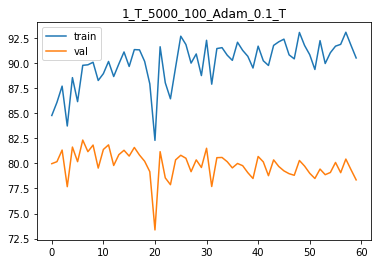

After training for 10 epochs
Train Acc 87.955
Val Acc 76.88
Test Acc 79.064
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 55.94
Epoch: [1/10], Step: [201/625], Validation Acc: 58.26
Epoch: [1/10], Step: [301/625], Validation Acc: 56.56
Epoch: [1/10], Step: [401/625], Validation Acc: 57.06
Epoch: [1/10], Step: [501/625], Validation Acc: 59.94
Epoch: [1/10], Step: [601/625], Validation Acc: 60.64
Epoch: [2/10], Step: [101/625], Validation Acc: 61.22
Epoch: [2/10], Step: [201/625], Validation Acc: 60.46
Epoch: [2/10], Step: [301/625], Validation Acc: 60.24
Epoch: [2/10], Step: [401/625], Validation Acc: 61.06
Epoch: [2/10], Step: [501/625], Validation Acc: 61.88
Epoch: [2/10], Step: [601/625], Validation Acc: 62.2
Epoch: [3/10], Step: [101/625], Validation Acc: 62.24
Epoch: [3/10], Step: [201/625], Validation Acc: 62.34
Epoch: [3/10], Step: [301/625], Validation A

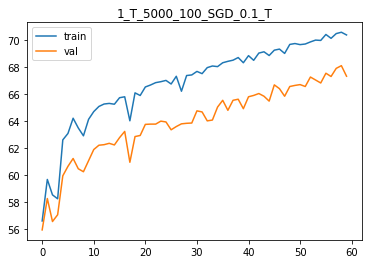

After training for 10 epochs
Train Acc 70.135
Val Acc 67.64
Test Acc 69.216
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.74
Epoch: [1/10], Step: [201/625], Validation Acc: 78.12
Epoch: [1/10], Step: [301/625], Validation Acc: 80.74
Epoch: [1/10], Step: [401/625], Validation Acc: 82.26
Epoch: [1/10], Step: [501/625], Validation Acc: 80.94
Epoch: [1/10], Step: [601/625], Validation Acc: 79.02
Epoch: [2/10], Step: [101/625], Validation Acc: 81.3
Epoch: [2/10], Step: [201/625], Validation Acc: 78.86
Epoch: [2/10], Step: [301/625], Validation Acc: 80.66
Epoch: [2/10], Step: [401/625], Validation Acc: 78.56
Epoch: [2/10], Step: [501/625], Validation Acc: 78.86
Epoch: [2/10], Step: [601/625], Validation Acc: 80.62
Epoch: [3/10], Step: [101/625], Validation Acc: 80.98
Epoch: [3/10], Step: [201/625], Validation Acc: 78.22
Epoch: [3/10], Step: [301/625], Validation 

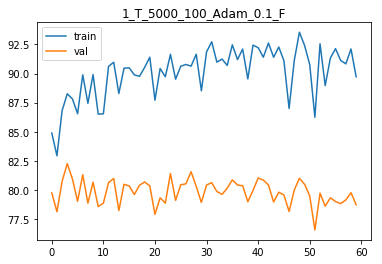

After training for 10 epochs
Train Acc 90.61
Val Acc 78.28
Test Acc 79.996
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 58.66
Epoch: [1/10], Step: [201/625], Validation Acc: 60.5
Epoch: [1/10], Step: [301/625], Validation Acc: 58.78
Epoch: [1/10], Step: [401/625], Validation Acc: 62.1
Epoch: [1/10], Step: [501/625], Validation Acc: 62.04
Epoch: [1/10], Step: [601/625], Validation Acc: 63.06
Epoch: [2/10], Step: [101/625], Validation Acc: 63.18
Epoch: [2/10], Step: [201/625], Validation Acc: 63.48
Epoch: [2/10], Step: [301/625], Validation Acc: 63.74
Epoch: [2/10], Step: [401/625], Validation Acc: 63.74
Epoch: [2/10], Step: [501/625], Validation Acc: 64.22
Epoch: [2/10], Step: [601/625], Validation Acc: 64.26
Epoch: [3/10], Step: [101/625], Validation Acc: 64.62
Epoch: [3/10], Step: [201/625], Validation Acc: 64.82
Epoch: [3/10], Step: [301/625], Validation Acc

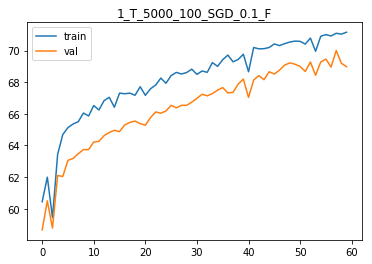

After training for 10 epochs
Train Acc 71.245
Val Acc 69.32
Test Acc 70.772
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.94
Epoch: [1/10], Step: [201/625], Validation Acc: 80.1
Epoch: [1/10], Step: [301/625], Validation Acc: 82.62
Epoch: [1/10], Step: [401/625], Validation Acc: 83.02
Epoch: [1/10], Step: [501/625], Validation Acc: 83.9
Epoch: [1/10], Step: [601/625], Validation Acc: 83.64
Epoch: [2/10], Step: [101/625], Validation Acc: 83.96
Epoch: [2/10], Step: [201/625], Validation Acc: 83.48
Epoch: [2/10], Step: [301/625], Validation Acc: 82.86
Epoch: [2/10], Step: [401/625], Validation Acc: 83.66
Epoch: [2/10], Step: [501/625], Validation Acc: 83.58
Epoch: [2/10], Step: [601/625], Validation Acc: 82.38
Epoch: [3/10], Step: [101/625], Validation Acc: 82.88
Epoch: [3/10], Step: [201/625], Validation Acc: 82.5
Epoch: [3/10], Step: [301/625], Validation A

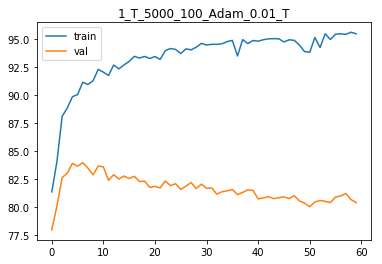

After training for 10 epochs
Train Acc 95.37
Val Acc 80.26
Test Acc 81.784
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.92
Epoch: [1/10], Step: [201/625], Validation Acc: 53.04
Epoch: [1/10], Step: [301/625], Validation Acc: 53.82
Epoch: [1/10], Step: [401/625], Validation Acc: 53.96
Epoch: [1/10], Step: [501/625], Validation Acc: 55.42
Epoch: [1/10], Step: [601/625], Validation Acc: 56.22
Epoch: [2/10], Step: [101/625], Validation Acc: 55.64
Epoch: [2/10], Step: [201/625], Validation Acc: 56.98
Epoch: [2/10], Step: [301/625], Validation Acc: 56.02
Epoch: [2/10], Step: [401/625], Validation Acc: 56.62
Epoch: [2/10], Step: [501/625], Validation Acc: 58.18
Epoch: [2/10], Step: [601/625], Validation Acc: 57.92
Epoch: [3/10], Step: [101/625], Validation Acc: 57.5
Epoch: [3/10], Step: [201/625], Validation Acc: 57.84
Epoch: [3/10], Step: [301/625], Validation A

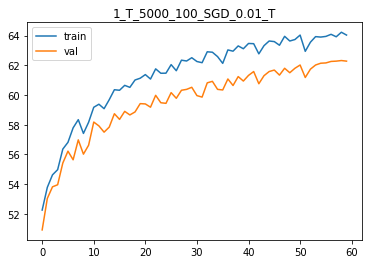

After training for 10 epochs
Train Acc 64.23
Val Acc 62.28
Test Acc 63.8
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.9
Epoch: [1/10], Step: [201/625], Validation Acc: 80.34
Epoch: [1/10], Step: [301/625], Validation Acc: 82.48
Epoch: [1/10], Step: [401/625], Validation Acc: 83.2
Epoch: [1/10], Step: [501/625], Validation Acc: 83.26
Epoch: [1/10], Step: [601/625], Validation Acc: 81.96
Epoch: [2/10], Step: [101/625], Validation Acc: 83.6
Epoch: [2/10], Step: [201/625], Validation Acc: 83.1
Epoch: [2/10], Step: [301/625], Validation Acc: 82.94
Epoch: [2/10], Step: [401/625], Validation Acc: 83.16
Epoch: [2/10], Step: [501/625], Validation Acc: 83.56
Epoch: [2/10], Step: [601/625], Validation Acc: 83.32
Epoch: [3/10], Step: [101/625], Validation Acc: 82.6
Epoch: [3/10], Step: [201/625], Validation Acc: 82.66
Epoch: [3/10], Step: [301/625], Validation Acc: 8

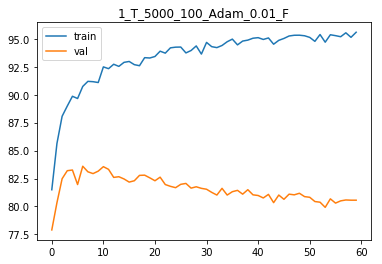

After training for 10 epochs
Train Acc 95.62
Val Acc 80.28
Test Acc 81.848
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.88
Epoch: [1/10], Step: [201/625], Validation Acc: 51.48
Epoch: [1/10], Step: [301/625], Validation Acc: 52.28
Epoch: [1/10], Step: [401/625], Validation Acc: 53.2
Epoch: [1/10], Step: [501/625], Validation Acc: 53.42
Epoch: [1/10], Step: [601/625], Validation Acc: 54.84
Epoch: [2/10], Step: [101/625], Validation Acc: 55.42
Epoch: [2/10], Step: [201/625], Validation Acc: 56.16
Epoch: [2/10], Step: [301/625], Validation Acc: 56.2
Epoch: [2/10], Step: [401/625], Validation Acc: 57.24
Epoch: [2/10], Step: [501/625], Validation Acc: 56.66
Epoch: [2/10], Step: [601/625], Validation Acc: 57.6
Epoch: [3/10], Step: [101/625], Validation Acc: 57.96
Epoch: [3/10], Step: [201/625], Validation Acc: 58.36
Epoch: [3/10], Step: [301/625], Validation Acc

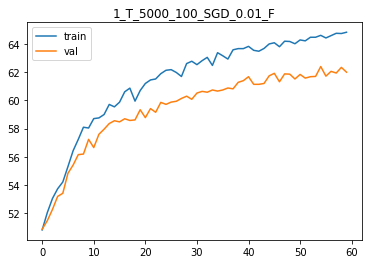

After training for 10 epochs
Train Acc 64.6
Val Acc 61.98
Test Acc 64.044
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 54.56
Epoch: [1/10], Step: [201/625], Validation Acc: 59.68
Epoch: [1/10], Step: [301/625], Validation Acc: 67.94
Epoch: [1/10], Step: [401/625], Validation Acc: 72.02
Epoch: [1/10], Step: [501/625], Validation Acc: 73.86
Epoch: [1/10], Step: [601/625], Validation Acc: 75.8
Epoch: [2/10], Step: [101/625], Validation Acc: 77.52
Epoch: [2/10], Step: [201/625], Validation Acc: 78.38
Epoch: [2/10], Step: [301/625], Validation Acc: 79.34
Epoch: [2/10], Step: [401/625], Validation Acc: 80.0
Epoch: [2/10], Step: [501/625], Validation Acc: 80.52
Epoch: [2/10], Step: [601/625], Validation Acc: 81.14
Epoch: [3/10], Step: [101/625], Validation Acc: 81.54
Epoch: [3/10], Step: [201/625], Validation Acc: 81.66
Epoch: [3/10], Step: [301/625], Validation A

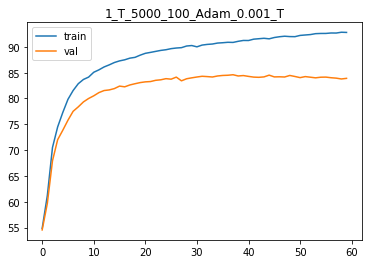

After training for 10 epochs
Train Acc 92.8
Val Acc 83.78
Test Acc 84.912
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 47.84
Epoch: [1/10], Step: [201/625], Validation Acc: 47.98
Epoch: [1/10], Step: [301/625], Validation Acc: 48.04
Epoch: [1/10], Step: [401/625], Validation Acc: 48.4
Epoch: [1/10], Step: [501/625], Validation Acc: 47.88
Epoch: [1/10], Step: [601/625], Validation Acc: 47.94
Epoch: [2/10], Step: [101/625], Validation Acc: 48.0
Epoch: [2/10], Step: [201/625], Validation Acc: 48.14
Epoch: [2/10], Step: [301/625], Validation Acc: 48.38
Epoch: [2/10], Step: [401/625], Validation Acc: 48.52
Epoch: [2/10], Step: [501/625], Validation Acc: 48.82
Epoch: [2/10], Step: [601/625], Validation Acc: 48.76
Epoch: [3/10], Step: [101/625], Validation Acc: 49.04
Epoch: [3/10], Step: [201/625], Validation Acc: 49.08
Epoch: [3/10], Step: [301/625], Validation Ac

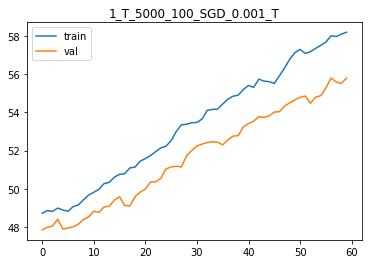

After training for 10 epochs
Train Acc 58.06
Val Acc 55.52
Test Acc 57.028
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.58
Epoch: [1/10], Step: [201/625], Validation Acc: 67.38
Epoch: [1/10], Step: [301/625], Validation Acc: 70.0
Epoch: [1/10], Step: [401/625], Validation Acc: 72.84
Epoch: [1/10], Step: [501/625], Validation Acc: 74.5
Epoch: [1/10], Step: [601/625], Validation Acc: 76.62
Epoch: [2/10], Step: [101/625], Validation Acc: 78.0
Epoch: [2/10], Step: [201/625], Validation Acc: 78.96
Epoch: [2/10], Step: [301/625], Validation Acc: 79.72
Epoch: [2/10], Step: [401/625], Validation Acc: 80.14
Epoch: [2/10], Step: [501/625], Validation Acc: 80.38
Epoch: [2/10], Step: [601/625], Validation Acc: 80.88
Epoch: [3/10], Step: [101/625], Validation Acc: 81.54
Epoch: [3/10], Step: [201/625], Validation Acc: 81.94
Epoch: [3/10], Step: [301/625], Validation A

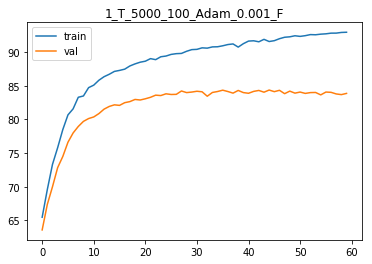

After training for 10 epochs
Train Acc 93.005
Val Acc 83.46
Test Acc 84.904
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.16
Epoch: [1/10], Step: [201/625], Validation Acc: 50.16
Epoch: [1/10], Step: [301/625], Validation Acc: 50.28
Epoch: [1/10], Step: [401/625], Validation Acc: 50.62
Epoch: [1/10], Step: [501/625], Validation Acc: 50.62
Epoch: [1/10], Step: [601/625], Validation Acc: 51.16
Epoch: [2/10], Step: [101/625], Validation Acc: 51.04
Epoch: [2/10], Step: [201/625], Validation Acc: 51.28
Epoch: [2/10], Step: [301/625], Validation Acc: 51.36
Epoch: [2/10], Step: [401/625], Validation Acc: 51.5
Epoch: [2/10], Step: [501/625], Validation Acc: 51.54
Epoch: [2/10], Step: [601/625], Validation Acc: 51.64
Epoch: [3/10], Step: [101/625], Validation Acc: 52.1
Epoch: [3/10], Step: [201/625], Validation Acc: 52.18
Epoch: [3/10], Step: [301/625], Validation 

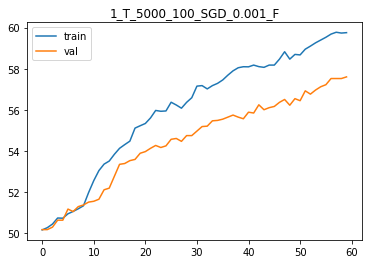

After training for 10 epochs
Train Acc 59.725
Val Acc 57.58
Test Acc 59.452
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.88
Epoch: [1/10], Step: [201/625], Validation Acc: 80.56
Epoch: [1/10], Step: [301/625], Validation Acc: 80.66
Epoch: [1/10], Step: [401/625], Validation Acc: 79.12
Epoch: [1/10], Step: [501/625], Validation Acc: 78.62
Epoch: [1/10], Step: [601/625], Validation Acc: 77.32
Epoch: [2/10], Step: [101/625], Validation Acc: 78.08
Epoch: [2/10], Step: [201/625], Validation Acc: 75.1
Epoch: [2/10], Step: [301/625], Validation Acc: 80.98
Epoch: [2/10], Step: [401/625], Validation Acc: 78.98
Epoch: [2/10], Step: [501/625], Validation Acc: 81.7
Epoch: [2/10], Step: [601/625], Validation Acc: 77.02
Epoch: [3/10], Step: [101/625], Validation Acc: 80.22
Epoch: [3/10], Step: [201/625], Validation Acc: 75.96
Epoch: [3/10], Step: [301/625], Validation A

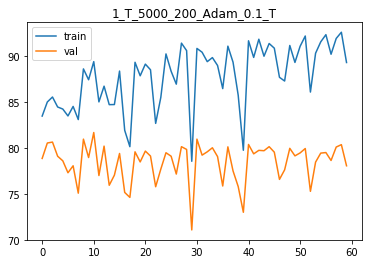

After training for 10 epochs
Train Acc 88.665
Val Acc 77.46
Test Acc 79.372
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 56.72
Epoch: [1/10], Step: [201/625], Validation Acc: 59.88
Epoch: [1/10], Step: [301/625], Validation Acc: 63.88
Epoch: [1/10], Step: [401/625], Validation Acc: 61.72
Epoch: [1/10], Step: [501/625], Validation Acc: 64.9
Epoch: [1/10], Step: [601/625], Validation Acc: 64.22
Epoch: [2/10], Step: [101/625], Validation Acc: 65.58
Epoch: [2/10], Step: [201/625], Validation Acc: 66.02
Epoch: [2/10], Step: [301/625], Validation Acc: 65.5
Epoch: [2/10], Step: [401/625], Validation Acc: 66.74
Epoch: [2/10], Step: [501/625], Validation Acc: 66.78
Epoch: [2/10], Step: [601/625], Validation Acc: 67.04
Epoch: [3/10], Step: [101/625], Validation Acc: 67.42
Epoch: [3/10], Step: [201/625], Validation Acc: 67.28
Epoch: [3/10], Step: [301/625], Validation Ac

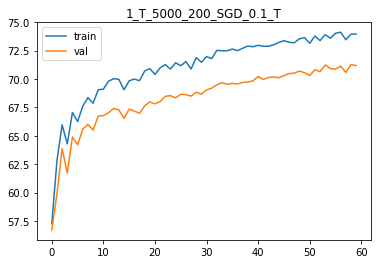

After training for 10 epochs
Train Acc 74.275
Val Acc 71.26
Test Acc 73.712
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.9
Epoch: [1/10], Step: [201/625], Validation Acc: 78.56
Epoch: [1/10], Step: [301/625], Validation Acc: 80.7
Epoch: [1/10], Step: [401/625], Validation Acc: 78.96
Epoch: [1/10], Step: [501/625], Validation Acc: 74.88
Epoch: [1/10], Step: [601/625], Validation Acc: 79.76
Epoch: [2/10], Step: [101/625], Validation Acc: 76.32
Epoch: [2/10], Step: [201/625], Validation Acc: 77.6
Epoch: [2/10], Step: [301/625], Validation Acc: 78.08
Epoch: [2/10], Step: [401/625], Validation Acc: 81.16
Epoch: [2/10], Step: [501/625], Validation Acc: 78.52
Epoch: [2/10], Step: [601/625], Validation Acc: 81.48
Epoch: [3/10], Step: [101/625], Validation Acc: 79.9
Epoch: [3/10], Step: [201/625], Validation Acc: 80.04
Epoch: [3/10], Step: [301/625], Validation Acc

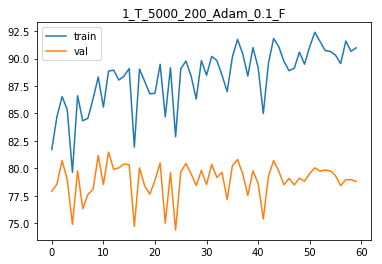

After training for 10 epochs
Train Acc 91.655
Val Acc 79.68
Test Acc 81.28
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 55.36
Epoch: [1/10], Step: [201/625], Validation Acc: 62.1
Epoch: [1/10], Step: [301/625], Validation Acc: 63.7
Epoch: [1/10], Step: [401/625], Validation Acc: 64.56
Epoch: [1/10], Step: [501/625], Validation Acc: 65.78
Epoch: [1/10], Step: [601/625], Validation Acc: 63.08
Epoch: [2/10], Step: [101/625], Validation Acc: 66.64
Epoch: [2/10], Step: [201/625], Validation Acc: 66.86
Epoch: [2/10], Step: [301/625], Validation Acc: 66.84
Epoch: [2/10], Step: [401/625], Validation Acc: 66.98
Epoch: [2/10], Step: [501/625], Validation Acc: 67.28
Epoch: [2/10], Step: [601/625], Validation Acc: 67.12
Epoch: [3/10], Step: [101/625], Validation Acc: 66.72
Epoch: [3/10], Step: [201/625], Validation Acc: 67.74
Epoch: [3/10], Step: [301/625], Validation Acc

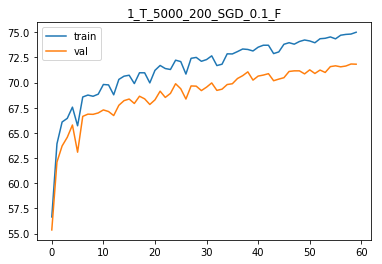

After training for 10 epochs
Train Acc 74.59
Val Acc 71.78
Test Acc 73.608
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.76
Epoch: [1/10], Step: [201/625], Validation Acc: 81.24
Epoch: [1/10], Step: [301/625], Validation Acc: 82.48
Epoch: [1/10], Step: [401/625], Validation Acc: 82.66
Epoch: [1/10], Step: [501/625], Validation Acc: 83.08
Epoch: [1/10], Step: [601/625], Validation Acc: 82.26
Epoch: [2/10], Step: [101/625], Validation Acc: 83.34
Epoch: [2/10], Step: [201/625], Validation Acc: 82.94
Epoch: [2/10], Step: [301/625], Validation Acc: 82.26
Epoch: [2/10], Step: [401/625], Validation Acc: 81.78
Epoch: [2/10], Step: [501/625], Validation Acc: 83.42
Epoch: [2/10], Step: [601/625], Validation Acc: 81.22
Epoch: [3/10], Step: [101/625], Validation Acc: 82.44
Epoch: [3/10], Step: [201/625], Validation Acc: 81.7
Epoch: [3/10], Step: [301/625], Validation 

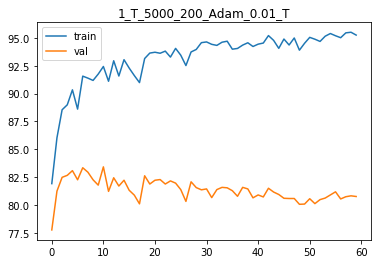

After training for 10 epochs
Train Acc 95.435
Val Acc 80.38
Test Acc 81.68
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 54.82
Epoch: [1/10], Step: [201/625], Validation Acc: 56.32
Epoch: [1/10], Step: [301/625], Validation Acc: 55.86
Epoch: [1/10], Step: [401/625], Validation Acc: 57.68
Epoch: [1/10], Step: [501/625], Validation Acc: 58.04
Epoch: [1/10], Step: [601/625], Validation Acc: 57.58
Epoch: [2/10], Step: [101/625], Validation Acc: 58.7
Epoch: [2/10], Step: [201/625], Validation Acc: 59.28
Epoch: [2/10], Step: [301/625], Validation Acc: 60.4
Epoch: [2/10], Step: [401/625], Validation Acc: 60.98
Epoch: [2/10], Step: [501/625], Validation Acc: 60.1
Epoch: [2/10], Step: [601/625], Validation Acc: 61.12
Epoch: [3/10], Step: [101/625], Validation Acc: 61.56
Epoch: [3/10], Step: [201/625], Validation Acc: 61.74
Epoch: [3/10], Step: [301/625], Validation Acc

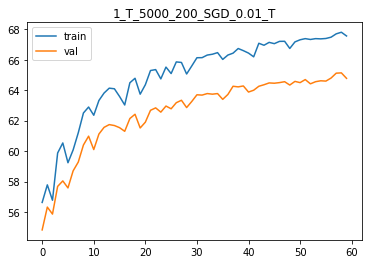

After training for 10 epochs
Train Acc 67.55
Val Acc 64.86
Test Acc 67.58
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.28
Epoch: [1/10], Step: [201/625], Validation Acc: 81.3
Epoch: [1/10], Step: [301/625], Validation Acc: 82.38
Epoch: [1/10], Step: [401/625], Validation Acc: 82.96
Epoch: [1/10], Step: [501/625], Validation Acc: 83.82
Epoch: [1/10], Step: [601/625], Validation Acc: 83.74
Epoch: [2/10], Step: [101/625], Validation Acc: 82.68
Epoch: [2/10], Step: [201/625], Validation Acc: 83.12
Epoch: [2/10], Step: [301/625], Validation Acc: 83.08
Epoch: [2/10], Step: [401/625], Validation Acc: 83.02
Epoch: [2/10], Step: [501/625], Validation Acc: 82.86
Epoch: [2/10], Step: [601/625], Validation Acc: 83.5
Epoch: [3/10], Step: [101/625], Validation Acc: 82.9
Epoch: [3/10], Step: [201/625], Validation Acc: 82.46
Epoch: [3/10], Step: [301/625], Validation Acc

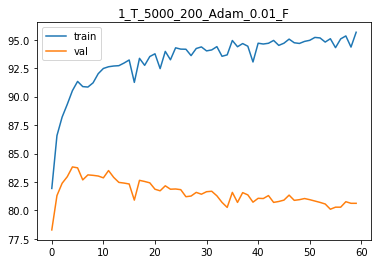

After training for 10 epochs
Train Acc 95.4
Val Acc 80.56
Test Acc 81.836
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.22
Epoch: [1/10], Step: [201/625], Validation Acc: 52.32
Epoch: [1/10], Step: [301/625], Validation Acc: 53.14
Epoch: [1/10], Step: [401/625], Validation Acc: 56.56
Epoch: [1/10], Step: [501/625], Validation Acc: 57.2
Epoch: [1/10], Step: [601/625], Validation Acc: 57.32
Epoch: [2/10], Step: [101/625], Validation Acc: 58.58
Epoch: [2/10], Step: [201/625], Validation Acc: 59.9
Epoch: [2/10], Step: [301/625], Validation Acc: 60.54
Epoch: [2/10], Step: [401/625], Validation Acc: 59.64
Epoch: [2/10], Step: [501/625], Validation Acc: 60.18
Epoch: [2/10], Step: [601/625], Validation Acc: 60.84
Epoch: [3/10], Step: [101/625], Validation Acc: 61.82
Epoch: [3/10], Step: [201/625], Validation Acc: 61.08
Epoch: [3/10], Step: [301/625], Validation Acc

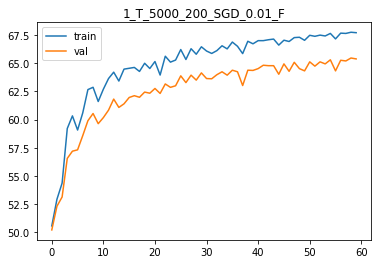

After training for 10 epochs
Train Acc 67.71
Val Acc 65.42
Test Acc 67.204
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 64.94
Epoch: [1/10], Step: [201/625], Validation Acc: 69.9
Epoch: [1/10], Step: [301/625], Validation Acc: 72.44
Epoch: [1/10], Step: [401/625], Validation Acc: 75.62
Epoch: [1/10], Step: [501/625], Validation Acc: 77.32
Epoch: [1/10], Step: [601/625], Validation Acc: 78.78
Epoch: [2/10], Step: [101/625], Validation Acc: 79.76
Epoch: [2/10], Step: [201/625], Validation Acc: 80.82
Epoch: [2/10], Step: [301/625], Validation Acc: 81.1
Epoch: [2/10], Step: [401/625], Validation Acc: 81.46
Epoch: [2/10], Step: [501/625], Validation Acc: 82.02
Epoch: [2/10], Step: [601/625], Validation Acc: 82.24
Epoch: [3/10], Step: [101/625], Validation Acc: 82.74
Epoch: [3/10], Step: [201/625], Validation Acc: 83.14
Epoch: [3/10], Step: [301/625], Validation 

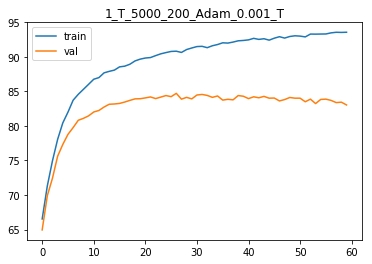

After training for 10 epochs
Train Acc 92.58
Val Acc 83.06
Test Acc 84.516
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.06
Epoch: [1/10], Step: [201/625], Validation Acc: 50.68
Epoch: [1/10], Step: [301/625], Validation Acc: 51.62
Epoch: [1/10], Step: [401/625], Validation Acc: 51.88
Epoch: [1/10], Step: [501/625], Validation Acc: 51.88
Epoch: [1/10], Step: [601/625], Validation Acc: 51.9
Epoch: [2/10], Step: [101/625], Validation Acc: 53.06
Epoch: [2/10], Step: [201/625], Validation Acc: 52.6
Epoch: [2/10], Step: [301/625], Validation Acc: 53.22
Epoch: [2/10], Step: [401/625], Validation Acc: 53.06
Epoch: [2/10], Step: [501/625], Validation Acc: 53.2
Epoch: [2/10], Step: [601/625], Validation Acc: 53.62
Epoch: [3/10], Step: [101/625], Validation Acc: 53.68
Epoch: [3/10], Step: [201/625], Validation Acc: 53.6
Epoch: [3/10], Step: [301/625], Validation Acc

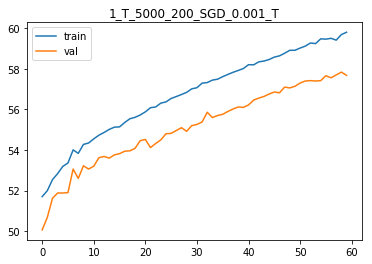

After training for 10 epochs
Train Acc 59.81
Val Acc 57.84
Test Acc 59.416
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.34
Epoch: [1/10], Step: [201/625], Validation Acc: 69.6
Epoch: [1/10], Step: [301/625], Validation Acc: 72.68
Epoch: [1/10], Step: [401/625], Validation Acc: 76.02
Epoch: [1/10], Step: [501/625], Validation Acc: 77.14
Epoch: [1/10], Step: [601/625], Validation Acc: 78.3
Epoch: [2/10], Step: [101/625], Validation Acc: 79.32
Epoch: [2/10], Step: [201/625], Validation Acc: 80.32
Epoch: [2/10], Step: [301/625], Validation Acc: 80.8
Epoch: [2/10], Step: [401/625], Validation Acc: 81.22
Epoch: [2/10], Step: [501/625], Validation Acc: 81.92
Epoch: [2/10], Step: [601/625], Validation Acc: 82.24
Epoch: [3/10], Step: [101/625], Validation Acc: 82.24
Epoch: [3/10], Step: [201/625], Validation Acc: 82.88
Epoch: [3/10], Step: [301/625], Validation A

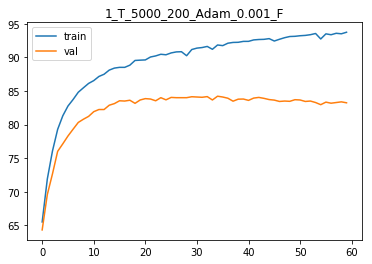

After training for 10 epochs
Train Acc 93.625
Val Acc 83.26
Test Acc 84.656
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 49.84
Epoch: [1/10], Step: [201/625], Validation Acc: 49.68
Epoch: [1/10], Step: [301/625], Validation Acc: 49.16
Epoch: [1/10], Step: [401/625], Validation Acc: 49.16
Epoch: [1/10], Step: [501/625], Validation Acc: 49.26
Epoch: [1/10], Step: [601/625], Validation Acc: 49.54
Epoch: [2/10], Step: [101/625], Validation Acc: 50.06
Epoch: [2/10], Step: [201/625], Validation Acc: 50.08
Epoch: [2/10], Step: [301/625], Validation Acc: 50.5
Epoch: [2/10], Step: [401/625], Validation Acc: 50.6
Epoch: [2/10], Step: [501/625], Validation Acc: 50.82
Epoch: [2/10], Step: [601/625], Validation Acc: 51.08
Epoch: [3/10], Step: [101/625], Validation Acc: 52.1
Epoch: [3/10], Step: [201/625], Validation Acc: 52.0
Epoch: [3/10], Step: [301/625], Validation Ac

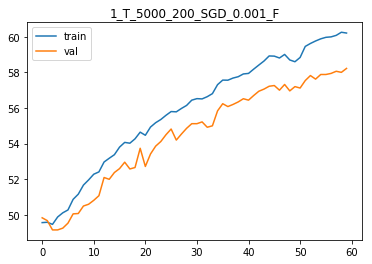

After training for 10 epochs
Train Acc 60.175
Val Acc 58.3
Test Acc 59.576
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 73.34
Epoch: [1/10], Step: [201/625], Validation Acc: 75.7
Epoch: [1/10], Step: [301/625], Validation Acc: 78.78
Epoch: [1/10], Step: [401/625], Validation Acc: 75.62
Epoch: [1/10], Step: [501/625], Validation Acc: 77.56
Epoch: [1/10], Step: [601/625], Validation Acc: 75.12
Epoch: [2/10], Step: [101/625], Validation Acc: 73.9
Epoch: [2/10], Step: [201/625], Validation Acc: 77.18
Epoch: [2/10], Step: [301/625], Validation Acc: 79.54
Epoch: [2/10], Step: [401/625], Validation Acc: 77.28
Epoch: [2/10], Step: [501/625], Validation Acc: 79.36
Epoch: [2/10], Step: [601/625], Validation Acc: 76.24
Epoch: [3/10], Step: [101/625], Validation Acc: 77.82
Epoch: [3/10], Step: [201/625], Validation Acc: 78.54
Epoch: [3/10], Step: [301/625], Validation Ac

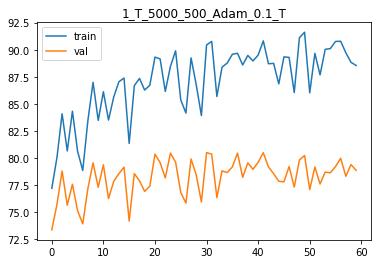

After training for 10 epochs
Train Acc 90.775
Val Acc 79.82
Test Acc 81.432
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 61.36
Epoch: [1/10], Step: [201/625], Validation Acc: 65.94
Epoch: [1/10], Step: [301/625], Validation Acc: 65.26
Epoch: [1/10], Step: [401/625], Validation Acc: 67.58
Epoch: [1/10], Step: [501/625], Validation Acc: 68.16
Epoch: [1/10], Step: [601/625], Validation Acc: 68.58
Epoch: [2/10], Step: [101/625], Validation Acc: 68.78
Epoch: [2/10], Step: [201/625], Validation Acc: 69.9
Epoch: [2/10], Step: [301/625], Validation Acc: 69.06
Epoch: [2/10], Step: [401/625], Validation Acc: 70.28
Epoch: [2/10], Step: [501/625], Validation Acc: 69.26
Epoch: [2/10], Step: [601/625], Validation Acc: 70.84
Epoch: [3/10], Step: [101/625], Validation Acc: 70.86
Epoch: [3/10], Step: [201/625], Validation Acc: 71.22
Epoch: [3/10], Step: [301/625], Validation A

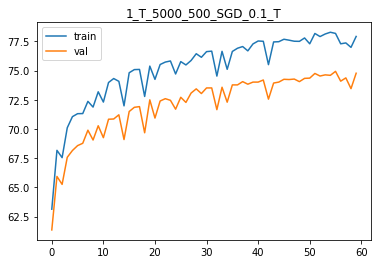

After training for 10 epochs
Train Acc 77.59
Val Acc 74.46
Test Acc 76.048
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 73.48
Epoch: [1/10], Step: [201/625], Validation Acc: 76.52
Epoch: [1/10], Step: [301/625], Validation Acc: 75.08
Epoch: [1/10], Step: [401/625], Validation Acc: 80.3
Epoch: [1/10], Step: [501/625], Validation Acc: 76.86
Epoch: [1/10], Step: [601/625], Validation Acc: 77.56
Epoch: [2/10], Step: [101/625], Validation Acc: 78.9
Epoch: [2/10], Step: [201/625], Validation Acc: 76.3
Epoch: [2/10], Step: [301/625], Validation Acc: 76.74
Epoch: [2/10], Step: [401/625], Validation Acc: 78.54
Epoch: [2/10], Step: [501/625], Validation Acc: 76.22
Epoch: [2/10], Step: [601/625], Validation Acc: 79.96
Epoch: [3/10], Step: [101/625], Validation Acc: 78.76
Epoch: [3/10], Step: [201/625], Validation Acc: 78.78
Epoch: [3/10], Step: [301/625], Validation Acc

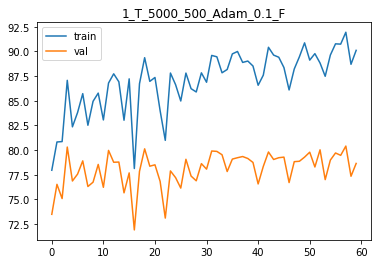

After training for 10 epochs
Train Acc 90.295
Val Acc 79.4
Test Acc 80.904
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.92
Epoch: [1/10], Step: [201/625], Validation Acc: 66.22
Epoch: [1/10], Step: [301/625], Validation Acc: 64.84
Epoch: [1/10], Step: [401/625], Validation Acc: 66.7
Epoch: [1/10], Step: [501/625], Validation Acc: 68.34
Epoch: [1/10], Step: [601/625], Validation Acc: 67.24
Epoch: [2/10], Step: [101/625], Validation Acc: 67.52
Epoch: [2/10], Step: [201/625], Validation Acc: 70.54
Epoch: [2/10], Step: [301/625], Validation Acc: 70.5
Epoch: [2/10], Step: [401/625], Validation Acc: 70.6
Epoch: [2/10], Step: [501/625], Validation Acc: 71.96
Epoch: [2/10], Step: [601/625], Validation Acc: 71.7
Epoch: [3/10], Step: [101/625], Validation Acc: 70.86
Epoch: [3/10], Step: [201/625], Validation Acc: 72.28
Epoch: [3/10], Step: [301/625], Validation Acc: 

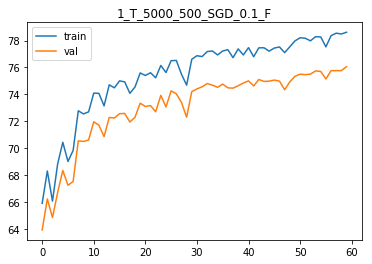

After training for 10 epochs
Train Acc 77.94
Val Acc 75.02
Test Acc 76.728
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.3
Epoch: [1/10], Step: [201/625], Validation Acc: 81.5
Epoch: [1/10], Step: [301/625], Validation Acc: 82.26
Epoch: [1/10], Step: [401/625], Validation Acc: 81.18
Epoch: [1/10], Step: [501/625], Validation Acc: 82.56
Epoch: [1/10], Step: [601/625], Validation Acc: 82.84
Epoch: [2/10], Step: [101/625], Validation Acc: 82.9
Epoch: [2/10], Step: [201/625], Validation Acc: 82.34
Epoch: [2/10], Step: [301/625], Validation Acc: 82.08
Epoch: [2/10], Step: [401/625], Validation Acc: 83.56
Epoch: [2/10], Step: [501/625], Validation Acc: 82.22
Epoch: [2/10], Step: [601/625], Validation Acc: 82.7
Epoch: [3/10], Step: [101/625], Validation Acc: 82.48
Epoch: [3/10], Step: [201/625], Validation Acc: 82.52
Epoch: [3/10], Step: [301/625], Validation Acc

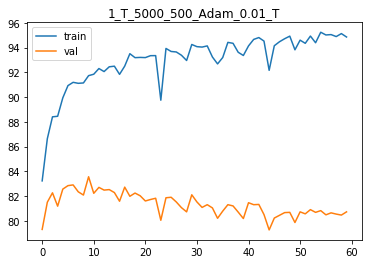

After training for 10 epochs
Train Acc 94.925
Val Acc 81.06
Test Acc 82.132
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 57.02
Epoch: [1/10], Step: [201/625], Validation Acc: 59.78
Epoch: [1/10], Step: [301/625], Validation Acc: 61.06
Epoch: [1/10], Step: [401/625], Validation Acc: 61.3
Epoch: [1/10], Step: [501/625], Validation Acc: 61.86
Epoch: [1/10], Step: [601/625], Validation Acc: 63.52
Epoch: [2/10], Step: [101/625], Validation Acc: 64.14
Epoch: [2/10], Step: [201/625], Validation Acc: 64.1
Epoch: [2/10], Step: [301/625], Validation Acc: 63.66
Epoch: [2/10], Step: [401/625], Validation Acc: 64.7
Epoch: [2/10], Step: [501/625], Validation Acc: 64.22
Epoch: [2/10], Step: [601/625], Validation Acc: 63.52
Epoch: [3/10], Step: [101/625], Validation Acc: 65.4
Epoch: [3/10], Step: [201/625], Validation Acc: 64.92
Epoch: [3/10], Step: [301/625], Validation Acc

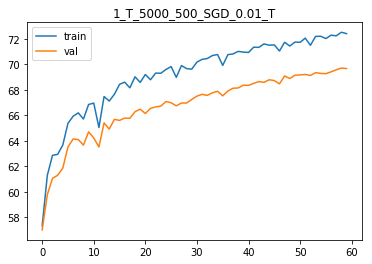

After training for 10 epochs
Train Acc 72.435
Val Acc 69.6
Test Acc 71.472
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.24
Epoch: [1/10], Step: [201/625], Validation Acc: 80.94
Epoch: [1/10], Step: [301/625], Validation Acc: 82.3
Epoch: [1/10], Step: [401/625], Validation Acc: 83.0
Epoch: [1/10], Step: [501/625], Validation Acc: 83.08
Epoch: [1/10], Step: [601/625], Validation Acc: 81.96
Epoch: [2/10], Step: [101/625], Validation Acc: 82.28
Epoch: [2/10], Step: [201/625], Validation Acc: 82.28
Epoch: [2/10], Step: [301/625], Validation Acc: 82.3
Epoch: [2/10], Step: [401/625], Validation Acc: 83.12
Epoch: [2/10], Step: [501/625], Validation Acc: 82.9
Epoch: [2/10], Step: [601/625], Validation Acc: 83.04
Epoch: [3/10], Step: [101/625], Validation Acc: 82.06
Epoch: [3/10], Step: [201/625], Validation Acc: 82.42
Epoch: [3/10], Step: [301/625], Validation Acc

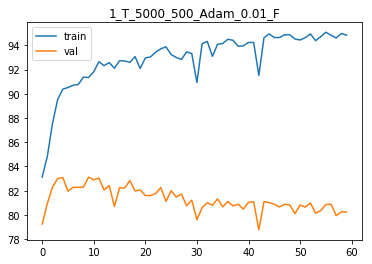

After training for 10 epochs
Train Acc 94.81
Val Acc 80.18
Test Acc 81.608
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 57.14
Epoch: [1/10], Step: [201/625], Validation Acc: 60.3
Epoch: [1/10], Step: [301/625], Validation Acc: 60.78
Epoch: [1/10], Step: [401/625], Validation Acc: 58.58
Epoch: [1/10], Step: [501/625], Validation Acc: 62.94
Epoch: [1/10], Step: [601/625], Validation Acc: 62.84
Epoch: [2/10], Step: [101/625], Validation Acc: 63.9
Epoch: [2/10], Step: [201/625], Validation Acc: 64.94
Epoch: [2/10], Step: [301/625], Validation Acc: 64.1
Epoch: [2/10], Step: [401/625], Validation Acc: 64.42
Epoch: [2/10], Step: [501/625], Validation Acc: 65.26
Epoch: [2/10], Step: [601/625], Validation Acc: 65.0
Epoch: [3/10], Step: [101/625], Validation Acc: 65.28
Epoch: [3/10], Step: [201/625], Validation Acc: 65.8
Epoch: [3/10], Step: [301/625], Validation Acc: 

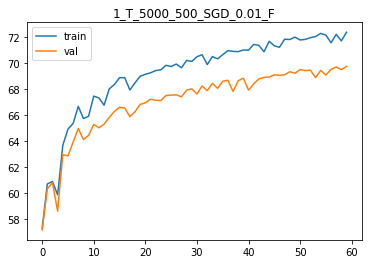

After training for 10 epochs
Train Acc 72.265
Val Acc 69.7
Test Acc 71.796
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 65.16
Epoch: [1/10], Step: [201/625], Validation Acc: 71.6
Epoch: [1/10], Step: [301/625], Validation Acc: 74.22
Epoch: [1/10], Step: [401/625], Validation Acc: 76.74
Epoch: [1/10], Step: [501/625], Validation Acc: 78.72
Epoch: [1/10], Step: [601/625], Validation Acc: 79.84
Epoch: [2/10], Step: [101/625], Validation Acc: 80.26
Epoch: [2/10], Step: [201/625], Validation Acc: 81.32
Epoch: [2/10], Step: [301/625], Validation Acc: 81.58
Epoch: [2/10], Step: [401/625], Validation Acc: 82.02
Epoch: [2/10], Step: [501/625], Validation Acc: 82.48
Epoch: [2/10], Step: [601/625], Validation Acc: 83.22
Epoch: [3/10], Step: [101/625], Validation Acc: 83.58
Epoch: [3/10], Step: [201/625], Validation Acc: 83.92
Epoch: [3/10], Step: [301/625], Validation

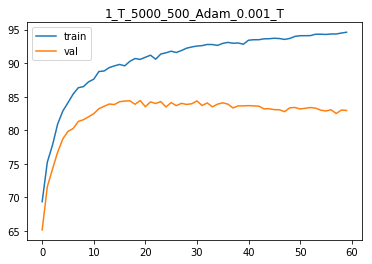

After training for 10 epochs
Train Acc 94.45
Val Acc 82.98
Test Acc 83.908
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 52.66
Epoch: [1/10], Step: [201/625], Validation Acc: 54.32
Epoch: [1/10], Step: [301/625], Validation Acc: 54.32
Epoch: [1/10], Step: [401/625], Validation Acc: 54.28
Epoch: [1/10], Step: [501/625], Validation Acc: 55.24
Epoch: [1/10], Step: [601/625], Validation Acc: 55.02
Epoch: [2/10], Step: [101/625], Validation Acc: 55.56
Epoch: [2/10], Step: [201/625], Validation Acc: 55.68
Epoch: [2/10], Step: [301/625], Validation Acc: 56.9
Epoch: [2/10], Step: [401/625], Validation Acc: 57.02
Epoch: [2/10], Step: [501/625], Validation Acc: 57.28
Epoch: [2/10], Step: [601/625], Validation Acc: 57.64
Epoch: [3/10], Step: [101/625], Validation Acc: 58.14
Epoch: [3/10], Step: [201/625], Validation Acc: 58.0
Epoch: [3/10], Step: [301/625], Validation A

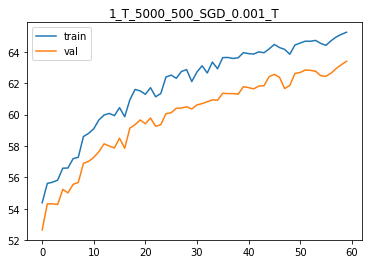

After training for 10 epochs
Train Acc 65.17
Val Acc 63.18
Test Acc 65.0
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 66.26
Epoch: [1/10], Step: [201/625], Validation Acc: 71.76
Epoch: [1/10], Step: [301/625], Validation Acc: 74.58
Epoch: [1/10], Step: [401/625], Validation Acc: 76.92
Epoch: [1/10], Step: [501/625], Validation Acc: 78.92
Epoch: [1/10], Step: [601/625], Validation Acc: 79.78
Epoch: [2/10], Step: [101/625], Validation Acc: 80.86
Epoch: [2/10], Step: [201/625], Validation Acc: 80.94
Epoch: [2/10], Step: [301/625], Validation Acc: 81.98
Epoch: [2/10], Step: [401/625], Validation Acc: 82.44
Epoch: [2/10], Step: [501/625], Validation Acc: 82.4
Epoch: [2/10], Step: [601/625], Validation Acc: 82.98
Epoch: [3/10], Step: [101/625], Validation Acc: 82.98
Epoch: [3/10], Step: [201/625], Validation Acc: 83.36
Epoch: [3/10], Step: [301/625], Validation A

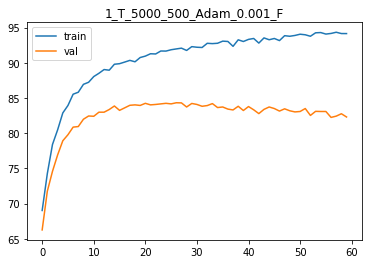

After training for 10 epochs
Train Acc 93.595
Val Acc 82.7
Test Acc 84.056
ngram:  1
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 52.16
Epoch: [1/10], Step: [201/625], Validation Acc: 53.24
Epoch: [1/10], Step: [301/625], Validation Acc: 55.0
Epoch: [1/10], Step: [401/625], Validation Acc: 54.1
Epoch: [1/10], Step: [501/625], Validation Acc: 55.2
Epoch: [1/10], Step: [601/625], Validation Acc: 56.54
Epoch: [2/10], Step: [101/625], Validation Acc: 57.56
Epoch: [2/10], Step: [201/625], Validation Acc: 57.1
Epoch: [2/10], Step: [301/625], Validation Acc: 57.04
Epoch: [2/10], Step: [401/625], Validation Acc: 57.36
Epoch: [2/10], Step: [501/625], Validation Acc: 57.64
Epoch: [2/10], Step: [601/625], Validation Acc: 57.76
Epoch: [3/10], Step: [101/625], Validation Acc: 57.98
Epoch: [3/10], Step: [201/625], Validation Acc: 58.58
Epoch: [3/10], Step: [301/625], Validation Acc

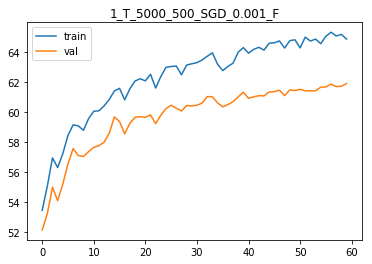

After training for 10 epochs
Train Acc 64.97
Val Acc 61.88
Test Acc 63.492
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.5
Epoch: [1/10], Step: [201/625], Validation Acc: 78.42
Epoch: [1/10], Step: [301/625], Validation Acc: 78.62
Epoch: [1/10], Step: [401/625], Validation Acc: 80.34
Epoch: [1/10], Step: [501/625], Validation Acc: 82.18
Epoch: [1/10], Step: [601/625], Validation Acc: 78.78
Epoch: [2/10], Step: [101/625], Validation Acc: 78.34
Epoch: [2/10], Step: [201/625], Validation Acc: 80.08
Epoch: [2/10], Step: [301/625], Validation Acc: 80.04
Epoch: [2/10], Step: [401/625], Validation Acc: 80.64
Epoch: [2/10], Step: [501/625], Validation Acc: 79.98
Epoch: [2/10], Step: [601/625], Validation Acc: 79.38
Epoch: [3/10], Step: [101/625], Validation Acc: 81.12
Epoch: [3/10], Step: [201/625], Validation Acc: 79.64
Epoch: [3/10], Step: [301/625], Validation 

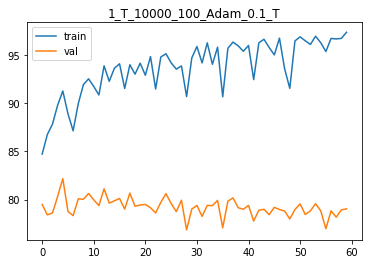

After training for 10 epochs
Train Acc 92.79
Val Acc 77.2
Test Acc 79.22
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 51.4
Epoch: [1/10], Step: [201/625], Validation Acc: 59.12
Epoch: [1/10], Step: [301/625], Validation Acc: 60.2
Epoch: [1/10], Step: [401/625], Validation Acc: 61.74
Epoch: [1/10], Step: [501/625], Validation Acc: 60.26
Epoch: [1/10], Step: [601/625], Validation Acc: 61.56
Epoch: [2/10], Step: [101/625], Validation Acc: 62.54
Epoch: [2/10], Step: [201/625], Validation Acc: 62.42
Epoch: [2/10], Step: [301/625], Validation Acc: 63.12
Epoch: [2/10], Step: [401/625], Validation Acc: 63.56
Epoch: [2/10], Step: [501/625], Validation Acc: 63.62
Epoch: [2/10], Step: [601/625], Validation Acc: 62.76
Epoch: [3/10], Step: [101/625], Validation Acc: 64.32
Epoch: [3/10], Step: [201/625], Validation Acc: 64.14
Epoch: [3/10], Step: [301/625], Validation Acc:

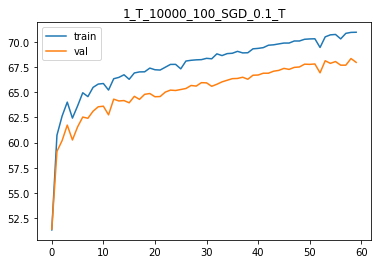

After training for 10 epochs
Train Acc 71.04
Val Acc 68.4
Test Acc 70.324
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.34
Epoch: [1/10], Step: [201/625], Validation Acc: 81.08
Epoch: [1/10], Step: [301/625], Validation Acc: 81.8
Epoch: [1/10], Step: [401/625], Validation Acc: 81.58
Epoch: [1/10], Step: [501/625], Validation Acc: 81.32
Epoch: [1/10], Step: [601/625], Validation Acc: 81.06
Epoch: [2/10], Step: [101/625], Validation Acc: 81.16
Epoch: [2/10], Step: [201/625], Validation Acc: 81.04
Epoch: [2/10], Step: [301/625], Validation Acc: 78.48
Epoch: [2/10], Step: [401/625], Validation Acc: 79.46
Epoch: [2/10], Step: [501/625], Validation Acc: 80.3
Epoch: [2/10], Step: [601/625], Validation Acc: 81.32
Epoch: [3/10], Step: [101/625], Validation Acc: 79.82
Epoch: [3/10], Step: [201/625], Validation Acc: 80.58
Epoch: [3/10], Step: [301/625], Validation Ac

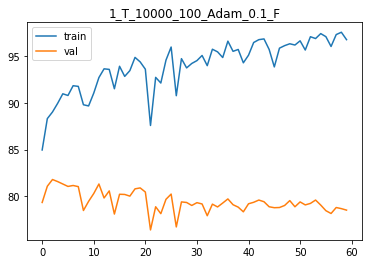

After training for 10 epochs
Train Acc 97.16
Val Acc 78.68
Test Acc 80.3
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 52.22
Epoch: [1/10], Step: [201/625], Validation Acc: 58.92
Epoch: [1/10], Step: [301/625], Validation Acc: 59.48
Epoch: [1/10], Step: [401/625], Validation Acc: 60.12
Epoch: [1/10], Step: [501/625], Validation Acc: 60.86
Epoch: [1/10], Step: [601/625], Validation Acc: 61.1
Epoch: [2/10], Step: [101/625], Validation Acc: 62.1
Epoch: [2/10], Step: [201/625], Validation Acc: 62.1
Epoch: [2/10], Step: [301/625], Validation Acc: 62.38
Epoch: [2/10], Step: [401/625], Validation Acc: 62.82
Epoch: [2/10], Step: [501/625], Validation Acc: 62.44
Epoch: [2/10], Step: [601/625], Validation Acc: 62.64
Epoch: [3/10], Step: [101/625], Validation Acc: 63.1
Epoch: [3/10], Step: [201/625], Validation Acc: 62.06
Epoch: [3/10], Step: [301/625], Validation Acc: 6

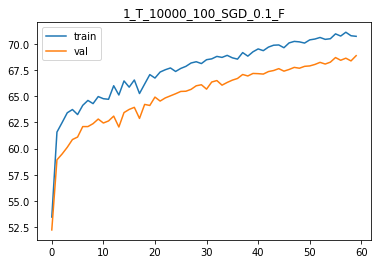

After training for 10 epochs
Train Acc 71.195
Val Acc 68.86
Test Acc 70.544
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.5
Epoch: [1/10], Step: [201/625], Validation Acc: 81.46
Epoch: [1/10], Step: [301/625], Validation Acc: 82.92
Epoch: [1/10], Step: [401/625], Validation Acc: 83.8
Epoch: [1/10], Step: [501/625], Validation Acc: 82.44
Epoch: [1/10], Step: [601/625], Validation Acc: 83.04
Epoch: [2/10], Step: [101/625], Validation Acc: 83.18
Epoch: [2/10], Step: [201/625], Validation Acc: 81.86
Epoch: [2/10], Step: [301/625], Validation Acc: 82.32
Epoch: [2/10], Step: [401/625], Validation Acc: 83.16
Epoch: [2/10], Step: [501/625], Validation Acc: 82.94
Epoch: [2/10], Step: [601/625], Validation Acc: 82.58
Epoch: [3/10], Step: [101/625], Validation Acc: 82.32
Epoch: [3/10], Step: [201/625], Validation Acc: 81.46
Epoch: [3/10], Step: [301/625], Validation

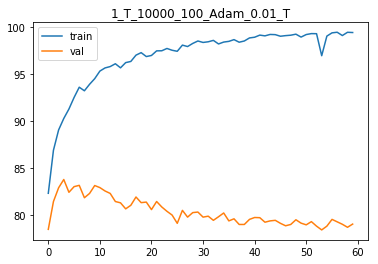

After training for 10 epochs
Train Acc 99.52
Val Acc 79.28
Test Acc 80.444
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 51.64
Epoch: [1/10], Step: [201/625], Validation Acc: 52.66
Epoch: [1/10], Step: [301/625], Validation Acc: 54.02
Epoch: [1/10], Step: [401/625], Validation Acc: 55.38
Epoch: [1/10], Step: [501/625], Validation Acc: 56.46
Epoch: [1/10], Step: [601/625], Validation Acc: 56.96
Epoch: [2/10], Step: [101/625], Validation Acc: 58.12
Epoch: [2/10], Step: [201/625], Validation Acc: 57.7
Epoch: [2/10], Step: [301/625], Validation Acc: 58.3
Epoch: [2/10], Step: [401/625], Validation Acc: 59.36
Epoch: [2/10], Step: [501/625], Validation Acc: 59.18
Epoch: [2/10], Step: [601/625], Validation Acc: 59.8
Epoch: [3/10], Step: [101/625], Validation Acc: 59.58
Epoch: [3/10], Step: [201/625], Validation Acc: 59.86
Epoch: [3/10], Step: [301/625], Validation Ac

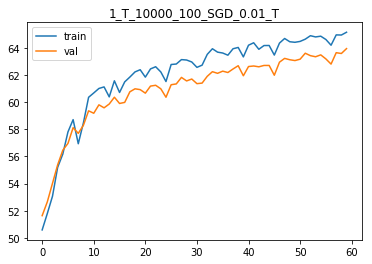

After training for 10 epochs
Train Acc 65.16
Val Acc 63.96
Test Acc 64.536
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.56
Epoch: [1/10], Step: [201/625], Validation Acc: 81.68
Epoch: [1/10], Step: [301/625], Validation Acc: 82.02
Epoch: [1/10], Step: [401/625], Validation Acc: 82.64
Epoch: [1/10], Step: [501/625], Validation Acc: 82.86
Epoch: [1/10], Step: [601/625], Validation Acc: 82.46
Epoch: [2/10], Step: [101/625], Validation Acc: 83.02
Epoch: [2/10], Step: [201/625], Validation Acc: 80.38
Epoch: [2/10], Step: [301/625], Validation Acc: 82.84
Epoch: [2/10], Step: [401/625], Validation Acc: 82.5
Epoch: [2/10], Step: [501/625], Validation Acc: 81.66
Epoch: [2/10], Step: [601/625], Validation Acc: 82.34
Epoch: [3/10], Step: [101/625], Validation Acc: 81.86
Epoch: [3/10], Step: [201/625], Validation Acc: 81.34
Epoch: [3/10], Step: [301/625], Validation

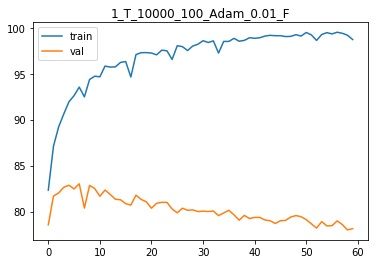

After training for 10 epochs
Train Acc 99.305
Val Acc 78.52
Test Acc 80.196
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.02
Epoch: [1/10], Step: [201/625], Validation Acc: 52.04
Epoch: [1/10], Step: [301/625], Validation Acc: 53.12
Epoch: [1/10], Step: [401/625], Validation Acc: 54.62
Epoch: [1/10], Step: [501/625], Validation Acc: 55.36
Epoch: [1/10], Step: [601/625], Validation Acc: 56.62
Epoch: [2/10], Step: [101/625], Validation Acc: 56.82
Epoch: [2/10], Step: [201/625], Validation Acc: 57.34
Epoch: [2/10], Step: [301/625], Validation Acc: 57.2
Epoch: [2/10], Step: [401/625], Validation Acc: 57.28
Epoch: [2/10], Step: [501/625], Validation Acc: 58.78
Epoch: [2/10], Step: [601/625], Validation Acc: 58.44
Epoch: [3/10], Step: [101/625], Validation Acc: 59.02
Epoch: [3/10], Step: [201/625], Validation Acc: 60.12
Epoch: [3/10], Step: [301/625], Validation

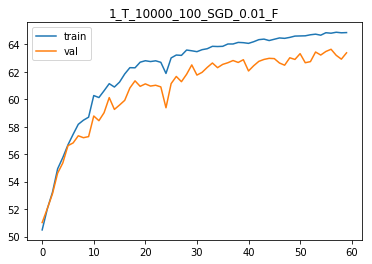

After training for 10 epochs
Train Acc 64.865
Val Acc 63.38
Test Acc 64.456
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 63.76
Epoch: [1/10], Step: [201/625], Validation Acc: 67.48
Epoch: [1/10], Step: [301/625], Validation Acc: 71.44
Epoch: [1/10], Step: [401/625], Validation Acc: 73.54
Epoch: [1/10], Step: [501/625], Validation Acc: 74.14
Epoch: [1/10], Step: [601/625], Validation Acc: 76.36
Epoch: [2/10], Step: [101/625], Validation Acc: 77.94
Epoch: [2/10], Step: [201/625], Validation Acc: 78.62
Epoch: [2/10], Step: [301/625], Validation Acc: 79.36
Epoch: [2/10], Step: [401/625], Validation Acc: 79.96
Epoch: [2/10], Step: [501/625], Validation Acc: 80.26
Epoch: [2/10], Step: [601/625], Validation Acc: 80.7
Epoch: [3/10], Step: [101/625], Validation Acc: 81.08
Epoch: [3/10], Step: [201/625], Validation Acc: 81.56
Epoch: [3/10], Step: [301/625], Validati

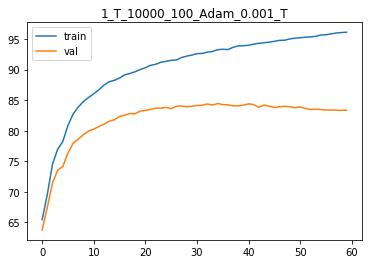

After training for 10 epochs
Train Acc 96.23
Val Acc 83.42
Test Acc 84.96
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.26
Epoch: [1/10], Step: [201/625], Validation Acc: 50.22
Epoch: [1/10], Step: [301/625], Validation Acc: 50.28
Epoch: [1/10], Step: [401/625], Validation Acc: 50.28
Epoch: [1/10], Step: [501/625], Validation Acc: 50.36
Epoch: [1/10], Step: [601/625], Validation Acc: 50.56
Epoch: [2/10], Step: [101/625], Validation Acc: 50.56
Epoch: [2/10], Step: [201/625], Validation Acc: 50.72
Epoch: [2/10], Step: [301/625], Validation Acc: 51.04
Epoch: [2/10], Step: [401/625], Validation Acc: 51.16
Epoch: [2/10], Step: [501/625], Validation Acc: 51.3
Epoch: [2/10], Step: [601/625], Validation Acc: 51.78
Epoch: [3/10], Step: [101/625], Validation Acc: 51.98
Epoch: [3/10], Step: [201/625], Validation Acc: 51.84
Epoch: [3/10], Step: [301/625], Validation 

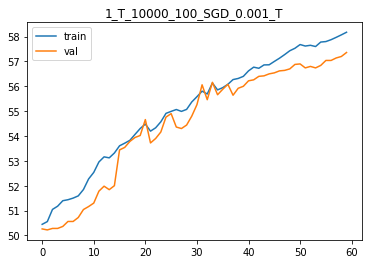

After training for 10 epochs
Train Acc 58.33
Val Acc 57.26
Test Acc 57.74
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 61.42
Epoch: [1/10], Step: [201/625], Validation Acc: 65.92
Epoch: [1/10], Step: [301/625], Validation Acc: 70.34
Epoch: [1/10], Step: [401/625], Validation Acc: 72.94
Epoch: [1/10], Step: [501/625], Validation Acc: 75.42
Epoch: [1/10], Step: [601/625], Validation Acc: 77.2
Epoch: [2/10], Step: [101/625], Validation Acc: 78.9
Epoch: [2/10], Step: [201/625], Validation Acc: 80.04
Epoch: [2/10], Step: [301/625], Validation Acc: 80.12
Epoch: [2/10], Step: [401/625], Validation Acc: 80.78
Epoch: [2/10], Step: [501/625], Validation Acc: 80.96
Epoch: [2/10], Step: [601/625], Validation Acc: 81.56
Epoch: [3/10], Step: [101/625], Validation Acc: 81.66
Epoch: [3/10], Step: [201/625], Validation Acc: 82.36
Epoch: [3/10], Step: [301/625], Validation 

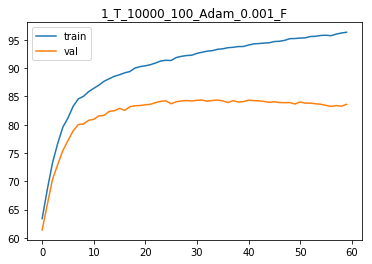

After training for 10 epochs
Train Acc 96.34
Val Acc 83.26
Test Acc 84.604
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.14
Epoch: [1/10], Step: [201/625], Validation Acc: 51.38
Epoch: [1/10], Step: [301/625], Validation Acc: 51.82
Epoch: [1/10], Step: [401/625], Validation Acc: 51.62
Epoch: [1/10], Step: [501/625], Validation Acc: 52.16
Epoch: [1/10], Step: [601/625], Validation Acc: 52.12
Epoch: [2/10], Step: [101/625], Validation Acc: 51.96
Epoch: [2/10], Step: [201/625], Validation Acc: 52.14
Epoch: [2/10], Step: [301/625], Validation Acc: 52.36
Epoch: [2/10], Step: [401/625], Validation Acc: 52.58
Epoch: [2/10], Step: [501/625], Validation Acc: 52.7
Epoch: [2/10], Step: [601/625], Validation Acc: 52.38
Epoch: [3/10], Step: [101/625], Validation Acc: 52.6
Epoch: [3/10], Step: [201/625], Validation Acc: 52.74
Epoch: [3/10], Step: [301/625], Validation 

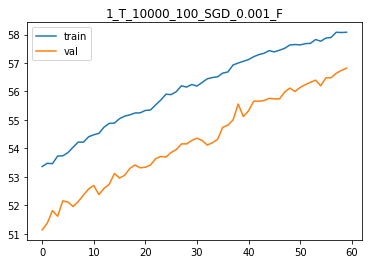

After training for 10 epochs
Train Acc 58.05
Val Acc 56.76
Test Acc 57.748
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 76.6
Epoch: [1/10], Step: [201/625], Validation Acc: 79.52
Epoch: [1/10], Step: [301/625], Validation Acc: 81.62
Epoch: [1/10], Step: [401/625], Validation Acc: 73.22
Epoch: [1/10], Step: [501/625], Validation Acc: 80.58
Epoch: [1/10], Step: [601/625], Validation Acc: 79.38
Epoch: [2/10], Step: [101/625], Validation Acc: 79.44
Epoch: [2/10], Step: [201/625], Validation Acc: 80.52
Epoch: [2/10], Step: [301/625], Validation Acc: 79.46
Epoch: [2/10], Step: [401/625], Validation Acc: 79.4
Epoch: [2/10], Step: [501/625], Validation Acc: 77.7
Epoch: [2/10], Step: [601/625], Validation Acc: 77.16
Epoch: [3/10], Step: [101/625], Validation Acc: 78.72
Epoch: [3/10], Step: [201/625], Validation Acc: 80.54
Epoch: [3/10], Step: [301/625], Validation Ac

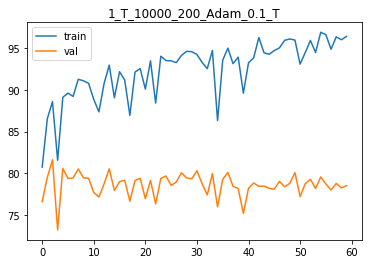

After training for 10 epochs
Train Acc 96.095
Val Acc 78.3
Test Acc 79.748
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 55.76
Epoch: [1/10], Step: [201/625], Validation Acc: 62.76
Epoch: [1/10], Step: [301/625], Validation Acc: 63.7
Epoch: [1/10], Step: [401/625], Validation Acc: 65.5
Epoch: [1/10], Step: [501/625], Validation Acc: 65.54
Epoch: [1/10], Step: [601/625], Validation Acc: 66.02
Epoch: [2/10], Step: [101/625], Validation Acc: 66.44
Epoch: [2/10], Step: [201/625], Validation Acc: 66.86
Epoch: [2/10], Step: [301/625], Validation Acc: 67.08
Epoch: [2/10], Step: [401/625], Validation Acc: 66.9
Epoch: [2/10], Step: [501/625], Validation Acc: 67.38
Epoch: [2/10], Step: [601/625], Validation Acc: 67.72
Epoch: [3/10], Step: [101/625], Validation Acc: 67.94
Epoch: [3/10], Step: [201/625], Validation Acc: 66.34
Epoch: [3/10], Step: [301/625], Validation Acc

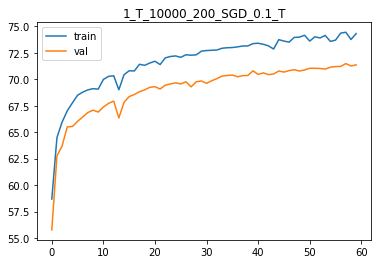

After training for 10 epochs
Train Acc 74.535
Val Acc 71.44
Test Acc 73.132
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.26
Epoch: [1/10], Step: [201/625], Validation Acc: 80.78
Epoch: [1/10], Step: [301/625], Validation Acc: 78.86
Epoch: [1/10], Step: [401/625], Validation Acc: 80.3
Epoch: [1/10], Step: [501/625], Validation Acc: 80.86
Epoch: [1/10], Step: [601/625], Validation Acc: 78.14
Epoch: [2/10], Step: [101/625], Validation Acc: 81.34
Epoch: [2/10], Step: [201/625], Validation Acc: 79.24
Epoch: [2/10], Step: [301/625], Validation Acc: 79.14
Epoch: [2/10], Step: [401/625], Validation Acc: 77.54
Epoch: [2/10], Step: [501/625], Validation Acc: 76.86
Epoch: [2/10], Step: [601/625], Validation Acc: 77.18
Epoch: [3/10], Step: [101/625], Validation Acc: 80.34
Epoch: [3/10], Step: [201/625], Validation Acc: 77.72
Epoch: [3/10], Step: [301/625], Validation

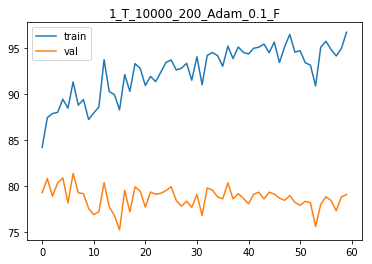

After training for 10 epochs
Train Acc 94.72
Val Acc 77.34
Test Acc 79.332
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 61.06
Epoch: [1/10], Step: [201/625], Validation Acc: 60.36
Epoch: [1/10], Step: [301/625], Validation Acc: 65.28
Epoch: [1/10], Step: [401/625], Validation Acc: 63.18
Epoch: [1/10], Step: [501/625], Validation Acc: 65.44
Epoch: [1/10], Step: [601/625], Validation Acc: 65.9
Epoch: [2/10], Step: [101/625], Validation Acc: 65.88
Epoch: [2/10], Step: [201/625], Validation Acc: 65.84
Epoch: [2/10], Step: [301/625], Validation Acc: 66.28
Epoch: [2/10], Step: [401/625], Validation Acc: 66.5
Epoch: [2/10], Step: [501/625], Validation Acc: 66.8
Epoch: [2/10], Step: [601/625], Validation Acc: 66.38
Epoch: [3/10], Step: [101/625], Validation Acc: 66.76
Epoch: [3/10], Step: [201/625], Validation Acc: 67.0
Epoch: [3/10], Step: [301/625], Validation Acc:

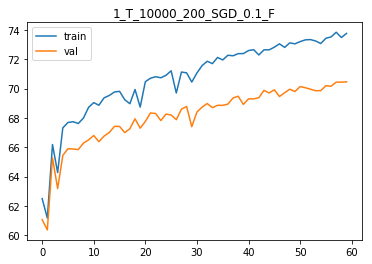

After training for 10 epochs
Train Acc 73.695
Val Acc 70.54
Test Acc 72.64
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.8
Epoch: [1/10], Step: [201/625], Validation Acc: 81.54
Epoch: [1/10], Step: [301/625], Validation Acc: 82.18
Epoch: [1/10], Step: [401/625], Validation Acc: 82.88
Epoch: [1/10], Step: [501/625], Validation Acc: 82.3
Epoch: [1/10], Step: [601/625], Validation Acc: 83.62
Epoch: [2/10], Step: [101/625], Validation Acc: 82.74
Epoch: [2/10], Step: [201/625], Validation Acc: 82.72
Epoch: [2/10], Step: [301/625], Validation Acc: 82.7
Epoch: [2/10], Step: [401/625], Validation Acc: 81.22
Epoch: [2/10], Step: [501/625], Validation Acc: 80.74
Epoch: [2/10], Step: [601/625], Validation Acc: 82.38
Epoch: [3/10], Step: [101/625], Validation Acc: 82.24
Epoch: [3/10], Step: [201/625], Validation Acc: 81.34
Epoch: [3/10], Step: [301/625], Validation A

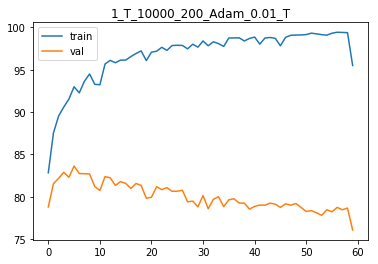

After training for 10 epochs
Train Acc 99.155
Val Acc 78.98
Test Acc 80.284
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 54.42
Epoch: [1/10], Step: [201/625], Validation Acc: 56.74
Epoch: [1/10], Step: [301/625], Validation Acc: 57.46
Epoch: [1/10], Step: [401/625], Validation Acc: 59.86
Epoch: [1/10], Step: [501/625], Validation Acc: 61.0
Epoch: [1/10], Step: [601/625], Validation Acc: 61.68
Epoch: [2/10], Step: [101/625], Validation Acc: 60.5
Epoch: [2/10], Step: [201/625], Validation Acc: 62.48
Epoch: [2/10], Step: [301/625], Validation Acc: 62.28
Epoch: [2/10], Step: [401/625], Validation Acc: 62.5
Epoch: [2/10], Step: [501/625], Validation Acc: 62.86
Epoch: [2/10], Step: [601/625], Validation Acc: 63.04
Epoch: [3/10], Step: [101/625], Validation Acc: 62.96
Epoch: [3/10], Step: [201/625], Validation Acc: 62.76
Epoch: [3/10], Step: [301/625], Validation A

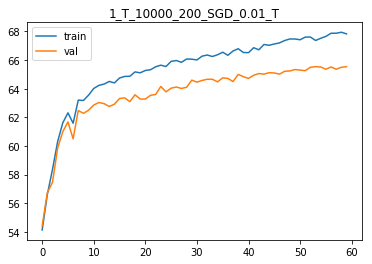

After training for 10 epochs
Train Acc 67.845
Val Acc 65.66
Test Acc 67.236
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.18
Epoch: [1/10], Step: [201/625], Validation Acc: 81.08
Epoch: [1/10], Step: [301/625], Validation Acc: 82.76
Epoch: [1/10], Step: [401/625], Validation Acc: 81.32
Epoch: [1/10], Step: [501/625], Validation Acc: 83.48
Epoch: [1/10], Step: [601/625], Validation Acc: 83.18
Epoch: [2/10], Step: [101/625], Validation Acc: 82.28
Epoch: [2/10], Step: [201/625], Validation Acc: 82.54
Epoch: [2/10], Step: [301/625], Validation Acc: 82.72
Epoch: [2/10], Step: [401/625], Validation Acc: 82.3
Epoch: [2/10], Step: [501/625], Validation Acc: 81.76
Epoch: [2/10], Step: [601/625], Validation Acc: 82.18
Epoch: [3/10], Step: [101/625], Validation Acc: 81.92
Epoch: [3/10], Step: [201/625], Validation Acc: 81.68
Epoch: [3/10], Step: [301/625], Validatio

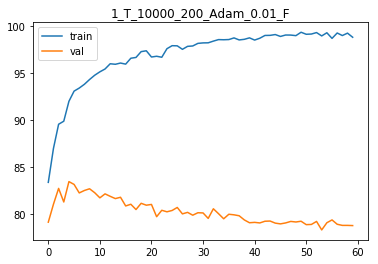

After training for 10 epochs
Train Acc 99.25
Val Acc 79.0
Test Acc 80.2
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 53.28
Epoch: [1/10], Step: [201/625], Validation Acc: 54.66
Epoch: [1/10], Step: [301/625], Validation Acc: 55.56
Epoch: [1/10], Step: [401/625], Validation Acc: 56.86
Epoch: [1/10], Step: [501/625], Validation Acc: 58.04
Epoch: [1/10], Step: [601/625], Validation Acc: 58.76
Epoch: [2/10], Step: [101/625], Validation Acc: 59.76
Epoch: [2/10], Step: [201/625], Validation Acc: 59.52
Epoch: [2/10], Step: [301/625], Validation Acc: 59.94
Epoch: [2/10], Step: [401/625], Validation Acc: 60.86
Epoch: [2/10], Step: [501/625], Validation Acc: 60.88
Epoch: [2/10], Step: [601/625], Validation Acc: 61.26
Epoch: [3/10], Step: [101/625], Validation Acc: 61.14
Epoch: [3/10], Step: [201/625], Validation Acc: 61.68
Epoch: [3/10], Step: [301/625], Validation Ac

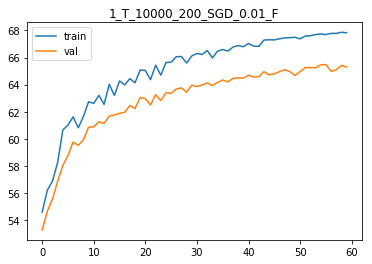

After training for 10 epochs
Train Acc 67.84
Val Acc 65.16
Test Acc 67.312
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 64.0
Epoch: [1/10], Step: [201/625], Validation Acc: 70.04
Epoch: [1/10], Step: [301/625], Validation Acc: 73.72
Epoch: [1/10], Step: [401/625], Validation Acc: 76.0
Epoch: [1/10], Step: [501/625], Validation Acc: 76.16
Epoch: [1/10], Step: [601/625], Validation Acc: 78.18
Epoch: [2/10], Step: [101/625], Validation Acc: 79.74
Epoch: [2/10], Step: [201/625], Validation Acc: 79.92
Epoch: [2/10], Step: [301/625], Validation Acc: 80.7
Epoch: [2/10], Step: [401/625], Validation Acc: 81.34
Epoch: [2/10], Step: [501/625], Validation Acc: 81.88
Epoch: [2/10], Step: [601/625], Validation Acc: 82.42
Epoch: [3/10], Step: [101/625], Validation Acc: 83.12
Epoch: [3/10], Step: [201/625], Validation Acc: 83.22
Epoch: [3/10], Step: [301/625], Validation 

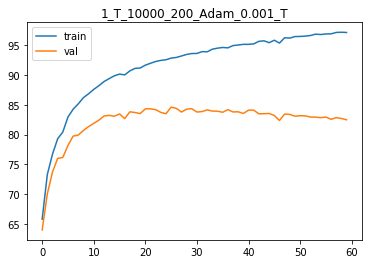

After training for 10 epochs
Train Acc 97.35
Val Acc 82.94
Test Acc 84.092
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 49.24
Epoch: [1/10], Step: [201/625], Validation Acc: 49.1
Epoch: [1/10], Step: [301/625], Validation Acc: 49.56
Epoch: [1/10], Step: [401/625], Validation Acc: 50.06
Epoch: [1/10], Step: [501/625], Validation Acc: 50.2
Epoch: [1/10], Step: [601/625], Validation Acc: 50.5
Epoch: [2/10], Step: [101/625], Validation Acc: 51.18
Epoch: [2/10], Step: [201/625], Validation Acc: 51.34
Epoch: [2/10], Step: [301/625], Validation Acc: 51.46
Epoch: [2/10], Step: [401/625], Validation Acc: 51.44
Epoch: [2/10], Step: [501/625], Validation Acc: 51.7
Epoch: [2/10], Step: [601/625], Validation Acc: 51.86
Epoch: [3/10], Step: [101/625], Validation Acc: 52.1
Epoch: [3/10], Step: [201/625], Validation Acc: 52.08
Epoch: [3/10], Step: [301/625], Validation Acc

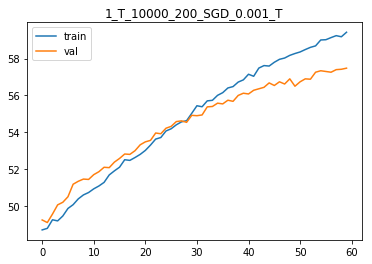

After training for 10 epochs
Train Acc 59.35
Val Acc 57.48
Test Acc 58.808
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.86
Epoch: [1/10], Step: [201/625], Validation Acc: 68.46
Epoch: [1/10], Step: [301/625], Validation Acc: 72.44
Epoch: [1/10], Step: [401/625], Validation Acc: 74.96
Epoch: [1/10], Step: [501/625], Validation Acc: 76.38
Epoch: [1/10], Step: [601/625], Validation Acc: 78.18
Epoch: [2/10], Step: [101/625], Validation Acc: 79.54
Epoch: [2/10], Step: [201/625], Validation Acc: 79.9
Epoch: [2/10], Step: [301/625], Validation Acc: 80.6
Epoch: [2/10], Step: [401/625], Validation Acc: 81.22
Epoch: [2/10], Step: [501/625], Validation Acc: 81.98
Epoch: [2/10], Step: [601/625], Validation Acc: 82.56
Epoch: [3/10], Step: [101/625], Validation Acc: 83.06
Epoch: [3/10], Step: [201/625], Validation Acc: 83.24
Epoch: [3/10], Step: [301/625], Validation

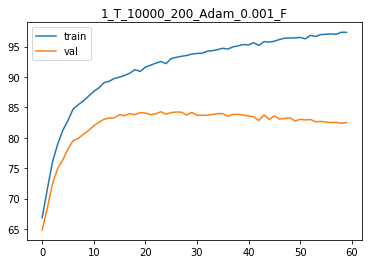

After training for 10 epochs
Train Acc 97.42
Val Acc 82.56
Test Acc 84.08
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.06
Epoch: [1/10], Step: [201/625], Validation Acc: 50.94
Epoch: [1/10], Step: [301/625], Validation Acc: 51.12
Epoch: [1/10], Step: [401/625], Validation Acc: 51.36
Epoch: [1/10], Step: [501/625], Validation Acc: 51.5
Epoch: [1/10], Step: [601/625], Validation Acc: 51.54
Epoch: [2/10], Step: [101/625], Validation Acc: 51.62
Epoch: [2/10], Step: [201/625], Validation Acc: 51.74
Epoch: [2/10], Step: [301/625], Validation Acc: 51.74
Epoch: [2/10], Step: [401/625], Validation Acc: 51.84
Epoch: [2/10], Step: [501/625], Validation Acc: 51.96
Epoch: [2/10], Step: [601/625], Validation Acc: 52.2
Epoch: [3/10], Step: [101/625], Validation Acc: 52.16
Epoch: [3/10], Step: [201/625], Validation Acc: 52.76
Epoch: [3/10], Step: [301/625], Validation A

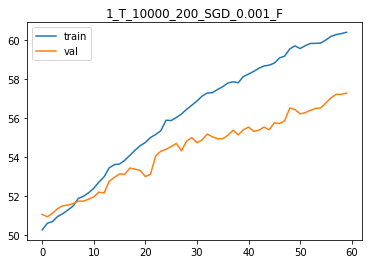

After training for 10 epochs
Train Acc 60.405
Val Acc 57.32
Test Acc 59.44
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.44
Epoch: [1/10], Step: [201/625], Validation Acc: 69.84
Epoch: [1/10], Step: [301/625], Validation Acc: 78.84
Epoch: [1/10], Step: [401/625], Validation Acc: 80.48
Epoch: [1/10], Step: [501/625], Validation Acc: 78.6
Epoch: [1/10], Step: [601/625], Validation Acc: 78.28
Epoch: [2/10], Step: [101/625], Validation Acc: 79.96
Epoch: [2/10], Step: [201/625], Validation Acc: 78.36
Epoch: [2/10], Step: [301/625], Validation Acc: 75.78
Epoch: [2/10], Step: [401/625], Validation Acc: 77.78
Epoch: [2/10], Step: [501/625], Validation Acc: 78.34
Epoch: [2/10], Step: [601/625], Validation Acc: 77.56
Epoch: [3/10], Step: [101/625], Validation Acc: 79.72
Epoch: [3/10], Step: [201/625], Validation Acc: 79.5
Epoch: [3/10], Step: [301/625], Validation A

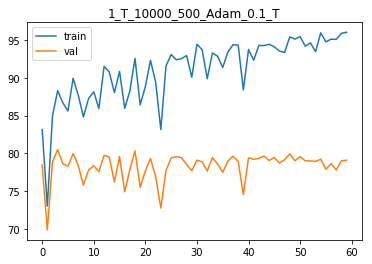

After training for 10 epochs
Train Acc 95.785
Val Acc 78.98
Test Acc 80.9
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 61.1
Epoch: [1/10], Step: [201/625], Validation Acc: 65.18
Epoch: [1/10], Step: [301/625], Validation Acc: 66.28
Epoch: [1/10], Step: [401/625], Validation Acc: 67.48
Epoch: [1/10], Step: [501/625], Validation Acc: 68.94
Epoch: [1/10], Step: [601/625], Validation Acc: 67.38
Epoch: [2/10], Step: [101/625], Validation Acc: 69.32
Epoch: [2/10], Step: [201/625], Validation Acc: 70.34
Epoch: [2/10], Step: [301/625], Validation Acc: 71.18
Epoch: [2/10], Step: [401/625], Validation Acc: 70.18
Epoch: [2/10], Step: [501/625], Validation Acc: 69.28
Epoch: [2/10], Step: [601/625], Validation Acc: 71.1
Epoch: [3/10], Step: [101/625], Validation Acc: 70.32
Epoch: [3/10], Step: [201/625], Validation Acc: 71.78
Epoch: [3/10], Step: [301/625], Validation Acc

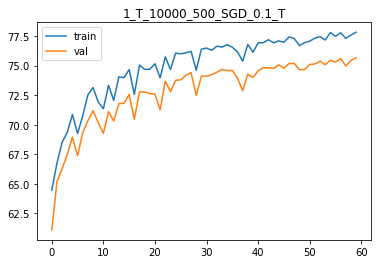

After training for 10 epochs
Train Acc 77.65
Val Acc 75.44
Test Acc 77.312
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.24
Epoch: [1/10], Step: [201/625], Validation Acc: 70.82
Epoch: [1/10], Step: [301/625], Validation Acc: 76.74
Epoch: [1/10], Step: [401/625], Validation Acc: 66.24
Epoch: [1/10], Step: [501/625], Validation Acc: 70.86
Epoch: [1/10], Step: [601/625], Validation Acc: 80.1
Epoch: [2/10], Step: [101/625], Validation Acc: 74.12
Epoch: [2/10], Step: [201/625], Validation Acc: 77.6
Epoch: [2/10], Step: [301/625], Validation Acc: 76.92
Epoch: [2/10], Step: [401/625], Validation Acc: 81.04
Epoch: [2/10], Step: [501/625], Validation Acc: 80.06
Epoch: [2/10], Step: [601/625], Validation Acc: 79.72
Epoch: [3/10], Step: [101/625], Validation Acc: 77.98
Epoch: [3/10], Step: [201/625], Validation Acc: 79.08
Epoch: [3/10], Step: [301/625], Validation A

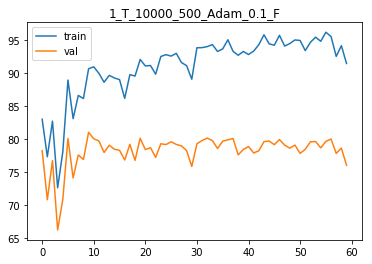

After training for 10 epochs
Train Acc 94.21
Val Acc 79.1
Test Acc 80.432
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 58.58
Epoch: [1/10], Step: [201/625], Validation Acc: 65.3
Epoch: [1/10], Step: [301/625], Validation Acc: 66.28
Epoch: [1/10], Step: [401/625], Validation Acc: 68.1
Epoch: [1/10], Step: [501/625], Validation Acc: 68.7
Epoch: [1/10], Step: [601/625], Validation Acc: 69.2
Epoch: [2/10], Step: [101/625], Validation Acc: 69.7
Epoch: [2/10], Step: [201/625], Validation Acc: 70.56
Epoch: [2/10], Step: [301/625], Validation Acc: 70.82
Epoch: [2/10], Step: [401/625], Validation Acc: 71.12
Epoch: [2/10], Step: [501/625], Validation Acc: 70.72
Epoch: [2/10], Step: [601/625], Validation Acc: 71.94
Epoch: [3/10], Step: [101/625], Validation Acc: 71.84
Epoch: [3/10], Step: [201/625], Validation Acc: 72.02
Epoch: [3/10], Step: [301/625], Validation Acc: 7

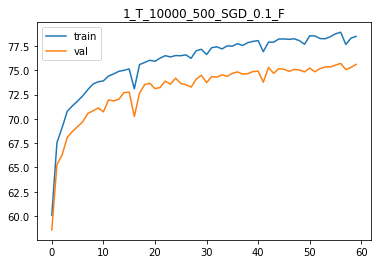

After training for 10 epochs
Train Acc 78.84
Val Acc 75.68
Test Acc 77.284
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 69.28
Epoch: [1/10], Step: [201/625], Validation Acc: 80.48
Epoch: [1/10], Step: [301/625], Validation Acc: 82.84
Epoch: [1/10], Step: [401/625], Validation Acc: 81.86
Epoch: [1/10], Step: [501/625], Validation Acc: 82.7
Epoch: [1/10], Step: [601/625], Validation Acc: 83.16
Epoch: [2/10], Step: [101/625], Validation Acc: 82.74
Epoch: [2/10], Step: [201/625], Validation Acc: 83.02
Epoch: [2/10], Step: [301/625], Validation Acc: 81.98
Epoch: [2/10], Step: [401/625], Validation Acc: 82.42
Epoch: [2/10], Step: [501/625], Validation Acc: 81.28
Epoch: [2/10], Step: [601/625], Validation Acc: 81.98
Epoch: [3/10], Step: [101/625], Validation Acc: 81.6
Epoch: [3/10], Step: [201/625], Validation Acc: 81.7
Epoch: [3/10], Step: [301/625], Validation A

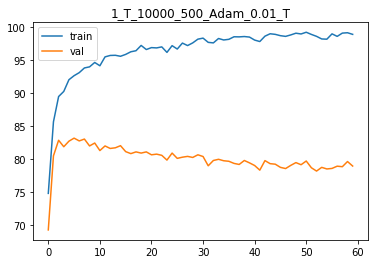

After training for 10 epochs
Train Acc 99.04
Val Acc 79.26
Test Acc 80.616
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 56.64
Epoch: [1/10], Step: [201/625], Validation Acc: 60.28
Epoch: [1/10], Step: [301/625], Validation Acc: 58.86
Epoch: [1/10], Step: [401/625], Validation Acc: 62.72
Epoch: [1/10], Step: [501/625], Validation Acc: 62.94
Epoch: [1/10], Step: [601/625], Validation Acc: 63.86
Epoch: [2/10], Step: [101/625], Validation Acc: 63.98
Epoch: [2/10], Step: [201/625], Validation Acc: 62.26
Epoch: [2/10], Step: [301/625], Validation Acc: 63.04
Epoch: [2/10], Step: [401/625], Validation Acc: 64.44
Epoch: [2/10], Step: [501/625], Validation Acc: 63.98
Epoch: [2/10], Step: [601/625], Validation Acc: 64.66
Epoch: [3/10], Step: [101/625], Validation Acc: 64.64
Epoch: [3/10], Step: [201/625], Validation Acc: 64.56
Epoch: [3/10], Step: [301/625], Validation

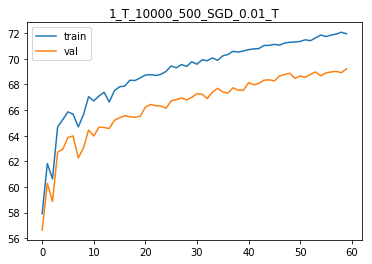

After training for 10 epochs
Train Acc 72.11
Val Acc 69.2
Test Acc 71.236
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.64
Epoch: [1/10], Step: [201/625], Validation Acc: 81.78
Epoch: [1/10], Step: [301/625], Validation Acc: 82.14
Epoch: [1/10], Step: [401/625], Validation Acc: 82.36
Epoch: [1/10], Step: [501/625], Validation Acc: 81.32
Epoch: [1/10], Step: [601/625], Validation Acc: 82.96
Epoch: [2/10], Step: [101/625], Validation Acc: 82.96
Epoch: [2/10], Step: [201/625], Validation Acc: 81.7
Epoch: [2/10], Step: [301/625], Validation Acc: 81.04
Epoch: [2/10], Step: [401/625], Validation Acc: 81.8
Epoch: [2/10], Step: [501/625], Validation Acc: 81.48
Epoch: [2/10], Step: [601/625], Validation Acc: 81.86
Epoch: [3/10], Step: [101/625], Validation Acc: 82.36
Epoch: [3/10], Step: [201/625], Validation Acc: 81.06
Epoch: [3/10], Step: [301/625], Validation A

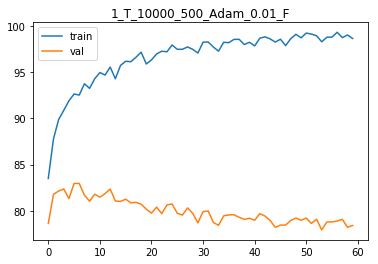

After training for 10 epochs
Train Acc 98.855
Val Acc 78.38
Test Acc 79.856
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 57.46
Epoch: [1/10], Step: [201/625], Validation Acc: 59.9
Epoch: [1/10], Step: [301/625], Validation Acc: 59.88
Epoch: [1/10], Step: [401/625], Validation Acc: 62.48
Epoch: [1/10], Step: [501/625], Validation Acc: 63.26
Epoch: [1/10], Step: [601/625], Validation Acc: 63.7
Epoch: [2/10], Step: [101/625], Validation Acc: 64.1
Epoch: [2/10], Step: [201/625], Validation Acc: 64.56
Epoch: [2/10], Step: [301/625], Validation Acc: 64.16
Epoch: [2/10], Step: [401/625], Validation Acc: 64.76
Epoch: [2/10], Step: [501/625], Validation Acc: 64.38
Epoch: [2/10], Step: [601/625], Validation Acc: 65.34
Epoch: [3/10], Step: [101/625], Validation Acc: 65.78
Epoch: [3/10], Step: [201/625], Validation Acc: 65.22
Epoch: [3/10], Step: [301/625], Validation A

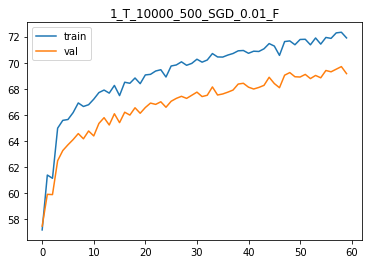

After training for 10 epochs
Train Acc 72.18
Val Acc 69.68
Test Acc 71.796
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 66.64
Epoch: [1/10], Step: [201/625], Validation Acc: 71.22
Epoch: [1/10], Step: [301/625], Validation Acc: 75.02
Epoch: [1/10], Step: [401/625], Validation Acc: 77.84
Epoch: [1/10], Step: [501/625], Validation Acc: 79.06
Epoch: [1/10], Step: [601/625], Validation Acc: 80.04
Epoch: [2/10], Step: [101/625], Validation Acc: 80.82
Epoch: [2/10], Step: [201/625], Validation Acc: 81.7
Epoch: [2/10], Step: [301/625], Validation Acc: 82.76
Epoch: [2/10], Step: [401/625], Validation Acc: 82.94
Epoch: [2/10], Step: [501/625], Validation Acc: 82.56
Epoch: [2/10], Step: [601/625], Validation Acc: 83.38
Epoch: [3/10], Step: [101/625], Validation Acc: 83.78
Epoch: [3/10], Step: [201/625], Validation Acc: 83.78
Epoch: [3/10], Step: [301/625], Validatio

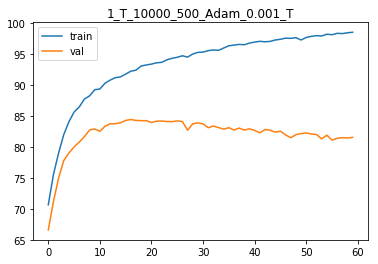

After training for 10 epochs
Train Acc 98.555
Val Acc 81.6
Test Acc 83.164
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 48.02
Epoch: [1/10], Step: [201/625], Validation Acc: 48.64
Epoch: [1/10], Step: [301/625], Validation Acc: 48.94
Epoch: [1/10], Step: [401/625], Validation Acc: 49.36
Epoch: [1/10], Step: [501/625], Validation Acc: 49.94
Epoch: [1/10], Step: [601/625], Validation Acc: 50.48
Epoch: [2/10], Step: [101/625], Validation Acc: 51.84
Epoch: [2/10], Step: [201/625], Validation Acc: 52.08
Epoch: [2/10], Step: [301/625], Validation Acc: 52.68
Epoch: [2/10], Step: [401/625], Validation Acc: 53.08
Epoch: [2/10], Step: [501/625], Validation Acc: 53.8
Epoch: [2/10], Step: [601/625], Validation Acc: 53.42
Epoch: [3/10], Step: [101/625], Validation Acc: 53.9
Epoch: [3/10], Step: [201/625], Validation Acc: 54.04
Epoch: [3/10], Step: [301/625], Validation 

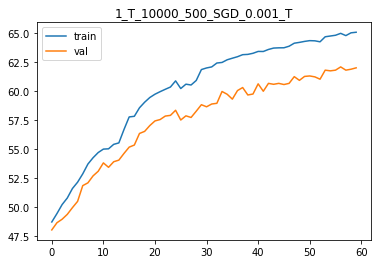

After training for 10 epochs
Train Acc 65.135
Val Acc 62.12
Test Acc 64.14
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 66.3
Epoch: [1/10], Step: [201/625], Validation Acc: 72.58
Epoch: [1/10], Step: [301/625], Validation Acc: 75.74
Epoch: [1/10], Step: [401/625], Validation Acc: 77.18
Epoch: [1/10], Step: [501/625], Validation Acc: 79.06
Epoch: [1/10], Step: [601/625], Validation Acc: 80.32
Epoch: [2/10], Step: [101/625], Validation Acc: 81.48
Epoch: [2/10], Step: [201/625], Validation Acc: 81.92
Epoch: [2/10], Step: [301/625], Validation Acc: 82.42
Epoch: [2/10], Step: [401/625], Validation Acc: 83.12
Epoch: [2/10], Step: [501/625], Validation Acc: 83.26
Epoch: [2/10], Step: [601/625], Validation Acc: 83.4
Epoch: [3/10], Step: [101/625], Validation Acc: 83.74
Epoch: [3/10], Step: [201/625], Validation Acc: 84.06
Epoch: [3/10], Step: [301/625], Validation

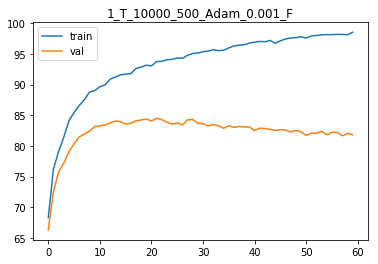

After training for 10 epochs
Train Acc 98.425
Val Acc 81.92
Test Acc 83.232
ngram:  1
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.8
Epoch: [1/10], Step: [201/625], Validation Acc: 51.64
Epoch: [1/10], Step: [301/625], Validation Acc: 52.86
Epoch: [1/10], Step: [401/625], Validation Acc: 53.6
Epoch: [1/10], Step: [501/625], Validation Acc: 54.0
Epoch: [1/10], Step: [601/625], Validation Acc: 54.3
Epoch: [2/10], Step: [101/625], Validation Acc: 54.54
Epoch: [2/10], Step: [201/625], Validation Acc: 56.0
Epoch: [2/10], Step: [301/625], Validation Acc: 56.74
Epoch: [2/10], Step: [401/625], Validation Acc: 56.42
Epoch: [2/10], Step: [501/625], Validation Acc: 57.02
Epoch: [2/10], Step: [601/625], Validation Acc: 56.94
Epoch: [3/10], Step: [101/625], Validation Acc: 57.32
Epoch: [3/10], Step: [201/625], Validation Acc: 58.6
Epoch: [3/10], Step: [301/625], Validation Acc

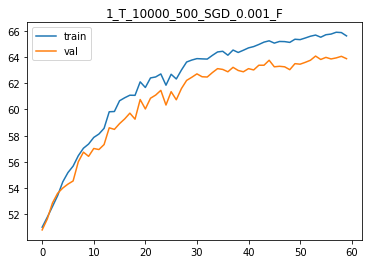

After training for 10 epochs
Train Acc 65.755
Val Acc 64.08
Test Acc 65.212
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 75.22
Epoch: [1/10], Step: [201/625], Validation Acc: 79.08
Epoch: [1/10], Step: [301/625], Validation Acc: 80.86
Epoch: [1/10], Step: [401/625], Validation Acc: 80.88
Epoch: [1/10], Step: [501/625], Validation Acc: 81.98
Epoch: [1/10], Step: [601/625], Validation Acc: 81.94
Epoch: [2/10], Step: [101/625], Validation Acc: 81.1
Epoch: [2/10], Step: [201/625], Validation Acc: 81.14
Epoch: [2/10], Step: [301/625], Validation Acc: 79.74
Epoch: [2/10], Step: [401/625], Validation Acc: 78.08
Epoch: [2/10], Step: [501/625], Validation Acc: 79.32
Epoch: [2/10], Step: [601/625], Validation Acc: 79.2
Epoch: [3/10], Step: [101/625], Validation Acc: 79.92
Epoch: [3/10], Step: [201/625], Validation Acc: 75.3
Epoch: [3/10], Step: [301/625], Validation A

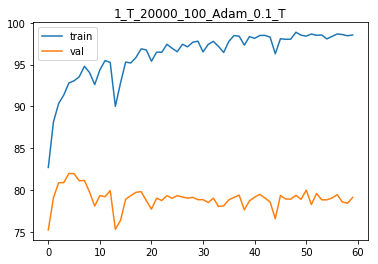

After training for 10 epochs
Train Acc 98.725
Val Acc 79.04
Test Acc 80.58
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 57.14
Epoch: [1/10], Step: [201/625], Validation Acc: 60.98
Epoch: [1/10], Step: [301/625], Validation Acc: 62.04
Epoch: [1/10], Step: [401/625], Validation Acc: 62.24
Epoch: [1/10], Step: [501/625], Validation Acc: 62.54
Epoch: [1/10], Step: [601/625], Validation Acc: 63.12
Epoch: [2/10], Step: [101/625], Validation Acc: 63.54
Epoch: [2/10], Step: [201/625], Validation Acc: 64.02
Epoch: [2/10], Step: [301/625], Validation Acc: 63.04
Epoch: [2/10], Step: [401/625], Validation Acc: 64.28
Epoch: [2/10], Step: [501/625], Validation Acc: 63.84
Epoch: [2/10], Step: [601/625], Validation Acc: 64.7
Epoch: [3/10], Step: [101/625], Validation Acc: 64.92
Epoch: [3/10], Step: [201/625], Validation Acc: 64.68
Epoch: [3/10], Step: [301/625], Validation A

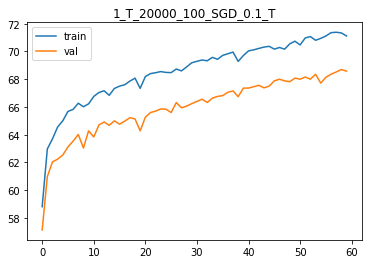

After training for 10 epochs
Train Acc 71.47
Val Acc 68.52
Test Acc 70.024
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 75.0
Epoch: [1/10], Step: [201/625], Validation Acc: 79.56
Epoch: [1/10], Step: [301/625], Validation Acc: 81.12
Epoch: [1/10], Step: [401/625], Validation Acc: 80.56
Epoch: [1/10], Step: [501/625], Validation Acc: 77.5
Epoch: [1/10], Step: [601/625], Validation Acc: 82.58
Epoch: [2/10], Step: [101/625], Validation Acc: 81.26
Epoch: [2/10], Step: [201/625], Validation Acc: 79.9
Epoch: [2/10], Step: [301/625], Validation Acc: 81.3
Epoch: [2/10], Step: [401/625], Validation Acc: 79.14
Epoch: [2/10], Step: [501/625], Validation Acc: 79.58
Epoch: [2/10], Step: [601/625], Validation Acc: 79.7
Epoch: [3/10], Step: [101/625], Validation Acc: 80.22
Epoch: [3/10], Step: [201/625], Validation Acc: 79.42
Epoch: [3/10], Step: [301/625], Validation Acc:

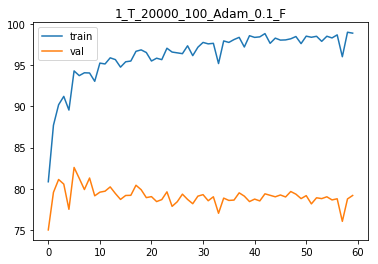

After training for 10 epochs
Train Acc 98.83
Val Acc 78.12
Test Acc 80.2
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 56.02
Epoch: [1/10], Step: [201/625], Validation Acc: 57.82
Epoch: [1/10], Step: [301/625], Validation Acc: 57.76
Epoch: [1/10], Step: [401/625], Validation Acc: 60.9
Epoch: [1/10], Step: [501/625], Validation Acc: 61.54
Epoch: [1/10], Step: [601/625], Validation Acc: 60.08
Epoch: [2/10], Step: [101/625], Validation Acc: 62.36
Epoch: [2/10], Step: [201/625], Validation Acc: 62.8
Epoch: [2/10], Step: [301/625], Validation Acc: 62.6
Epoch: [2/10], Step: [401/625], Validation Acc: 63.04
Epoch: [2/10], Step: [501/625], Validation Acc: 63.1
Epoch: [2/10], Step: [601/625], Validation Acc: 63.4
Epoch: [3/10], Step: [101/625], Validation Acc: 63.32
Epoch: [3/10], Step: [201/625], Validation Acc: 63.56
Epoch: [3/10], Step: [301/625], Validation Acc: 63

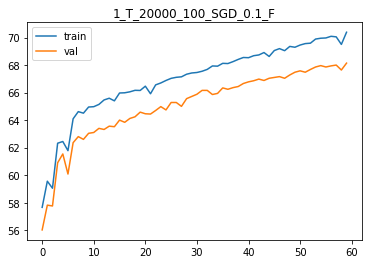

After training for 10 epochs
Train Acc 70.055
Val Acc 68.22
Test Acc 69.508
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 74.68
Epoch: [1/10], Step: [201/625], Validation Acc: 81.06
Epoch: [1/10], Step: [301/625], Validation Acc: 81.86
Epoch: [1/10], Step: [401/625], Validation Acc: 83.12
Epoch: [1/10], Step: [501/625], Validation Acc: 82.28
Epoch: [1/10], Step: [601/625], Validation Acc: 83.42
Epoch: [2/10], Step: [101/625], Validation Acc: 83.48
Epoch: [2/10], Step: [201/625], Validation Acc: 81.86
Epoch: [2/10], Step: [301/625], Validation Acc: 80.86
Epoch: [2/10], Step: [401/625], Validation Acc: 82.32
Epoch: [2/10], Step: [501/625], Validation Acc: 82.8
Epoch: [2/10], Step: [601/625], Validation Acc: 82.38
Epoch: [3/10], Step: [101/625], Validation Acc: 81.44
Epoch: [3/10], Step: [201/625], Validation Acc: 81.92
Epoch: [3/10], Step: [301/625], Validatio

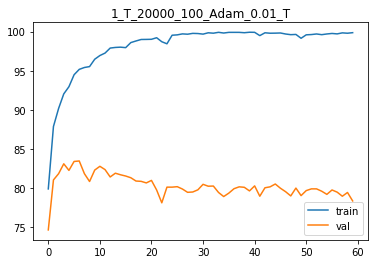

After training for 10 epochs
Train Acc 99.935
Val Acc 78.78
Test Acc 80.324
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.82
Epoch: [1/10], Step: [201/625], Validation Acc: 51.72
Epoch: [1/10], Step: [301/625], Validation Acc: 52.48
Epoch: [1/10], Step: [401/625], Validation Acc: 54.12
Epoch: [1/10], Step: [501/625], Validation Acc: 54.96
Epoch: [1/10], Step: [601/625], Validation Acc: 56.38
Epoch: [2/10], Step: [101/625], Validation Acc: 56.92
Epoch: [2/10], Step: [201/625], Validation Acc: 57.84
Epoch: [2/10], Step: [301/625], Validation Acc: 58.32
Epoch: [2/10], Step: [401/625], Validation Acc: 58.66
Epoch: [2/10], Step: [501/625], Validation Acc: 59.3
Epoch: [2/10], Step: [601/625], Validation Acc: 58.52
Epoch: [3/10], Step: [101/625], Validation Acc: 59.24
Epoch: [3/10], Step: [201/625], Validation Acc: 59.5
Epoch: [3/10], Step: [301/625], Validation 

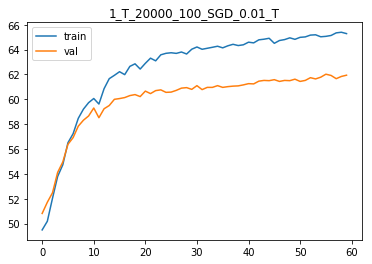

After training for 10 epochs
Train Acc 65.39
Val Acc 61.78
Test Acc 64.332
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.56
Epoch: [1/10], Step: [201/625], Validation Acc: 80.32
Epoch: [1/10], Step: [301/625], Validation Acc: 82.54
Epoch: [1/10], Step: [401/625], Validation Acc: 83.44
Epoch: [1/10], Step: [501/625], Validation Acc: 83.56
Epoch: [1/10], Step: [601/625], Validation Acc: 83.46
Epoch: [2/10], Step: [101/625], Validation Acc: 83.74
Epoch: [2/10], Step: [201/625], Validation Acc: 82.56
Epoch: [2/10], Step: [301/625], Validation Acc: 82.58
Epoch: [2/10], Step: [401/625], Validation Acc: 82.52
Epoch: [2/10], Step: [501/625], Validation Acc: 80.52
Epoch: [2/10], Step: [601/625], Validation Acc: 81.96
Epoch: [3/10], Step: [101/625], Validation Acc: 82.74
Epoch: [3/10], Step: [201/625], Validation Acc: 81.78
Epoch: [3/10], Step: [301/625], Validatio

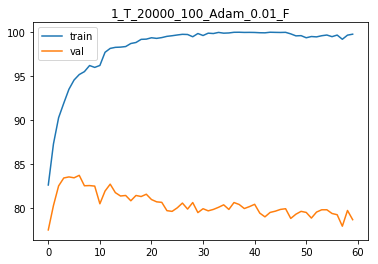

After training for 10 epochs
Train Acc 99.285
Val Acc 78.22
Test Acc 79.796
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 52.94
Epoch: [1/10], Step: [201/625], Validation Acc: 54.54
Epoch: [1/10], Step: [301/625], Validation Acc: 55.46
Epoch: [1/10], Step: [401/625], Validation Acc: 55.92
Epoch: [1/10], Step: [501/625], Validation Acc: 56.5
Epoch: [1/10], Step: [601/625], Validation Acc: 57.48
Epoch: [2/10], Step: [101/625], Validation Acc: 57.32
Epoch: [2/10], Step: [201/625], Validation Acc: 58.2
Epoch: [2/10], Step: [301/625], Validation Acc: 58.26
Epoch: [2/10], Step: [401/625], Validation Acc: 58.9
Epoch: [2/10], Step: [501/625], Validation Acc: 58.14
Epoch: [2/10], Step: [601/625], Validation Acc: 59.76
Epoch: [3/10], Step: [101/625], Validation Acc: 59.72
Epoch: [3/10], Step: [201/625], Validation Acc: 59.8
Epoch: [3/10], Step: [301/625], Validation Ac

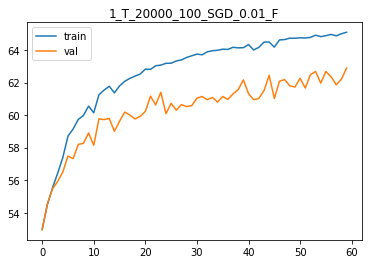

After training for 10 epochs
Train Acc 65.12
Val Acc 62.66
Test Acc 64.072
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 60.56
Epoch: [1/10], Step: [201/625], Validation Acc: 66.9
Epoch: [1/10], Step: [301/625], Validation Acc: 70.04
Epoch: [1/10], Step: [401/625], Validation Acc: 73.6
Epoch: [1/10], Step: [501/625], Validation Acc: 75.16
Epoch: [1/10], Step: [601/625], Validation Acc: 76.52
Epoch: [2/10], Step: [101/625], Validation Acc: 78.04
Epoch: [2/10], Step: [201/625], Validation Acc: 78.92
Epoch: [2/10], Step: [301/625], Validation Acc: 79.86
Epoch: [2/10], Step: [401/625], Validation Acc: 80.14
Epoch: [2/10], Step: [501/625], Validation Acc: 80.66
Epoch: [2/10], Step: [601/625], Validation Acc: 81.24
Epoch: [3/10], Step: [101/625], Validation Acc: 81.76
Epoch: [3/10], Step: [201/625], Validation Acc: 81.96
Epoch: [3/10], Step: [301/625], Validation

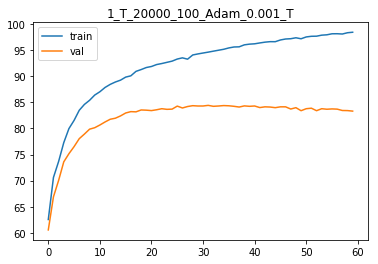

After training for 10 epochs
Train Acc 98.445
Val Acc 83.3
Test Acc 84.348
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 49.06
Epoch: [1/10], Step: [201/625], Validation Acc: 48.76
Epoch: [1/10], Step: [301/625], Validation Acc: 48.86
Epoch: [1/10], Step: [401/625], Validation Acc: 48.62
Epoch: [1/10], Step: [501/625], Validation Acc: 48.54
Epoch: [1/10], Step: [601/625], Validation Acc: 48.78
Epoch: [2/10], Step: [101/625], Validation Acc: 48.76
Epoch: [2/10], Step: [201/625], Validation Acc: 48.78
Epoch: [2/10], Step: [301/625], Validation Acc: 48.8
Epoch: [2/10], Step: [401/625], Validation Acc: 48.66
Epoch: [2/10], Step: [501/625], Validation Acc: 48.52
Epoch: [2/10], Step: [601/625], Validation Acc: 48.84
Epoch: [3/10], Step: [101/625], Validation Acc: 48.72
Epoch: [3/10], Step: [201/625], Validation Acc: 49.1
Epoch: [3/10], Step: [301/625], Validation 

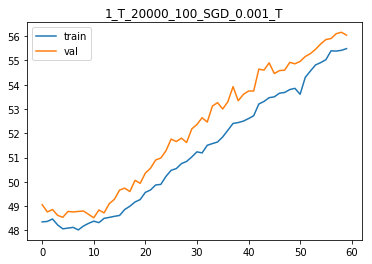

After training for 10 epochs
Train Acc 55.555
Val Acc 56.14
Test Acc 56.572
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 61.52
Epoch: [1/10], Step: [201/625], Validation Acc: 64.26
Epoch: [1/10], Step: [301/625], Validation Acc: 69.76
Epoch: [1/10], Step: [401/625], Validation Acc: 71.22
Epoch: [1/10], Step: [501/625], Validation Acc: 74.42
Epoch: [1/10], Step: [601/625], Validation Acc: 76.98
Epoch: [2/10], Step: [101/625], Validation Acc: 78.06
Epoch: [2/10], Step: [201/625], Validation Acc: 78.44
Epoch: [2/10], Step: [301/625], Validation Acc: 79.62
Epoch: [2/10], Step: [401/625], Validation Acc: 79.98
Epoch: [2/10], Step: [501/625], Validation Acc: 80.66
Epoch: [2/10], Step: [601/625], Validation Acc: 80.24
Epoch: [3/10], Step: [101/625], Validation Acc: 81.38
Epoch: [3/10], Step: [201/625], Validation Acc: 81.64
Epoch: [3/10], Step: [301/625], Validat

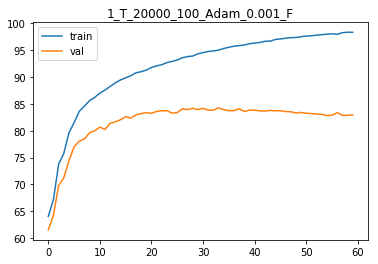

After training for 10 epochs
Train Acc 98.38
Val Acc 82.9
Test Acc 84.38
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.44
Epoch: [1/10], Step: [201/625], Validation Acc: 50.46
Epoch: [1/10], Step: [301/625], Validation Acc: 50.4
Epoch: [1/10], Step: [401/625], Validation Acc: 50.38
Epoch: [1/10], Step: [501/625], Validation Acc: 50.5
Epoch: [1/10], Step: [601/625], Validation Acc: 50.82
Epoch: [2/10], Step: [101/625], Validation Acc: 51.2
Epoch: [2/10], Step: [201/625], Validation Acc: 51.32
Epoch: [2/10], Step: [301/625], Validation Acc: 51.14
Epoch: [2/10], Step: [401/625], Validation Acc: 51.36
Epoch: [2/10], Step: [501/625], Validation Acc: 51.24
Epoch: [2/10], Step: [601/625], Validation Acc: 51.26
Epoch: [3/10], Step: [101/625], Validation Acc: 50.92
Epoch: [3/10], Step: [201/625], Validation Acc: 51.06
Epoch: [3/10], Step: [301/625], Validation Acc

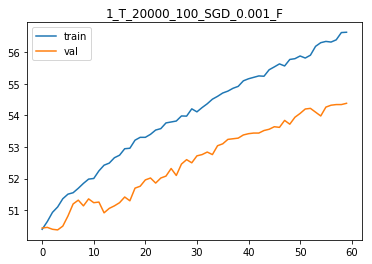

After training for 10 epochs
Train Acc 56.54
Val Acc 54.34
Test Acc 56.232
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 76.12
Epoch: [1/10], Step: [201/625], Validation Acc: 80.58
Epoch: [1/10], Step: [301/625], Validation Acc: 79.34
Epoch: [1/10], Step: [401/625], Validation Acc: 78.86
Epoch: [1/10], Step: [501/625], Validation Acc: 79.24
Epoch: [1/10], Step: [601/625], Validation Acc: 78.22
Epoch: [2/10], Step: [101/625], Validation Acc: 80.56
Epoch: [2/10], Step: [201/625], Validation Acc: 78.58
Epoch: [2/10], Step: [301/625], Validation Acc: 79.14
Epoch: [2/10], Step: [401/625], Validation Acc: 77.0
Epoch: [2/10], Step: [501/625], Validation Acc: 78.78
Epoch: [2/10], Step: [601/625], Validation Acc: 69.96
Epoch: [3/10], Step: [101/625], Validation Acc: 79.18
Epoch: [3/10], Step: [201/625], Validation Acc: 78.54
Epoch: [3/10], Step: [301/625], Validation 

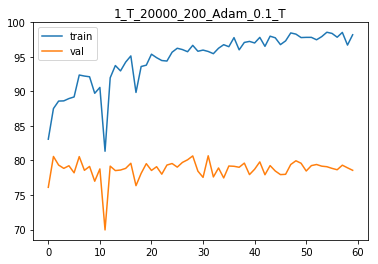

After training for 10 epochs
Train Acc 98.27
Val Acc 79.1
Test Acc 80.296
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 58.62
Epoch: [1/10], Step: [201/625], Validation Acc: 62.66
Epoch: [1/10], Step: [301/625], Validation Acc: 63.02
Epoch: [1/10], Step: [401/625], Validation Acc: 63.12
Epoch: [1/10], Step: [501/625], Validation Acc: 61.94
Epoch: [1/10], Step: [601/625], Validation Acc: 62.94
Epoch: [2/10], Step: [101/625], Validation Acc: 64.74
Epoch: [2/10], Step: [201/625], Validation Acc: 65.24
Epoch: [2/10], Step: [301/625], Validation Acc: 65.2
Epoch: [2/10], Step: [401/625], Validation Acc: 65.8
Epoch: [2/10], Step: [501/625], Validation Acc: 65.84
Epoch: [2/10], Step: [601/625], Validation Acc: 65.96
Epoch: [3/10], Step: [101/625], Validation Acc: 66.8
Epoch: [3/10], Step: [201/625], Validation Acc: 66.74
Epoch: [3/10], Step: [301/625], Validation Acc:

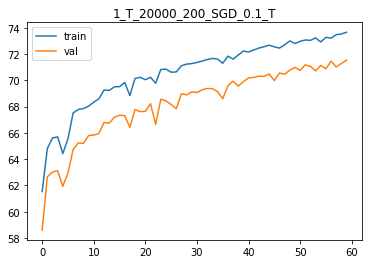

After training for 10 epochs
Train Acc 73.735
Val Acc 71.4
Test Acc 72.636
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 75.44
Epoch: [1/10], Step: [201/625], Validation Acc: 79.42
Epoch: [1/10], Step: [301/625], Validation Acc: 77.9
Epoch: [1/10], Step: [401/625], Validation Acc: 78.32
Epoch: [1/10], Step: [501/625], Validation Acc: 77.36
Epoch: [1/10], Step: [601/625], Validation Acc: 77.62
Epoch: [2/10], Step: [101/625], Validation Acc: 79.9
Epoch: [2/10], Step: [201/625], Validation Acc: 78.3
Epoch: [2/10], Step: [301/625], Validation Acc: 73.56
Epoch: [2/10], Step: [401/625], Validation Acc: 75.24
Epoch: [2/10], Step: [501/625], Validation Acc: 78.62
Epoch: [2/10], Step: [601/625], Validation Acc: 79.76
Epoch: [3/10], Step: [101/625], Validation Acc: 76.24
Epoch: [3/10], Step: [201/625], Validation Acc: 78.42
Epoch: [3/10], Step: [301/625], Validation Ac

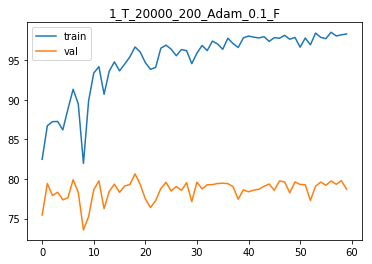

After training for 10 epochs
Train Acc 98.365
Val Acc 79.16
Test Acc 80.656
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 59.92
Epoch: [1/10], Step: [201/625], Validation Acc: 60.9
Epoch: [1/10], Step: [301/625], Validation Acc: 63.44
Epoch: [1/10], Step: [401/625], Validation Acc: 65.4
Epoch: [1/10], Step: [501/625], Validation Acc: 63.54
Epoch: [1/10], Step: [601/625], Validation Acc: 64.24
Epoch: [2/10], Step: [101/625], Validation Acc: 65.32
Epoch: [2/10], Step: [201/625], Validation Acc: 66.62
Epoch: [2/10], Step: [301/625], Validation Acc: 65.54
Epoch: [2/10], Step: [401/625], Validation Acc: 67.06
Epoch: [2/10], Step: [501/625], Validation Acc: 66.58
Epoch: [2/10], Step: [601/625], Validation Acc: 67.46
Epoch: [3/10], Step: [101/625], Validation Acc: 66.62
Epoch: [3/10], Step: [201/625], Validation Acc: 67.5
Epoch: [3/10], Step: [301/625], Validation Ac

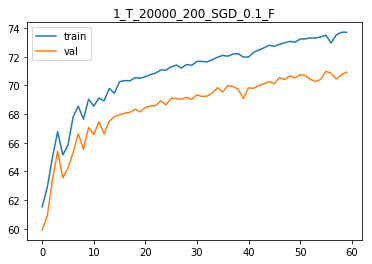

After training for 10 epochs
Train Acc 73.805
Val Acc 71.14
Test Acc 72.556
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.14
Epoch: [1/10], Step: [201/625], Validation Acc: 82.14
Epoch: [1/10], Step: [301/625], Validation Acc: 82.46
Epoch: [1/10], Step: [401/625], Validation Acc: 83.06
Epoch: [1/10], Step: [501/625], Validation Acc: 83.06
Epoch: [1/10], Step: [601/625], Validation Acc: 83.48
Epoch: [2/10], Step: [101/625], Validation Acc: 84.0
Epoch: [2/10], Step: [201/625], Validation Acc: 83.2
Epoch: [2/10], Step: [301/625], Validation Acc: 81.84
Epoch: [2/10], Step: [401/625], Validation Acc: 82.26
Epoch: [2/10], Step: [501/625], Validation Acc: 82.18
Epoch: [2/10], Step: [601/625], Validation Acc: 82.44
Epoch: [3/10], Step: [101/625], Validation Acc: 81.76
Epoch: [3/10], Step: [201/625], Validation Acc: 81.2
Epoch: [3/10], Step: [301/625], Validation 

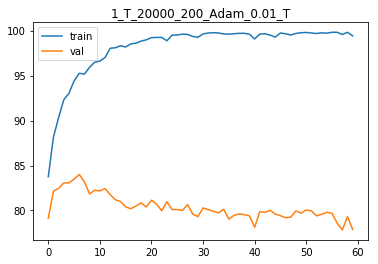

After training for 10 epochs
Train Acc 99.815
Val Acc 78.78
Test Acc 80.412
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 55.2
Epoch: [1/10], Step: [201/625], Validation Acc: 56.46
Epoch: [1/10], Step: [301/625], Validation Acc: 57.1
Epoch: [1/10], Step: [401/625], Validation Acc: 59.34
Epoch: [1/10], Step: [501/625], Validation Acc: 59.5
Epoch: [1/10], Step: [601/625], Validation Acc: 61.1
Epoch: [2/10], Step: [101/625], Validation Acc: 61.6
Epoch: [2/10], Step: [201/625], Validation Acc: 62.46
Epoch: [2/10], Step: [301/625], Validation Acc: 62.7
Epoch: [2/10], Step: [401/625], Validation Acc: 62.5
Epoch: [2/10], Step: [501/625], Validation Acc: 63.14
Epoch: [2/10], Step: [601/625], Validation Acc: 62.98
Epoch: [3/10], Step: [101/625], Validation Acc: 63.58
Epoch: [3/10], Step: [201/625], Validation Acc: 63.86
Epoch: [3/10], Step: [301/625], Validation Acc: 

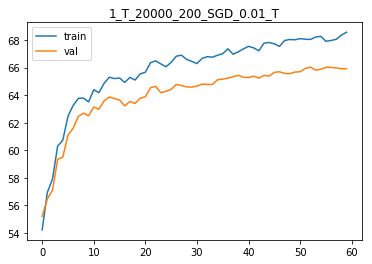

After training for 10 epochs
Train Acc 68.57
Val Acc 65.96
Test Acc 67.652
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.38
Epoch: [1/10], Step: [201/625], Validation Acc: 81.96
Epoch: [1/10], Step: [301/625], Validation Acc: 82.12
Epoch: [1/10], Step: [401/625], Validation Acc: 82.98
Epoch: [1/10], Step: [501/625], Validation Acc: 83.04
Epoch: [1/10], Step: [601/625], Validation Acc: 83.52
Epoch: [2/10], Step: [101/625], Validation Acc: 83.44
Epoch: [2/10], Step: [201/625], Validation Acc: 81.46
Epoch: [2/10], Step: [301/625], Validation Acc: 82.3
Epoch: [2/10], Step: [401/625], Validation Acc: 81.64
Epoch: [2/10], Step: [501/625], Validation Acc: 82.36
Epoch: [2/10], Step: [601/625], Validation Acc: 81.44
Epoch: [3/10], Step: [101/625], Validation Acc: 81.86
Epoch: [3/10], Step: [201/625], Validation Acc: 81.2
Epoch: [3/10], Step: [301/625], Validation 

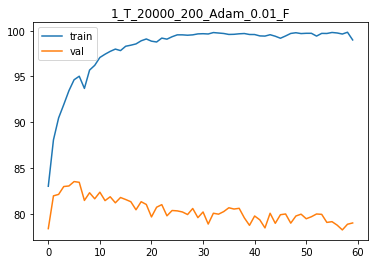

After training for 10 epochs
Train Acc 99.885
Val Acc 78.86
Test Acc 80.68
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 48.6
Epoch: [1/10], Step: [201/625], Validation Acc: 50.28
Epoch: [1/10], Step: [301/625], Validation Acc: 52.14
Epoch: [1/10], Step: [401/625], Validation Acc: 54.94
Epoch: [1/10], Step: [501/625], Validation Acc: 55.32
Epoch: [1/10], Step: [601/625], Validation Acc: 56.9
Epoch: [2/10], Step: [101/625], Validation Acc: 58.12
Epoch: [2/10], Step: [201/625], Validation Acc: 58.92
Epoch: [2/10], Step: [301/625], Validation Acc: 59.3
Epoch: [2/10], Step: [401/625], Validation Acc: 59.76
Epoch: [2/10], Step: [501/625], Validation Acc: 59.26
Epoch: [2/10], Step: [601/625], Validation Acc: 60.46
Epoch: [3/10], Step: [101/625], Validation Acc: 61.5
Epoch: [3/10], Step: [201/625], Validation Acc: 61.46
Epoch: [3/10], Step: [301/625], Validation Acc

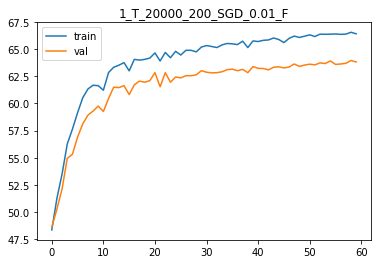

After training for 10 epochs
Train Acc 66.68
Val Acc 64.16
Test Acc 65.872
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 64.9
Epoch: [1/10], Step: [201/625], Validation Acc: 68.1
Epoch: [1/10], Step: [301/625], Validation Acc: 72.3
Epoch: [1/10], Step: [401/625], Validation Acc: 75.4
Epoch: [1/10], Step: [501/625], Validation Acc: 76.5
Epoch: [1/10], Step: [601/625], Validation Acc: 78.82
Epoch: [2/10], Step: [101/625], Validation Acc: 79.78
Epoch: [2/10], Step: [201/625], Validation Acc: 80.44
Epoch: [2/10], Step: [301/625], Validation Acc: 81.2
Epoch: [2/10], Step: [401/625], Validation Acc: 81.66
Epoch: [2/10], Step: [501/625], Validation Acc: 82.2
Epoch: [2/10], Step: [601/625], Validation Acc: 82.6
Epoch: [3/10], Step: [101/625], Validation Acc: 82.64
Epoch: [3/10], Step: [201/625], Validation Acc: 83.36
Epoch: [3/10], Step: [301/625], Validation Acc: 

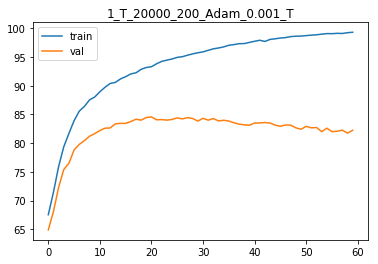

After training for 10 epochs
Train Acc 99.315
Val Acc 81.96
Test Acc 83.44
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 47.48
Epoch: [1/10], Step: [201/625], Validation Acc: 47.32
Epoch: [1/10], Step: [301/625], Validation Acc: 47.36
Epoch: [1/10], Step: [401/625], Validation Acc: 47.2
Epoch: [1/10], Step: [501/625], Validation Acc: 47.6
Epoch: [1/10], Step: [601/625], Validation Acc: 47.64
Epoch: [2/10], Step: [101/625], Validation Acc: 47.8
Epoch: [2/10], Step: [201/625], Validation Acc: 48.18
Epoch: [2/10], Step: [301/625], Validation Acc: 48.3
Epoch: [2/10], Step: [401/625], Validation Acc: 48.46
Epoch: [2/10], Step: [501/625], Validation Acc: 48.74
Epoch: [2/10], Step: [601/625], Validation Acc: 49.28
Epoch: [3/10], Step: [101/625], Validation Acc: 49.62
Epoch: [3/10], Step: [201/625], Validation Acc: 49.5
Epoch: [3/10], Step: [301/625], Validation Acc

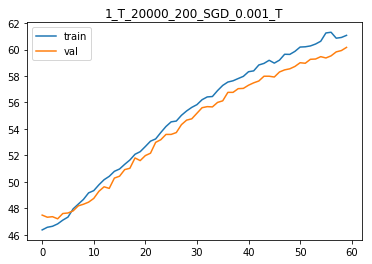

After training for 10 epochs
Train Acc 61.015
Val Acc 60.1
Test Acc 60.684
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 61.2
Epoch: [1/10], Step: [201/625], Validation Acc: 68.18
Epoch: [1/10], Step: [301/625], Validation Acc: 69.94
Epoch: [1/10], Step: [401/625], Validation Acc: 74.3
Epoch: [1/10], Step: [501/625], Validation Acc: 75.44
Epoch: [1/10], Step: [601/625], Validation Acc: 77.94
Epoch: [2/10], Step: [101/625], Validation Acc: 79.58
Epoch: [2/10], Step: [201/625], Validation Acc: 80.06
Epoch: [2/10], Step: [301/625], Validation Acc: 81.18
Epoch: [2/10], Step: [401/625], Validation Acc: 81.06
Epoch: [2/10], Step: [501/625], Validation Acc: 81.5
Epoch: [2/10], Step: [601/625], Validation Acc: 81.92
Epoch: [3/10], Step: [101/625], Validation Acc: 82.28
Epoch: [3/10], Step: [201/625], Validation Acc: 83.0
Epoch: [3/10], Step: [301/625], Validation A

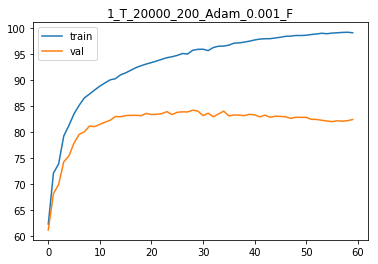

After training for 10 epochs
Train Acc 99.345
Val Acc 81.98
Test Acc 83.496
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 49.18
Epoch: [1/10], Step: [201/625], Validation Acc: 49.24
Epoch: [1/10], Step: [301/625], Validation Acc: 49.28
Epoch: [1/10], Step: [401/625], Validation Acc: 49.3
Epoch: [1/10], Step: [501/625], Validation Acc: 49.62
Epoch: [1/10], Step: [601/625], Validation Acc: 49.86
Epoch: [2/10], Step: [101/625], Validation Acc: 50.0
Epoch: [2/10], Step: [201/625], Validation Acc: 50.58
Epoch: [2/10], Step: [301/625], Validation Acc: 50.84
Epoch: [2/10], Step: [401/625], Validation Acc: 50.8
Epoch: [2/10], Step: [501/625], Validation Acc: 51.2
Epoch: [2/10], Step: [601/625], Validation Acc: 51.36
Epoch: [3/10], Step: [101/625], Validation Acc: 51.64
Epoch: [3/10], Step: [201/625], Validation Acc: 52.04
Epoch: [3/10], Step: [301/625], Validation A

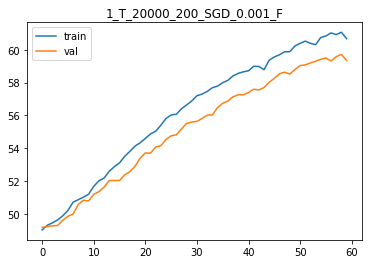

After training for 10 epochs
Train Acc 60.59
Val Acc 59.36
Test Acc 61.328
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 71.54
Epoch: [1/10], Step: [201/625], Validation Acc: 76.34
Epoch: [1/10], Step: [301/625], Validation Acc: 68.88
Epoch: [1/10], Step: [401/625], Validation Acc: 76.16
Epoch: [1/10], Step: [501/625], Validation Acc: 78.62
Epoch: [1/10], Step: [601/625], Validation Acc: 70.22
Epoch: [2/10], Step: [101/625], Validation Acc: 79.16
Epoch: [2/10], Step: [201/625], Validation Acc: 77.5
Epoch: [2/10], Step: [301/625], Validation Acc: 74.86
Epoch: [2/10], Step: [401/625], Validation Acc: 78.08
Epoch: [2/10], Step: [501/625], Validation Acc: 77.1
Epoch: [2/10], Step: [601/625], Validation Acc: 79.42
Epoch: [3/10], Step: [101/625], Validation Acc: 79.1
Epoch: [3/10], Step: [201/625], Validation Acc: 78.98
Epoch: [3/10], Step: [301/625], Validation Ac

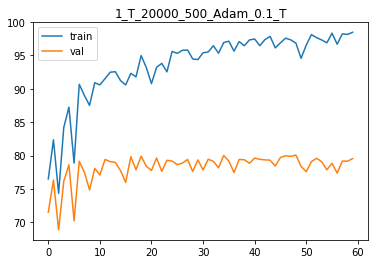

After training for 10 epochs
Train Acc 98.045
Val Acc 79.54
Test Acc 80.896
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 64.36
Epoch: [1/10], Step: [201/625], Validation Acc: 65.22
Epoch: [1/10], Step: [301/625], Validation Acc: 65.96
Epoch: [1/10], Step: [401/625], Validation Acc: 66.74
Epoch: [1/10], Step: [501/625], Validation Acc: 67.36
Epoch: [1/10], Step: [601/625], Validation Acc: 67.64
Epoch: [2/10], Step: [101/625], Validation Acc: 67.24
Epoch: [2/10], Step: [201/625], Validation Acc: 68.06
Epoch: [2/10], Step: [301/625], Validation Acc: 68.28
Epoch: [2/10], Step: [401/625], Validation Acc: 68.92
Epoch: [2/10], Step: [501/625], Validation Acc: 69.0
Epoch: [2/10], Step: [601/625], Validation Acc: 69.1
Epoch: [3/10], Step: [101/625], Validation Acc: 69.3
Epoch: [3/10], Step: [201/625], Validation Acc: 69.8
Epoch: [3/10], Step: [301/625], Validation Acc

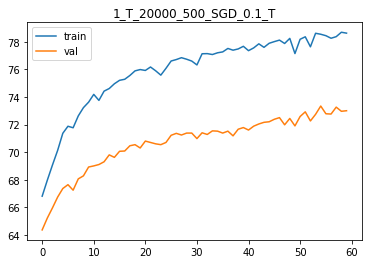

After training for 10 epochs
Train Acc 78.64
Val Acc 72.96
Test Acc 76.924
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 76.04
Epoch: [1/10], Step: [201/625], Validation Acc: 80.52
Epoch: [1/10], Step: [301/625], Validation Acc: 74.28
Epoch: [1/10], Step: [401/625], Validation Acc: 76.86
Epoch: [1/10], Step: [501/625], Validation Acc: 78.38
Epoch: [1/10], Step: [601/625], Validation Acc: 78.22
Epoch: [2/10], Step: [101/625], Validation Acc: 80.24
Epoch: [2/10], Step: [201/625], Validation Acc: 79.42
Epoch: [2/10], Step: [301/625], Validation Acc: 78.66
Epoch: [2/10], Step: [401/625], Validation Acc: 77.56
Epoch: [2/10], Step: [501/625], Validation Acc: 74.16
Epoch: [2/10], Step: [601/625], Validation Acc: 79.66
Epoch: [3/10], Step: [101/625], Validation Acc: 78.94
Epoch: [3/10], Step: [201/625], Validation Acc: 79.62
Epoch: [3/10], Step: [301/625], Validation

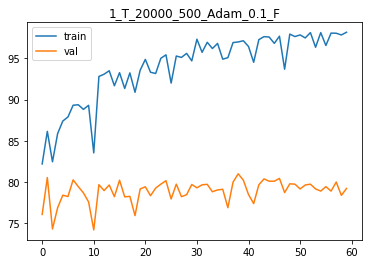

After training for 10 epochs
Train Acc 98.19
Val Acc 79.36
Test Acc 81.112
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 62.72
Epoch: [1/10], Step: [201/625], Validation Acc: 62.76
Epoch: [1/10], Step: [301/625], Validation Acc: 66.74
Epoch: [1/10], Step: [401/625], Validation Acc: 65.32
Epoch: [1/10], Step: [501/625], Validation Acc: 67.78
Epoch: [1/10], Step: [601/625], Validation Acc: 67.48
Epoch: [2/10], Step: [101/625], Validation Acc: 69.82
Epoch: [2/10], Step: [201/625], Validation Acc: 70.08
Epoch: [2/10], Step: [301/625], Validation Acc: 70.64
Epoch: [2/10], Step: [401/625], Validation Acc: 70.48
Epoch: [2/10], Step: [501/625], Validation Acc: 69.5
Epoch: [2/10], Step: [601/625], Validation Acc: 70.62
Epoch: [3/10], Step: [101/625], Validation Acc: 71.56
Epoch: [3/10], Step: [201/625], Validation Acc: 71.74
Epoch: [3/10], Step: [301/625], Validation A

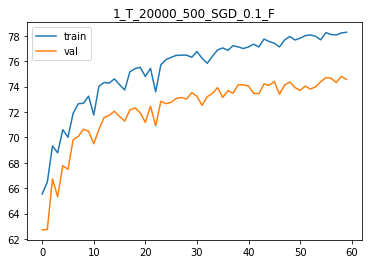

After training for 10 epochs
Train Acc 78.345
Val Acc 74.68
Test Acc 76.692
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.3
Epoch: [1/10], Step: [201/625], Validation Acc: 81.56
Epoch: [1/10], Step: [301/625], Validation Acc: 82.54
Epoch: [1/10], Step: [401/625], Validation Acc: 81.3
Epoch: [1/10], Step: [501/625], Validation Acc: 81.96
Epoch: [1/10], Step: [601/625], Validation Acc: 82.96
Epoch: [2/10], Step: [101/625], Validation Acc: 82.78
Epoch: [2/10], Step: [201/625], Validation Acc: 82.82
Epoch: [2/10], Step: [301/625], Validation Acc: 81.84
Epoch: [2/10], Step: [401/625], Validation Acc: 80.96
Epoch: [2/10], Step: [501/625], Validation Acc: 80.92
Epoch: [2/10], Step: [601/625], Validation Acc: 79.22
Epoch: [3/10], Step: [101/625], Validation Acc: 81.34
Epoch: [3/10], Step: [201/625], Validation Acc: 80.44
Epoch: [3/10], Step: [301/625], Validation

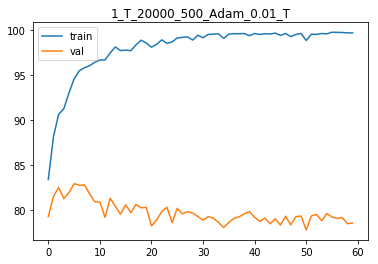

After training for 10 epochs
Train Acc 99.345
Val Acc 78.28
Test Acc 79.492
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 55.6
Epoch: [1/10], Step: [201/625], Validation Acc: 55.36
Epoch: [1/10], Step: [301/625], Validation Acc: 60.54
Epoch: [1/10], Step: [401/625], Validation Acc: 61.26
Epoch: [1/10], Step: [501/625], Validation Acc: 61.5
Epoch: [1/10], Step: [601/625], Validation Acc: 62.68
Epoch: [2/10], Step: [101/625], Validation Acc: 63.76
Epoch: [2/10], Step: [201/625], Validation Acc: 63.64
Epoch: [2/10], Step: [301/625], Validation Acc: 64.28
Epoch: [2/10], Step: [401/625], Validation Acc: 64.06
Epoch: [2/10], Step: [501/625], Validation Acc: 65.12
Epoch: [2/10], Step: [601/625], Validation Acc: 65.48
Epoch: [3/10], Step: [101/625], Validation Acc: 65.3
Epoch: [3/10], Step: [201/625], Validation Acc: 65.4
Epoch: [3/10], Step: [301/625], Validation Ac

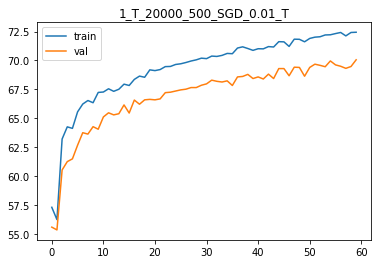

After training for 10 epochs
Train Acc 72.49
Val Acc 69.58
Test Acc 71.864
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.14
Epoch: [1/10], Step: [201/625], Validation Acc: 81.32
Epoch: [1/10], Step: [301/625], Validation Acc: 81.78
Epoch: [1/10], Step: [401/625], Validation Acc: 82.14
Epoch: [1/10], Step: [501/625], Validation Acc: 83.18
Epoch: [1/10], Step: [601/625], Validation Acc: 81.98
Epoch: [2/10], Step: [101/625], Validation Acc: 83.28
Epoch: [2/10], Step: [201/625], Validation Acc: 82.62
Epoch: [2/10], Step: [301/625], Validation Acc: 81.1
Epoch: [2/10], Step: [401/625], Validation Acc: 81.4
Epoch: [2/10], Step: [501/625], Validation Acc: 81.9
Epoch: [2/10], Step: [601/625], Validation Acc: 81.12
Epoch: [3/10], Step: [101/625], Validation Acc: 80.98
Epoch: [3/10], Step: [201/625], Validation Acc: 81.02
Epoch: [3/10], Step: [301/625], Validation A

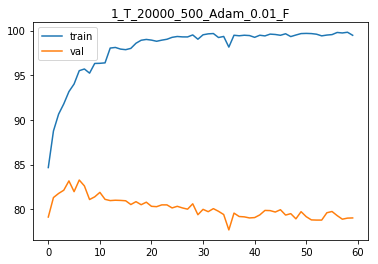

After training for 10 epochs
Train Acc 99.145
Val Acc 79.32
Test Acc 80.728
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 53.22
Epoch: [1/10], Step: [201/625], Validation Acc: 57.64
Epoch: [1/10], Step: [301/625], Validation Acc: 60.16
Epoch: [1/10], Step: [401/625], Validation Acc: 62.42
Epoch: [1/10], Step: [501/625], Validation Acc: 62.84
Epoch: [1/10], Step: [601/625], Validation Acc: 61.74
Epoch: [2/10], Step: [101/625], Validation Acc: 63.7
Epoch: [2/10], Step: [201/625], Validation Acc: 64.14
Epoch: [2/10], Step: [301/625], Validation Acc: 64.6
Epoch: [2/10], Step: [401/625], Validation Acc: 64.84
Epoch: [2/10], Step: [501/625], Validation Acc: 65.08
Epoch: [2/10], Step: [601/625], Validation Acc: 65.3
Epoch: [3/10], Step: [101/625], Validation Acc: 65.38
Epoch: [3/10], Step: [201/625], Validation Acc: 65.38
Epoch: [3/10], Step: [301/625], Validation A

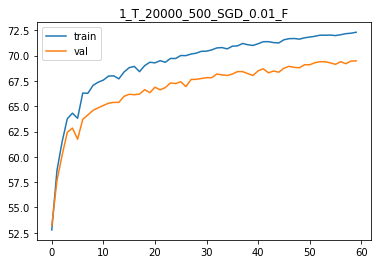

After training for 10 epochs
Train Acc 72.26
Val Acc 69.58
Test Acc 71.4
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 64.56
Epoch: [1/10], Step: [201/625], Validation Acc: 71.22
Epoch: [1/10], Step: [301/625], Validation Acc: 74.82
Epoch: [1/10], Step: [401/625], Validation Acc: 77.54
Epoch: [1/10], Step: [501/625], Validation Acc: 78.72
Epoch: [1/10], Step: [601/625], Validation Acc: 80.6
Epoch: [2/10], Step: [101/625], Validation Acc: 81.42
Epoch: [2/10], Step: [201/625], Validation Acc: 82.14
Epoch: [2/10], Step: [301/625], Validation Acc: 82.88
Epoch: [2/10], Step: [401/625], Validation Acc: 83.1
Epoch: [2/10], Step: [501/625], Validation Acc: 83.52
Epoch: [2/10], Step: [601/625], Validation Acc: 83.82
Epoch: [3/10], Step: [101/625], Validation Acc: 83.98
Epoch: [3/10], Step: [201/625], Validation Acc: 83.94
Epoch: [3/10], Step: [301/625], Validation A

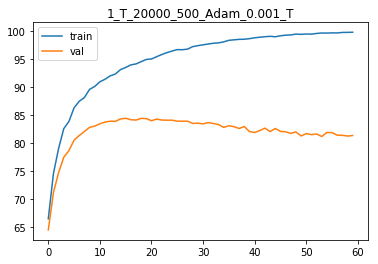

After training for 10 epochs
Train Acc 99.835
Val Acc 81.02
Test Acc 82.392
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 51.42
Epoch: [1/10], Step: [201/625], Validation Acc: 51.8
Epoch: [1/10], Step: [301/625], Validation Acc: 52.34
Epoch: [1/10], Step: [401/625], Validation Acc: 53.58
Epoch: [1/10], Step: [501/625], Validation Acc: 54.1
Epoch: [1/10], Step: [601/625], Validation Acc: 54.38
Epoch: [2/10], Step: [101/625], Validation Acc: 54.9
Epoch: [2/10], Step: [201/625], Validation Acc: 55.22
Epoch: [2/10], Step: [301/625], Validation Acc: 55.8
Epoch: [2/10], Step: [401/625], Validation Acc: 56.34
Epoch: [2/10], Step: [501/625], Validation Acc: 56.06
Epoch: [2/10], Step: [601/625], Validation Acc: 56.66
Epoch: [3/10], Step: [101/625], Validation Acc: 56.8
Epoch: [3/10], Step: [201/625], Validation Acc: 56.94
Epoch: [3/10], Step: [301/625], Validation Ac

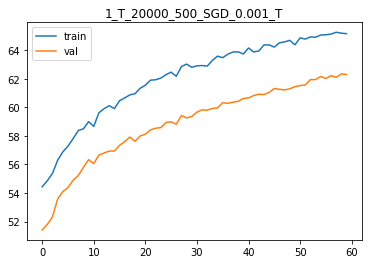

After training for 10 epochs
Train Acc 65.115
Val Acc 62.2
Test Acc 64.036
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 65.5
Epoch: [1/10], Step: [201/625], Validation Acc: 71.3
Epoch: [1/10], Step: [301/625], Validation Acc: 74.98
Epoch: [1/10], Step: [401/625], Validation Acc: 77.18
Epoch: [1/10], Step: [501/625], Validation Acc: 78.9
Epoch: [1/10], Step: [601/625], Validation Acc: 80.06
Epoch: [2/10], Step: [101/625], Validation Acc: 81.04
Epoch: [2/10], Step: [201/625], Validation Acc: 81.1
Epoch: [2/10], Step: [301/625], Validation Acc: 82.02
Epoch: [2/10], Step: [401/625], Validation Acc: 82.52
Epoch: [2/10], Step: [501/625], Validation Acc: 83.1
Epoch: [2/10], Step: [601/625], Validation Acc: 83.4
Epoch: [3/10], Step: [101/625], Validation Acc: 82.84
Epoch: [3/10], Step: [201/625], Validation Acc: 83.6
Epoch: [3/10], Step: [301/625], Validation Acc:

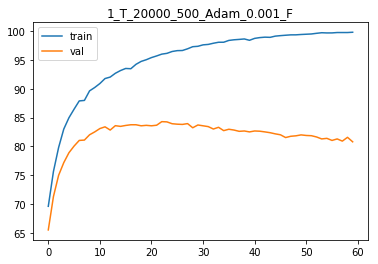

After training for 10 epochs
Train Acc 99.88
Val Acc 81.1
Test Acc 82.776
ngram:  1
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 47.0
Epoch: [1/10], Step: [201/625], Validation Acc: 47.32
Epoch: [1/10], Step: [301/625], Validation Acc: 47.5
Epoch: [1/10], Step: [401/625], Validation Acc: 48.34
Epoch: [1/10], Step: [501/625], Validation Acc: 49.36
Epoch: [1/10], Step: [601/625], Validation Acc: 49.98
Epoch: [2/10], Step: [101/625], Validation Acc: 50.62
Epoch: [2/10], Step: [201/625], Validation Acc: 51.22
Epoch: [2/10], Step: [301/625], Validation Acc: 51.7
Epoch: [2/10], Step: [401/625], Validation Acc: 52.26
Epoch: [2/10], Step: [501/625], Validation Acc: 52.56
Epoch: [2/10], Step: [601/625], Validation Acc: 52.9
Epoch: [3/10], Step: [101/625], Validation Acc: 53.12
Epoch: [3/10], Step: [201/625], Validation Acc: 53.9
Epoch: [3/10], Step: [301/625], Validation Acc:

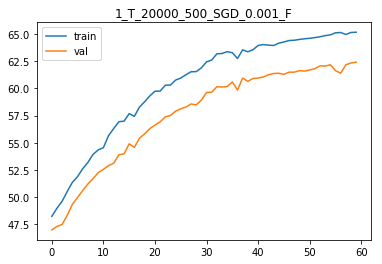

After training for 10 epochs
Train Acc 65.05
Val Acc 62.4
Test Acc 64.156
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.26
Epoch: [1/10], Step: [201/625], Validation Acc: 81.68
Epoch: [1/10], Step: [301/625], Validation Acc: 80.34
Epoch: [1/10], Step: [401/625], Validation Acc: 76.78
Epoch: [1/10], Step: [501/625], Validation Acc: 80.92
Epoch: [1/10], Step: [601/625], Validation Acc: 82.14
Epoch: [2/10], Step: [101/625], Validation Acc: 80.44
Epoch: [2/10], Step: [201/625], Validation Acc: 80.84
Epoch: [2/10], Step: [301/625], Validation Acc: 82.74
Epoch: [2/10], Step: [401/625], Validation Acc: 80.58
Epoch: [2/10], Step: [501/625], Validation Acc: 78.42
Epoch: [2/10], Step: [601/625], Validation Acc: 82.9
Epoch: [3/10], Step: [101/625], Validation Acc: 80.58
Epoch: [3/10], Step: [201/625], Validation Acc: 79.28
Epoch: [3/10], Step: [301/625], Validation Ac

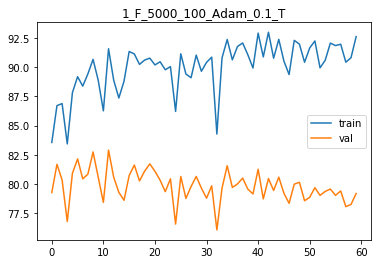

After training for 10 epochs
Train Acc 89.92
Val Acc 78.72
Test Acc 80.284
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 58.04
Epoch: [1/10], Step: [201/625], Validation Acc: 61.6
Epoch: [1/10], Step: [301/625], Validation Acc: 57.18
Epoch: [1/10], Step: [401/625], Validation Acc: 62.48
Epoch: [1/10], Step: [501/625], Validation Acc: 63.16
Epoch: [1/10], Step: [601/625], Validation Acc: 63.34
Epoch: [2/10], Step: [101/625], Validation Acc: 63.54
Epoch: [2/10], Step: [201/625], Validation Acc: 64.38
Epoch: [2/10], Step: [301/625], Validation Acc: 64.94
Epoch: [2/10], Step: [401/625], Validation Acc: 64.5
Epoch: [2/10], Step: [501/625], Validation Acc: 64.82
Epoch: [2/10], Step: [601/625], Validation Acc: 65.64
Epoch: [3/10], Step: [101/625], Validation Acc: 65.16
Epoch: [3/10], Step: [201/625], Validation Acc: 64.92
Epoch: [3/10], Step: [301/625], Validation Acc

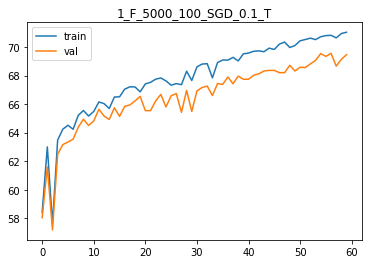

After training for 10 epochs
Train Acc 71.04
Val Acc 69.4
Test Acc 70.868
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.68
Epoch: [1/10], Step: [201/625], Validation Acc: 80.28
Epoch: [1/10], Step: [301/625], Validation Acc: 77.48
Epoch: [1/10], Step: [401/625], Validation Acc: 79.6
Epoch: [1/10], Step: [501/625], Validation Acc: 74.58
Epoch: [1/10], Step: [601/625], Validation Acc: 82.0
Epoch: [2/10], Step: [101/625], Validation Acc: 80.88
Epoch: [2/10], Step: [201/625], Validation Acc: 79.42
Epoch: [2/10], Step: [301/625], Validation Acc: 79.16
Epoch: [2/10], Step: [401/625], Validation Acc: 79.98
Epoch: [2/10], Step: [501/625], Validation Acc: 81.1
Epoch: [2/10], Step: [601/625], Validation Acc: 81.7
Epoch: [3/10], Step: [101/625], Validation Acc: 80.56
Epoch: [3/10], Step: [201/625], Validation Acc: 79.62
Epoch: [3/10], Step: [301/625], Validation Acc: 

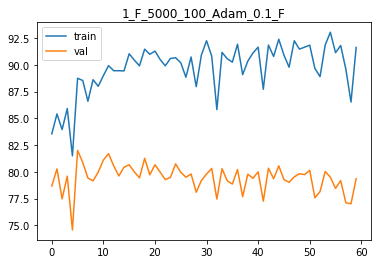

After training for 10 epochs
Train Acc 89.155
Val Acc 78.76
Test Acc 80.572
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 55.62
Epoch: [1/10], Step: [201/625], Validation Acc: 57.72
Epoch: [1/10], Step: [301/625], Validation Acc: 59.9
Epoch: [1/10], Step: [401/625], Validation Acc: 59.94
Epoch: [1/10], Step: [501/625], Validation Acc: 61.46
Epoch: [1/10], Step: [601/625], Validation Acc: 61.74
Epoch: [2/10], Step: [101/625], Validation Acc: 62.34
Epoch: [2/10], Step: [201/625], Validation Acc: 61.68
Epoch: [2/10], Step: [301/625], Validation Acc: 62.8
Epoch: [2/10], Step: [401/625], Validation Acc: 62.94
Epoch: [2/10], Step: [501/625], Validation Acc: 63.2
Epoch: [2/10], Step: [601/625], Validation Acc: 63.46
Epoch: [3/10], Step: [101/625], Validation Acc: 63.6
Epoch: [3/10], Step: [201/625], Validation Acc: 63.72
Epoch: [3/10], Step: [301/625], Validation Acc:

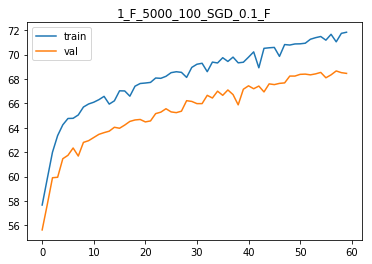

After training for 10 epochs
Train Acc 71.81
Val Acc 69.14
Test Acc 70.96
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 76.26
Epoch: [1/10], Step: [201/625], Validation Acc: 80.7
Epoch: [1/10], Step: [301/625], Validation Acc: 82.42
Epoch: [1/10], Step: [401/625], Validation Acc: 83.1
Epoch: [1/10], Step: [501/625], Validation Acc: 83.42
Epoch: [1/10], Step: [601/625], Validation Acc: 83.56
Epoch: [2/10], Step: [101/625], Validation Acc: 83.98
Epoch: [2/10], Step: [201/625], Validation Acc: 83.68
Epoch: [2/10], Step: [301/625], Validation Acc: 83.34
Epoch: [2/10], Step: [401/625], Validation Acc: 83.34
Epoch: [2/10], Step: [501/625], Validation Acc: 81.58
Epoch: [2/10], Step: [601/625], Validation Acc: 83.08
Epoch: [3/10], Step: [101/625], Validation Acc: 83.08
Epoch: [3/10], Step: [201/625], Validation Acc: 82.64
Epoch: [3/10], Step: [301/625], Validation Ac

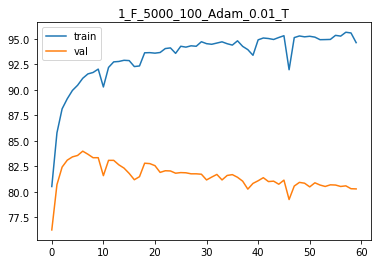

After training for 10 epochs
Train Acc 94.99
Val Acc 80.44
Test Acc 81.984
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 53.38
Epoch: [1/10], Step: [201/625], Validation Acc: 52.8
Epoch: [1/10], Step: [301/625], Validation Acc: 55.26
Epoch: [1/10], Step: [401/625], Validation Acc: 55.8
Epoch: [1/10], Step: [501/625], Validation Acc: 55.84
Epoch: [1/10], Step: [601/625], Validation Acc: 57.32
Epoch: [2/10], Step: [101/625], Validation Acc: 57.88
Epoch: [2/10], Step: [201/625], Validation Acc: 57.24
Epoch: [2/10], Step: [301/625], Validation Acc: 57.94
Epoch: [2/10], Step: [401/625], Validation Acc: 57.14
Epoch: [2/10], Step: [501/625], Validation Acc: 58.82
Epoch: [2/10], Step: [601/625], Validation Acc: 59.66
Epoch: [3/10], Step: [101/625], Validation Acc: 59.58
Epoch: [3/10], Step: [201/625], Validation Acc: 59.42
Epoch: [3/10], Step: [301/625], Validation Ac

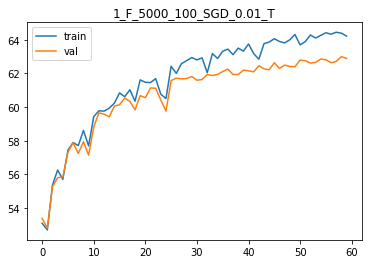

After training for 10 epochs
Train Acc 64.265
Val Acc 62.9
Test Acc 64.036
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.0
Epoch: [1/10], Step: [201/625], Validation Acc: 80.04
Epoch: [1/10], Step: [301/625], Validation Acc: 82.58
Epoch: [1/10], Step: [401/625], Validation Acc: 83.14
Epoch: [1/10], Step: [501/625], Validation Acc: 82.96
Epoch: [1/10], Step: [601/625], Validation Acc: 84.22
Epoch: [2/10], Step: [101/625], Validation Acc: 84.16
Epoch: [2/10], Step: [201/625], Validation Acc: 82.88
Epoch: [2/10], Step: [301/625], Validation Acc: 82.72
Epoch: [2/10], Step: [401/625], Validation Acc: 82.8
Epoch: [2/10], Step: [501/625], Validation Acc: 82.62
Epoch: [2/10], Step: [601/625], Validation Acc: 82.88
Epoch: [3/10], Step: [101/625], Validation Acc: 82.92
Epoch: [3/10], Step: [201/625], Validation Acc: 82.84
Epoch: [3/10], Step: [301/625], Validation A

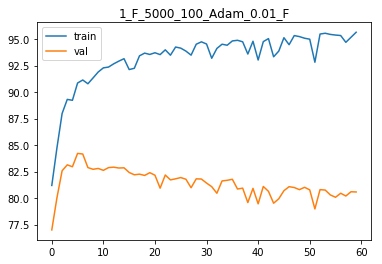

After training for 10 epochs
Train Acc 95.365
Val Acc 80.44
Test Acc 81.676
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.92
Epoch: [1/10], Step: [201/625], Validation Acc: 51.66
Epoch: [1/10], Step: [301/625], Validation Acc: 50.86
Epoch: [1/10], Step: [401/625], Validation Acc: 51.78
Epoch: [1/10], Step: [501/625], Validation Acc: 53.94
Epoch: [1/10], Step: [601/625], Validation Acc: 54.38
Epoch: [2/10], Step: [101/625], Validation Acc: 55.14
Epoch: [2/10], Step: [201/625], Validation Acc: 55.44
Epoch: [2/10], Step: [301/625], Validation Acc: 54.18
Epoch: [2/10], Step: [401/625], Validation Acc: 56.38
Epoch: [2/10], Step: [501/625], Validation Acc: 56.5
Epoch: [2/10], Step: [601/625], Validation Acc: 56.8
Epoch: [3/10], Step: [101/625], Validation Acc: 57.24
Epoch: [3/10], Step: [201/625], Validation Acc: 57.68
Epoch: [3/10], Step: [301/625], Validation A

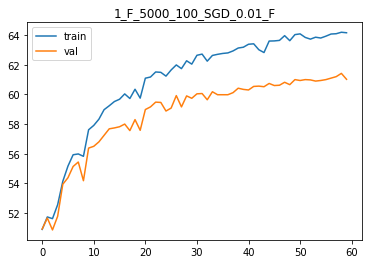

After training for 10 epochs
Train Acc 64.365
Val Acc 61.3
Test Acc 63.54
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 59.96
Epoch: [1/10], Step: [201/625], Validation Acc: 66.02
Epoch: [1/10], Step: [301/625], Validation Acc: 69.14
Epoch: [1/10], Step: [401/625], Validation Acc: 73.12
Epoch: [1/10], Step: [501/625], Validation Acc: 75.08
Epoch: [1/10], Step: [601/625], Validation Acc: 76.38
Epoch: [2/10], Step: [101/625], Validation Acc: 77.34
Epoch: [2/10], Step: [201/625], Validation Acc: 78.5
Epoch: [2/10], Step: [301/625], Validation Acc: 79.04
Epoch: [2/10], Step: [401/625], Validation Acc: 79.6
Epoch: [2/10], Step: [501/625], Validation Acc: 80.46
Epoch: [2/10], Step: [601/625], Validation Acc: 80.92
Epoch: [3/10], Step: [101/625], Validation Acc: 81.04
Epoch: [3/10], Step: [201/625], Validation Acc: 81.44
Epoch: [3/10], Step: [301/625], Validation A

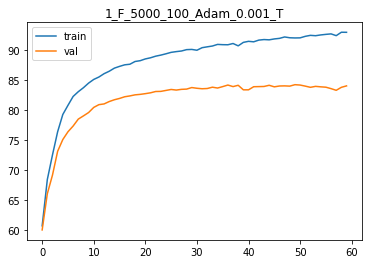

After training for 10 epochs
Train Acc 92.84
Val Acc 84.08
Test Acc 85.208
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 52.54
Epoch: [1/10], Step: [201/625], Validation Acc: 52.6
Epoch: [1/10], Step: [301/625], Validation Acc: 53.04
Epoch: [1/10], Step: [401/625], Validation Acc: 53.04
Epoch: [1/10], Step: [501/625], Validation Acc: 53.28
Epoch: [1/10], Step: [601/625], Validation Acc: 53.36
Epoch: [2/10], Step: [101/625], Validation Acc: 53.32
Epoch: [2/10], Step: [201/625], Validation Acc: 53.34
Epoch: [2/10], Step: [301/625], Validation Acc: 53.3
Epoch: [2/10], Step: [401/625], Validation Acc: 53.6
Epoch: [2/10], Step: [501/625], Validation Acc: 53.6
Epoch: [2/10], Step: [601/625], Validation Acc: 53.54
Epoch: [3/10], Step: [101/625], Validation Acc: 53.7
Epoch: [3/10], Step: [201/625], Validation Acc: 53.8
Epoch: [3/10], Step: [301/625], Validation Acc: 

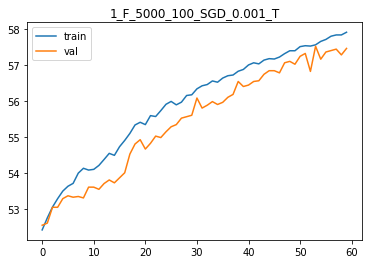

After training for 10 epochs
Train Acc 57.91
Val Acc 57.5
Test Acc 58.168
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 57.72
Epoch: [1/10], Step: [201/625], Validation Acc: 64.86
Epoch: [1/10], Step: [301/625], Validation Acc: 68.82
Epoch: [1/10], Step: [401/625], Validation Acc: 72.06
Epoch: [1/10], Step: [501/625], Validation Acc: 74.38
Epoch: [1/10], Step: [601/625], Validation Acc: 74.98
Epoch: [2/10], Step: [101/625], Validation Acc: 77.74
Epoch: [2/10], Step: [201/625], Validation Acc: 78.9
Epoch: [2/10], Step: [301/625], Validation Acc: 79.38
Epoch: [2/10], Step: [401/625], Validation Acc: 79.58
Epoch: [2/10], Step: [501/625], Validation Acc: 79.96
Epoch: [2/10], Step: [601/625], Validation Acc: 80.64
Epoch: [3/10], Step: [101/625], Validation Acc: 81.36
Epoch: [3/10], Step: [201/625], Validation Acc: 81.48
Epoch: [3/10], Step: [301/625], Validation 

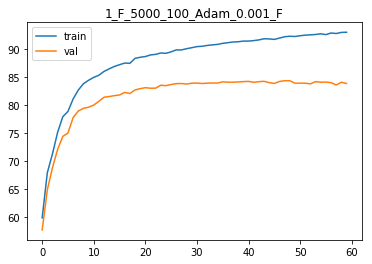

After training for 10 epochs
Train Acc 93.045
Val Acc 83.92
Test Acc 85.168
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 49.7
Epoch: [1/10], Step: [201/625], Validation Acc: 49.1
Epoch: [1/10], Step: [301/625], Validation Acc: 49.32
Epoch: [1/10], Step: [401/625], Validation Acc: 49.1
Epoch: [1/10], Step: [501/625], Validation Acc: 48.96
Epoch: [1/10], Step: [601/625], Validation Acc: 49.18
Epoch: [2/10], Step: [101/625], Validation Acc: 49.5
Epoch: [2/10], Step: [201/625], Validation Acc: 49.58
Epoch: [2/10], Step: [301/625], Validation Acc: 50.08
Epoch: [2/10], Step: [401/625], Validation Acc: 50.08
Epoch: [2/10], Step: [501/625], Validation Acc: 50.88
Epoch: [2/10], Step: [601/625], Validation Acc: 50.88
Epoch: [3/10], Step: [101/625], Validation Acc: 50.72
Epoch: [3/10], Step: [201/625], Validation Acc: 50.84
Epoch: [3/10], Step: [301/625], Validation Ac

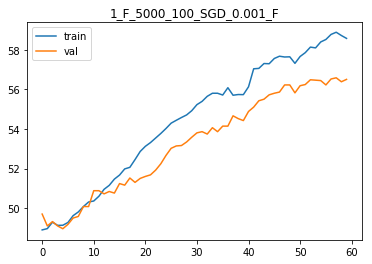

After training for 10 epochs
Train Acc 58.39
Val Acc 56.38
Test Acc 57.888
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 75.36
Epoch: [1/10], Step: [201/625], Validation Acc: 77.46
Epoch: [1/10], Step: [301/625], Validation Acc: 80.58
Epoch: [1/10], Step: [401/625], Validation Acc: 82.08
Epoch: [1/10], Step: [501/625], Validation Acc: 77.3
Epoch: [1/10], Step: [601/625], Validation Acc: 79.4
Epoch: [2/10], Step: [101/625], Validation Acc: 79.96
Epoch: [2/10], Step: [201/625], Validation Acc: 78.32
Epoch: [2/10], Step: [301/625], Validation Acc: 72.5
Epoch: [2/10], Step: [401/625], Validation Acc: 72.36
Epoch: [2/10], Step: [501/625], Validation Acc: 80.46
Epoch: [2/10], Step: [601/625], Validation Acc: 77.98
Epoch: [3/10], Step: [101/625], Validation Acc: 79.08
Epoch: [3/10], Step: [201/625], Validation Acc: 78.56
Epoch: [3/10], Step: [301/625], Validation Acc

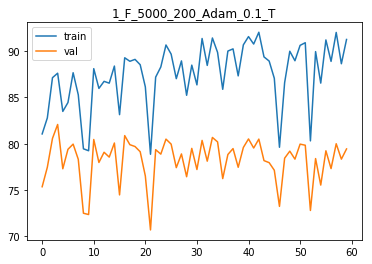

After training for 10 epochs
Train Acc 91.155
Val Acc 78.7
Test Acc 80.728
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 54.62
Epoch: [1/10], Step: [201/625], Validation Acc: 62.3
Epoch: [1/10], Step: [301/625], Validation Acc: 63.02
Epoch: [1/10], Step: [401/625], Validation Acc: 62.64
Epoch: [1/10], Step: [501/625], Validation Acc: 62.5
Epoch: [1/10], Step: [601/625], Validation Acc: 64.56
Epoch: [2/10], Step: [101/625], Validation Acc: 65.8
Epoch: [2/10], Step: [201/625], Validation Acc: 65.46
Epoch: [2/10], Step: [301/625], Validation Acc: 66.04
Epoch: [2/10], Step: [401/625], Validation Acc: 66.24
Epoch: [2/10], Step: [501/625], Validation Acc: 66.1
Epoch: [2/10], Step: [601/625], Validation Acc: 66.78
Epoch: [3/10], Step: [101/625], Validation Acc: 66.98
Epoch: [3/10], Step: [201/625], Validation Acc: 67.24
Epoch: [3/10], Step: [301/625], Validation Acc: 

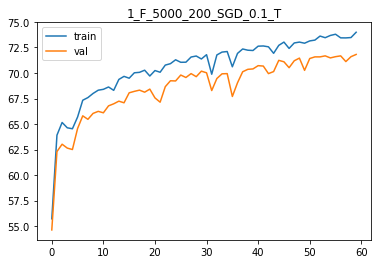

After training for 10 epochs
Train Acc 74.13
Val Acc 71.86
Test Acc 73.128
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 71.28
Epoch: [1/10], Step: [201/625], Validation Acc: 78.42
Epoch: [1/10], Step: [301/625], Validation Acc: 78.64
Epoch: [1/10], Step: [401/625], Validation Acc: 79.7
Epoch: [1/10], Step: [501/625], Validation Acc: 70.48
Epoch: [1/10], Step: [601/625], Validation Acc: 80.06
Epoch: [2/10], Step: [101/625], Validation Acc: 79.92
Epoch: [2/10], Step: [201/625], Validation Acc: 80.78
Epoch: [2/10], Step: [301/625], Validation Acc: 81.78
Epoch: [2/10], Step: [401/625], Validation Acc: 79.82
Epoch: [2/10], Step: [501/625], Validation Acc: 80.94
Epoch: [2/10], Step: [601/625], Validation Acc: 80.34
Epoch: [3/10], Step: [101/625], Validation Acc: 80.78
Epoch: [3/10], Step: [201/625], Validation Acc: 78.92
Epoch: [3/10], Step: [301/625], Validation A

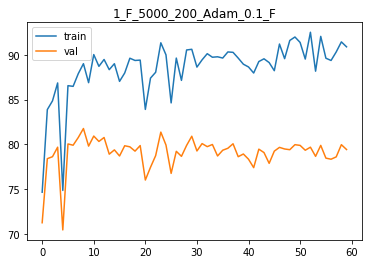

After training for 10 epochs
Train Acc 87.02
Val Acc 76.46
Test Acc 77.856
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 57.5
Epoch: [1/10], Step: [201/625], Validation Acc: 59.54
Epoch: [1/10], Step: [301/625], Validation Acc: 64.28
Epoch: [1/10], Step: [401/625], Validation Acc: 64.22
Epoch: [1/10], Step: [501/625], Validation Acc: 65.14
Epoch: [1/10], Step: [601/625], Validation Acc: 66.52
Epoch: [2/10], Step: [101/625], Validation Acc: 66.46
Epoch: [2/10], Step: [201/625], Validation Acc: 62.44
Epoch: [2/10], Step: [301/625], Validation Acc: 66.46
Epoch: [2/10], Step: [401/625], Validation Acc: 65.82
Epoch: [2/10], Step: [501/625], Validation Acc: 67.52
Epoch: [2/10], Step: [601/625], Validation Acc: 67.26
Epoch: [3/10], Step: [101/625], Validation Acc: 68.18
Epoch: [3/10], Step: [201/625], Validation Acc: 66.86
Epoch: [3/10], Step: [301/625], Validation Ac

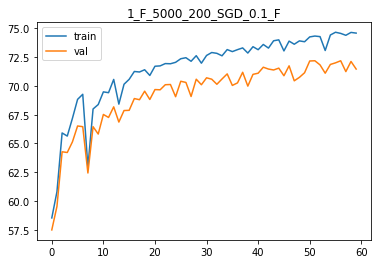

After training for 10 epochs
Train Acc 74.595
Val Acc 71.44
Test Acc 73.6
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.1
Epoch: [1/10], Step: [201/625], Validation Acc: 80.44
Epoch: [1/10], Step: [301/625], Validation Acc: 83.26
Epoch: [1/10], Step: [401/625], Validation Acc: 82.76
Epoch: [1/10], Step: [501/625], Validation Acc: 83.32
Epoch: [1/10], Step: [601/625], Validation Acc: 83.58
Epoch: [2/10], Step: [101/625], Validation Acc: 83.32
Epoch: [2/10], Step: [201/625], Validation Acc: 82.78
Epoch: [2/10], Step: [301/625], Validation Acc: 82.32
Epoch: [2/10], Step: [401/625], Validation Acc: 82.94
Epoch: [2/10], Step: [501/625], Validation Acc: 82.8
Epoch: [2/10], Step: [601/625], Validation Acc: 82.88
Epoch: [3/10], Step: [101/625], Validation Acc: 83.04
Epoch: [3/10], Step: [201/625], Validation Acc: 82.76
Epoch: [3/10], Step: [301/625], Validation Ac

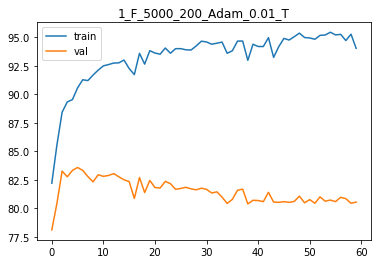

After training for 10 epochs
Train Acc 95.215
Val Acc 80.54
Test Acc 81.972
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 52.38
Epoch: [1/10], Step: [201/625], Validation Acc: 54.92
Epoch: [1/10], Step: [301/625], Validation Acc: 57.06
Epoch: [1/10], Step: [401/625], Validation Acc: 58.18
Epoch: [1/10], Step: [501/625], Validation Acc: 58.54
Epoch: [1/10], Step: [601/625], Validation Acc: 58.3
Epoch: [2/10], Step: [101/625], Validation Acc: 59.22
Epoch: [2/10], Step: [201/625], Validation Acc: 59.72
Epoch: [2/10], Step: [301/625], Validation Acc: 59.96
Epoch: [2/10], Step: [401/625], Validation Acc: 60.36
Epoch: [2/10], Step: [501/625], Validation Acc: 60.7
Epoch: [2/10], Step: [601/625], Validation Acc: 60.78
Epoch: [3/10], Step: [101/625], Validation Acc: 60.54
Epoch: [3/10], Step: [201/625], Validation Acc: 61.46
Epoch: [3/10], Step: [301/625], Validation A

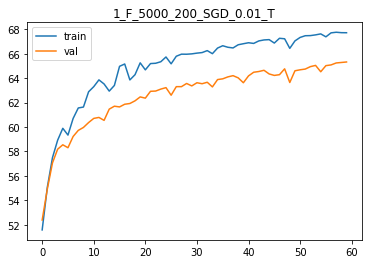

After training for 10 epochs
Train Acc 67.76
Val Acc 65.12
Test Acc 66.692
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.12
Epoch: [1/10], Step: [201/625], Validation Acc: 81.56
Epoch: [1/10], Step: [301/625], Validation Acc: 81.54
Epoch: [1/10], Step: [401/625], Validation Acc: 82.3
Epoch: [1/10], Step: [501/625], Validation Acc: 81.84
Epoch: [1/10], Step: [601/625], Validation Acc: 82.84
Epoch: [2/10], Step: [101/625], Validation Acc: 83.22
Epoch: [2/10], Step: [201/625], Validation Acc: 82.3
Epoch: [2/10], Step: [301/625], Validation Acc: 83.12
Epoch: [2/10], Step: [401/625], Validation Acc: 83.5
Epoch: [2/10], Step: [501/625], Validation Acc: 82.92
Epoch: [2/10], Step: [601/625], Validation Acc: 83.4
Epoch: [3/10], Step: [101/625], Validation Acc: 82.26
Epoch: [3/10], Step: [201/625], Validation Acc: 82.46
Epoch: [3/10], Step: [301/625], Validation Acc

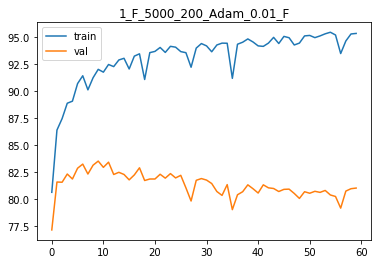

After training for 10 epochs
Train Acc 94.905
Val Acc 80.62
Test Acc 81.752
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.1
Epoch: [1/10], Step: [201/625], Validation Acc: 53.8
Epoch: [1/10], Step: [301/625], Validation Acc: 53.76
Epoch: [1/10], Step: [401/625], Validation Acc: 56.32
Epoch: [1/10], Step: [501/625], Validation Acc: 57.44
Epoch: [1/10], Step: [601/625], Validation Acc: 58.26
Epoch: [2/10], Step: [101/625], Validation Acc: 58.86
Epoch: [2/10], Step: [201/625], Validation Acc: 58.78
Epoch: [2/10], Step: [301/625], Validation Acc: 60.12
Epoch: [2/10], Step: [401/625], Validation Acc: 60.6
Epoch: [2/10], Step: [501/625], Validation Acc: 61.0
Epoch: [2/10], Step: [601/625], Validation Acc: 61.26
Epoch: [3/10], Step: [101/625], Validation Acc: 61.26
Epoch: [3/10], Step: [201/625], Validation Acc: 62.02
Epoch: [3/10], Step: [301/625], Validation Acc

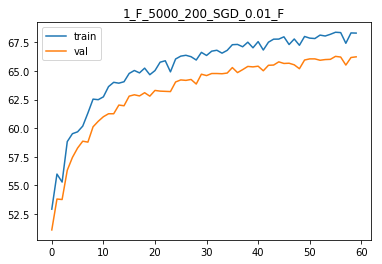

After training for 10 epochs
Train Acc 68.39
Val Acc 66.46
Test Acc 67.952
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 61.2
Epoch: [1/10], Step: [201/625], Validation Acc: 68.6
Epoch: [1/10], Step: [301/625], Validation Acc: 72.58
Epoch: [1/10], Step: [401/625], Validation Acc: 75.38
Epoch: [1/10], Step: [501/625], Validation Acc: 76.58
Epoch: [1/10], Step: [601/625], Validation Acc: 77.82
Epoch: [2/10], Step: [101/625], Validation Acc: 79.18
Epoch: [2/10], Step: [201/625], Validation Acc: 79.86
Epoch: [2/10], Step: [301/625], Validation Acc: 80.38
Epoch: [2/10], Step: [401/625], Validation Acc: 80.82
Epoch: [2/10], Step: [501/625], Validation Acc: 81.28
Epoch: [2/10], Step: [601/625], Validation Acc: 81.54
Epoch: [3/10], Step: [101/625], Validation Acc: 82.34
Epoch: [3/10], Step: [201/625], Validation Acc: 82.56
Epoch: [3/10], Step: [301/625], Validation 

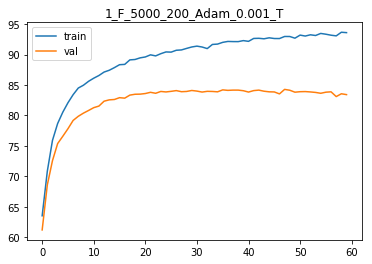

After training for 10 epochs
Train Acc 93.335
Val Acc 83.52
Test Acc 84.712
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 47.82
Epoch: [1/10], Step: [201/625], Validation Acc: 48.14
Epoch: [1/10], Step: [301/625], Validation Acc: 48.46
Epoch: [1/10], Step: [401/625], Validation Acc: 48.46
Epoch: [1/10], Step: [501/625], Validation Acc: 48.74
Epoch: [1/10], Step: [601/625], Validation Acc: 49.04
Epoch: [2/10], Step: [101/625], Validation Acc: 49.04
Epoch: [2/10], Step: [201/625], Validation Acc: 49.22
Epoch: [2/10], Step: [301/625], Validation Acc: 49.52
Epoch: [2/10], Step: [401/625], Validation Acc: 49.78
Epoch: [2/10], Step: [501/625], Validation Acc: 50.06
Epoch: [2/10], Step: [601/625], Validation Acc: 50.2
Epoch: [3/10], Step: [101/625], Validation Acc: 50.58
Epoch: [3/10], Step: [201/625], Validation Acc: 50.82
Epoch: [3/10], Step: [301/625], Validation

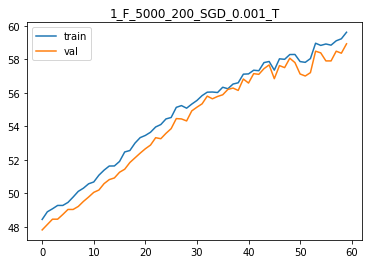

After training for 10 epochs
Train Acc 59.42
Val Acc 58.82
Test Acc 59.192
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 65.8
Epoch: [1/10], Step: [201/625], Validation Acc: 69.32
Epoch: [1/10], Step: [301/625], Validation Acc: 71.94
Epoch: [1/10], Step: [401/625], Validation Acc: 74.42
Epoch: [1/10], Step: [501/625], Validation Acc: 75.96
Epoch: [1/10], Step: [601/625], Validation Acc: 78.26
Epoch: [2/10], Step: [101/625], Validation Acc: 79.66
Epoch: [2/10], Step: [201/625], Validation Acc: 80.0
Epoch: [2/10], Step: [301/625], Validation Acc: 80.72
Epoch: [2/10], Step: [401/625], Validation Acc: 81.48
Epoch: [2/10], Step: [501/625], Validation Acc: 81.52
Epoch: [2/10], Step: [601/625], Validation Acc: 82.18
Epoch: [3/10], Step: [101/625], Validation Acc: 82.4
Epoch: [3/10], Step: [201/625], Validation Acc: 82.36
Epoch: [3/10], Step: [301/625], Validation A

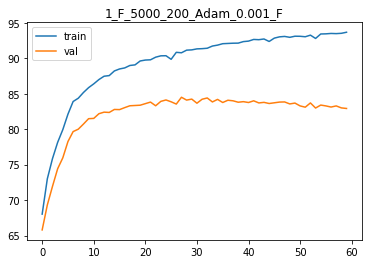

After training for 10 epochs
Train Acc 93.55
Val Acc 83.32
Test Acc 84.64
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 49.86
Epoch: [1/10], Step: [201/625], Validation Acc: 49.98
Epoch: [1/10], Step: [301/625], Validation Acc: 50.06
Epoch: [1/10], Step: [401/625], Validation Acc: 50.4
Epoch: [1/10], Step: [501/625], Validation Acc: 50.42
Epoch: [1/10], Step: [601/625], Validation Acc: 50.88
Epoch: [2/10], Step: [101/625], Validation Acc: 51.0
Epoch: [2/10], Step: [201/625], Validation Acc: 51.4
Epoch: [2/10], Step: [301/625], Validation Acc: 51.64
Epoch: [2/10], Step: [401/625], Validation Acc: 51.84
Epoch: [2/10], Step: [501/625], Validation Acc: 52.12
Epoch: [2/10], Step: [601/625], Validation Acc: 52.3
Epoch: [3/10], Step: [101/625], Validation Acc: 52.78
Epoch: [3/10], Step: [201/625], Validation Acc: 53.02
Epoch: [3/10], Step: [301/625], Validation Acc:

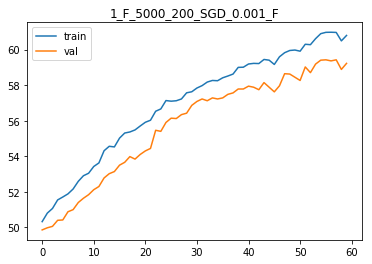

After training for 10 epochs
Train Acc 60.76
Val Acc 59.22
Test Acc 60.152
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.76
Epoch: [1/10], Step: [201/625], Validation Acc: 78.6
Epoch: [1/10], Step: [301/625], Validation Acc: 72.28
Epoch: [1/10], Step: [401/625], Validation Acc: 78.6
Epoch: [1/10], Step: [501/625], Validation Acc: 80.22
Epoch: [1/10], Step: [601/625], Validation Acc: 81.9
Epoch: [2/10], Step: [101/625], Validation Acc: 79.76
Epoch: [2/10], Step: [201/625], Validation Acc: 79.9
Epoch: [2/10], Step: [301/625], Validation Acc: 75.94
Epoch: [2/10], Step: [401/625], Validation Acc: 80.26
Epoch: [2/10], Step: [501/625], Validation Acc: 80.74
Epoch: [2/10], Step: [601/625], Validation Acc: 75.6
Epoch: [3/10], Step: [101/625], Validation Acc: 78.12
Epoch: [3/10], Step: [201/625], Validation Acc: 78.18
Epoch: [3/10], Step: [301/625], Validation Acc: 

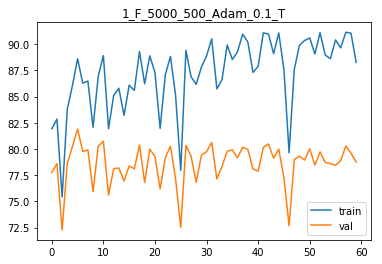

After training for 10 epochs
Train Acc 90.045
Val Acc 79.38
Test Acc 80.692
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 60.64
Epoch: [1/10], Step: [201/625], Validation Acc: 64.02
Epoch: [1/10], Step: [301/625], Validation Acc: 68.14
Epoch: [1/10], Step: [401/625], Validation Acc: 67.4
Epoch: [1/10], Step: [501/625], Validation Acc: 68.42
Epoch: [1/10], Step: [601/625], Validation Acc: 66.56
Epoch: [2/10], Step: [101/625], Validation Acc: 70.68
Epoch: [2/10], Step: [201/625], Validation Acc: 68.12
Epoch: [2/10], Step: [301/625], Validation Acc: 70.9
Epoch: [2/10], Step: [401/625], Validation Acc: 70.6
Epoch: [2/10], Step: [501/625], Validation Acc: 69.88
Epoch: [2/10], Step: [601/625], Validation Acc: 72.02
Epoch: [3/10], Step: [101/625], Validation Acc: 70.48
Epoch: [3/10], Step: [201/625], Validation Acc: 72.44
Epoch: [3/10], Step: [301/625], Validation Acc

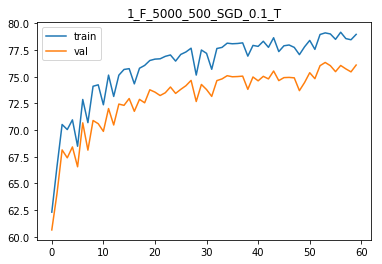

After training for 10 epochs
Train Acc 77.575
Val Acc 74.28
Test Acc 75.904
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 76.48
Epoch: [1/10], Step: [201/625], Validation Acc: 76.76
Epoch: [1/10], Step: [301/625], Validation Acc: 69.7
Epoch: [1/10], Step: [401/625], Validation Acc: 79.32
Epoch: [1/10], Step: [501/625], Validation Acc: 77.5
Epoch: [1/10], Step: [601/625], Validation Acc: 77.86
Epoch: [2/10], Step: [101/625], Validation Acc: 78.44
Epoch: [2/10], Step: [201/625], Validation Acc: 78.8
Epoch: [2/10], Step: [301/625], Validation Acc: 78.78
Epoch: [2/10], Step: [401/625], Validation Acc: 77.56
Epoch: [2/10], Step: [501/625], Validation Acc: 66.28
Epoch: [2/10], Step: [601/625], Validation Acc: 79.02
Epoch: [3/10], Step: [101/625], Validation Acc: 77.28
Epoch: [3/10], Step: [201/625], Validation Acc: 78.72
Epoch: [3/10], Step: [301/625], Validation Ac

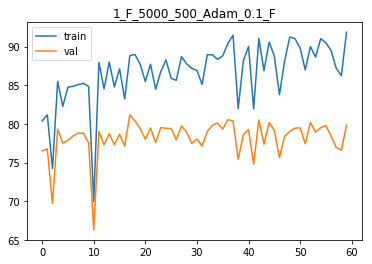

After training for 10 epochs
Train Acc 89.295
Val Acc 79.2
Test Acc 80.552
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.58
Epoch: [1/10], Step: [201/625], Validation Acc: 64.8
Epoch: [1/10], Step: [301/625], Validation Acc: 66.1
Epoch: [1/10], Step: [401/625], Validation Acc: 67.7
Epoch: [1/10], Step: [501/625], Validation Acc: 67.54
Epoch: [1/10], Step: [601/625], Validation Acc: 68.26
Epoch: [2/10], Step: [101/625], Validation Acc: 68.64
Epoch: [2/10], Step: [201/625], Validation Acc: 67.74
Epoch: [2/10], Step: [301/625], Validation Acc: 66.92
Epoch: [2/10], Step: [401/625], Validation Acc: 67.42
Epoch: [2/10], Step: [501/625], Validation Acc: 69.78
Epoch: [2/10], Step: [601/625], Validation Acc: 69.92
Epoch: [3/10], Step: [101/625], Validation Acc: 70.94
Epoch: [3/10], Step: [201/625], Validation Acc: 71.64
Epoch: [3/10], Step: [301/625], Validation Acc:

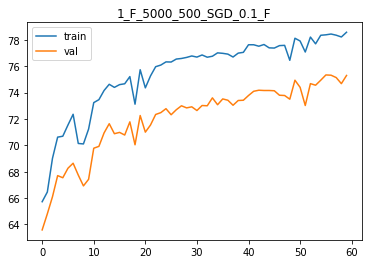

After training for 10 epochs
Train Acc 77.99
Val Acc 73.94
Test Acc 76.588
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.24
Epoch: [1/10], Step: [201/625], Validation Acc: 81.44
Epoch: [1/10], Step: [301/625], Validation Acc: 82.68
Epoch: [1/10], Step: [401/625], Validation Acc: 83.08
Epoch: [1/10], Step: [501/625], Validation Acc: 82.02
Epoch: [1/10], Step: [601/625], Validation Acc: 82.78
Epoch: [2/10], Step: [101/625], Validation Acc: 82.52
Epoch: [2/10], Step: [201/625], Validation Acc: 81.04
Epoch: [2/10], Step: [301/625], Validation Acc: 81.9
Epoch: [2/10], Step: [401/625], Validation Acc: 82.08
Epoch: [2/10], Step: [501/625], Validation Acc: 80.9
Epoch: [2/10], Step: [601/625], Validation Acc: 82.68
Epoch: [3/10], Step: [101/625], Validation Acc: 82.22
Epoch: [3/10], Step: [201/625], Validation Acc: 81.74
Epoch: [3/10], Step: [301/625], Validation A

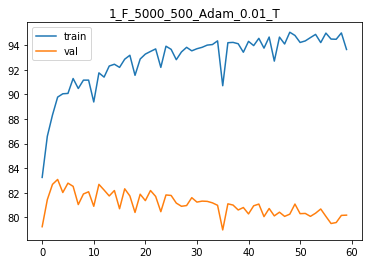

After training for 10 epochs
Train Acc 95.14
Val Acc 80.76
Test Acc 82.108
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 56.5
Epoch: [1/10], Step: [201/625], Validation Acc: 58.82
Epoch: [1/10], Step: [301/625], Validation Acc: 58.64
Epoch: [1/10], Step: [401/625], Validation Acc: 59.44
Epoch: [1/10], Step: [501/625], Validation Acc: 61.64
Epoch: [1/10], Step: [601/625], Validation Acc: 61.94
Epoch: [2/10], Step: [101/625], Validation Acc: 61.84
Epoch: [2/10], Step: [201/625], Validation Acc: 63.14
Epoch: [2/10], Step: [301/625], Validation Acc: 62.58
Epoch: [2/10], Step: [401/625], Validation Acc: 64.16
Epoch: [2/10], Step: [501/625], Validation Acc: 64.52
Epoch: [2/10], Step: [601/625], Validation Acc: 64.58
Epoch: [3/10], Step: [101/625], Validation Acc: 64.44
Epoch: [3/10], Step: [201/625], Validation Acc: 64.84
Epoch: [3/10], Step: [301/625], Validation A

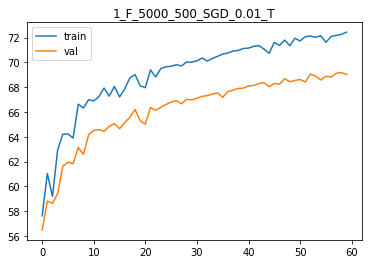

After training for 10 epochs
Train Acc 71.75
Val Acc 69.02
Test Acc 71.544
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 80.7
Epoch: [1/10], Step: [201/625], Validation Acc: 78.98
Epoch: [1/10], Step: [301/625], Validation Acc: 80.44
Epoch: [1/10], Step: [401/625], Validation Acc: 82.66
Epoch: [1/10], Step: [501/625], Validation Acc: 82.74
Epoch: [1/10], Step: [601/625], Validation Acc: 81.92
Epoch: [2/10], Step: [101/625], Validation Acc: 81.54
Epoch: [2/10], Step: [201/625], Validation Acc: 81.22
Epoch: [2/10], Step: [301/625], Validation Acc: 82.92
Epoch: [2/10], Step: [401/625], Validation Acc: 83.16
Epoch: [2/10], Step: [501/625], Validation Acc: 82.96
Epoch: [2/10], Step: [601/625], Validation Acc: 82.64
Epoch: [3/10], Step: [101/625], Validation Acc: 81.7
Epoch: [3/10], Step: [201/625], Validation Acc: 81.88
Epoch: [3/10], Step: [301/625], Validation A

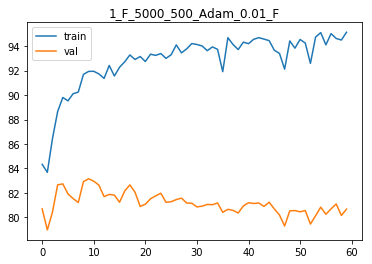

After training for 10 epochs
Train Acc 94.77
Val Acc 80.24
Test Acc 81.808
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 54.7
Epoch: [1/10], Step: [201/625], Validation Acc: 58.96
Epoch: [1/10], Step: [301/625], Validation Acc: 60.88
Epoch: [1/10], Step: [401/625], Validation Acc: 61.32
Epoch: [1/10], Step: [501/625], Validation Acc: 59.76
Epoch: [1/10], Step: [601/625], Validation Acc: 61.7
Epoch: [2/10], Step: [101/625], Validation Acc: 63.46
Epoch: [2/10], Step: [201/625], Validation Acc: 63.4
Epoch: [2/10], Step: [301/625], Validation Acc: 62.44
Epoch: [2/10], Step: [401/625], Validation Acc: 64.66
Epoch: [2/10], Step: [501/625], Validation Acc: 64.34
Epoch: [2/10], Step: [601/625], Validation Acc: 64.62
Epoch: [3/10], Step: [101/625], Validation Acc: 65.1
Epoch: [3/10], Step: [201/625], Validation Acc: 64.84
Epoch: [3/10], Step: [301/625], Validation Acc:

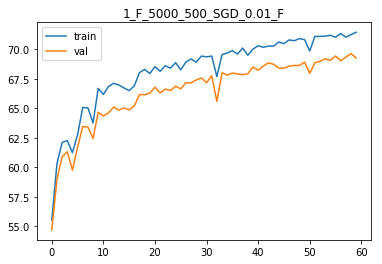

After training for 10 epochs
Train Acc 71.445
Val Acc 69.18
Test Acc 71.308
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 65.14
Epoch: [1/10], Step: [201/625], Validation Acc: 71.18
Epoch: [1/10], Step: [301/625], Validation Acc: 74.48
Epoch: [1/10], Step: [401/625], Validation Acc: 76.18
Epoch: [1/10], Step: [501/625], Validation Acc: 78.36
Epoch: [1/10], Step: [601/625], Validation Acc: 79.98
Epoch: [2/10], Step: [101/625], Validation Acc: 79.84
Epoch: [2/10], Step: [201/625], Validation Acc: 81.62
Epoch: [2/10], Step: [301/625], Validation Acc: 82.06
Epoch: [2/10], Step: [401/625], Validation Acc: 82.68
Epoch: [2/10], Step: [501/625], Validation Acc: 82.76
Epoch: [2/10], Step: [601/625], Validation Acc: 83.24
Epoch: [3/10], Step: [101/625], Validation Acc: 83.26
Epoch: [3/10], Step: [201/625], Validation Acc: 83.68
Epoch: [3/10], Step: [301/625], Validati

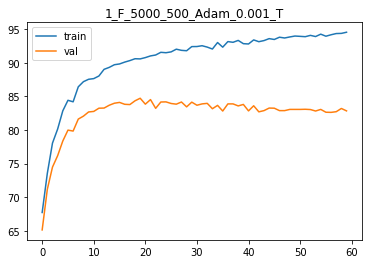

After training for 10 epochs
Train Acc 94.615
Val Acc 82.6
Test Acc 83.892
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.96
Epoch: [1/10], Step: [201/625], Validation Acc: 51.44
Epoch: [1/10], Step: [301/625], Validation Acc: 51.6
Epoch: [1/10], Step: [401/625], Validation Acc: 52.18
Epoch: [1/10], Step: [501/625], Validation Acc: 53.46
Epoch: [1/10], Step: [601/625], Validation Acc: 53.78
Epoch: [2/10], Step: [101/625], Validation Acc: 54.54
Epoch: [2/10], Step: [201/625], Validation Acc: 55.5
Epoch: [2/10], Step: [301/625], Validation Acc: 55.84
Epoch: [2/10], Step: [401/625], Validation Acc: 56.3
Epoch: [2/10], Step: [501/625], Validation Acc: 56.3
Epoch: [2/10], Step: [601/625], Validation Acc: 56.44
Epoch: [3/10], Step: [101/625], Validation Acc: 57.72
Epoch: [3/10], Step: [201/625], Validation Acc: 57.42
Epoch: [3/10], Step: [301/625], Validation Acc

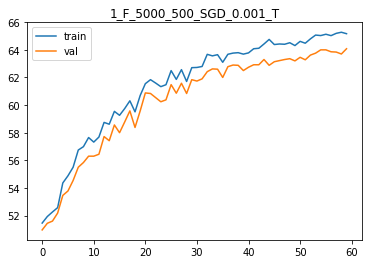

After training for 10 epochs
Train Acc 65.31
Val Acc 63.88
Test Acc 65.124
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 67.7
Epoch: [1/10], Step: [201/625], Validation Acc: 72.06
Epoch: [1/10], Step: [301/625], Validation Acc: 73.98
Epoch: [1/10], Step: [401/625], Validation Acc: 77.84
Epoch: [1/10], Step: [501/625], Validation Acc: 78.98
Epoch: [1/10], Step: [601/625], Validation Acc: 79.9
Epoch: [2/10], Step: [101/625], Validation Acc: 80.86
Epoch: [2/10], Step: [201/625], Validation Acc: 81.5
Epoch: [2/10], Step: [301/625], Validation Acc: 82.06
Epoch: [2/10], Step: [401/625], Validation Acc: 82.02
Epoch: [2/10], Step: [501/625], Validation Acc: 83.14
Epoch: [2/10], Step: [601/625], Validation Acc: 83.36
Epoch: [3/10], Step: [101/625], Validation Acc: 83.66
Epoch: [3/10], Step: [201/625], Validation Acc: 83.78
Epoch: [3/10], Step: [301/625], Validation A

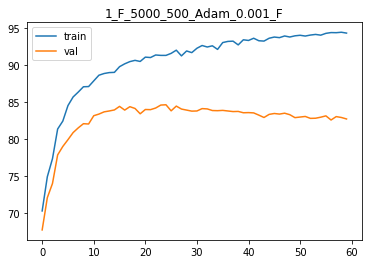

After training for 10 epochs
Train Acc 94.595
Val Acc 82.94
Test Acc 83.876
ngram:  1
use all_ngram? :  F
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 49.96
Epoch: [1/10], Step: [201/625], Validation Acc: 50.9
Epoch: [1/10], Step: [301/625], Validation Acc: 51.32
Epoch: [1/10], Step: [401/625], Validation Acc: 52.4
Epoch: [1/10], Step: [501/625], Validation Acc: 52.84
Epoch: [1/10], Step: [601/625], Validation Acc: 53.1
Epoch: [2/10], Step: [101/625], Validation Acc: 53.66
Epoch: [2/10], Step: [201/625], Validation Acc: 54.02
Epoch: [2/10], Step: [301/625], Validation Acc: 54.22
Epoch: [2/10], Step: [401/625], Validation Acc: 54.74
Epoch: [2/10], Step: [501/625], Validation Acc: 55.26
Epoch: [2/10], Step: [601/625], Validation Acc: 55.3
Epoch: [3/10], Step: [101/625], Validation Acc: 55.6
Epoch: [3/10], Step: [201/625], Validation Acc: 55.92
Epoch: [3/10], Step: [301/625], Validation Acc

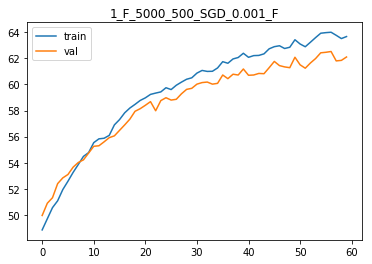

After training for 10 epochs
Train Acc 64.25
Val Acc 62.24
Test Acc 63.552
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 80.28
Epoch: [1/10], Step: [201/625], Validation Acc: 79.08
Epoch: [1/10], Step: [301/625], Validation Acc: 80.82
Epoch: [1/10], Step: [401/625], Validation Acc: 81.12
Epoch: [1/10], Step: [501/625], Validation Acc: 79.16
Epoch: [1/10], Step: [601/625], Validation Acc: 79.78
Epoch: [2/10], Step: [101/625], Validation Acc: 80.56
Epoch: [2/10], Step: [201/625], Validation Acc: 79.56
Epoch: [2/10], Step: [301/625], Validation Acc: 80.08
Epoch: [2/10], Step: [401/625], Validation Acc: 76.08
Epoch: [2/10], Step: [501/625], Validation Acc: 80.96
Epoch: [2/10], Step: [601/625], Validation Acc: 80.16
Epoch: [3/10], Step: [101/625], Validation Acc: 79.08
Epoch: [3/10], Step: [201/625], Validation Acc: 79.5
Epoch: [3/10], Step: [301/625], Validation 

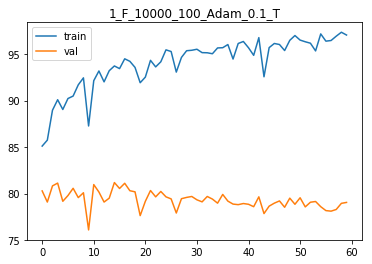

After training for 10 epochs
Train Acc 96.34
Val Acc 78.22
Test Acc 79.748
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 55.5
Epoch: [1/10], Step: [201/625], Validation Acc: 58.9
Epoch: [1/10], Step: [301/625], Validation Acc: 57.24
Epoch: [1/10], Step: [401/625], Validation Acc: 61.04
Epoch: [1/10], Step: [501/625], Validation Acc: 61.52
Epoch: [1/10], Step: [601/625], Validation Acc: 61.86
Epoch: [2/10], Step: [101/625], Validation Acc: 62.4
Epoch: [2/10], Step: [201/625], Validation Acc: 62.34
Epoch: [2/10], Step: [301/625], Validation Acc: 62.08
Epoch: [2/10], Step: [401/625], Validation Acc: 62.74
Epoch: [2/10], Step: [501/625], Validation Acc: 63.12
Epoch: [2/10], Step: [601/625], Validation Acc: 63.12
Epoch: [3/10], Step: [101/625], Validation Acc: 63.28
Epoch: [3/10], Step: [201/625], Validation Acc: 63.14
Epoch: [3/10], Step: [301/625], Validation Acc

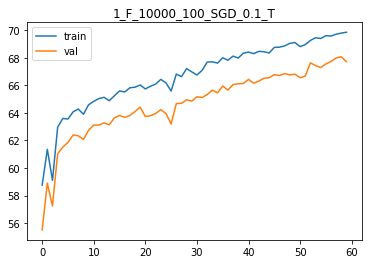

After training for 10 epochs
Train Acc 69.92
Val Acc 67.6
Test Acc 69.372
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.6
Epoch: [1/10], Step: [201/625], Validation Acc: 79.96
Epoch: [1/10], Step: [301/625], Validation Acc: 80.72
Epoch: [1/10], Step: [401/625], Validation Acc: 79.38
Epoch: [1/10], Step: [501/625], Validation Acc: 80.98
Epoch: [1/10], Step: [601/625], Validation Acc: 80.26
Epoch: [2/10], Step: [101/625], Validation Acc: 79.12
Epoch: [2/10], Step: [201/625], Validation Acc: 80.1
Epoch: [2/10], Step: [301/625], Validation Acc: 75.52
Epoch: [2/10], Step: [401/625], Validation Acc: 81.1
Epoch: [2/10], Step: [501/625], Validation Acc: 80.9
Epoch: [2/10], Step: [601/625], Validation Acc: 80.1
Epoch: [3/10], Step: [101/625], Validation Acc: 80.12
Epoch: [3/10], Step: [201/625], Validation Acc: 79.08
Epoch: [3/10], Step: [301/625], Validation Acc: 

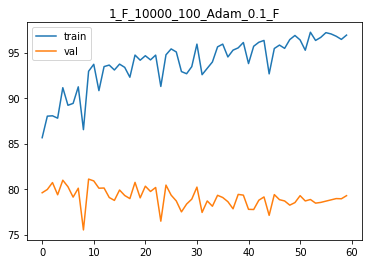

After training for 10 epochs
Train Acc 96.645
Val Acc 78.04
Test Acc 79.764
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.4
Epoch: [1/10], Step: [201/625], Validation Acc: 61.32
Epoch: [1/10], Step: [301/625], Validation Acc: 63.26
Epoch: [1/10], Step: [401/625], Validation Acc: 63.04
Epoch: [1/10], Step: [501/625], Validation Acc: 63.26
Epoch: [1/10], Step: [601/625], Validation Acc: 63.36
Epoch: [2/10], Step: [101/625], Validation Acc: 63.32
Epoch: [2/10], Step: [201/625], Validation Acc: 63.88
Epoch: [2/10], Step: [301/625], Validation Acc: 64.32
Epoch: [2/10], Step: [401/625], Validation Acc: 65.18
Epoch: [2/10], Step: [501/625], Validation Acc: 64.94
Epoch: [2/10], Step: [601/625], Validation Acc: 65.16
Epoch: [3/10], Step: [101/625], Validation Acc: 65.14
Epoch: [3/10], Step: [201/625], Validation Acc: 65.7
Epoch: [3/10], Step: [301/625], Validation A

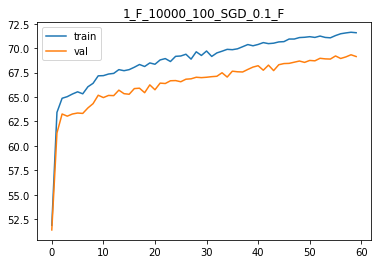

After training for 10 epochs
Train Acc 71.78
Val Acc 69.3
Test Acc 70.816
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 76.74
Epoch: [1/10], Step: [201/625], Validation Acc: 81.14
Epoch: [1/10], Step: [301/625], Validation Acc: 82.6
Epoch: [1/10], Step: [401/625], Validation Acc: 82.7
Epoch: [1/10], Step: [501/625], Validation Acc: 82.44
Epoch: [1/10], Step: [601/625], Validation Acc: 83.26
Epoch: [2/10], Step: [101/625], Validation Acc: 82.84
Epoch: [2/10], Step: [201/625], Validation Acc: 83.16
Epoch: [2/10], Step: [301/625], Validation Acc: 83.06
Epoch: [2/10], Step: [401/625], Validation Acc: 82.4
Epoch: [2/10], Step: [501/625], Validation Acc: 82.96
Epoch: [2/10], Step: [601/625], Validation Acc: 82.36
Epoch: [3/10], Step: [101/625], Validation Acc: 82.06
Epoch: [3/10], Step: [201/625], Validation Acc: 82.3
Epoch: [3/10], Step: [301/625], Validation Acc

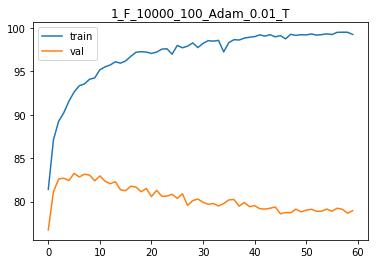

After training for 10 epochs
Train Acc 99.385
Val Acc 79.0
Test Acc 80.56
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 51.84
Epoch: [1/10], Step: [201/625], Validation Acc: 52.38
Epoch: [1/10], Step: [301/625], Validation Acc: 52.6
Epoch: [1/10], Step: [401/625], Validation Acc: 53.54
Epoch: [1/10], Step: [501/625], Validation Acc: 54.46
Epoch: [1/10], Step: [601/625], Validation Acc: 55.96
Epoch: [2/10], Step: [101/625], Validation Acc: 56.54
Epoch: [2/10], Step: [201/625], Validation Acc: 56.52
Epoch: [2/10], Step: [301/625], Validation Acc: 57.52
Epoch: [2/10], Step: [401/625], Validation Acc: 58.66
Epoch: [2/10], Step: [501/625], Validation Acc: 58.86
Epoch: [2/10], Step: [601/625], Validation Acc: 59.38
Epoch: [3/10], Step: [101/625], Validation Acc: 59.84
Epoch: [3/10], Step: [201/625], Validation Acc: 59.3
Epoch: [3/10], Step: [301/625], Validation Ac

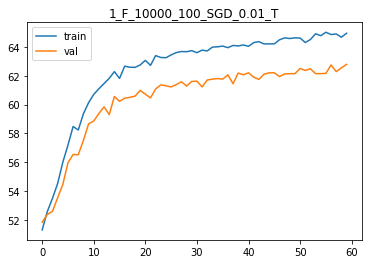

After training for 10 epochs
Train Acc 65.16
Val Acc 62.32
Test Acc 63.928
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.4
Epoch: [1/10], Step: [201/625], Validation Acc: 81.24
Epoch: [1/10], Step: [301/625], Validation Acc: 82.14
Epoch: [1/10], Step: [401/625], Validation Acc: 82.8
Epoch: [1/10], Step: [501/625], Validation Acc: 83.32
Epoch: [1/10], Step: [601/625], Validation Acc: 83.64
Epoch: [2/10], Step: [101/625], Validation Acc: 82.12
Epoch: [2/10], Step: [201/625], Validation Acc: 83.44
Epoch: [2/10], Step: [301/625], Validation Acc: 82.28
Epoch: [2/10], Step: [401/625], Validation Acc: 82.72
Epoch: [2/10], Step: [501/625], Validation Acc: 83.0
Epoch: [2/10], Step: [601/625], Validation Acc: 82.36
Epoch: [3/10], Step: [101/625], Validation Acc: 81.86
Epoch: [3/10], Step: [201/625], Validation Acc: 82.26
Epoch: [3/10], Step: [301/625], Validation A

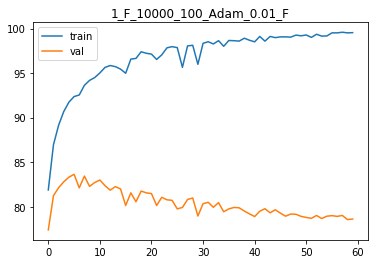

After training for 10 epochs
Train Acc 99.56
Val Acc 78.46
Test Acc 80.216
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 52.9
Epoch: [1/10], Step: [201/625], Validation Acc: 54.16
Epoch: [1/10], Step: [301/625], Validation Acc: 54.42
Epoch: [1/10], Step: [401/625], Validation Acc: 54.2
Epoch: [1/10], Step: [501/625], Validation Acc: 55.96
Epoch: [1/10], Step: [601/625], Validation Acc: 55.8
Epoch: [2/10], Step: [101/625], Validation Acc: 56.78
Epoch: [2/10], Step: [201/625], Validation Acc: 55.62
Epoch: [2/10], Step: [301/625], Validation Acc: 56.7
Epoch: [2/10], Step: [401/625], Validation Acc: 56.9
Epoch: [2/10], Step: [501/625], Validation Acc: 58.22
Epoch: [2/10], Step: [601/625], Validation Acc: 58.42
Epoch: [3/10], Step: [101/625], Validation Acc: 57.74
Epoch: [3/10], Step: [201/625], Validation Acc: 57.76
Epoch: [3/10], Step: [301/625], Validation Acc:

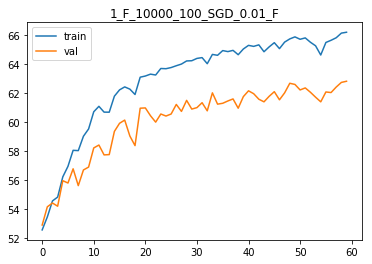

After training for 10 epochs
Train Acc 66.19
Val Acc 62.66
Test Acc 64.704
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 60.54
Epoch: [1/10], Step: [201/625], Validation Acc: 65.88
Epoch: [1/10], Step: [301/625], Validation Acc: 68.78
Epoch: [1/10], Step: [401/625], Validation Acc: 71.36
Epoch: [1/10], Step: [501/625], Validation Acc: 73.76
Epoch: [1/10], Step: [601/625], Validation Acc: 75.7
Epoch: [2/10], Step: [101/625], Validation Acc: 77.18
Epoch: [2/10], Step: [201/625], Validation Acc: 78.2
Epoch: [2/10], Step: [301/625], Validation Acc: 79.24
Epoch: [2/10], Step: [401/625], Validation Acc: 80.18
Epoch: [2/10], Step: [501/625], Validation Acc: 80.36
Epoch: [2/10], Step: [601/625], Validation Acc: 80.76
Epoch: [3/10], Step: [101/625], Validation Acc: 81.28
Epoch: [3/10], Step: [201/625], Validation Acc: 81.68
Epoch: [3/10], Step: [301/625], Validation

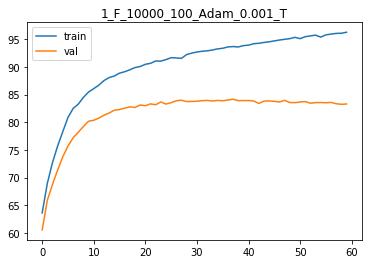

After training for 10 epochs
Train Acc 96.265
Val Acc 83.16
Test Acc 84.512
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.52
Epoch: [1/10], Step: [201/625], Validation Acc: 50.52
Epoch: [1/10], Step: [301/625], Validation Acc: 50.66
Epoch: [1/10], Step: [401/625], Validation Acc: 50.64
Epoch: [1/10], Step: [501/625], Validation Acc: 51.18
Epoch: [1/10], Step: [601/625], Validation Acc: 51.18
Epoch: [2/10], Step: [101/625], Validation Acc: 50.86
Epoch: [2/10], Step: [201/625], Validation Acc: 51.14
Epoch: [2/10], Step: [301/625], Validation Acc: 51.4
Epoch: [2/10], Step: [401/625], Validation Acc: 51.4
Epoch: [2/10], Step: [501/625], Validation Acc: 51.62
Epoch: [2/10], Step: [601/625], Validation Acc: 51.94
Epoch: [3/10], Step: [101/625], Validation Acc: 52.02
Epoch: [3/10], Step: [201/625], Validation Acc: 52.16
Epoch: [3/10], Step: [301/625], Validation

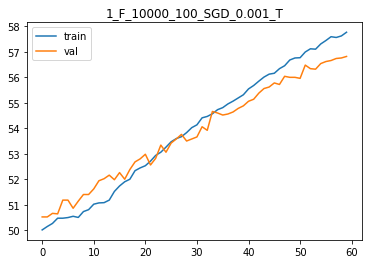

After training for 10 epochs
Train Acc 57.775
Val Acc 56.94
Test Acc 56.76
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 59.28
Epoch: [1/10], Step: [201/625], Validation Acc: 66.9
Epoch: [1/10], Step: [301/625], Validation Acc: 70.04
Epoch: [1/10], Step: [401/625], Validation Acc: 72.1
Epoch: [1/10], Step: [501/625], Validation Acc: 75.46
Epoch: [1/10], Step: [601/625], Validation Acc: 77.0
Epoch: [2/10], Step: [101/625], Validation Acc: 78.04
Epoch: [2/10], Step: [201/625], Validation Acc: 78.98
Epoch: [2/10], Step: [301/625], Validation Acc: 79.8
Epoch: [2/10], Step: [401/625], Validation Acc: 80.68
Epoch: [2/10], Step: [501/625], Validation Acc: 80.98
Epoch: [2/10], Step: [601/625], Validation Acc: 81.78
Epoch: [3/10], Step: [101/625], Validation Acc: 82.26
Epoch: [3/10], Step: [201/625], Validation Acc: 82.06
Epoch: [3/10], Step: [301/625], Validation A

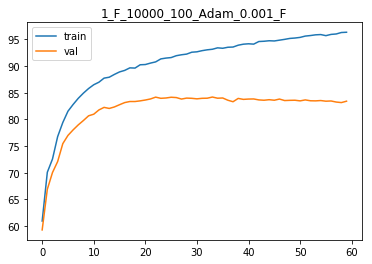

After training for 10 epochs
Train Acc 96.405
Val Acc 82.98
Test Acc 84.468
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.72
Epoch: [1/10], Step: [201/625], Validation Acc: 50.8
Epoch: [1/10], Step: [301/625], Validation Acc: 50.8
Epoch: [1/10], Step: [401/625], Validation Acc: 51.26
Epoch: [1/10], Step: [501/625], Validation Acc: 51.12
Epoch: [1/10], Step: [601/625], Validation Acc: 50.98
Epoch: [2/10], Step: [101/625], Validation Acc: 51.14
Epoch: [2/10], Step: [201/625], Validation Acc: 51.32
Epoch: [2/10], Step: [301/625], Validation Acc: 51.56
Epoch: [2/10], Step: [401/625], Validation Acc: 51.42
Epoch: [2/10], Step: [501/625], Validation Acc: 51.86
Epoch: [2/10], Step: [601/625], Validation Acc: 51.84
Epoch: [3/10], Step: [101/625], Validation Acc: 51.9
Epoch: [3/10], Step: [201/625], Validation Acc: 52.22
Epoch: [3/10], Step: [301/625], Validation 

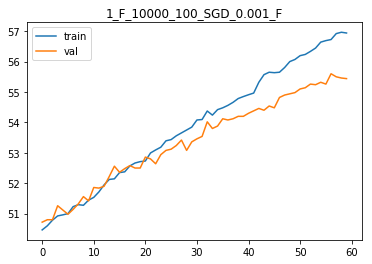

After training for 10 epochs
Train Acc 56.9
Val Acc 55.5
Test Acc 56.676
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.78
Epoch: [1/10], Step: [201/625], Validation Acc: 79.58
Epoch: [1/10], Step: [301/625], Validation Acc: 80.16
Epoch: [1/10], Step: [401/625], Validation Acc: 74.44
Epoch: [1/10], Step: [501/625], Validation Acc: 76.5
Epoch: [1/10], Step: [601/625], Validation Acc: 78.9
Epoch: [2/10], Step: [101/625], Validation Acc: 80.34
Epoch: [2/10], Step: [201/625], Validation Acc: 81.02
Epoch: [2/10], Step: [301/625], Validation Acc: 79.08
Epoch: [2/10], Step: [401/625], Validation Acc: 81.16
Epoch: [2/10], Step: [501/625], Validation Acc: 78.82
Epoch: [2/10], Step: [601/625], Validation Acc: 76.44
Epoch: [3/10], Step: [101/625], Validation Acc: 77.14
Epoch: [3/10], Step: [201/625], Validation Acc: 79.24
Epoch: [3/10], Step: [301/625], Validation Acc

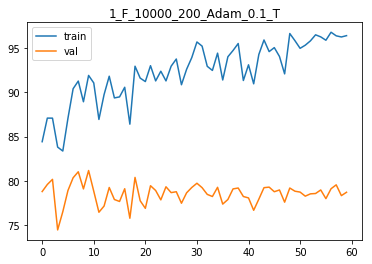

After training for 10 epochs
Train Acc 95.37
Val Acc 78.44
Test Acc 80.208
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 60.46
Epoch: [1/10], Step: [201/625], Validation Acc: 58.24
Epoch: [1/10], Step: [301/625], Validation Acc: 61.32
Epoch: [1/10], Step: [401/625], Validation Acc: 64.74
Epoch: [1/10], Step: [501/625], Validation Acc: 64.76
Epoch: [1/10], Step: [601/625], Validation Acc: 65.92
Epoch: [2/10], Step: [101/625], Validation Acc: 66.62
Epoch: [2/10], Step: [201/625], Validation Acc: 65.48
Epoch: [2/10], Step: [301/625], Validation Acc: 66.7
Epoch: [2/10], Step: [401/625], Validation Acc: 67.0
Epoch: [2/10], Step: [501/625], Validation Acc: 67.46
Epoch: [2/10], Step: [601/625], Validation Acc: 67.22
Epoch: [3/10], Step: [101/625], Validation Acc: 68.08
Epoch: [3/10], Step: [201/625], Validation Acc: 67.88
Epoch: [3/10], Step: [301/625], Validation Ac

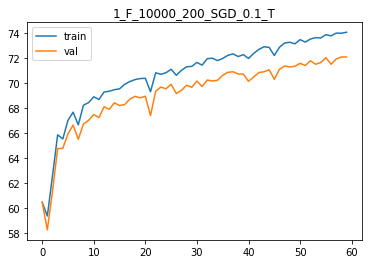

After training for 10 epochs
Train Acc 73.965
Val Acc 72.14
Test Acc 73.384
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.12
Epoch: [1/10], Step: [201/625], Validation Acc: 79.64
Epoch: [1/10], Step: [301/625], Validation Acc: 71.48
Epoch: [1/10], Step: [401/625], Validation Acc: 80.16
Epoch: [1/10], Step: [501/625], Validation Acc: 79.1
Epoch: [1/10], Step: [601/625], Validation Acc: 81.76
Epoch: [2/10], Step: [101/625], Validation Acc: 81.14
Epoch: [2/10], Step: [201/625], Validation Acc: 78.9
Epoch: [2/10], Step: [301/625], Validation Acc: 78.56
Epoch: [2/10], Step: [401/625], Validation Acc: 79.08
Epoch: [2/10], Step: [501/625], Validation Acc: 78.28
Epoch: [2/10], Step: [601/625], Validation Acc: 79.7
Epoch: [3/10], Step: [101/625], Validation Acc: 79.62
Epoch: [3/10], Step: [201/625], Validation Acc: 80.98
Epoch: [3/10], Step: [301/625], Validation A

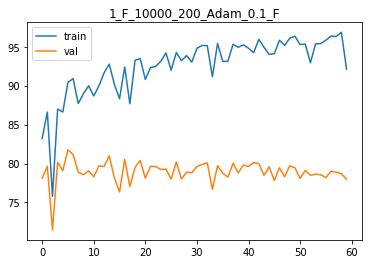

After training for 10 epochs
Train Acc 96.345
Val Acc 78.62
Test Acc 80.28
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.04
Epoch: [1/10], Step: [201/625], Validation Acc: 66.1
Epoch: [1/10], Step: [301/625], Validation Acc: 63.02
Epoch: [1/10], Step: [401/625], Validation Acc: 65.92
Epoch: [1/10], Step: [501/625], Validation Acc: 66.32
Epoch: [1/10], Step: [601/625], Validation Acc: 66.66
Epoch: [2/10], Step: [101/625], Validation Acc: 67.2
Epoch: [2/10], Step: [201/625], Validation Acc: 65.98
Epoch: [2/10], Step: [301/625], Validation Acc: 68.1
Epoch: [2/10], Step: [401/625], Validation Acc: 67.06
Epoch: [2/10], Step: [501/625], Validation Acc: 68.54
Epoch: [2/10], Step: [601/625], Validation Acc: 67.6
Epoch: [3/10], Step: [101/625], Validation Acc: 68.66
Epoch: [3/10], Step: [201/625], Validation Acc: 64.74
Epoch: [3/10], Step: [301/625], Validation Acc:

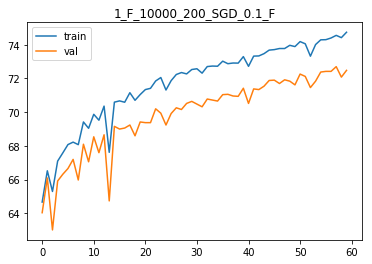

After training for 10 epochs
Train Acc 74.595
Val Acc 72.84
Test Acc 73.948
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 76.8
Epoch: [1/10], Step: [201/625], Validation Acc: 81.36
Epoch: [1/10], Step: [301/625], Validation Acc: 82.04
Epoch: [1/10], Step: [401/625], Validation Acc: 82.46
Epoch: [1/10], Step: [501/625], Validation Acc: 83.22
Epoch: [1/10], Step: [601/625], Validation Acc: 81.5
Epoch: [2/10], Step: [101/625], Validation Acc: 83.44
Epoch: [2/10], Step: [201/625], Validation Acc: 82.52
Epoch: [2/10], Step: [301/625], Validation Acc: 82.0
Epoch: [2/10], Step: [401/625], Validation Acc: 81.96
Epoch: [2/10], Step: [501/625], Validation Acc: 82.28
Epoch: [2/10], Step: [601/625], Validation Acc: 81.88
Epoch: [3/10], Step: [101/625], Validation Acc: 81.8
Epoch: [3/10], Step: [201/625], Validation Acc: 81.34
Epoch: [3/10], Step: [301/625], Validation A

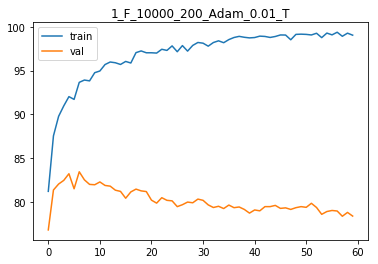

After training for 10 epochs
Train Acc 99.34
Val Acc 78.8
Test Acc 80.028
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 52.22
Epoch: [1/10], Step: [201/625], Validation Acc: 56.0
Epoch: [1/10], Step: [301/625], Validation Acc: 57.3
Epoch: [1/10], Step: [401/625], Validation Acc: 58.84
Epoch: [1/10], Step: [501/625], Validation Acc: 59.28
Epoch: [1/10], Step: [601/625], Validation Acc: 59.56
Epoch: [2/10], Step: [101/625], Validation Acc: 61.2
Epoch: [2/10], Step: [201/625], Validation Acc: 61.24
Epoch: [2/10], Step: [301/625], Validation Acc: 61.32
Epoch: [2/10], Step: [401/625], Validation Acc: 62.12
Epoch: [2/10], Step: [501/625], Validation Acc: 62.08
Epoch: [2/10], Step: [601/625], Validation Acc: 62.0
Epoch: [3/10], Step: [101/625], Validation Acc: 62.66
Epoch: [3/10], Step: [201/625], Validation Acc: 63.18
Epoch: [3/10], Step: [301/625], Validation Acc:

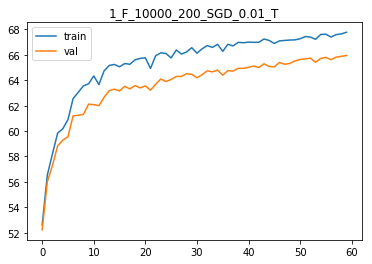

After training for 10 epochs
Train Acc 67.65
Val Acc 65.82
Test Acc 67.62
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.58
Epoch: [1/10], Step: [201/625], Validation Acc: 81.52
Epoch: [1/10], Step: [301/625], Validation Acc: 82.48
Epoch: [1/10], Step: [401/625], Validation Acc: 82.44
Epoch: [1/10], Step: [501/625], Validation Acc: 82.06
Epoch: [1/10], Step: [601/625], Validation Acc: 83.5
Epoch: [2/10], Step: [101/625], Validation Acc: 82.56
Epoch: [2/10], Step: [201/625], Validation Acc: 83.32
Epoch: [2/10], Step: [301/625], Validation Acc: 82.54
Epoch: [2/10], Step: [401/625], Validation Acc: 80.5
Epoch: [2/10], Step: [501/625], Validation Acc: 82.42
Epoch: [2/10], Step: [601/625], Validation Acc: 81.28
Epoch: [3/10], Step: [101/625], Validation Acc: 80.3
Epoch: [3/10], Step: [201/625], Validation Acc: 81.5
Epoch: [3/10], Step: [301/625], Validation Acc

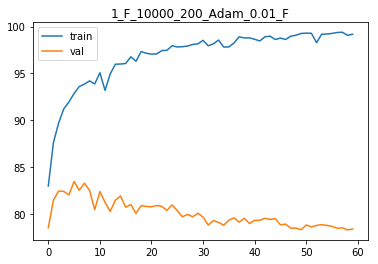

After training for 10 epochs
Train Acc 99.265
Val Acc 78.22
Test Acc 80.048
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.58
Epoch: [1/10], Step: [201/625], Validation Acc: 52.08
Epoch: [1/10], Step: [301/625], Validation Acc: 53.76
Epoch: [1/10], Step: [401/625], Validation Acc: 55.52
Epoch: [1/10], Step: [501/625], Validation Acc: 56.6
Epoch: [1/10], Step: [601/625], Validation Acc: 57.18
Epoch: [2/10], Step: [101/625], Validation Acc: 58.22
Epoch: [2/10], Step: [201/625], Validation Acc: 58.92
Epoch: [2/10], Step: [301/625], Validation Acc: 58.6
Epoch: [2/10], Step: [401/625], Validation Acc: 59.96
Epoch: [2/10], Step: [501/625], Validation Acc: 60.58
Epoch: [2/10], Step: [601/625], Validation Acc: 60.82
Epoch: [3/10], Step: [101/625], Validation Acc: 60.82
Epoch: [3/10], Step: [201/625], Validation Acc: 61.34
Epoch: [3/10], Step: [301/625], Validation 

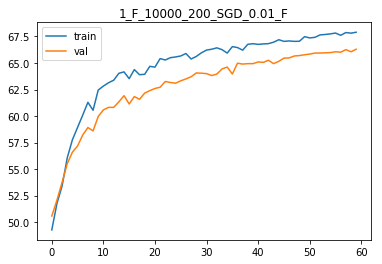

After training for 10 epochs
Train Acc 67.765
Val Acc 66.2
Test Acc 67.256
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 63.54
Epoch: [1/10], Step: [201/625], Validation Acc: 68.72
Epoch: [1/10], Step: [301/625], Validation Acc: 71.12
Epoch: [1/10], Step: [401/625], Validation Acc: 74.04
Epoch: [1/10], Step: [501/625], Validation Acc: 76.06
Epoch: [1/10], Step: [601/625], Validation Acc: 77.48
Epoch: [2/10], Step: [101/625], Validation Acc: 79.12
Epoch: [2/10], Step: [201/625], Validation Acc: 80.14
Epoch: [2/10], Step: [301/625], Validation Acc: 80.92
Epoch: [2/10], Step: [401/625], Validation Acc: 81.2
Epoch: [2/10], Step: [501/625], Validation Acc: 81.92
Epoch: [2/10], Step: [601/625], Validation Acc: 82.0
Epoch: [3/10], Step: [101/625], Validation Acc: 82.24
Epoch: [3/10], Step: [201/625], Validation Acc: 82.44
Epoch: [3/10], Step: [301/625], Validation

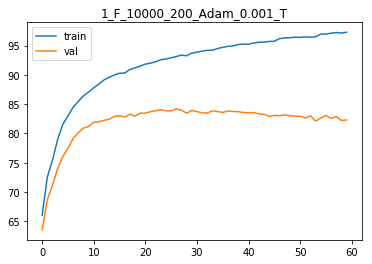

After training for 10 epochs
Train Acc 97.42
Val Acc 82.5
Test Acc 83.952
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 48.98
Epoch: [1/10], Step: [201/625], Validation Acc: 49.1
Epoch: [1/10], Step: [301/625], Validation Acc: 49.02
Epoch: [1/10], Step: [401/625], Validation Acc: 49.02
Epoch: [1/10], Step: [501/625], Validation Acc: 49.62
Epoch: [1/10], Step: [601/625], Validation Acc: 49.72
Epoch: [2/10], Step: [101/625], Validation Acc: 50.02
Epoch: [2/10], Step: [201/625], Validation Acc: 50.28
Epoch: [2/10], Step: [301/625], Validation Acc: 50.22
Epoch: [2/10], Step: [401/625], Validation Acc: 50.48
Epoch: [2/10], Step: [501/625], Validation Acc: 51.02
Epoch: [2/10], Step: [601/625], Validation Acc: 51.3
Epoch: [3/10], Step: [101/625], Validation Acc: 51.38
Epoch: [3/10], Step: [201/625], Validation Acc: 51.6
Epoch: [3/10], Step: [301/625], Validation Ac

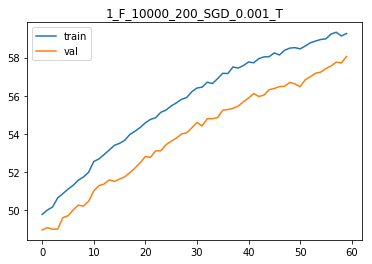

After training for 10 epochs
Train Acc 59.345
Val Acc 57.98
Test Acc 58.948
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 62.86
Epoch: [1/10], Step: [201/625], Validation Acc: 68.18
Epoch: [1/10], Step: [301/625], Validation Acc: 71.32
Epoch: [1/10], Step: [401/625], Validation Acc: 74.54
Epoch: [1/10], Step: [501/625], Validation Acc: 76.62
Epoch: [1/10], Step: [601/625], Validation Acc: 78.06
Epoch: [2/10], Step: [101/625], Validation Acc: 79.62
Epoch: [2/10], Step: [201/625], Validation Acc: 79.2
Epoch: [2/10], Step: [301/625], Validation Acc: 80.58
Epoch: [2/10], Step: [401/625], Validation Acc: 81.42
Epoch: [2/10], Step: [501/625], Validation Acc: 81.76
Epoch: [2/10], Step: [601/625], Validation Acc: 82.14
Epoch: [3/10], Step: [101/625], Validation Acc: 82.44
Epoch: [3/10], Step: [201/625], Validation Acc: 82.48
Epoch: [3/10], Step: [301/625], Validati

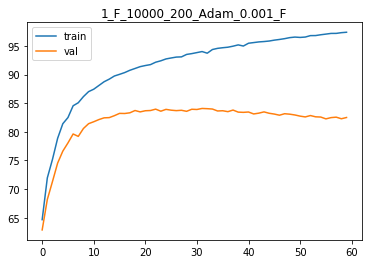

After training for 10 epochs
Train Acc 97.435
Val Acc 82.28
Test Acc 84.048
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 52.04
Epoch: [1/10], Step: [201/625], Validation Acc: 52.44
Epoch: [1/10], Step: [301/625], Validation Acc: 52.34
Epoch: [1/10], Step: [401/625], Validation Acc: 52.6
Epoch: [1/10], Step: [501/625], Validation Acc: 52.42
Epoch: [1/10], Step: [601/625], Validation Acc: 52.52
Epoch: [2/10], Step: [101/625], Validation Acc: 52.64
Epoch: [2/10], Step: [201/625], Validation Acc: 52.54
Epoch: [2/10], Step: [301/625], Validation Acc: 52.8
Epoch: [2/10], Step: [401/625], Validation Acc: 52.34
Epoch: [2/10], Step: [501/625], Validation Acc: 53.36
Epoch: [2/10], Step: [601/625], Validation Acc: 53.34
Epoch: [3/10], Step: [101/625], Validation Acc: 52.9
Epoch: [3/10], Step: [201/625], Validation Acc: 52.86
Epoch: [3/10], Step: [301/625], Validation 

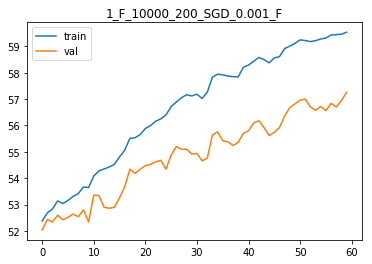

After training for 10 epochs
Train Acc 59.555
Val Acc 56.88
Test Acc 58.572
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 72.6
Epoch: [1/10], Step: [201/625], Validation Acc: 78.26
Epoch: [1/10], Step: [301/625], Validation Acc: 74.2
Epoch: [1/10], Step: [401/625], Validation Acc: 77.06
Epoch: [1/10], Step: [501/625], Validation Acc: 78.2
Epoch: [1/10], Step: [601/625], Validation Acc: 77.72
Epoch: [2/10], Step: [101/625], Validation Acc: 80.14
Epoch: [2/10], Step: [201/625], Validation Acc: 78.24
Epoch: [2/10], Step: [301/625], Validation Acc: 78.88
Epoch: [2/10], Step: [401/625], Validation Acc: 79.54
Epoch: [2/10], Step: [501/625], Validation Acc: 77.94
Epoch: [2/10], Step: [601/625], Validation Acc: 80.6
Epoch: [3/10], Step: [101/625], Validation Acc: 76.64
Epoch: [3/10], Step: [201/625], Validation Acc: 77.06
Epoch: [3/10], Step: [301/625], Validation Ac

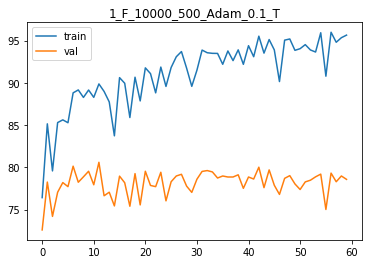

After training for 10 epochs
Train Acc 88.77
Val Acc 76.6
Test Acc 78.148
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 62.9
Epoch: [1/10], Step: [201/625], Validation Acc: 64.04
Epoch: [1/10], Step: [301/625], Validation Acc: 67.28
Epoch: [1/10], Step: [401/625], Validation Acc: 66.6
Epoch: [1/10], Step: [501/625], Validation Acc: 67.86
Epoch: [1/10], Step: [601/625], Validation Acc: 68.82
Epoch: [2/10], Step: [101/625], Validation Acc: 68.96
Epoch: [2/10], Step: [201/625], Validation Acc: 69.56
Epoch: [2/10], Step: [301/625], Validation Acc: 70.1
Epoch: [2/10], Step: [401/625], Validation Acc: 70.24
Epoch: [2/10], Step: [501/625], Validation Acc: 70.04
Epoch: [2/10], Step: [601/625], Validation Acc: 71.26
Epoch: [3/10], Step: [101/625], Validation Acc: 70.8
Epoch: [3/10], Step: [201/625], Validation Acc: 71.38
Epoch: [3/10], Step: [301/625], Validation Acc: 

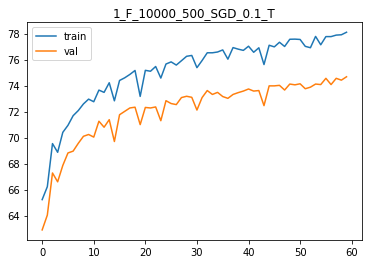

After training for 10 epochs
Train Acc 77.835
Val Acc 74.34
Test Acc 76.332
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.4
Epoch: [1/10], Step: [201/625], Validation Acc: 77.12
Epoch: [1/10], Step: [301/625], Validation Acc: 72.2
Epoch: [1/10], Step: [401/625], Validation Acc: 81.16
Epoch: [1/10], Step: [501/625], Validation Acc: 78.44
Epoch: [1/10], Step: [601/625], Validation Acc: 75.28
Epoch: [2/10], Step: [101/625], Validation Acc: 76.88
Epoch: [2/10], Step: [201/625], Validation Acc: 79.3
Epoch: [2/10], Step: [301/625], Validation Acc: 74.68
Epoch: [2/10], Step: [401/625], Validation Acc: 77.12
Epoch: [2/10], Step: [501/625], Validation Acc: 76.8
Epoch: [2/10], Step: [601/625], Validation Acc: 74.24
Epoch: [3/10], Step: [101/625], Validation Acc: 76.9
Epoch: [3/10], Step: [201/625], Validation Acc: 78.52
Epoch: [3/10], Step: [301/625], Validation Acc

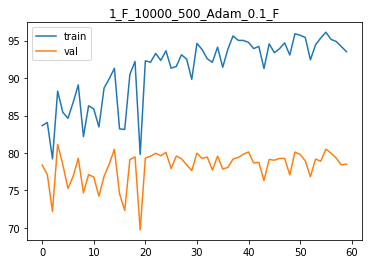

After training for 10 epochs
Train Acc 94.735
Val Acc 77.7
Test Acc 79.544
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 57.78
Epoch: [1/10], Step: [201/625], Validation Acc: 64.54
Epoch: [1/10], Step: [301/625], Validation Acc: 65.86
Epoch: [1/10], Step: [401/625], Validation Acc: 67.7
Epoch: [1/10], Step: [501/625], Validation Acc: 68.42
Epoch: [1/10], Step: [601/625], Validation Acc: 69.12
Epoch: [2/10], Step: [101/625], Validation Acc: 68.7
Epoch: [2/10], Step: [201/625], Validation Acc: 69.32
Epoch: [2/10], Step: [301/625], Validation Acc: 70.1
Epoch: [2/10], Step: [401/625], Validation Acc: 69.24
Epoch: [2/10], Step: [501/625], Validation Acc: 70.58
Epoch: [2/10], Step: [601/625], Validation Acc: 70.48
Epoch: [3/10], Step: [101/625], Validation Acc: 70.8
Epoch: [3/10], Step: [201/625], Validation Acc: 69.92
Epoch: [3/10], Step: [301/625], Validation Acc:

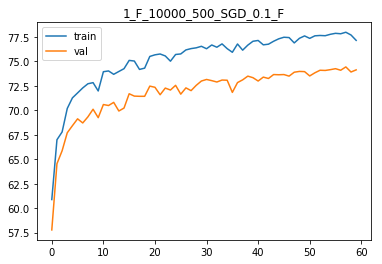

After training for 10 epochs
Train Acc 77.79
Val Acc 73.96
Test Acc 76.204
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.74
Epoch: [1/10], Step: [201/625], Validation Acc: 81.36
Epoch: [1/10], Step: [301/625], Validation Acc: 82.28
Epoch: [1/10], Step: [401/625], Validation Acc: 81.8
Epoch: [1/10], Step: [501/625], Validation Acc: 82.56
Epoch: [1/10], Step: [601/625], Validation Acc: 80.86
Epoch: [2/10], Step: [101/625], Validation Acc: 82.82
Epoch: [2/10], Step: [201/625], Validation Acc: 82.76
Epoch: [2/10], Step: [301/625], Validation Acc: 81.76
Epoch: [2/10], Step: [401/625], Validation Acc: 82.52
Epoch: [2/10], Step: [501/625], Validation Acc: 81.78
Epoch: [2/10], Step: [601/625], Validation Acc: 82.18
Epoch: [3/10], Step: [101/625], Validation Acc: 81.32
Epoch: [3/10], Step: [201/625], Validation Acc: 80.02
Epoch: [3/10], Step: [301/625], Validation

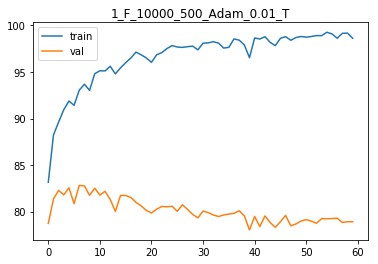

After training for 10 epochs
Train Acc 99.07
Val Acc 79.18
Test Acc 80.208
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 57.06
Epoch: [1/10], Step: [201/625], Validation Acc: 59.34
Epoch: [1/10], Step: [301/625], Validation Acc: 61.0
Epoch: [1/10], Step: [401/625], Validation Acc: 62.24
Epoch: [1/10], Step: [501/625], Validation Acc: 62.94
Epoch: [1/10], Step: [601/625], Validation Acc: 63.52
Epoch: [2/10], Step: [101/625], Validation Acc: 63.04
Epoch: [2/10], Step: [201/625], Validation Acc: 64.74
Epoch: [2/10], Step: [301/625], Validation Acc: 64.84
Epoch: [2/10], Step: [401/625], Validation Acc: 65.48
Epoch: [2/10], Step: [501/625], Validation Acc: 65.74
Epoch: [2/10], Step: [601/625], Validation Acc: 65.6
Epoch: [3/10], Step: [101/625], Validation Acc: 65.58
Epoch: [3/10], Step: [201/625], Validation Acc: 65.74
Epoch: [3/10], Step: [301/625], Validation A

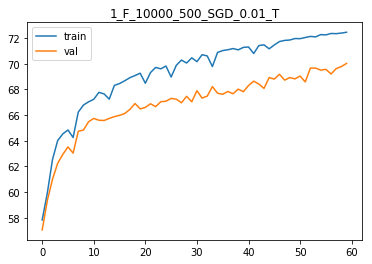

After training for 10 epochs
Train Acc 72.225
Val Acc 69.72
Test Acc 71.424
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.82
Epoch: [1/10], Step: [201/625], Validation Acc: 81.64
Epoch: [1/10], Step: [301/625], Validation Acc: 81.94
Epoch: [1/10], Step: [401/625], Validation Acc: 81.44
Epoch: [1/10], Step: [501/625], Validation Acc: 81.34
Epoch: [1/10], Step: [601/625], Validation Acc: 82.34
Epoch: [2/10], Step: [101/625], Validation Acc: 83.2
Epoch: [2/10], Step: [201/625], Validation Acc: 82.24
Epoch: [2/10], Step: [301/625], Validation Acc: 82.34
Epoch: [2/10], Step: [401/625], Validation Acc: 81.5
Epoch: [2/10], Step: [501/625], Validation Acc: 81.98
Epoch: [2/10], Step: [601/625], Validation Acc: 82.02
Epoch: [3/10], Step: [101/625], Validation Acc: 81.86
Epoch: [3/10], Step: [201/625], Validation Acc: 81.68
Epoch: [3/10], Step: [301/625], Validation

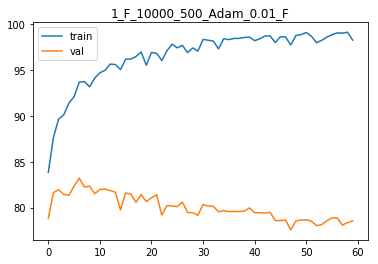

After training for 10 epochs
Train Acc 99.205
Val Acc 78.78
Test Acc 80.148
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 55.12
Epoch: [1/10], Step: [201/625], Validation Acc: 55.42
Epoch: [1/10], Step: [301/625], Validation Acc: 59.88
Epoch: [1/10], Step: [401/625], Validation Acc: 62.42
Epoch: [1/10], Step: [501/625], Validation Acc: 62.92
Epoch: [1/10], Step: [601/625], Validation Acc: 63.46
Epoch: [2/10], Step: [101/625], Validation Acc: 63.4
Epoch: [2/10], Step: [201/625], Validation Acc: 63.82
Epoch: [2/10], Step: [301/625], Validation Acc: 64.36
Epoch: [2/10], Step: [401/625], Validation Acc: 65.24
Epoch: [2/10], Step: [501/625], Validation Acc: 64.26
Epoch: [2/10], Step: [601/625], Validation Acc: 65.5
Epoch: [3/10], Step: [101/625], Validation Acc: 64.14
Epoch: [3/10], Step: [201/625], Validation Acc: 65.98
Epoch: [3/10], Step: [301/625], Validation 

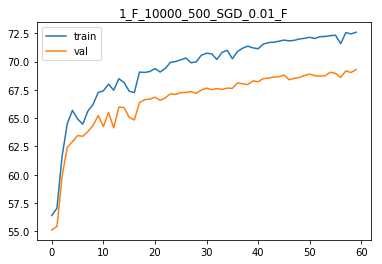

After training for 10 epochs
Train Acc 72.635
Val Acc 69.34
Test Acc 71.94
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 65.84
Epoch: [1/10], Step: [201/625], Validation Acc: 72.0
Epoch: [1/10], Step: [301/625], Validation Acc: 73.9
Epoch: [1/10], Step: [401/625], Validation Acc: 76.34
Epoch: [1/10], Step: [501/625], Validation Acc: 78.74
Epoch: [1/10], Step: [601/625], Validation Acc: 79.52
Epoch: [2/10], Step: [101/625], Validation Acc: 80.86
Epoch: [2/10], Step: [201/625], Validation Acc: 81.92
Epoch: [2/10], Step: [301/625], Validation Acc: 82.26
Epoch: [2/10], Step: [401/625], Validation Acc: 82.48
Epoch: [2/10], Step: [501/625], Validation Acc: 83.02
Epoch: [2/10], Step: [601/625], Validation Acc: 84.08
Epoch: [3/10], Step: [101/625], Validation Acc: 83.5
Epoch: [3/10], Step: [201/625], Validation Acc: 84.12
Epoch: [3/10], Step: [301/625], Validation 

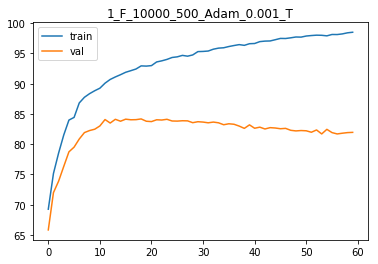

After training for 10 epochs
Train Acc 98.58
Val Acc 81.62
Test Acc 83.132
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.8
Epoch: [1/10], Step: [201/625], Validation Acc: 50.88
Epoch: [1/10], Step: [301/625], Validation Acc: 51.58
Epoch: [1/10], Step: [401/625], Validation Acc: 51.98
Epoch: [1/10], Step: [501/625], Validation Acc: 52.52
Epoch: [1/10], Step: [601/625], Validation Acc: 53.24
Epoch: [2/10], Step: [101/625], Validation Acc: 53.82
Epoch: [2/10], Step: [201/625], Validation Acc: 54.22
Epoch: [2/10], Step: [301/625], Validation Acc: 54.64
Epoch: [2/10], Step: [401/625], Validation Acc: 55.04
Epoch: [2/10], Step: [501/625], Validation Acc: 55.62
Epoch: [2/10], Step: [601/625], Validation Acc: 55.68
Epoch: [3/10], Step: [101/625], Validation Acc: 55.66
Epoch: [3/10], Step: [201/625], Validation Acc: 56.54
Epoch: [3/10], Step: [301/625], Validation

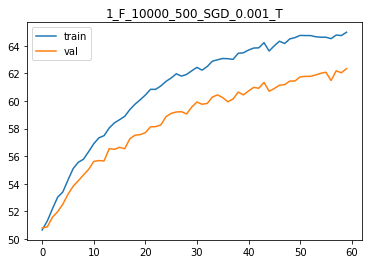

After training for 10 epochs
Train Acc 65.14
Val Acc 62.14
Test Acc 64.52
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 67.68
Epoch: [1/10], Step: [201/625], Validation Acc: 71.2
Epoch: [1/10], Step: [301/625], Validation Acc: 73.78
Epoch: [1/10], Step: [401/625], Validation Acc: 76.84
Epoch: [1/10], Step: [501/625], Validation Acc: 78.34
Epoch: [1/10], Step: [601/625], Validation Acc: 79.86
Epoch: [2/10], Step: [101/625], Validation Acc: 81.06
Epoch: [2/10], Step: [201/625], Validation Acc: 81.62
Epoch: [2/10], Step: [301/625], Validation Acc: 82.5
Epoch: [2/10], Step: [401/625], Validation Acc: 82.68
Epoch: [2/10], Step: [501/625], Validation Acc: 83.08
Epoch: [2/10], Step: [601/625], Validation Acc: 83.76
Epoch: [3/10], Step: [101/625], Validation Acc: 83.78
Epoch: [3/10], Step: [201/625], Validation Acc: 83.78
Epoch: [3/10], Step: [301/625], Validation 

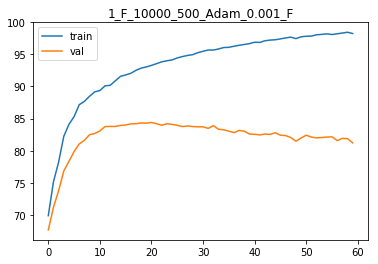

After training for 10 epochs
Train Acc 98.54
Val Acc 81.8
Test Acc 83.24
ngram:  1
use all_ngram? :  F
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 49.98
Epoch: [1/10], Step: [201/625], Validation Acc: 49.48
Epoch: [1/10], Step: [301/625], Validation Acc: 50.26
Epoch: [1/10], Step: [401/625], Validation Acc: 50.9
Epoch: [1/10], Step: [501/625], Validation Acc: 52.48
Epoch: [1/10], Step: [601/625], Validation Acc: 53.04
Epoch: [2/10], Step: [101/625], Validation Acc: 53.38
Epoch: [2/10], Step: [201/625], Validation Acc: 53.84
Epoch: [2/10], Step: [301/625], Validation Acc: 54.54
Epoch: [2/10], Step: [401/625], Validation Acc: 55.0
Epoch: [2/10], Step: [501/625], Validation Acc: 55.42
Epoch: [2/10], Step: [601/625], Validation Acc: 56.46
Epoch: [3/10], Step: [101/625], Validation Acc: 56.64
Epoch: [3/10], Step: [201/625], Validation Acc: 56.9
Epoch: [3/10], Step: [301/625], Validation Acc

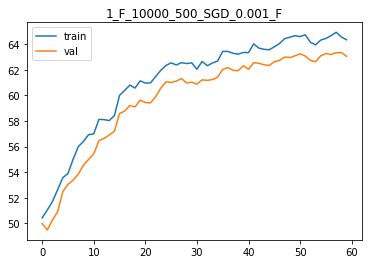

After training for 10 epochs
Train Acc 64.505
Val Acc 63.16
Test Acc 64.296
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.34
Epoch: [1/10], Step: [201/625], Validation Acc: 79.86
Epoch: [1/10], Step: [301/625], Validation Acc: 79.1
Epoch: [1/10], Step: [401/625], Validation Acc: 75.2
Epoch: [1/10], Step: [501/625], Validation Acc: 81.44
Epoch: [1/10], Step: [601/625], Validation Acc: 77.82
Epoch: [2/10], Step: [101/625], Validation Acc: 80.92
Epoch: [2/10], Step: [201/625], Validation Acc: 79.9
Epoch: [2/10], Step: [301/625], Validation Acc: 79.66
Epoch: [2/10], Step: [401/625], Validation Acc: 79.72
Epoch: [2/10], Step: [501/625], Validation Acc: 80.32
Epoch: [2/10], Step: [601/625], Validation Acc: 79.14
Epoch: [3/10], Step: [101/625], Validation Acc: 78.58
Epoch: [3/10], Step: [201/625], Validation Acc: 80.18
Epoch: [3/10], Step: [301/625], Validation A

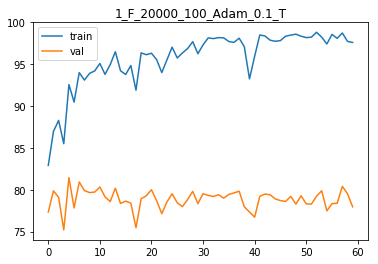

After training for 10 epochs
Train Acc 98.9
Val Acc 79.68
Test Acc 80.78
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 58.06
Epoch: [1/10], Step: [201/625], Validation Acc: 57.96
Epoch: [1/10], Step: [301/625], Validation Acc: 62.26
Epoch: [1/10], Step: [401/625], Validation Acc: 62.24
Epoch: [1/10], Step: [501/625], Validation Acc: 62.74
Epoch: [1/10], Step: [601/625], Validation Acc: 62.12
Epoch: [2/10], Step: [101/625], Validation Acc: 62.8
Epoch: [2/10], Step: [201/625], Validation Acc: 62.7
Epoch: [2/10], Step: [301/625], Validation Acc: 63.26
Epoch: [2/10], Step: [401/625], Validation Acc: 63.32
Epoch: [2/10], Step: [501/625], Validation Acc: 63.72
Epoch: [2/10], Step: [601/625], Validation Acc: 63.54
Epoch: [3/10], Step: [101/625], Validation Acc: 63.9
Epoch: [3/10], Step: [201/625], Validation Acc: 63.86
Epoch: [3/10], Step: [301/625], Validation Acc: 

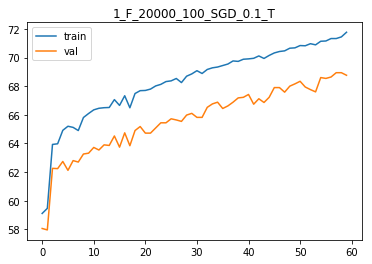

After training for 10 epochs
Train Acc 71.745
Val Acc 68.66
Test Acc 71.104
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.32
Epoch: [1/10], Step: [201/625], Validation Acc: 78.06
Epoch: [1/10], Step: [301/625], Validation Acc: 77.2
Epoch: [1/10], Step: [401/625], Validation Acc: 79.86
Epoch: [1/10], Step: [501/625], Validation Acc: 81.74
Epoch: [1/10], Step: [601/625], Validation Acc: 81.36
Epoch: [2/10], Step: [101/625], Validation Acc: 80.58
Epoch: [2/10], Step: [201/625], Validation Acc: 79.34
Epoch: [2/10], Step: [301/625], Validation Acc: 80.24
Epoch: [2/10], Step: [401/625], Validation Acc: 79.16
Epoch: [2/10], Step: [501/625], Validation Acc: 76.98
Epoch: [2/10], Step: [601/625], Validation Acc: 80.04
Epoch: [3/10], Step: [101/625], Validation Acc: 79.68
Epoch: [3/10], Step: [201/625], Validation Acc: 78.26
Epoch: [3/10], Step: [301/625], Validation

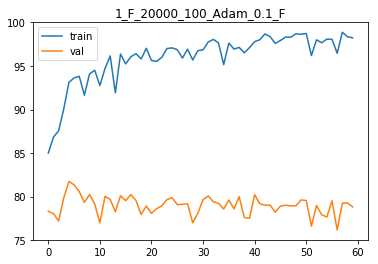

After training for 10 epochs
Train Acc 97.085
Val Acc 77.88
Test Acc 78.744
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 58.12
Epoch: [1/10], Step: [201/625], Validation Acc: 59.82
Epoch: [1/10], Step: [301/625], Validation Acc: 61.26
Epoch: [1/10], Step: [401/625], Validation Acc: 62.02
Epoch: [1/10], Step: [501/625], Validation Acc: 63.82
Epoch: [1/10], Step: [601/625], Validation Acc: 63.66
Epoch: [2/10], Step: [101/625], Validation Acc: 62.62
Epoch: [2/10], Step: [201/625], Validation Acc: 64.06
Epoch: [2/10], Step: [301/625], Validation Acc: 64.04
Epoch: [2/10], Step: [401/625], Validation Acc: 64.62
Epoch: [2/10], Step: [501/625], Validation Acc: 64.28
Epoch: [2/10], Step: [601/625], Validation Acc: 65.34
Epoch: [3/10], Step: [101/625], Validation Acc: 65.66
Epoch: [3/10], Step: [201/625], Validation Acc: 65.36
Epoch: [3/10], Step: [301/625], Validation

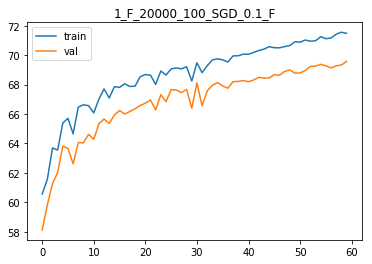

After training for 10 epochs
Train Acc 71.425
Val Acc 69.98
Test Acc 71.144
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.14
Epoch: [1/10], Step: [201/625], Validation Acc: 81.82
Epoch: [1/10], Step: [301/625], Validation Acc: 82.54
Epoch: [1/10], Step: [401/625], Validation Acc: 82.78
Epoch: [1/10], Step: [501/625], Validation Acc: 83.12
Epoch: [1/10], Step: [601/625], Validation Acc: 83.78
Epoch: [2/10], Step: [101/625], Validation Acc: 83.5
Epoch: [2/10], Step: [201/625], Validation Acc: 83.3
Epoch: [2/10], Step: [301/625], Validation Acc: 82.34
Epoch: [2/10], Step: [401/625], Validation Acc: 82.32
Epoch: [2/10], Step: [501/625], Validation Acc: 81.76
Epoch: [2/10], Step: [601/625], Validation Acc: 81.8
Epoch: [3/10], Step: [101/625], Validation Acc: 82.04
Epoch: [3/10], Step: [201/625], Validation Acc: 81.48
Epoch: [3/10], Step: [301/625], Validation 

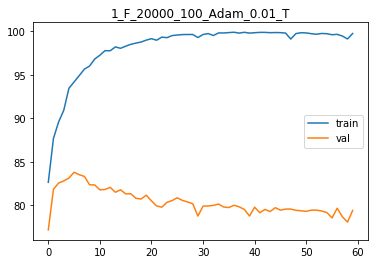

After training for 10 epochs
Train Acc 99.715
Val Acc 78.76
Test Acc 80.236
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 49.54
Epoch: [1/10], Step: [201/625], Validation Acc: 50.2
Epoch: [1/10], Step: [301/625], Validation Acc: 52.08
Epoch: [1/10], Step: [401/625], Validation Acc: 53.56
Epoch: [1/10], Step: [501/625], Validation Acc: 54.54
Epoch: [1/10], Step: [601/625], Validation Acc: 55.24
Epoch: [2/10], Step: [101/625], Validation Acc: 56.68
Epoch: [2/10], Step: [201/625], Validation Acc: 57.04
Epoch: [2/10], Step: [301/625], Validation Acc: 57.82
Epoch: [2/10], Step: [401/625], Validation Acc: 58.98
Epoch: [2/10], Step: [501/625], Validation Acc: 59.06
Epoch: [2/10], Step: [601/625], Validation Acc: 59.54
Epoch: [3/10], Step: [101/625], Validation Acc: 59.78
Epoch: [3/10], Step: [201/625], Validation Acc: 59.18
Epoch: [3/10], Step: [301/625], Validation

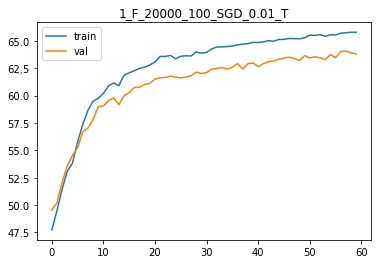

After training for 10 epochs
Train Acc 65.77
Val Acc 63.98
Test Acc 65.648
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.8
Epoch: [1/10], Step: [201/625], Validation Acc: 80.96
Epoch: [1/10], Step: [301/625], Validation Acc: 81.82
Epoch: [1/10], Step: [401/625], Validation Acc: 82.42
Epoch: [1/10], Step: [501/625], Validation Acc: 83.08
Epoch: [1/10], Step: [601/625], Validation Acc: 83.3
Epoch: [2/10], Step: [101/625], Validation Acc: 82.58
Epoch: [2/10], Step: [201/625], Validation Acc: 83.0
Epoch: [2/10], Step: [301/625], Validation Acc: 82.14
Epoch: [2/10], Step: [401/625], Validation Acc: 82.42
Epoch: [2/10], Step: [501/625], Validation Acc: 81.76
Epoch: [2/10], Step: [601/625], Validation Acc: 82.56
Epoch: [3/10], Step: [101/625], Validation Acc: 81.58
Epoch: [3/10], Step: [201/625], Validation Acc: 81.86
Epoch: [3/10], Step: [301/625], Validation A

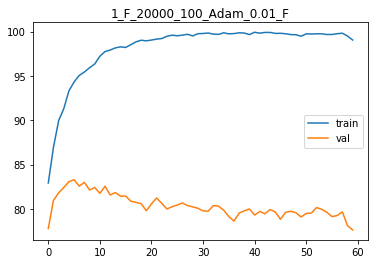

After training for 10 epochs
Train Acc 99.61
Val Acc 78.64
Test Acc 79.56
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.44
Epoch: [1/10], Step: [201/625], Validation Acc: 51.12
Epoch: [1/10], Step: [301/625], Validation Acc: 50.84
Epoch: [1/10], Step: [401/625], Validation Acc: 52.22
Epoch: [1/10], Step: [501/625], Validation Acc: 52.48
Epoch: [1/10], Step: [601/625], Validation Acc: 52.8
Epoch: [2/10], Step: [101/625], Validation Acc: 54.34
Epoch: [2/10], Step: [201/625], Validation Acc: 54.7
Epoch: [2/10], Step: [301/625], Validation Acc: 55.02
Epoch: [2/10], Step: [401/625], Validation Acc: 55.94
Epoch: [2/10], Step: [501/625], Validation Acc: 56.34
Epoch: [2/10], Step: [601/625], Validation Acc: 56.42
Epoch: [3/10], Step: [101/625], Validation Acc: 56.92
Epoch: [3/10], Step: [201/625], Validation Acc: 57.06
Epoch: [3/10], Step: [301/625], Validation Ac

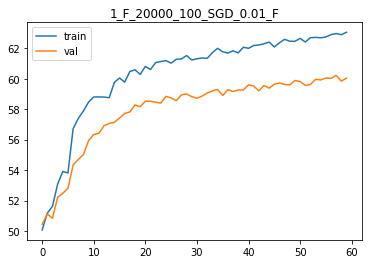

After training for 10 epochs
Train Acc 62.93
Val Acc 59.92
Test Acc 61.216
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 63.0
Epoch: [1/10], Step: [201/625], Validation Acc: 68.54
Epoch: [1/10], Step: [301/625], Validation Acc: 70.5
Epoch: [1/10], Step: [401/625], Validation Acc: 73.16
Epoch: [1/10], Step: [501/625], Validation Acc: 75.08
Epoch: [1/10], Step: [601/625], Validation Acc: 76.32
Epoch: [2/10], Step: [101/625], Validation Acc: 77.74
Epoch: [2/10], Step: [201/625], Validation Acc: 78.48
Epoch: [2/10], Step: [301/625], Validation Acc: 79.4
Epoch: [2/10], Step: [401/625], Validation Acc: 80.28
Epoch: [2/10], Step: [501/625], Validation Acc: 80.86
Epoch: [2/10], Step: [601/625], Validation Acc: 81.64
Epoch: [3/10], Step: [101/625], Validation Acc: 81.94
Epoch: [3/10], Step: [201/625], Validation Acc: 82.02
Epoch: [3/10], Step: [301/625], Validation 

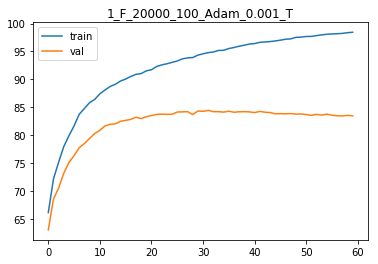

After training for 10 epochs
Train Acc 98.425
Val Acc 83.52
Test Acc 84.468
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 51.68
Epoch: [1/10], Step: [201/625], Validation Acc: 51.94
Epoch: [1/10], Step: [301/625], Validation Acc: 52.28
Epoch: [1/10], Step: [401/625], Validation Acc: 52.24
Epoch: [1/10], Step: [501/625], Validation Acc: 52.42
Epoch: [1/10], Step: [601/625], Validation Acc: 52.44
Epoch: [2/10], Step: [101/625], Validation Acc: 52.82
Epoch: [2/10], Step: [201/625], Validation Acc: 53.18
Epoch: [2/10], Step: [301/625], Validation Acc: 53.3
Epoch: [2/10], Step: [401/625], Validation Acc: 53.44
Epoch: [2/10], Step: [501/625], Validation Acc: 53.38
Epoch: [2/10], Step: [601/625], Validation Acc: 53.64
Epoch: [3/10], Step: [101/625], Validation Acc: 53.56
Epoch: [3/10], Step: [201/625], Validation Acc: 53.96
Epoch: [3/10], Step: [301/625], Validatio

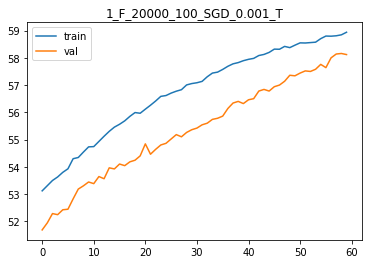

After training for 10 epochs
Train Acc 58.96
Val Acc 58.16
Test Acc 58.464
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.76
Epoch: [1/10], Step: [201/625], Validation Acc: 67.8
Epoch: [1/10], Step: [301/625], Validation Acc: 70.92
Epoch: [1/10], Step: [401/625], Validation Acc: 73.22
Epoch: [1/10], Step: [501/625], Validation Acc: 75.42
Epoch: [1/10], Step: [601/625], Validation Acc: 77.44
Epoch: [2/10], Step: [101/625], Validation Acc: 79.02
Epoch: [2/10], Step: [201/625], Validation Acc: 79.66
Epoch: [2/10], Step: [301/625], Validation Acc: 80.26
Epoch: [2/10], Step: [401/625], Validation Acc: 80.24
Epoch: [2/10], Step: [501/625], Validation Acc: 81.08
Epoch: [2/10], Step: [601/625], Validation Acc: 81.56
Epoch: [3/10], Step: [101/625], Validation Acc: 82.0
Epoch: [3/10], Step: [201/625], Validation Acc: 82.38
Epoch: [3/10], Step: [301/625], Validation

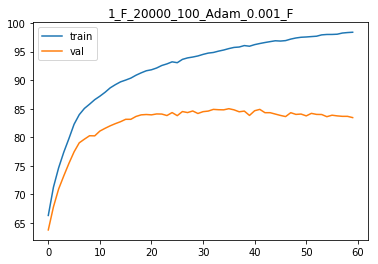

After training for 10 epochs
Train Acc 98.485
Val Acc 83.18
Test Acc 84.268
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 48.76
Epoch: [1/10], Step: [201/625], Validation Acc: 48.64
Epoch: [1/10], Step: [301/625], Validation Acc: 48.92
Epoch: [1/10], Step: [401/625], Validation Acc: 48.78
Epoch: [1/10], Step: [501/625], Validation Acc: 48.6
Epoch: [1/10], Step: [601/625], Validation Acc: 48.4
Epoch: [2/10], Step: [101/625], Validation Acc: 48.32
Epoch: [2/10], Step: [201/625], Validation Acc: 48.68
Epoch: [2/10], Step: [301/625], Validation Acc: 48.62
Epoch: [2/10], Step: [401/625], Validation Acc: 48.76
Epoch: [2/10], Step: [501/625], Validation Acc: 48.7
Epoch: [2/10], Step: [601/625], Validation Acc: 48.58
Epoch: [3/10], Step: [101/625], Validation Acc: 48.72
Epoch: [3/10], Step: [201/625], Validation Acc: 48.9
Epoch: [3/10], Step: [301/625], Validation A

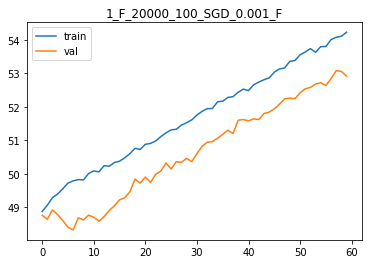

After training for 10 epochs
Train Acc 54.25
Val Acc 53.02
Test Acc 52.308
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 80.52
Epoch: [1/10], Step: [201/625], Validation Acc: 78.96
Epoch: [1/10], Step: [301/625], Validation Acc: 80.82
Epoch: [1/10], Step: [401/625], Validation Acc: 79.94
Epoch: [1/10], Step: [501/625], Validation Acc: 79.34
Epoch: [1/10], Step: [601/625], Validation Acc: 75.64
Epoch: [2/10], Step: [101/625], Validation Acc: 74.98
Epoch: [2/10], Step: [201/625], Validation Acc: 79.86
Epoch: [2/10], Step: [301/625], Validation Acc: 78.94
Epoch: [2/10], Step: [401/625], Validation Acc: 77.52
Epoch: [2/10], Step: [501/625], Validation Acc: 75.42
Epoch: [2/10], Step: [601/625], Validation Acc: 80.16
Epoch: [3/10], Step: [101/625], Validation Acc: 79.02
Epoch: [3/10], Step: [201/625], Validation Acc: 77.66
Epoch: [3/10], Step: [301/625], Validation

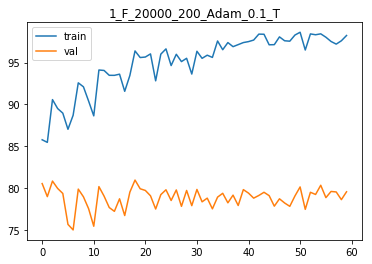

After training for 10 epochs
Train Acc 94.72
Val Acc 78.1
Test Acc 79.732
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 56.78
Epoch: [1/10], Step: [201/625], Validation Acc: 63.84
Epoch: [1/10], Step: [301/625], Validation Acc: 64.9
Epoch: [1/10], Step: [401/625], Validation Acc: 65.02
Epoch: [1/10], Step: [501/625], Validation Acc: 65.9
Epoch: [1/10], Step: [601/625], Validation Acc: 66.02
Epoch: [2/10], Step: [101/625], Validation Acc: 67.02
Epoch: [2/10], Step: [201/625], Validation Acc: 67.42
Epoch: [2/10], Step: [301/625], Validation Acc: 67.52
Epoch: [2/10], Step: [401/625], Validation Acc: 68.04
Epoch: [2/10], Step: [501/625], Validation Acc: 67.6
Epoch: [2/10], Step: [601/625], Validation Acc: 67.86
Epoch: [3/10], Step: [101/625], Validation Acc: 68.4
Epoch: [3/10], Step: [201/625], Validation Acc: 68.16
Epoch: [3/10], Step: [301/625], Validation Acc: 

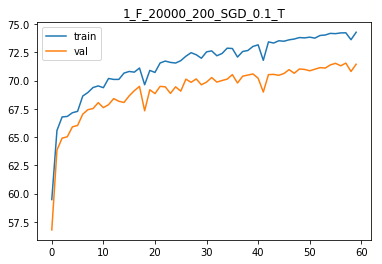

After training for 10 epochs
Train Acc 74.18
Val Acc 71.36
Test Acc 72.752
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 75.4
Epoch: [1/10], Step: [201/625], Validation Acc: 74.18
Epoch: [1/10], Step: [301/625], Validation Acc: 75.96
Epoch: [1/10], Step: [401/625], Validation Acc: 81.0
Epoch: [1/10], Step: [501/625], Validation Acc: 76.56
Epoch: [1/10], Step: [601/625], Validation Acc: 76.9
Epoch: [2/10], Step: [101/625], Validation Acc: 79.38
Epoch: [2/10], Step: [201/625], Validation Acc: 78.36
Epoch: [2/10], Step: [301/625], Validation Acc: 78.98
Epoch: [2/10], Step: [401/625], Validation Acc: 79.12
Epoch: [2/10], Step: [501/625], Validation Acc: 77.22
Epoch: [2/10], Step: [601/625], Validation Acc: 78.7
Epoch: [3/10], Step: [101/625], Validation Acc: 80.02
Epoch: [3/10], Step: [201/625], Validation Acc: 77.96
Epoch: [3/10], Step: [301/625], Validation Acc

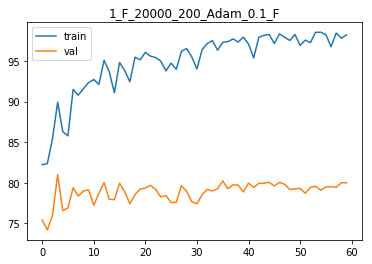

After training for 10 epochs
Train Acc 98.29
Val Acc 79.8
Test Acc 80.74
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 58.98
Epoch: [1/10], Step: [201/625], Validation Acc: 62.24
Epoch: [1/10], Step: [301/625], Validation Acc: 63.16
Epoch: [1/10], Step: [401/625], Validation Acc: 63.78
Epoch: [1/10], Step: [501/625], Validation Acc: 64.0
Epoch: [1/10], Step: [601/625], Validation Acc: 63.46
Epoch: [2/10], Step: [101/625], Validation Acc: 65.22
Epoch: [2/10], Step: [201/625], Validation Acc: 64.6
Epoch: [2/10], Step: [301/625], Validation Acc: 63.94
Epoch: [2/10], Step: [401/625], Validation Acc: 65.44
Epoch: [2/10], Step: [501/625], Validation Acc: 66.18
Epoch: [2/10], Step: [601/625], Validation Acc: 66.16
Epoch: [3/10], Step: [101/625], Validation Acc: 65.52
Epoch: [3/10], Step: [201/625], Validation Acc: 66.56
Epoch: [3/10], Step: [301/625], Validation Acc:

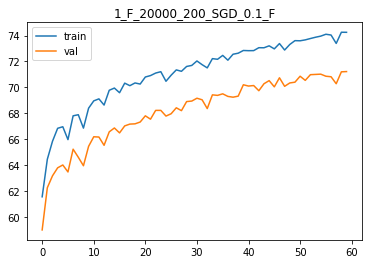

After training for 10 epochs
Train Acc 74.065
Val Acc 71.18
Test Acc 73.0
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.68
Epoch: [1/10], Step: [201/625], Validation Acc: 81.26
Epoch: [1/10], Step: [301/625], Validation Acc: 82.36
Epoch: [1/10], Step: [401/625], Validation Acc: 83.0
Epoch: [1/10], Step: [501/625], Validation Acc: 83.14
Epoch: [1/10], Step: [601/625], Validation Acc: 81.74
Epoch: [2/10], Step: [101/625], Validation Acc: 82.78
Epoch: [2/10], Step: [201/625], Validation Acc: 82.2
Epoch: [2/10], Step: [301/625], Validation Acc: 82.46
Epoch: [2/10], Step: [401/625], Validation Acc: 82.26
Epoch: [2/10], Step: [501/625], Validation Acc: 82.34
Epoch: [2/10], Step: [601/625], Validation Acc: 80.32
Epoch: [3/10], Step: [101/625], Validation Acc: 81.24
Epoch: [3/10], Step: [201/625], Validation Acc: 80.94
Epoch: [3/10], Step: [301/625], Validation A

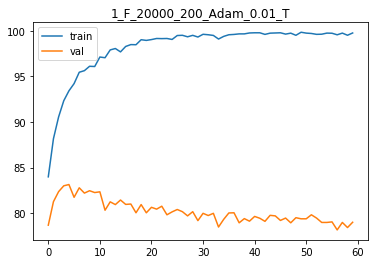

After training for 10 epochs
Train Acc 99.76
Val Acc 79.0
Test Acc 80.724
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.16
Epoch: [1/10], Step: [201/625], Validation Acc: 52.02
Epoch: [1/10], Step: [301/625], Validation Acc: 52.76
Epoch: [1/10], Step: [401/625], Validation Acc: 55.1
Epoch: [1/10], Step: [501/625], Validation Acc: 55.04
Epoch: [1/10], Step: [601/625], Validation Acc: 57.12
Epoch: [2/10], Step: [101/625], Validation Acc: 58.68
Epoch: [2/10], Step: [201/625], Validation Acc: 58.9
Epoch: [2/10], Step: [301/625], Validation Acc: 59.4
Epoch: [2/10], Step: [401/625], Validation Acc: 59.84
Epoch: [2/10], Step: [501/625], Validation Acc: 59.88
Epoch: [2/10], Step: [601/625], Validation Acc: 60.12
Epoch: [3/10], Step: [101/625], Validation Acc: 59.92
Epoch: [3/10], Step: [201/625], Validation Acc: 61.16
Epoch: [3/10], Step: [301/625], Validation Acc

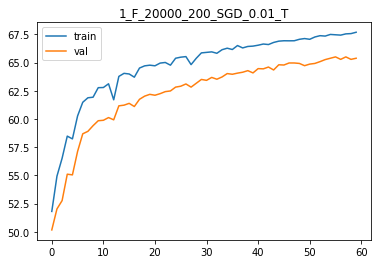

After training for 10 epochs
Train Acc 67.57
Val Acc 65.4
Test Acc 67.492
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.32
Epoch: [1/10], Step: [201/625], Validation Acc: 77.04
Epoch: [1/10], Step: [301/625], Validation Acc: 82.94
Epoch: [1/10], Step: [401/625], Validation Acc: 83.02
Epoch: [1/10], Step: [501/625], Validation Acc: 83.42
Epoch: [1/10], Step: [601/625], Validation Acc: 83.34
Epoch: [2/10], Step: [101/625], Validation Acc: 83.08
Epoch: [2/10], Step: [201/625], Validation Acc: 82.02
Epoch: [2/10], Step: [301/625], Validation Acc: 81.08
Epoch: [2/10], Step: [401/625], Validation Acc: 82.28
Epoch: [2/10], Step: [501/625], Validation Acc: 82.4
Epoch: [2/10], Step: [601/625], Validation Acc: 80.42
Epoch: [3/10], Step: [101/625], Validation Acc: 82.06
Epoch: [3/10], Step: [201/625], Validation Acc: 81.32
Epoch: [3/10], Step: [301/625], Validation 

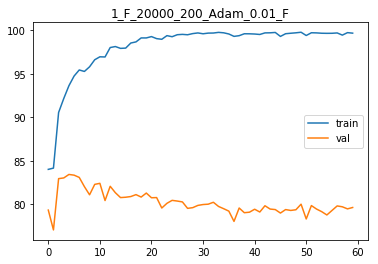

After training for 10 epochs
Train Acc 99.79
Val Acc 79.58
Test Acc 80.624
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 54.16
Epoch: [1/10], Step: [201/625], Validation Acc: 58.4
Epoch: [1/10], Step: [301/625], Validation Acc: 59.34
Epoch: [1/10], Step: [401/625], Validation Acc: 60.02
Epoch: [1/10], Step: [501/625], Validation Acc: 57.58
Epoch: [1/10], Step: [601/625], Validation Acc: 61.46
Epoch: [2/10], Step: [101/625], Validation Acc: 61.66
Epoch: [2/10], Step: [201/625], Validation Acc: 61.78
Epoch: [2/10], Step: [301/625], Validation Acc: 61.78
Epoch: [2/10], Step: [401/625], Validation Acc: 62.44
Epoch: [2/10], Step: [501/625], Validation Acc: 63.06
Epoch: [2/10], Step: [601/625], Validation Acc: 62.7
Epoch: [3/10], Step: [101/625], Validation Acc: 63.04
Epoch: [3/10], Step: [201/625], Validation Acc: 63.56
Epoch: [3/10], Step: [301/625], Validation A

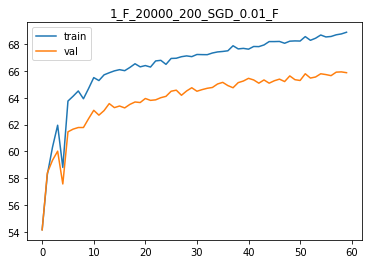

After training for 10 epochs
Train Acc 68.755
Val Acc 66.04
Test Acc 68.016
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 63.88
Epoch: [1/10], Step: [201/625], Validation Acc: 68.06
Epoch: [1/10], Step: [301/625], Validation Acc: 71.92
Epoch: [1/10], Step: [401/625], Validation Acc: 74.9
Epoch: [1/10], Step: [501/625], Validation Acc: 76.92
Epoch: [1/10], Step: [601/625], Validation Acc: 78.14
Epoch: [2/10], Step: [101/625], Validation Acc: 79.76
Epoch: [2/10], Step: [201/625], Validation Acc: 80.52
Epoch: [2/10], Step: [301/625], Validation Acc: 81.26
Epoch: [2/10], Step: [401/625], Validation Acc: 81.1
Epoch: [2/10], Step: [501/625], Validation Acc: 82.04
Epoch: [2/10], Step: [601/625], Validation Acc: 82.18
Epoch: [3/10], Step: [101/625], Validation Acc: 82.8
Epoch: [3/10], Step: [201/625], Validation Acc: 82.94
Epoch: [3/10], Step: [301/625], Validation

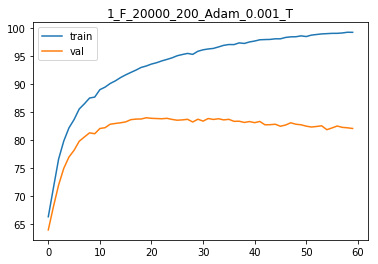

After training for 10 epochs
Train Acc 99.16
Val Acc 81.16
Test Acc 82.712
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.16
Epoch: [1/10], Step: [201/625], Validation Acc: 50.22
Epoch: [1/10], Step: [301/625], Validation Acc: 50.2
Epoch: [1/10], Step: [401/625], Validation Acc: 50.18
Epoch: [1/10], Step: [501/625], Validation Acc: 49.84
Epoch: [1/10], Step: [601/625], Validation Acc: 50.04
Epoch: [2/10], Step: [101/625], Validation Acc: 50.44
Epoch: [2/10], Step: [201/625], Validation Acc: 50.78
Epoch: [2/10], Step: [301/625], Validation Acc: 50.58
Epoch: [2/10], Step: [401/625], Validation Acc: 50.4
Epoch: [2/10], Step: [501/625], Validation Acc: 50.4
Epoch: [2/10], Step: [601/625], Validation Acc: 50.54
Epoch: [3/10], Step: [101/625], Validation Acc: 50.32
Epoch: [3/10], Step: [201/625], Validation Acc: 50.66
Epoch: [3/10], Step: [301/625], Validation A

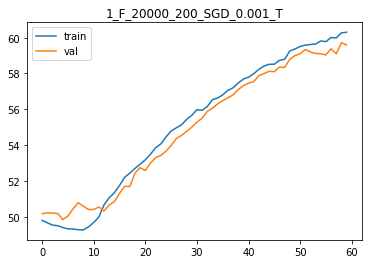

After training for 10 epochs
Train Acc 60.34
Val Acc 59.62
Test Acc 59.9
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.84
Epoch: [1/10], Step: [201/625], Validation Acc: 69.64
Epoch: [1/10], Step: [301/625], Validation Acc: 72.36
Epoch: [1/10], Step: [401/625], Validation Acc: 74.96
Epoch: [1/10], Step: [501/625], Validation Acc: 77.36
Epoch: [1/10], Step: [601/625], Validation Acc: 78.66
Epoch: [2/10], Step: [101/625], Validation Acc: 79.98
Epoch: [2/10], Step: [201/625], Validation Acc: 80.42
Epoch: [2/10], Step: [301/625], Validation Acc: 81.14
Epoch: [2/10], Step: [401/625], Validation Acc: 81.38
Epoch: [2/10], Step: [501/625], Validation Acc: 82.06
Epoch: [2/10], Step: [601/625], Validation Acc: 82.3
Epoch: [3/10], Step: [101/625], Validation Acc: 82.82
Epoch: [3/10], Step: [201/625], Validation Acc: 83.0
Epoch: [3/10], Step: [301/625], Validation A

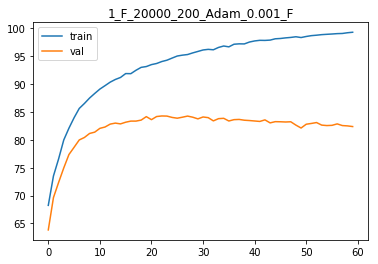

After training for 10 epochs
Train Acc 99.32
Val Acc 82.66
Test Acc 83.744
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 49.42
Epoch: [1/10], Step: [201/625], Validation Acc: 49.16
Epoch: [1/10], Step: [301/625], Validation Acc: 49.64
Epoch: [1/10], Step: [401/625], Validation Acc: 50.02
Epoch: [1/10], Step: [501/625], Validation Acc: 50.06
Epoch: [1/10], Step: [601/625], Validation Acc: 50.64
Epoch: [2/10], Step: [101/625], Validation Acc: 51.24
Epoch: [2/10], Step: [201/625], Validation Acc: 51.68
Epoch: [2/10], Step: [301/625], Validation Acc: 51.88
Epoch: [2/10], Step: [401/625], Validation Acc: 51.64
Epoch: [2/10], Step: [501/625], Validation Acc: 52.0
Epoch: [2/10], Step: [601/625], Validation Acc: 52.52
Epoch: [3/10], Step: [101/625], Validation Acc: 52.7
Epoch: [3/10], Step: [201/625], Validation Acc: 52.76
Epoch: [3/10], Step: [301/625], Validation 

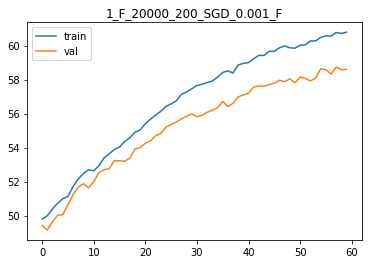

After training for 10 epochs
Train Acc 60.875
Val Acc 58.7
Test Acc 60.292
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 75.38
Epoch: [1/10], Step: [201/625], Validation Acc: 79.7
Epoch: [1/10], Step: [301/625], Validation Acc: 79.54
Epoch: [1/10], Step: [401/625], Validation Acc: 78.06
Epoch: [1/10], Step: [501/625], Validation Acc: 80.38
Epoch: [1/10], Step: [601/625], Validation Acc: 76.2
Epoch: [2/10], Step: [101/625], Validation Acc: 79.48
Epoch: [2/10], Step: [201/625], Validation Acc: 78.04
Epoch: [2/10], Step: [301/625], Validation Acc: 77.76
Epoch: [2/10], Step: [401/625], Validation Acc: 80.02
Epoch: [2/10], Step: [501/625], Validation Acc: 78.4
Epoch: [2/10], Step: [601/625], Validation Acc: 78.36
Epoch: [3/10], Step: [101/625], Validation Acc: 79.76
Epoch: [3/10], Step: [201/625], Validation Acc: 78.5
Epoch: [3/10], Step: [301/625], Validation Acc

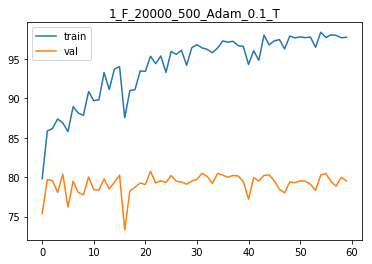

After training for 10 epochs
Train Acc 96.75
Val Acc 77.5
Test Acc 79.044
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 63.9
Epoch: [1/10], Step: [201/625], Validation Acc: 65.26
Epoch: [1/10], Step: [301/625], Validation Acc: 64.62
Epoch: [1/10], Step: [401/625], Validation Acc: 67.4
Epoch: [1/10], Step: [501/625], Validation Acc: 68.12
Epoch: [1/10], Step: [601/625], Validation Acc: 68.46
Epoch: [2/10], Step: [101/625], Validation Acc: 69.6
Epoch: [2/10], Step: [201/625], Validation Acc: 70.16
Epoch: [2/10], Step: [301/625], Validation Acc: 69.16
Epoch: [2/10], Step: [401/625], Validation Acc: 70.14
Epoch: [2/10], Step: [501/625], Validation Acc: 69.92
Epoch: [2/10], Step: [601/625], Validation Acc: 70.86
Epoch: [3/10], Step: [101/625], Validation Acc: 70.94
Epoch: [3/10], Step: [201/625], Validation Acc: 70.8
Epoch: [3/10], Step: [301/625], Validation Acc: 

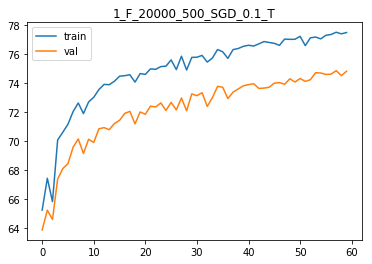

After training for 10 epochs
Train Acc 77.245
Val Acc 74.6
Test Acc 76.272
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 76.28
Epoch: [1/10], Step: [201/625], Validation Acc: 77.52
Epoch: [1/10], Step: [301/625], Validation Acc: 78.74
Epoch: [1/10], Step: [401/625], Validation Acc: 78.74
Epoch: [1/10], Step: [501/625], Validation Acc: 77.72
Epoch: [1/10], Step: [601/625], Validation Acc: 73.3
Epoch: [2/10], Step: [101/625], Validation Acc: 78.64
Epoch: [2/10], Step: [201/625], Validation Acc: 79.34
Epoch: [2/10], Step: [301/625], Validation Acc: 78.18
Epoch: [2/10], Step: [401/625], Validation Acc: 76.38
Epoch: [2/10], Step: [501/625], Validation Acc: 78.18
Epoch: [2/10], Step: [601/625], Validation Acc: 78.1
Epoch: [3/10], Step: [101/625], Validation Acc: 78.92
Epoch: [3/10], Step: [201/625], Validation Acc: 80.46
Epoch: [3/10], Step: [301/625], Validation A

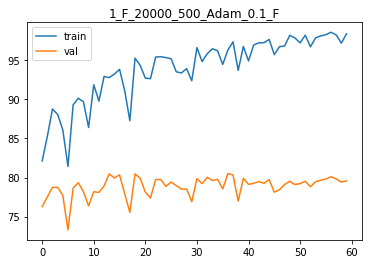

After training for 10 epochs
Train Acc 98.055
Val Acc 79.5
Test Acc 81.028
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 59.28
Epoch: [1/10], Step: [201/625], Validation Acc: 66.1
Epoch: [1/10], Step: [301/625], Validation Acc: 66.98
Epoch: [1/10], Step: [401/625], Validation Acc: 66.42
Epoch: [1/10], Step: [501/625], Validation Acc: 68.68
Epoch: [1/10], Step: [601/625], Validation Acc: 69.12
Epoch: [2/10], Step: [101/625], Validation Acc: 69.94
Epoch: [2/10], Step: [201/625], Validation Acc: 69.56
Epoch: [2/10], Step: [301/625], Validation Acc: 69.98
Epoch: [2/10], Step: [401/625], Validation Acc: 70.2
Epoch: [2/10], Step: [501/625], Validation Acc: 71.38
Epoch: [2/10], Step: [601/625], Validation Acc: 71.14
Epoch: [3/10], Step: [101/625], Validation Acc: 69.96
Epoch: [3/10], Step: [201/625], Validation Acc: 71.54
Epoch: [3/10], Step: [301/625], Validation Ac

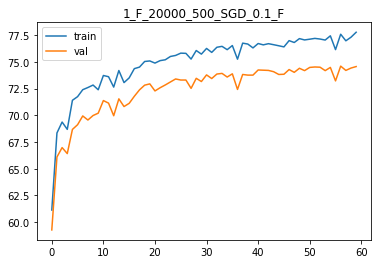

After training for 10 epochs
Train Acc 77.695
Val Acc 74.44
Test Acc 76.132
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.68
Epoch: [1/10], Step: [201/625], Validation Acc: 80.82
Epoch: [1/10], Step: [301/625], Validation Acc: 81.64
Epoch: [1/10], Step: [401/625], Validation Acc: 82.14
Epoch: [1/10], Step: [501/625], Validation Acc: 82.08
Epoch: [1/10], Step: [601/625], Validation Acc: 81.9
Epoch: [2/10], Step: [101/625], Validation Acc: 82.68
Epoch: [2/10], Step: [201/625], Validation Acc: 82.5
Epoch: [2/10], Step: [301/625], Validation Acc: 81.56
Epoch: [2/10], Step: [401/625], Validation Acc: 81.64
Epoch: [2/10], Step: [501/625], Validation Acc: 81.76
Epoch: [2/10], Step: [601/625], Validation Acc: 81.82
Epoch: [3/10], Step: [101/625], Validation Acc: 79.66
Epoch: [3/10], Step: [201/625], Validation Acc: 81.92
Epoch: [3/10], Step: [301/625], Validation

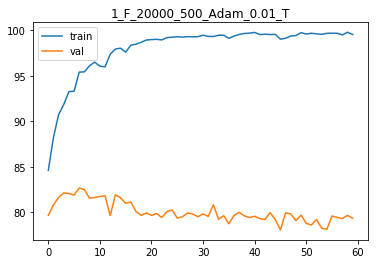

After training for 10 epochs
Train Acc 99.8
Val Acc 79.08
Test Acc 80.42
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.4
Epoch: [1/10], Step: [201/625], Validation Acc: 53.52
Epoch: [1/10], Step: [301/625], Validation Acc: 58.04
Epoch: [1/10], Step: [401/625], Validation Acc: 58.76
Epoch: [1/10], Step: [501/625], Validation Acc: 60.1
Epoch: [1/10], Step: [601/625], Validation Acc: 62.02
Epoch: [2/10], Step: [101/625], Validation Acc: 62.58
Epoch: [2/10], Step: [201/625], Validation Acc: 62.64
Epoch: [2/10], Step: [301/625], Validation Acc: 62.58
Epoch: [2/10], Step: [401/625], Validation Acc: 63.18
Epoch: [2/10], Step: [501/625], Validation Acc: 63.22
Epoch: [2/10], Step: [601/625], Validation Acc: 62.86
Epoch: [3/10], Step: [101/625], Validation Acc: 63.66
Epoch: [3/10], Step: [201/625], Validation Acc: 64.1
Epoch: [3/10], Step: [301/625], Validation Acc:

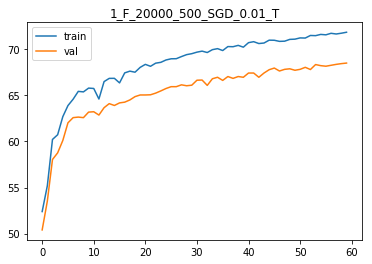

After training for 10 epochs
Train Acc 71.68
Val Acc 68.44
Test Acc 70.692
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 75.24
Epoch: [1/10], Step: [201/625], Validation Acc: 80.98
Epoch: [1/10], Step: [301/625], Validation Acc: 81.02
Epoch: [1/10], Step: [401/625], Validation Acc: 82.3
Epoch: [1/10], Step: [501/625], Validation Acc: 82.62
Epoch: [1/10], Step: [601/625], Validation Acc: 81.28
Epoch: [2/10], Step: [101/625], Validation Acc: 82.3
Epoch: [2/10], Step: [201/625], Validation Acc: 79.62
Epoch: [2/10], Step: [301/625], Validation Acc: 81.86
Epoch: [2/10], Step: [401/625], Validation Acc: 82.22
Epoch: [2/10], Step: [501/625], Validation Acc: 81.94
Epoch: [2/10], Step: [601/625], Validation Acc: 81.58
Epoch: [3/10], Step: [101/625], Validation Acc: 80.86
Epoch: [3/10], Step: [201/625], Validation Acc: 81.98
Epoch: [3/10], Step: [301/625], Validation 

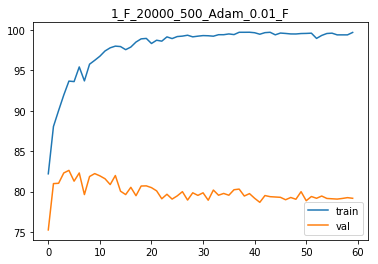

After training for 10 epochs
Train Acc 99.4
Val Acc 79.22
Test Acc 80.596
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.46
Epoch: [1/10], Step: [201/625], Validation Acc: 56.2
Epoch: [1/10], Step: [301/625], Validation Acc: 58.1
Epoch: [1/10], Step: [401/625], Validation Acc: 59.12
Epoch: [1/10], Step: [501/625], Validation Acc: 58.66
Epoch: [1/10], Step: [601/625], Validation Acc: 61.3
Epoch: [2/10], Step: [101/625], Validation Acc: 62.34
Epoch: [2/10], Step: [201/625], Validation Acc: 62.72
Epoch: [2/10], Step: [301/625], Validation Acc: 63.34
Epoch: [2/10], Step: [401/625], Validation Acc: 63.76
Epoch: [2/10], Step: [501/625], Validation Acc: 62.3
Epoch: [2/10], Step: [601/625], Validation Acc: 64.26
Epoch: [3/10], Step: [101/625], Validation Acc: 64.74
Epoch: [3/10], Step: [201/625], Validation Acc: 64.7
Epoch: [3/10], Step: [301/625], Validation Acc: 

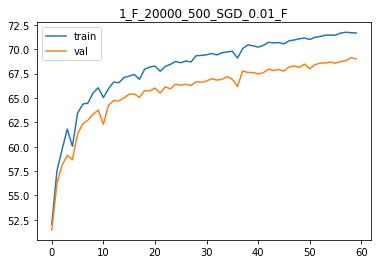

After training for 10 epochs
Train Acc 71.655
Val Acc 69.1
Test Acc 70.996
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 66.54
Epoch: [1/10], Step: [201/625], Validation Acc: 71.8
Epoch: [1/10], Step: [301/625], Validation Acc: 74.02
Epoch: [1/10], Step: [401/625], Validation Acc: 77.46
Epoch: [1/10], Step: [501/625], Validation Acc: 79.4
Epoch: [1/10], Step: [601/625], Validation Acc: 80.48
Epoch: [2/10], Step: [101/625], Validation Acc: 81.12
Epoch: [2/10], Step: [201/625], Validation Acc: 81.6
Epoch: [2/10], Step: [301/625], Validation Acc: 82.16
Epoch: [2/10], Step: [401/625], Validation Acc: 82.78
Epoch: [2/10], Step: [501/625], Validation Acc: 83.04
Epoch: [2/10], Step: [601/625], Validation Acc: 83.36
Epoch: [3/10], Step: [101/625], Validation Acc: 83.44
Epoch: [3/10], Step: [201/625], Validation Acc: 83.5
Epoch: [3/10], Step: [301/625], Validation A

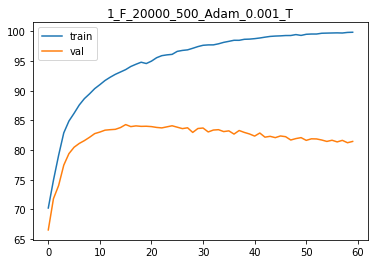

After training for 10 epochs
Train Acc 99.825
Val Acc 81.24
Test Acc 82.584
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 49.3
Epoch: [1/10], Step: [201/625], Validation Acc: 49.9
Epoch: [1/10], Step: [301/625], Validation Acc: 50.62
Epoch: [1/10], Step: [401/625], Validation Acc: 50.62
Epoch: [1/10], Step: [501/625], Validation Acc: 51.9
Epoch: [1/10], Step: [601/625], Validation Acc: 52.18
Epoch: [2/10], Step: [101/625], Validation Acc: 53.16
Epoch: [2/10], Step: [201/625], Validation Acc: 53.52
Epoch: [2/10], Step: [301/625], Validation Acc: 54.34
Epoch: [2/10], Step: [401/625], Validation Acc: 54.66
Epoch: [2/10], Step: [501/625], Validation Acc: 55.28
Epoch: [2/10], Step: [601/625], Validation Acc: 55.8
Epoch: [3/10], Step: [101/625], Validation Acc: 56.26
Epoch: [3/10], Step: [201/625], Validation Acc: 56.6
Epoch: [3/10], Step: [301/625], Validation Ac

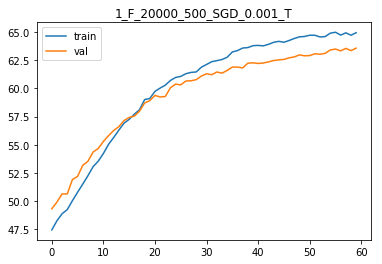

After training for 10 epochs
Train Acc 65.265
Val Acc 63.78
Test Acc 64.784
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 67.6
Epoch: [1/10], Step: [201/625], Validation Acc: 71.54
Epoch: [1/10], Step: [301/625], Validation Acc: 75.34
Epoch: [1/10], Step: [401/625], Validation Acc: 77.78
Epoch: [1/10], Step: [501/625], Validation Acc: 79.14
Epoch: [1/10], Step: [601/625], Validation Acc: 80.44
Epoch: [2/10], Step: [101/625], Validation Acc: 82.02
Epoch: [2/10], Step: [201/625], Validation Acc: 82.68
Epoch: [2/10], Step: [301/625], Validation Acc: 82.68
Epoch: [2/10], Step: [401/625], Validation Acc: 83.42
Epoch: [2/10], Step: [501/625], Validation Acc: 83.16
Epoch: [2/10], Step: [601/625], Validation Acc: 83.68
Epoch: [3/10], Step: [101/625], Validation Acc: 83.66
Epoch: [3/10], Step: [201/625], Validation Acc: 83.92
Epoch: [3/10], Step: [301/625], Validati

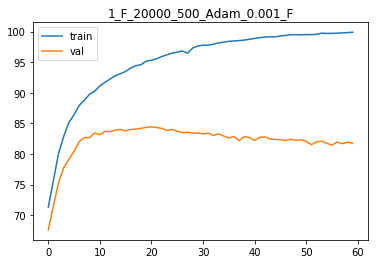

After training for 10 epochs
Train Acc 99.895
Val Acc 81.82
Test Acc 82.724
ngram:  1
use all_ngram? :  F
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.94
Epoch: [1/10], Step: [201/625], Validation Acc: 51.64
Epoch: [1/10], Step: [301/625], Validation Acc: 52.12
Epoch: [1/10], Step: [401/625], Validation Acc: 53.5
Epoch: [1/10], Step: [501/625], Validation Acc: 54.34
Epoch: [1/10], Step: [601/625], Validation Acc: 55.16
Epoch: [2/10], Step: [101/625], Validation Acc: 56.4
Epoch: [2/10], Step: [201/625], Validation Acc: 56.96
Epoch: [2/10], Step: [301/625], Validation Acc: 57.68
Epoch: [2/10], Step: [401/625], Validation Acc: 57.96
Epoch: [2/10], Step: [501/625], Validation Acc: 58.44
Epoch: [2/10], Step: [601/625], Validation Acc: 58.92
Epoch: [3/10], Step: [101/625], Validation Acc: 59.04
Epoch: [3/10], Step: [201/625], Validation Acc: 59.38
Epoch: [3/10], Step: [301/625], Validation

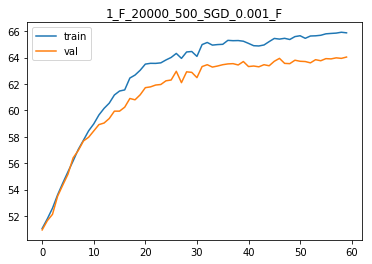

After training for 10 epochs
Train Acc 65.73
Val Acc 64.02
Test Acc 65.236
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.84
Epoch: [1/10], Step: [201/625], Validation Acc: 81.2
Epoch: [1/10], Step: [301/625], Validation Acc: 81.52
Epoch: [1/10], Step: [401/625], Validation Acc: 82.54
Epoch: [1/10], Step: [501/625], Validation Acc: 82.34
Epoch: [1/10], Step: [601/625], Validation Acc: 82.26
Epoch: [2/10], Step: [101/625], Validation Acc: 81.46
Epoch: [2/10], Step: [201/625], Validation Acc: 80.06
Epoch: [2/10], Step: [301/625], Validation Acc: 80.14
Epoch: [2/10], Step: [401/625], Validation Acc: 73.34
Epoch: [2/10], Step: [501/625], Validation Acc: 81.72
Epoch: [2/10], Step: [601/625], Validation Acc: 74.98
Epoch: [3/10], Step: [101/625], Validation Acc: 80.72
Epoch: [3/10], Step: [201/625], Validation Acc: 80.2
Epoch: [3/10], Step: [301/625], Validation Ac

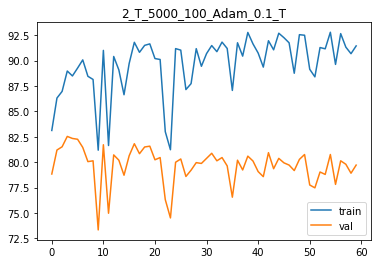

After training for 10 epochs
Train Acc 90.255
Val Acc 79.24
Test Acc 80.388
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.72
Epoch: [1/10], Step: [201/625], Validation Acc: 60.5
Epoch: [1/10], Step: [301/625], Validation Acc: 61.04
Epoch: [1/10], Step: [401/625], Validation Acc: 60.76
Epoch: [1/10], Step: [501/625], Validation Acc: 61.24
Epoch: [1/10], Step: [601/625], Validation Acc: 62.66
Epoch: [2/10], Step: [101/625], Validation Acc: 61.88
Epoch: [2/10], Step: [201/625], Validation Acc: 61.68
Epoch: [2/10], Step: [301/625], Validation Acc: 62.44
Epoch: [2/10], Step: [401/625], Validation Acc: 62.2
Epoch: [2/10], Step: [501/625], Validation Acc: 61.92
Epoch: [2/10], Step: [601/625], Validation Acc: 63.54
Epoch: [3/10], Step: [101/625], Validation Acc: 63.96
Epoch: [3/10], Step: [201/625], Validation Acc: 64.3
Epoch: [3/10], Step: [301/625], Validation Acc

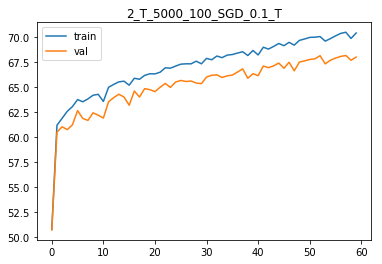

After training for 10 epochs
Train Acc 70.715
Val Acc 68.34
Test Acc 70.0
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.9
Epoch: [1/10], Step: [201/625], Validation Acc: 80.32
Epoch: [1/10], Step: [301/625], Validation Acc: 82.12
Epoch: [1/10], Step: [401/625], Validation Acc: 81.46
Epoch: [1/10], Step: [501/625], Validation Acc: 81.44
Epoch: [1/10], Step: [601/625], Validation Acc: 76.32
Epoch: [2/10], Step: [101/625], Validation Acc: 79.8
Epoch: [2/10], Step: [201/625], Validation Acc: 80.48
Epoch: [2/10], Step: [301/625], Validation Acc: 78.58
Epoch: [2/10], Step: [401/625], Validation Acc: 80.32
Epoch: [2/10], Step: [501/625], Validation Acc: 80.8
Epoch: [2/10], Step: [601/625], Validation Acc: 79.92
Epoch: [3/10], Step: [101/625], Validation Acc: 82.3
Epoch: [3/10], Step: [201/625], Validation Acc: 81.58
Epoch: [3/10], Step: [301/625], Validation Acc: 

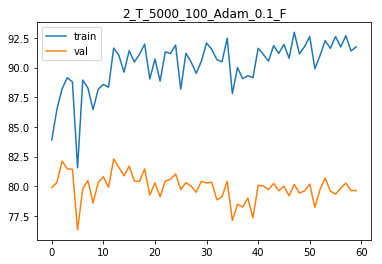

After training for 10 epochs
Train Acc 92.79
Val Acc 80.26
Test Acc 81.316
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 54.84
Epoch: [1/10], Step: [201/625], Validation Acc: 58.62
Epoch: [1/10], Step: [301/625], Validation Acc: 57.66
Epoch: [1/10], Step: [401/625], Validation Acc: 60.5
Epoch: [1/10], Step: [501/625], Validation Acc: 58.36
Epoch: [1/10], Step: [601/625], Validation Acc: 61.18
Epoch: [2/10], Step: [101/625], Validation Acc: 60.88
Epoch: [2/10], Step: [201/625], Validation Acc: 61.44
Epoch: [2/10], Step: [301/625], Validation Acc: 62.44
Epoch: [2/10], Step: [401/625], Validation Acc: 61.56
Epoch: [2/10], Step: [501/625], Validation Acc: 62.4
Epoch: [2/10], Step: [601/625], Validation Acc: 62.5
Epoch: [3/10], Step: [101/625], Validation Acc: 62.96
Epoch: [3/10], Step: [201/625], Validation Acc: 61.66
Epoch: [3/10], Step: [301/625], Validation Acc:

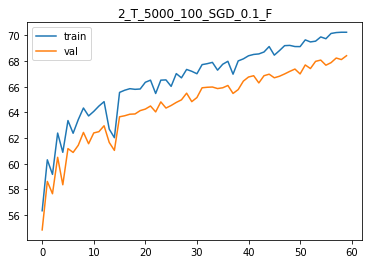

After training for 10 epochs
Train Acc 70.465
Val Acc 68.52
Test Acc 70.056
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.7
Epoch: [1/10], Step: [201/625], Validation Acc: 80.32
Epoch: [1/10], Step: [301/625], Validation Acc: 82.18
Epoch: [1/10], Step: [401/625], Validation Acc: 82.98
Epoch: [1/10], Step: [501/625], Validation Acc: 83.32
Epoch: [1/10], Step: [601/625], Validation Acc: 83.68
Epoch: [2/10], Step: [101/625], Validation Acc: 83.26
Epoch: [2/10], Step: [201/625], Validation Acc: 83.0
Epoch: [2/10], Step: [301/625], Validation Acc: 83.2
Epoch: [2/10], Step: [401/625], Validation Acc: 83.4
Epoch: [2/10], Step: [501/625], Validation Acc: 82.86
Epoch: [2/10], Step: [601/625], Validation Acc: 83.56
Epoch: [3/10], Step: [101/625], Validation Acc: 83.2
Epoch: [3/10], Step: [201/625], Validation Acc: 83.16
Epoch: [3/10], Step: [301/625], Validation Acc

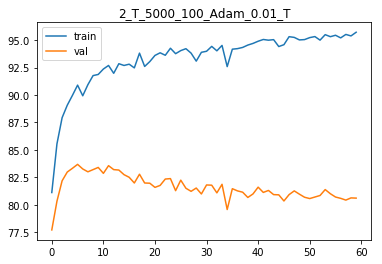

After training for 10 epochs
Train Acc 95.845
Val Acc 80.74
Test Acc 81.928
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 53.02
Epoch: [1/10], Step: [201/625], Validation Acc: 52.98
Epoch: [1/10], Step: [301/625], Validation Acc: 55.9
Epoch: [1/10], Step: [401/625], Validation Acc: 54.64
Epoch: [1/10], Step: [501/625], Validation Acc: 57.1
Epoch: [1/10], Step: [601/625], Validation Acc: 57.6
Epoch: [2/10], Step: [101/625], Validation Acc: 58.86
Epoch: [2/10], Step: [201/625], Validation Acc: 58.52
Epoch: [2/10], Step: [301/625], Validation Acc: 59.12
Epoch: [2/10], Step: [401/625], Validation Acc: 60.2
Epoch: [2/10], Step: [501/625], Validation Acc: 60.72
Epoch: [2/10], Step: [601/625], Validation Acc: 60.48
Epoch: [3/10], Step: [101/625], Validation Acc: 60.48
Epoch: [3/10], Step: [201/625], Validation Acc: 60.36
Epoch: [3/10], Step: [301/625], Validation Acc

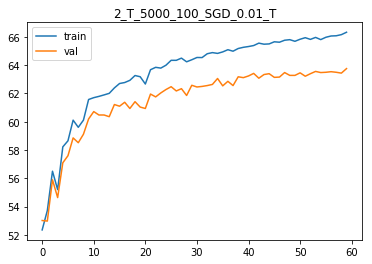

After training for 10 epochs
Train Acc 66.34
Val Acc 63.56
Test Acc 65.732
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 76.46
Epoch: [1/10], Step: [201/625], Validation Acc: 80.86
Epoch: [1/10], Step: [301/625], Validation Acc: 83.32
Epoch: [1/10], Step: [401/625], Validation Acc: 83.8
Epoch: [1/10], Step: [501/625], Validation Acc: 84.36
Epoch: [1/10], Step: [601/625], Validation Acc: 83.92
Epoch: [2/10], Step: [101/625], Validation Acc: 83.54
Epoch: [2/10], Step: [201/625], Validation Acc: 83.6
Epoch: [2/10], Step: [301/625], Validation Acc: 83.48
Epoch: [2/10], Step: [401/625], Validation Acc: 83.36
Epoch: [2/10], Step: [501/625], Validation Acc: 82.96
Epoch: [2/10], Step: [601/625], Validation Acc: 82.84
Epoch: [3/10], Step: [101/625], Validation Acc: 83.08
Epoch: [3/10], Step: [201/625], Validation Acc: 81.66
Epoch: [3/10], Step: [301/625], Validation A

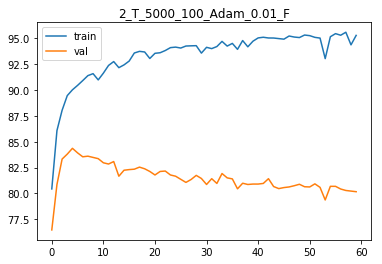

After training for 10 epochs
Train Acc 95.535
Val Acc 80.28
Test Acc 81.776
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.86
Epoch: [1/10], Step: [201/625], Validation Acc: 52.04
Epoch: [1/10], Step: [301/625], Validation Acc: 52.14
Epoch: [1/10], Step: [401/625], Validation Acc: 54.02
Epoch: [1/10], Step: [501/625], Validation Acc: 53.08
Epoch: [1/10], Step: [601/625], Validation Acc: 55.46
Epoch: [2/10], Step: [101/625], Validation Acc: 55.0
Epoch: [2/10], Step: [201/625], Validation Acc: 56.06
Epoch: [2/10], Step: [301/625], Validation Acc: 56.7
Epoch: [2/10], Step: [401/625], Validation Acc: 57.88
Epoch: [2/10], Step: [501/625], Validation Acc: 57.4
Epoch: [2/10], Step: [601/625], Validation Acc: 57.82
Epoch: [3/10], Step: [101/625], Validation Acc: 58.52
Epoch: [3/10], Step: [201/625], Validation Acc: 59.06
Epoch: [3/10], Step: [301/625], Validation Ac

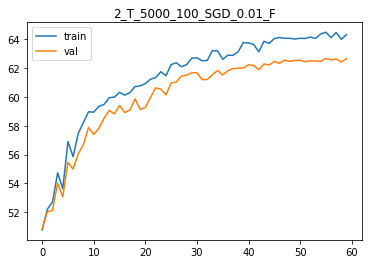

After training for 10 epochs
Train Acc 64.575
Val Acc 62.68
Test Acc 64.22
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 60.5
Epoch: [1/10], Step: [201/625], Validation Acc: 65.28
Epoch: [1/10], Step: [301/625], Validation Acc: 69.2
Epoch: [1/10], Step: [401/625], Validation Acc: 72.36
Epoch: [1/10], Step: [501/625], Validation Acc: 74.54
Epoch: [1/10], Step: [601/625], Validation Acc: 76.4
Epoch: [2/10], Step: [101/625], Validation Acc: 77.5
Epoch: [2/10], Step: [201/625], Validation Acc: 78.48
Epoch: [2/10], Step: [301/625], Validation Acc: 79.22
Epoch: [2/10], Step: [401/625], Validation Acc: 79.92
Epoch: [2/10], Step: [501/625], Validation Acc: 80.12
Epoch: [2/10], Step: [601/625], Validation Acc: 80.54
Epoch: [3/10], Step: [101/625], Validation Acc: 81.18
Epoch: [3/10], Step: [201/625], Validation Acc: 81.22
Epoch: [3/10], Step: [301/625], Validation Ac

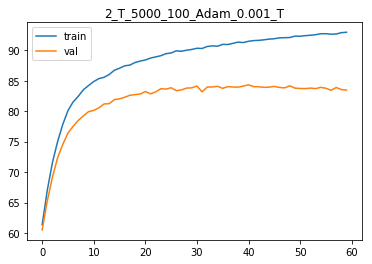

After training for 10 epochs
Train Acc 93.02
Val Acc 83.7
Test Acc 84.988
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 49.92
Epoch: [1/10], Step: [201/625], Validation Acc: 49.78
Epoch: [1/10], Step: [301/625], Validation Acc: 50.28
Epoch: [1/10], Step: [401/625], Validation Acc: 50.26
Epoch: [1/10], Step: [501/625], Validation Acc: 51.08
Epoch: [1/10], Step: [601/625], Validation Acc: 50.84
Epoch: [2/10], Step: [101/625], Validation Acc: 51.14
Epoch: [2/10], Step: [201/625], Validation Acc: 51.52
Epoch: [2/10], Step: [301/625], Validation Acc: 51.52
Epoch: [2/10], Step: [401/625], Validation Acc: 51.86
Epoch: [2/10], Step: [501/625], Validation Acc: 51.68
Epoch: [2/10], Step: [601/625], Validation Acc: 51.4
Epoch: [3/10], Step: [101/625], Validation Acc: 51.28
Epoch: [3/10], Step: [201/625], Validation Acc: 51.22
Epoch: [3/10], Step: [301/625], Validation A

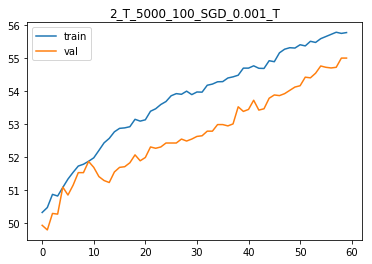

After training for 10 epochs
Train Acc 55.885
Val Acc 54.96
Test Acc 56.072
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 61.3
Epoch: [1/10], Step: [201/625], Validation Acc: 66.22
Epoch: [1/10], Step: [301/625], Validation Acc: 68.22
Epoch: [1/10], Step: [401/625], Validation Acc: 71.3
Epoch: [1/10], Step: [501/625], Validation Acc: 72.72
Epoch: [1/10], Step: [601/625], Validation Acc: 75.8
Epoch: [2/10], Step: [101/625], Validation Acc: 77.12
Epoch: [2/10], Step: [201/625], Validation Acc: 78.28
Epoch: [2/10], Step: [301/625], Validation Acc: 79.34
Epoch: [2/10], Step: [401/625], Validation Acc: 79.86
Epoch: [2/10], Step: [501/625], Validation Acc: 80.96
Epoch: [2/10], Step: [601/625], Validation Acc: 81.26
Epoch: [3/10], Step: [101/625], Validation Acc: 81.34
Epoch: [3/10], Step: [201/625], Validation Acc: 81.7
Epoch: [3/10], Step: [301/625], Validation A

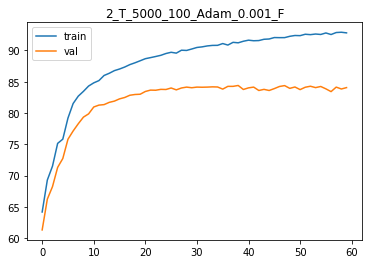

After training for 10 epochs
Train Acc 92.91
Val Acc 83.78
Test Acc 85.168
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 47.32
Epoch: [1/10], Step: [201/625], Validation Acc: 47.22
Epoch: [1/10], Step: [301/625], Validation Acc: 46.62
Epoch: [1/10], Step: [401/625], Validation Acc: 46.88
Epoch: [1/10], Step: [501/625], Validation Acc: 46.76
Epoch: [1/10], Step: [601/625], Validation Acc: 47.1
Epoch: [2/10], Step: [101/625], Validation Acc: 46.92
Epoch: [2/10], Step: [201/625], Validation Acc: 47.5
Epoch: [2/10], Step: [301/625], Validation Acc: 47.12
Epoch: [2/10], Step: [401/625], Validation Acc: 47.82
Epoch: [2/10], Step: [501/625], Validation Acc: 48.18
Epoch: [2/10], Step: [601/625], Validation Acc: 48.46
Epoch: [3/10], Step: [101/625], Validation Acc: 48.62
Epoch: [3/10], Step: [201/625], Validation Acc: 48.8
Epoch: [3/10], Step: [301/625], Validation Ac

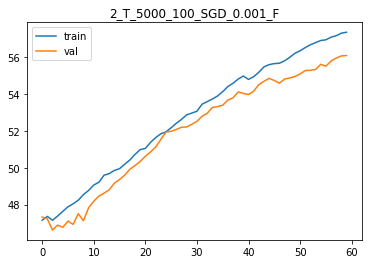

After training for 10 epochs
Train Acc 57.32
Val Acc 56.2
Test Acc 57.708
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.56
Epoch: [1/10], Step: [201/625], Validation Acc: 77.34
Epoch: [1/10], Step: [301/625], Validation Acc: 79.5
Epoch: [1/10], Step: [401/625], Validation Acc: 79.4
Epoch: [1/10], Step: [501/625], Validation Acc: 69.48
Epoch: [1/10], Step: [601/625], Validation Acc: 80.32
Epoch: [2/10], Step: [101/625], Validation Acc: 78.44
Epoch: [2/10], Step: [201/625], Validation Acc: 81.94
Epoch: [2/10], Step: [301/625], Validation Acc: 80.48
Epoch: [2/10], Step: [401/625], Validation Acc: 78.24
Epoch: [2/10], Step: [501/625], Validation Acc: 79.7
Epoch: [2/10], Step: [601/625], Validation Acc: 82.04
Epoch: [3/10], Step: [101/625], Validation Acc: 80.38
Epoch: [3/10], Step: [201/625], Validation Acc: 80.86
Epoch: [3/10], Step: [301/625], Validation Acc:

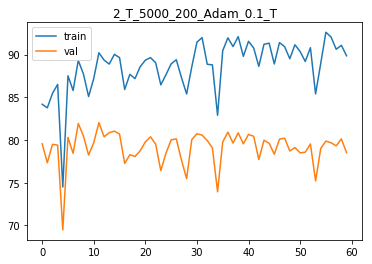

After training for 10 epochs
Train Acc 92.425
Val Acc 80.04
Test Acc 81.636
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 58.12
Epoch: [1/10], Step: [201/625], Validation Acc: 58.88
Epoch: [1/10], Step: [301/625], Validation Acc: 64.04
Epoch: [1/10], Step: [401/625], Validation Acc: 65.5
Epoch: [1/10], Step: [501/625], Validation Acc: 64.7
Epoch: [1/10], Step: [601/625], Validation Acc: 65.02
Epoch: [2/10], Step: [101/625], Validation Acc: 63.56
Epoch: [2/10], Step: [201/625], Validation Acc: 65.78
Epoch: [2/10], Step: [301/625], Validation Acc: 66.78
Epoch: [2/10], Step: [401/625], Validation Acc: 67.44
Epoch: [2/10], Step: [501/625], Validation Acc: 65.96
Epoch: [2/10], Step: [601/625], Validation Acc: 66.2
Epoch: [3/10], Step: [101/625], Validation Acc: 67.6
Epoch: [3/10], Step: [201/625], Validation Acc: 67.08
Epoch: [3/10], Step: [301/625], Validation Acc:

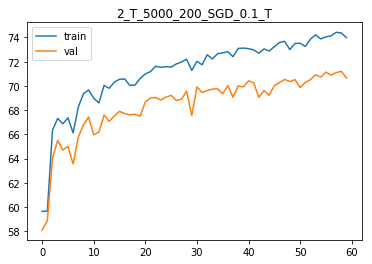

After training for 10 epochs
Train Acc 74.28
Val Acc 71.04
Test Acc 72.784
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 72.76
Epoch: [1/10], Step: [201/625], Validation Acc: 78.42
Epoch: [1/10], Step: [301/625], Validation Acc: 80.34
Epoch: [1/10], Step: [401/625], Validation Acc: 80.36
Epoch: [1/10], Step: [501/625], Validation Acc: 80.42
Epoch: [1/10], Step: [601/625], Validation Acc: 81.62
Epoch: [2/10], Step: [101/625], Validation Acc: 79.44
Epoch: [2/10], Step: [201/625], Validation Acc: 80.34
Epoch: [2/10], Step: [301/625], Validation Acc: 78.78
Epoch: [2/10], Step: [401/625], Validation Acc: 80.36
Epoch: [2/10], Step: [501/625], Validation Acc: 81.02
Epoch: [2/10], Step: [601/625], Validation Acc: 73.28
Epoch: [3/10], Step: [101/625], Validation Acc: 80.6
Epoch: [3/10], Step: [201/625], Validation Acc: 76.5
Epoch: [3/10], Step: [301/625], Validation Ac

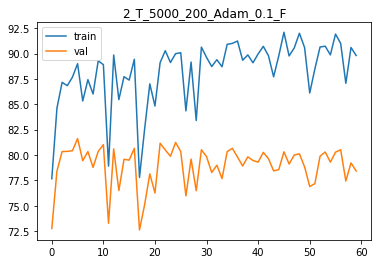

After training for 10 epochs
Train Acc 86.44
Val Acc 76.9
Test Acc 77.516
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 55.52
Epoch: [1/10], Step: [201/625], Validation Acc: 61.94
Epoch: [1/10], Step: [301/625], Validation Acc: 63.1
Epoch: [1/10], Step: [401/625], Validation Acc: 63.56
Epoch: [1/10], Step: [501/625], Validation Acc: 64.98
Epoch: [1/10], Step: [601/625], Validation Acc: 63.9
Epoch: [2/10], Step: [101/625], Validation Acc: 64.38
Epoch: [2/10], Step: [201/625], Validation Acc: 65.74
Epoch: [2/10], Step: [301/625], Validation Acc: 66.14
Epoch: [2/10], Step: [401/625], Validation Acc: 66.14
Epoch: [2/10], Step: [501/625], Validation Acc: 65.6
Epoch: [2/10], Step: [601/625], Validation Acc: 66.62
Epoch: [3/10], Step: [101/625], Validation Acc: 66.64
Epoch: [3/10], Step: [201/625], Validation Acc: 66.82
Epoch: [3/10], Step: [301/625], Validation Acc: 

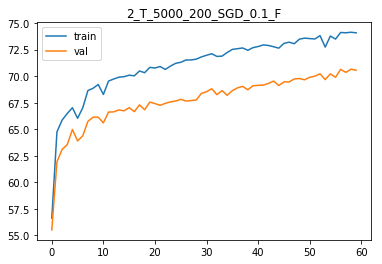

After training for 10 epochs
Train Acc 74.305
Val Acc 70.9
Test Acc 73.44
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.74
Epoch: [1/10], Step: [201/625], Validation Acc: 81.8
Epoch: [1/10], Step: [301/625], Validation Acc: 82.92
Epoch: [1/10], Step: [401/625], Validation Acc: 83.16
Epoch: [1/10], Step: [501/625], Validation Acc: 83.16
Epoch: [1/10], Step: [601/625], Validation Acc: 83.7
Epoch: [2/10], Step: [101/625], Validation Acc: 83.7
Epoch: [2/10], Step: [201/625], Validation Acc: 82.9
Epoch: [2/10], Step: [301/625], Validation Acc: 83.68
Epoch: [2/10], Step: [401/625], Validation Acc: 82.22
Epoch: [2/10], Step: [501/625], Validation Acc: 83.0
Epoch: [2/10], Step: [601/625], Validation Acc: 83.28
Epoch: [3/10], Step: [101/625], Validation Acc: 82.76
Epoch: [3/10], Step: [201/625], Validation Acc: 82.42
Epoch: [3/10], Step: [301/625], Validation Acc: 

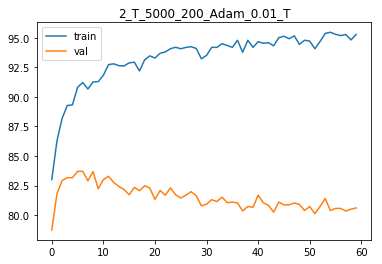

After training for 10 epochs
Train Acc 95.1
Val Acc 80.6
Test Acc 82.172
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 51.38
Epoch: [1/10], Step: [201/625], Validation Acc: 53.1
Epoch: [1/10], Step: [301/625], Validation Acc: 55.62
Epoch: [1/10], Step: [401/625], Validation Acc: 56.38
Epoch: [1/10], Step: [501/625], Validation Acc: 55.78
Epoch: [1/10], Step: [601/625], Validation Acc: 57.4
Epoch: [2/10], Step: [101/625], Validation Acc: 59.5
Epoch: [2/10], Step: [201/625], Validation Acc: 58.5
Epoch: [2/10], Step: [301/625], Validation Acc: 60.22
Epoch: [2/10], Step: [401/625], Validation Acc: 59.86
Epoch: [2/10], Step: [501/625], Validation Acc: 60.16
Epoch: [2/10], Step: [601/625], Validation Acc: 60.3
Epoch: [3/10], Step: [101/625], Validation Acc: 60.68
Epoch: [3/10], Step: [201/625], Validation Acc: 60.78
Epoch: [3/10], Step: [301/625], Validation Acc: 59

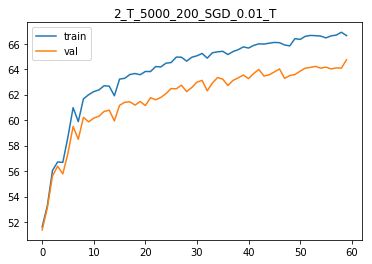

After training for 10 epochs
Train Acc 66.96
Val Acc 64.46
Test Acc 66.64
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.84
Epoch: [1/10], Step: [201/625], Validation Acc: 82.46
Epoch: [1/10], Step: [301/625], Validation Acc: 82.92
Epoch: [1/10], Step: [401/625], Validation Acc: 83.1
Epoch: [1/10], Step: [501/625], Validation Acc: 83.24
Epoch: [1/10], Step: [601/625], Validation Acc: 83.58
Epoch: [2/10], Step: [101/625], Validation Acc: 83.5
Epoch: [2/10], Step: [201/625], Validation Acc: 81.34
Epoch: [2/10], Step: [301/625], Validation Acc: 83.02
Epoch: [2/10], Step: [401/625], Validation Acc: 83.42
Epoch: [2/10], Step: [501/625], Validation Acc: 82.72
Epoch: [2/10], Step: [601/625], Validation Acc: 83.38
Epoch: [3/10], Step: [101/625], Validation Acc: 83.06
Epoch: [3/10], Step: [201/625], Validation Acc: 82.5
Epoch: [3/10], Step: [301/625], Validation Acc

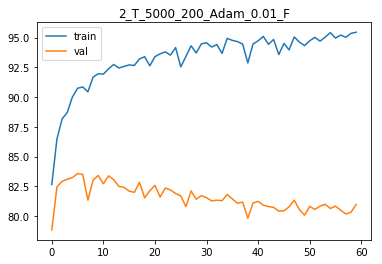

After training for 10 epochs
Train Acc 95.585
Val Acc 80.94
Test Acc 82.112
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.7
Epoch: [1/10], Step: [201/625], Validation Acc: 55.16
Epoch: [1/10], Step: [301/625], Validation Acc: 56.02
Epoch: [1/10], Step: [401/625], Validation Acc: 58.4
Epoch: [1/10], Step: [501/625], Validation Acc: 59.44
Epoch: [1/10], Step: [601/625], Validation Acc: 56.64
Epoch: [2/10], Step: [101/625], Validation Acc: 61.08
Epoch: [2/10], Step: [201/625], Validation Acc: 60.88
Epoch: [2/10], Step: [301/625], Validation Acc: 59.96
Epoch: [2/10], Step: [401/625], Validation Acc: 60.64
Epoch: [2/10], Step: [501/625], Validation Acc: 61.48
Epoch: [2/10], Step: [601/625], Validation Acc: 61.28
Epoch: [3/10], Step: [101/625], Validation Acc: 61.2
Epoch: [3/10], Step: [201/625], Validation Acc: 61.6
Epoch: [3/10], Step: [301/625], Validation Acc

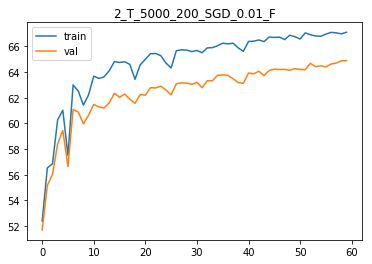

After training for 10 epochs
Train Acc 67.16
Val Acc 64.74
Test Acc 66.464
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 61.32
Epoch: [1/10], Step: [201/625], Validation Acc: 66.84
Epoch: [1/10], Step: [301/625], Validation Acc: 70.22
Epoch: [1/10], Step: [401/625], Validation Acc: 74.52
Epoch: [1/10], Step: [501/625], Validation Acc: 76.72
Epoch: [1/10], Step: [601/625], Validation Acc: 77.96
Epoch: [2/10], Step: [101/625], Validation Acc: 79.54
Epoch: [2/10], Step: [201/625], Validation Acc: 80.36
Epoch: [2/10], Step: [301/625], Validation Acc: 80.74
Epoch: [2/10], Step: [401/625], Validation Acc: 81.5
Epoch: [2/10], Step: [501/625], Validation Acc: 81.76
Epoch: [2/10], Step: [601/625], Validation Acc: 82.2
Epoch: [3/10], Step: [101/625], Validation Acc: 81.9
Epoch: [3/10], Step: [201/625], Validation Acc: 83.2
Epoch: [3/10], Step: [301/625], Validation Ac

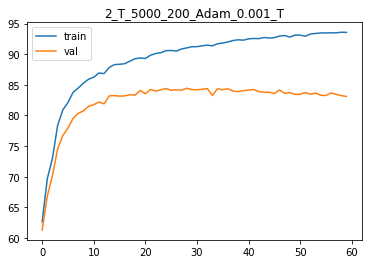

After training for 10 epochs
Train Acc 93.865
Val Acc 83.28
Test Acc 84.708
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.78
Epoch: [1/10], Step: [201/625], Validation Acc: 51.0
Epoch: [1/10], Step: [301/625], Validation Acc: 51.0
Epoch: [1/10], Step: [401/625], Validation Acc: 51.92
Epoch: [1/10], Step: [501/625], Validation Acc: 52.26
Epoch: [1/10], Step: [601/625], Validation Acc: 52.44
Epoch: [2/10], Step: [101/625], Validation Acc: 53.42
Epoch: [2/10], Step: [201/625], Validation Acc: 53.6
Epoch: [2/10], Step: [301/625], Validation Acc: 53.72
Epoch: [2/10], Step: [401/625], Validation Acc: 54.0
Epoch: [2/10], Step: [501/625], Validation Acc: 53.96
Epoch: [2/10], Step: [601/625], Validation Acc: 54.44
Epoch: [3/10], Step: [101/625], Validation Acc: 55.04
Epoch: [3/10], Step: [201/625], Validation Acc: 55.28
Epoch: [3/10], Step: [301/625], Validation Ac

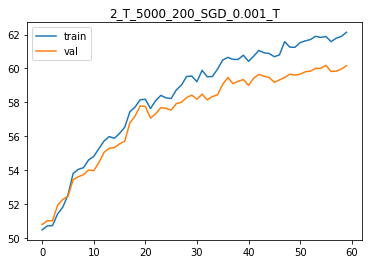

After training for 10 epochs
Train Acc 62.12
Val Acc 60.08
Test Acc 61.936
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 61.1
Epoch: [1/10], Step: [201/625], Validation Acc: 66.1
Epoch: [1/10], Step: [301/625], Validation Acc: 70.46
Epoch: [1/10], Step: [401/625], Validation Acc: 73.44
Epoch: [1/10], Step: [501/625], Validation Acc: 76.32
Epoch: [1/10], Step: [601/625], Validation Acc: 77.74
Epoch: [2/10], Step: [101/625], Validation Acc: 78.3
Epoch: [2/10], Step: [201/625], Validation Acc: 79.76
Epoch: [2/10], Step: [301/625], Validation Acc: 80.58
Epoch: [2/10], Step: [401/625], Validation Acc: 80.7
Epoch: [2/10], Step: [501/625], Validation Acc: 81.24
Epoch: [2/10], Step: [601/625], Validation Acc: 81.94
Epoch: [3/10], Step: [101/625], Validation Acc: 81.8
Epoch: [3/10], Step: [201/625], Validation Acc: 81.84
Epoch: [3/10], Step: [301/625], Validation Acc

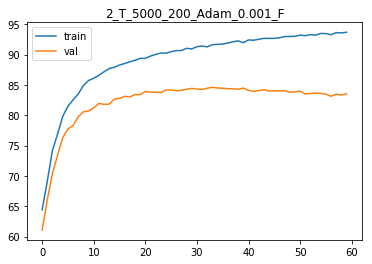

After training for 10 epochs
Train Acc 93.505
Val Acc 83.46
Test Acc 84.68
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.12
Epoch: [1/10], Step: [201/625], Validation Acc: 50.06
Epoch: [1/10], Step: [301/625], Validation Acc: 50.76
Epoch: [1/10], Step: [401/625], Validation Acc: 50.9
Epoch: [1/10], Step: [501/625], Validation Acc: 51.02
Epoch: [1/10], Step: [601/625], Validation Acc: 51.56
Epoch: [2/10], Step: [101/625], Validation Acc: 52.46
Epoch: [2/10], Step: [201/625], Validation Acc: 53.28
Epoch: [2/10], Step: [301/625], Validation Acc: 53.62
Epoch: [2/10], Step: [401/625], Validation Acc: 54.0
Epoch: [2/10], Step: [501/625], Validation Acc: 54.28
Epoch: [2/10], Step: [601/625], Validation Acc: 54.62
Epoch: [3/10], Step: [101/625], Validation Acc: 55.1
Epoch: [3/10], Step: [201/625], Validation Acc: 55.32
Epoch: [3/10], Step: [301/625], Validation Ac

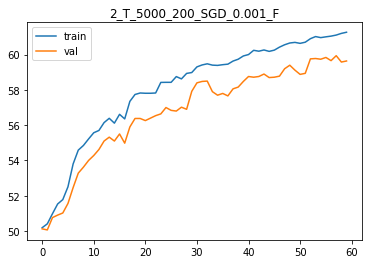

After training for 10 epochs
Train Acc 61.35
Val Acc 59.98
Test Acc 61.252
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 76.24
Epoch: [1/10], Step: [201/625], Validation Acc: 77.6
Epoch: [1/10], Step: [301/625], Validation Acc: 79.42
Epoch: [1/10], Step: [401/625], Validation Acc: 67.54
Epoch: [1/10], Step: [501/625], Validation Acc: 79.24
Epoch: [1/10], Step: [601/625], Validation Acc: 78.88
Epoch: [2/10], Step: [101/625], Validation Acc: 78.26
Epoch: [2/10], Step: [201/625], Validation Acc: 76.6
Epoch: [2/10], Step: [301/625], Validation Acc: 81.24
Epoch: [2/10], Step: [401/625], Validation Acc: 78.42
Epoch: [2/10], Step: [501/625], Validation Acc: 79.82
Epoch: [2/10], Step: [601/625], Validation Acc: 72.32
Epoch: [3/10], Step: [101/625], Validation Acc: 79.3
Epoch: [3/10], Step: [201/625], Validation Acc: 80.78
Epoch: [3/10], Step: [301/625], Validation Acc

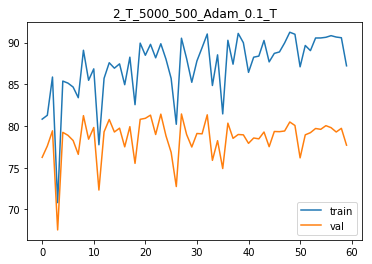

After training for 10 epochs
Train Acc 91.68
Val Acc 79.1
Test Acc 80.732
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 64.2
Epoch: [1/10], Step: [201/625], Validation Acc: 65.52
Epoch: [1/10], Step: [301/625], Validation Acc: 65.9
Epoch: [1/10], Step: [401/625], Validation Acc: 67.5
Epoch: [1/10], Step: [501/625], Validation Acc: 68.02
Epoch: [1/10], Step: [601/625], Validation Acc: 68.64
Epoch: [2/10], Step: [101/625], Validation Acc: 69.24
Epoch: [2/10], Step: [201/625], Validation Acc: 69.76
Epoch: [2/10], Step: [301/625], Validation Acc: 69.36
Epoch: [2/10], Step: [401/625], Validation Acc: 70.44
Epoch: [2/10], Step: [501/625], Validation Acc: 70.86
Epoch: [2/10], Step: [601/625], Validation Acc: 71.28
Epoch: [3/10], Step: [101/625], Validation Acc: 71.5
Epoch: [3/10], Step: [201/625], Validation Acc: 71.72
Epoch: [3/10], Step: [301/625], Validation Acc: 7

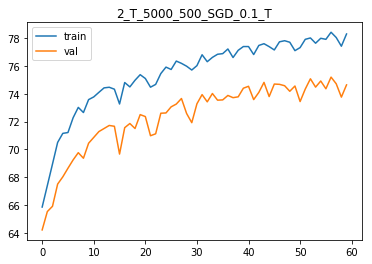

After training for 10 epochs
Train Acc 78.38
Val Acc 74.88
Test Acc 76.904
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.54
Epoch: [1/10], Step: [201/625], Validation Acc: 79.8
Epoch: [1/10], Step: [301/625], Validation Acc: 74.06
Epoch: [1/10], Step: [401/625], Validation Acc: 77.6
Epoch: [1/10], Step: [501/625], Validation Acc: 79.02
Epoch: [1/10], Step: [601/625], Validation Acc: 77.46
Epoch: [2/10], Step: [101/625], Validation Acc: 76.56
Epoch: [2/10], Step: [201/625], Validation Acc: 78.5
Epoch: [2/10], Step: [301/625], Validation Acc: 77.46
Epoch: [2/10], Step: [401/625], Validation Acc: 72.64
Epoch: [2/10], Step: [501/625], Validation Acc: 77.72
Epoch: [2/10], Step: [601/625], Validation Acc: 79.78
Epoch: [3/10], Step: [101/625], Validation Acc: 76.4
Epoch: [3/10], Step: [201/625], Validation Acc: 80.22
Epoch: [3/10], Step: [301/625], Validation Acc:

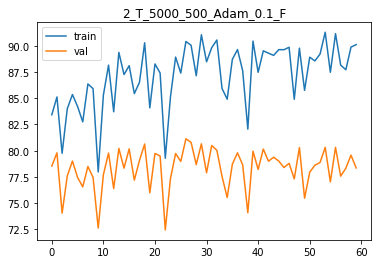

After training for 10 epochs
Train Acc 89.625
Val Acc 78.8
Test Acc 80.384
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 62.76
Epoch: [1/10], Step: [201/625], Validation Acc: 63.22
Epoch: [1/10], Step: [301/625], Validation Acc: 66.16
Epoch: [1/10], Step: [401/625], Validation Acc: 66.24
Epoch: [1/10], Step: [501/625], Validation Acc: 67.76
Epoch: [1/10], Step: [601/625], Validation Acc: 66.46
Epoch: [2/10], Step: [101/625], Validation Acc: 67.9
Epoch: [2/10], Step: [201/625], Validation Acc: 69.9
Epoch: [2/10], Step: [301/625], Validation Acc: 69.54
Epoch: [2/10], Step: [401/625], Validation Acc: 68.96
Epoch: [2/10], Step: [501/625], Validation Acc: 70.24
Epoch: [2/10], Step: [601/625], Validation Acc: 70.28
Epoch: [3/10], Step: [101/625], Validation Acc: 70.64
Epoch: [3/10], Step: [201/625], Validation Acc: 70.8
Epoch: [3/10], Step: [301/625], Validation Acc:

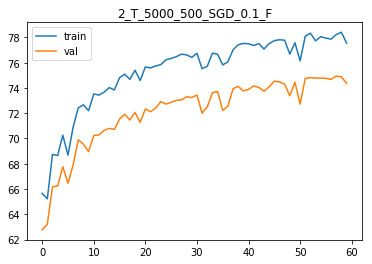

After training for 10 epochs
Train Acc 78.19
Val Acc 75.12
Test Acc 76.896
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.7
Epoch: [1/10], Step: [201/625], Validation Acc: 81.48
Epoch: [1/10], Step: [301/625], Validation Acc: 82.98
Epoch: [1/10], Step: [401/625], Validation Acc: 81.48
Epoch: [1/10], Step: [501/625], Validation Acc: 82.22
Epoch: [1/10], Step: [601/625], Validation Acc: 83.0
Epoch: [2/10], Step: [101/625], Validation Acc: 83.3
Epoch: [2/10], Step: [201/625], Validation Acc: 82.56
Epoch: [2/10], Step: [301/625], Validation Acc: 82.98
Epoch: [2/10], Step: [401/625], Validation Acc: 82.32
Epoch: [2/10], Step: [501/625], Validation Acc: 81.98
Epoch: [2/10], Step: [601/625], Validation Acc: 82.74
Epoch: [3/10], Step: [101/625], Validation Acc: 82.22
Epoch: [3/10], Step: [201/625], Validation Acc: 81.86
Epoch: [3/10], Step: [301/625], Validation Ac

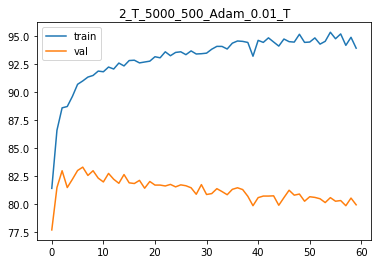

After training for 10 epochs
Train Acc 95.025
Val Acc 80.56
Test Acc 81.66
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 54.16
Epoch: [1/10], Step: [201/625], Validation Acc: 58.26
Epoch: [1/10], Step: [301/625], Validation Acc: 60.72
Epoch: [1/10], Step: [401/625], Validation Acc: 59.38
Epoch: [1/10], Step: [501/625], Validation Acc: 62.04
Epoch: [1/10], Step: [601/625], Validation Acc: 62.88
Epoch: [2/10], Step: [101/625], Validation Acc: 62.98
Epoch: [2/10], Step: [201/625], Validation Acc: 63.08
Epoch: [2/10], Step: [301/625], Validation Acc: 63.48
Epoch: [2/10], Step: [401/625], Validation Acc: 64.86
Epoch: [2/10], Step: [501/625], Validation Acc: 64.76
Epoch: [2/10], Step: [601/625], Validation Acc: 64.94
Epoch: [3/10], Step: [101/625], Validation Acc: 65.34
Epoch: [3/10], Step: [201/625], Validation Acc: 65.2
Epoch: [3/10], Step: [301/625], Validation A

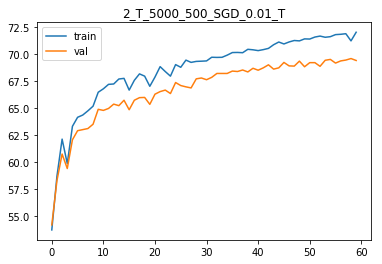

After training for 10 epochs
Train Acc 71.97
Val Acc 69.44
Test Acc 71.392
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.32
Epoch: [1/10], Step: [201/625], Validation Acc: 80.28
Epoch: [1/10], Step: [301/625], Validation Acc: 82.1
Epoch: [1/10], Step: [401/625], Validation Acc: 82.84
Epoch: [1/10], Step: [501/625], Validation Acc: 83.02
Epoch: [1/10], Step: [601/625], Validation Acc: 82.92
Epoch: [2/10], Step: [101/625], Validation Acc: 83.34
Epoch: [2/10], Step: [201/625], Validation Acc: 83.08
Epoch: [2/10], Step: [301/625], Validation Acc: 82.5
Epoch: [2/10], Step: [401/625], Validation Acc: 82.54
Epoch: [2/10], Step: [501/625], Validation Acc: 81.48
Epoch: [2/10], Step: [601/625], Validation Acc: 82.34
Epoch: [3/10], Step: [101/625], Validation Acc: 83.14
Epoch: [3/10], Step: [201/625], Validation Acc: 81.76
Epoch: [3/10], Step: [301/625], Validation A

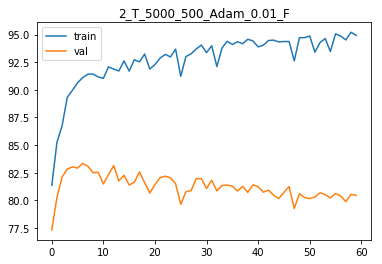

After training for 10 epochs
Train Acc 94.795
Val Acc 80.42
Test Acc 81.5
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 53.24
Epoch: [1/10], Step: [201/625], Validation Acc: 57.96
Epoch: [1/10], Step: [301/625], Validation Acc: 56.36
Epoch: [1/10], Step: [401/625], Validation Acc: 61.14
Epoch: [1/10], Step: [501/625], Validation Acc: 62.06
Epoch: [1/10], Step: [601/625], Validation Acc: 62.5
Epoch: [2/10], Step: [101/625], Validation Acc: 63.54
Epoch: [2/10], Step: [201/625], Validation Acc: 63.56
Epoch: [2/10], Step: [301/625], Validation Acc: 62.74
Epoch: [2/10], Step: [401/625], Validation Acc: 64.28
Epoch: [2/10], Step: [501/625], Validation Acc: 64.82
Epoch: [2/10], Step: [601/625], Validation Acc: 64.96
Epoch: [3/10], Step: [101/625], Validation Acc: 65.34
Epoch: [3/10], Step: [201/625], Validation Acc: 65.48
Epoch: [3/10], Step: [301/625], Validation Ac

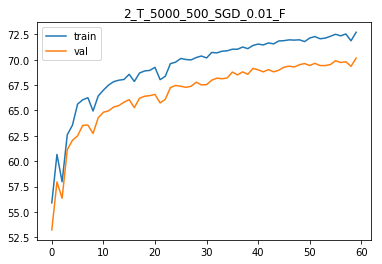

After training for 10 epochs
Train Acc 72.62
Val Acc 69.78
Test Acc 71.748
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 66.84
Epoch: [1/10], Step: [201/625], Validation Acc: 70.68
Epoch: [1/10], Step: [301/625], Validation Acc: 74.58
Epoch: [1/10], Step: [401/625], Validation Acc: 76.28
Epoch: [1/10], Step: [501/625], Validation Acc: 77.8
Epoch: [1/10], Step: [601/625], Validation Acc: 79.9
Epoch: [2/10], Step: [101/625], Validation Acc: 80.88
Epoch: [2/10], Step: [201/625], Validation Acc: 81.66
Epoch: [2/10], Step: [301/625], Validation Acc: 81.74
Epoch: [2/10], Step: [401/625], Validation Acc: 82.56
Epoch: [2/10], Step: [501/625], Validation Acc: 82.52
Epoch: [2/10], Step: [601/625], Validation Acc: 83.0
Epoch: [3/10], Step: [101/625], Validation Acc: 82.96
Epoch: [3/10], Step: [201/625], Validation Acc: 83.34
Epoch: [3/10], Step: [301/625], Validation A

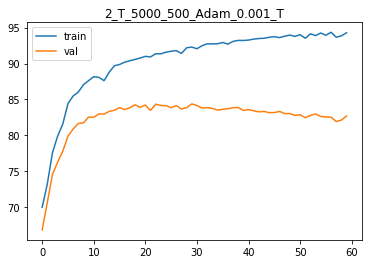

After training for 10 epochs
Train Acc 94.505
Val Acc 82.68
Test Acc 83.932
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 47.12
Epoch: [1/10], Step: [201/625], Validation Acc: 47.66
Epoch: [1/10], Step: [301/625], Validation Acc: 48.66
Epoch: [1/10], Step: [401/625], Validation Acc: 49.24
Epoch: [1/10], Step: [501/625], Validation Acc: 49.42
Epoch: [1/10], Step: [601/625], Validation Acc: 50.4
Epoch: [2/10], Step: [101/625], Validation Acc: 51.44
Epoch: [2/10], Step: [201/625], Validation Acc: 51.8
Epoch: [2/10], Step: [301/625], Validation Acc: 52.38
Epoch: [2/10], Step: [401/625], Validation Acc: 52.32
Epoch: [2/10], Step: [501/625], Validation Acc: 53.94
Epoch: [2/10], Step: [601/625], Validation Acc: 54.64
Epoch: [3/10], Step: [101/625], Validation Acc: 54.08
Epoch: [3/10], Step: [201/625], Validation Acc: 54.66
Epoch: [3/10], Step: [301/625], Validation 

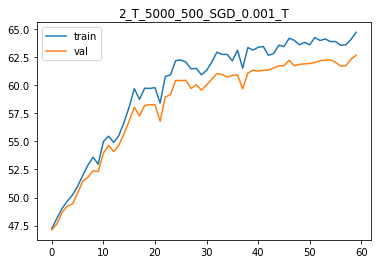

After training for 10 epochs
Train Acc 64.885
Val Acc 63.1
Test Acc 64.068
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 67.58
Epoch: [1/10], Step: [201/625], Validation Acc: 71.76
Epoch: [1/10], Step: [301/625], Validation Acc: 74.9
Epoch: [1/10], Step: [401/625], Validation Acc: 77.34
Epoch: [1/10], Step: [501/625], Validation Acc: 79.16
Epoch: [1/10], Step: [601/625], Validation Acc: 80.08
Epoch: [2/10], Step: [101/625], Validation Acc: 81.2
Epoch: [2/10], Step: [201/625], Validation Acc: 81.64
Epoch: [2/10], Step: [301/625], Validation Acc: 82.12
Epoch: [2/10], Step: [401/625], Validation Acc: 82.24
Epoch: [2/10], Step: [501/625], Validation Acc: 82.9
Epoch: [2/10], Step: [601/625], Validation Acc: 83.28
Epoch: [3/10], Step: [101/625], Validation Acc: 83.98
Epoch: [3/10], Step: [201/625], Validation Acc: 83.68
Epoch: [3/10], Step: [301/625], Validation A

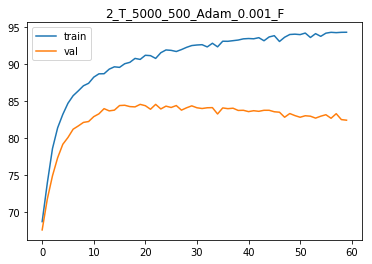

After training for 10 epochs
Train Acc 94.48
Val Acc 82.86
Test Acc 83.924
ngram:  2
use all_ngram? :  T
max_vocab_size:  5000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 47.86
Epoch: [1/10], Step: [201/625], Validation Acc: 47.54
Epoch: [1/10], Step: [301/625], Validation Acc: 48.2
Epoch: [1/10], Step: [401/625], Validation Acc: 49.04
Epoch: [1/10], Step: [501/625], Validation Acc: 50.24
Epoch: [1/10], Step: [601/625], Validation Acc: 50.38
Epoch: [2/10], Step: [101/625], Validation Acc: 51.14
Epoch: [2/10], Step: [201/625], Validation Acc: 51.66
Epoch: [2/10], Step: [301/625], Validation Acc: 52.16
Epoch: [2/10], Step: [401/625], Validation Acc: 53.12
Epoch: [2/10], Step: [501/625], Validation Acc: 53.52
Epoch: [2/10], Step: [601/625], Validation Acc: 54.32
Epoch: [3/10], Step: [101/625], Validation Acc: 55.08
Epoch: [3/10], Step: [201/625], Validation Acc: 55.86
Epoch: [3/10], Step: [301/625], Validation 

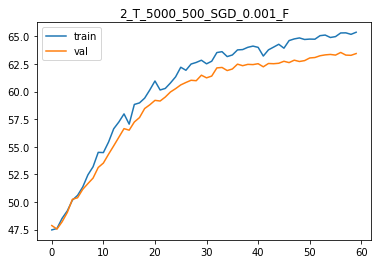

After training for 10 epochs
Train Acc 65.395
Val Acc 63.44
Test Acc 65.12
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.5
Epoch: [1/10], Step: [201/625], Validation Acc: 75.96
Epoch: [1/10], Step: [301/625], Validation Acc: 81.62
Epoch: [1/10], Step: [401/625], Validation Acc: 80.32
Epoch: [1/10], Step: [501/625], Validation Acc: 80.48
Epoch: [1/10], Step: [601/625], Validation Acc: 81.58
Epoch: [2/10], Step: [101/625], Validation Acc: 80.74
Epoch: [2/10], Step: [201/625], Validation Acc: 80.58
Epoch: [2/10], Step: [301/625], Validation Acc: 81.4
Epoch: [2/10], Step: [401/625], Validation Acc: 81.5
Epoch: [2/10], Step: [501/625], Validation Acc: 79.24
Epoch: [2/10], Step: [601/625], Validation Acc: 79.84
Epoch: [3/10], Step: [101/625], Validation Acc: 79.6
Epoch: [3/10], Step: [201/625], Validation Acc: 80.12
Epoch: [3/10], Step: [301/625], Validation Acc

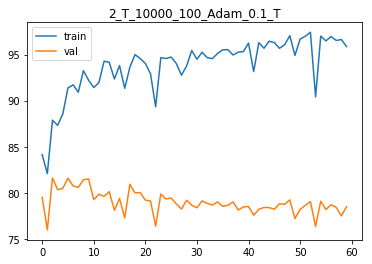

After training for 10 epochs
Train Acc 96.05
Val Acc 78.24
Test Acc 80.052
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 52.22
Epoch: [1/10], Step: [201/625], Validation Acc: 61.56
Epoch: [1/10], Step: [301/625], Validation Acc: 61.08
Epoch: [1/10], Step: [401/625], Validation Acc: 61.34
Epoch: [1/10], Step: [501/625], Validation Acc: 61.82
Epoch: [1/10], Step: [601/625], Validation Acc: 61.74
Epoch: [2/10], Step: [101/625], Validation Acc: 61.78
Epoch: [2/10], Step: [201/625], Validation Acc: 62.02
Epoch: [2/10], Step: [301/625], Validation Acc: 62.66
Epoch: [2/10], Step: [401/625], Validation Acc: 62.42
Epoch: [2/10], Step: [501/625], Validation Acc: 61.98
Epoch: [2/10], Step: [601/625], Validation Acc: 63.02
Epoch: [3/10], Step: [101/625], Validation Acc: 62.36
Epoch: [3/10], Step: [201/625], Validation Acc: 62.28
Epoch: [3/10], Step: [301/625], Validation 

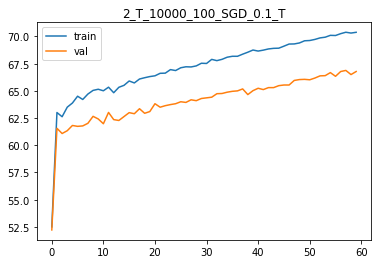

After training for 10 epochs
Train Acc 70.42
Val Acc 66.78
Test Acc 69.428
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.3
Epoch: [1/10], Step: [201/625], Validation Acc: 80.8
Epoch: [1/10], Step: [301/625], Validation Acc: 80.2
Epoch: [1/10], Step: [401/625], Validation Acc: 80.98
Epoch: [1/10], Step: [501/625], Validation Acc: 81.9
Epoch: [1/10], Step: [601/625], Validation Acc: 78.34
Epoch: [2/10], Step: [101/625], Validation Acc: 79.94
Epoch: [2/10], Step: [201/625], Validation Acc: 79.74
Epoch: [2/10], Step: [301/625], Validation Acc: 79.94
Epoch: [2/10], Step: [401/625], Validation Acc: 78.9
Epoch: [2/10], Step: [501/625], Validation Acc: 79.68
Epoch: [2/10], Step: [601/625], Validation Acc: 80.84
Epoch: [3/10], Step: [101/625], Validation Acc: 78.14
Epoch: [3/10], Step: [201/625], Validation Acc: 80.78
Epoch: [3/10], Step: [301/625], Validation Acc:

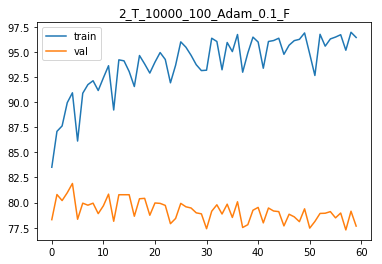

After training for 10 epochs
Train Acc 96.77
Val Acc 79.02
Test Acc 80.408
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 54.16
Epoch: [1/10], Step: [201/625], Validation Acc: 57.76
Epoch: [1/10], Step: [301/625], Validation Acc: 59.38
Epoch: [1/10], Step: [401/625], Validation Acc: 61.3
Epoch: [1/10], Step: [501/625], Validation Acc: 60.38
Epoch: [1/10], Step: [601/625], Validation Acc: 61.46
Epoch: [2/10], Step: [101/625], Validation Acc: 62.78
Epoch: [2/10], Step: [201/625], Validation Acc: 62.86
Epoch: [2/10], Step: [301/625], Validation Acc: 63.22
Epoch: [2/10], Step: [401/625], Validation Acc: 62.9
Epoch: [2/10], Step: [501/625], Validation Acc: 62.84
Epoch: [2/10], Step: [601/625], Validation Acc: 63.68
Epoch: [3/10], Step: [101/625], Validation Acc: 63.8
Epoch: [3/10], Step: [201/625], Validation Acc: 63.62
Epoch: [3/10], Step: [301/625], Validation Acc

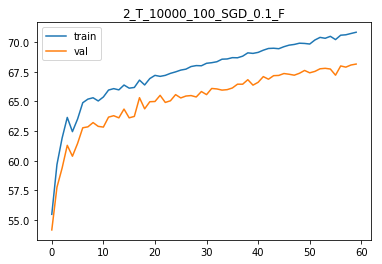

After training for 10 epochs
Train Acc 70.9
Val Acc 67.98
Test Acc 69.768
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 76.82
Epoch: [1/10], Step: [201/625], Validation Acc: 80.78
Epoch: [1/10], Step: [301/625], Validation Acc: 82.1
Epoch: [1/10], Step: [401/625], Validation Acc: 82.68
Epoch: [1/10], Step: [501/625], Validation Acc: 80.56
Epoch: [1/10], Step: [601/625], Validation Acc: 82.84
Epoch: [2/10], Step: [101/625], Validation Acc: 83.62
Epoch: [2/10], Step: [201/625], Validation Acc: 82.76
Epoch: [2/10], Step: [301/625], Validation Acc: 82.1
Epoch: [2/10], Step: [401/625], Validation Acc: 82.32
Epoch: [2/10], Step: [501/625], Validation Acc: 82.88
Epoch: [2/10], Step: [601/625], Validation Acc: 82.0
Epoch: [3/10], Step: [101/625], Validation Acc: 82.84
Epoch: [3/10], Step: [201/625], Validation Acc: 82.14
Epoch: [3/10], Step: [301/625], Validation Ac

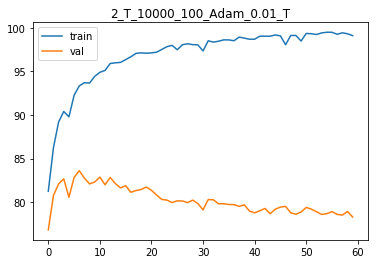

After training for 10 epochs
Train Acc 99.31
Val Acc 79.0
Test Acc 80.676
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 49.08
Epoch: [1/10], Step: [201/625], Validation Acc: 50.34
Epoch: [1/10], Step: [301/625], Validation Acc: 51.72
Epoch: [1/10], Step: [401/625], Validation Acc: 53.3
Epoch: [1/10], Step: [501/625], Validation Acc: 53.56
Epoch: [1/10], Step: [601/625], Validation Acc: 54.0
Epoch: [2/10], Step: [101/625], Validation Acc: 55.74
Epoch: [2/10], Step: [201/625], Validation Acc: 56.18
Epoch: [2/10], Step: [301/625], Validation Acc: 56.66
Epoch: [2/10], Step: [401/625], Validation Acc: 57.1
Epoch: [2/10], Step: [501/625], Validation Acc: 57.04
Epoch: [2/10], Step: [601/625], Validation Acc: 57.44
Epoch: [3/10], Step: [101/625], Validation Acc: 57.82
Epoch: [3/10], Step: [201/625], Validation Acc: 58.56
Epoch: [3/10], Step: [301/625], Validation Acc

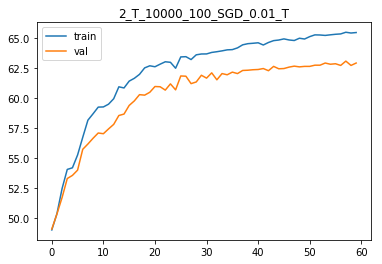

After training for 10 epochs
Train Acc 65.49
Val Acc 62.9
Test Acc 64.956
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.6
Epoch: [1/10], Step: [201/625], Validation Acc: 81.72
Epoch: [1/10], Step: [301/625], Validation Acc: 82.52
Epoch: [1/10], Step: [401/625], Validation Acc: 81.98
Epoch: [1/10], Step: [501/625], Validation Acc: 82.18
Epoch: [1/10], Step: [601/625], Validation Acc: 82.7
Epoch: [2/10], Step: [101/625], Validation Acc: 83.66
Epoch: [2/10], Step: [201/625], Validation Acc: 82.32
Epoch: [2/10], Step: [301/625], Validation Acc: 82.24
Epoch: [2/10], Step: [401/625], Validation Acc: 82.66
Epoch: [2/10], Step: [501/625], Validation Acc: 81.88
Epoch: [2/10], Step: [601/625], Validation Acc: 81.96
Epoch: [3/10], Step: [101/625], Validation Acc: 82.22
Epoch: [3/10], Step: [201/625], Validation Acc: 82.44
Epoch: [3/10], Step: [301/625], Validation A

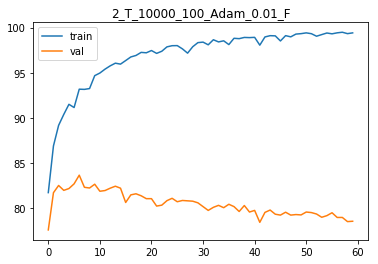

After training for 10 epochs
Train Acc 99.445
Val Acc 78.66
Test Acc 80.204
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 52.14
Epoch: [1/10], Step: [201/625], Validation Acc: 53.82
Epoch: [1/10], Step: [301/625], Validation Acc: 56.46
Epoch: [1/10], Step: [401/625], Validation Acc: 57.38
Epoch: [1/10], Step: [501/625], Validation Acc: 57.48
Epoch: [1/10], Step: [601/625], Validation Acc: 57.2
Epoch: [2/10], Step: [101/625], Validation Acc: 57.96
Epoch: [2/10], Step: [201/625], Validation Acc: 59.42
Epoch: [2/10], Step: [301/625], Validation Acc: 59.46
Epoch: [2/10], Step: [401/625], Validation Acc: 59.5
Epoch: [2/10], Step: [501/625], Validation Acc: 59.48
Epoch: [2/10], Step: [601/625], Validation Acc: 59.5
Epoch: [3/10], Step: [101/625], Validation Acc: 59.62
Epoch: [3/10], Step: [201/625], Validation Acc: 59.76
Epoch: [3/10], Step: [301/625], Validation A

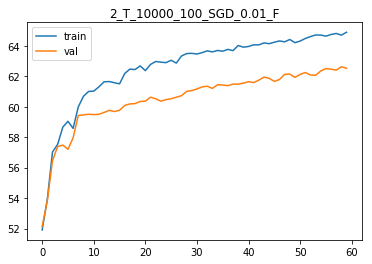

After training for 10 epochs
Train Acc 64.855
Val Acc 62.6
Test Acc 63.96
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 58.88
Epoch: [1/10], Step: [201/625], Validation Acc: 64.54
Epoch: [1/10], Step: [301/625], Validation Acc: 68.28
Epoch: [1/10], Step: [401/625], Validation Acc: 71.4
Epoch: [1/10], Step: [501/625], Validation Acc: 73.32
Epoch: [1/10], Step: [601/625], Validation Acc: 76.46
Epoch: [2/10], Step: [101/625], Validation Acc: 78.46
Epoch: [2/10], Step: [201/625], Validation Acc: 79.14
Epoch: [2/10], Step: [301/625], Validation Acc: 79.3
Epoch: [2/10], Step: [401/625], Validation Acc: 80.32
Epoch: [2/10], Step: [501/625], Validation Acc: 80.84
Epoch: [2/10], Step: [601/625], Validation Acc: 81.34
Epoch: [3/10], Step: [101/625], Validation Acc: 81.72
Epoch: [3/10], Step: [201/625], Validation Acc: 81.84
Epoch: [3/10], Step: [301/625], Validation 

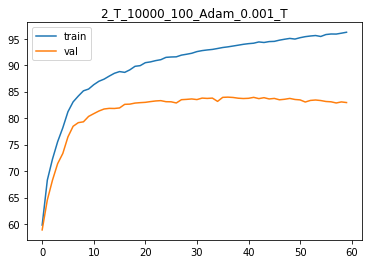

After training for 10 epochs
Train Acc 96.03
Val Acc 82.64
Test Acc 84.244
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 53.26
Epoch: [1/10], Step: [201/625], Validation Acc: 53.46
Epoch: [1/10], Step: [301/625], Validation Acc: 53.3
Epoch: [1/10], Step: [401/625], Validation Acc: 53.36
Epoch: [1/10], Step: [501/625], Validation Acc: 53.58
Epoch: [1/10], Step: [601/625], Validation Acc: 53.94
Epoch: [2/10], Step: [101/625], Validation Acc: 54.18
Epoch: [2/10], Step: [201/625], Validation Acc: 54.68
Epoch: [2/10], Step: [301/625], Validation Acc: 54.58
Epoch: [2/10], Step: [401/625], Validation Acc: 54.64
Epoch: [2/10], Step: [501/625], Validation Acc: 55.12
Epoch: [2/10], Step: [601/625], Validation Acc: 55.22
Epoch: [3/10], Step: [101/625], Validation Acc: 55.34
Epoch: [3/10], Step: [201/625], Validation Acc: 55.3
Epoch: [3/10], Step: [301/625], Validation 

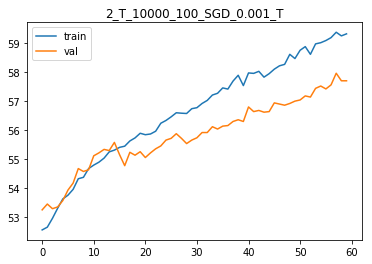

After training for 10 epochs
Train Acc 59.32
Val Acc 57.8
Test Acc 59.156
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 62.82
Epoch: [1/10], Step: [201/625], Validation Acc: 66.58
Epoch: [1/10], Step: [301/625], Validation Acc: 70.26
Epoch: [1/10], Step: [401/625], Validation Acc: 72.48
Epoch: [1/10], Step: [501/625], Validation Acc: 75.46
Epoch: [1/10], Step: [601/625], Validation Acc: 76.84
Epoch: [2/10], Step: [101/625], Validation Acc: 78.7
Epoch: [2/10], Step: [201/625], Validation Acc: 79.22
Epoch: [2/10], Step: [301/625], Validation Acc: 79.04
Epoch: [2/10], Step: [401/625], Validation Acc: 79.98
Epoch: [2/10], Step: [501/625], Validation Acc: 80.4
Epoch: [2/10], Step: [601/625], Validation Acc: 81.16
Epoch: [3/10], Step: [101/625], Validation Acc: 81.34
Epoch: [3/10], Step: [201/625], Validation Acc: 82.12
Epoch: [3/10], Step: [301/625], Validation 

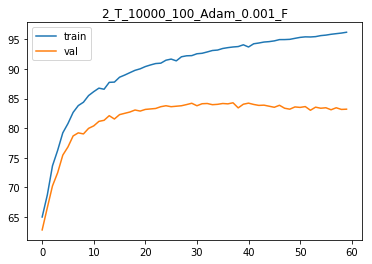

After training for 10 epochs
Train Acc 96.235
Val Acc 83.32
Test Acc 84.72
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 48.62
Epoch: [1/10], Step: [201/625], Validation Acc: 48.94
Epoch: [1/10], Step: [301/625], Validation Acc: 48.54
Epoch: [1/10], Step: [401/625], Validation Acc: 48.66
Epoch: [1/10], Step: [501/625], Validation Acc: 48.38
Epoch: [1/10], Step: [601/625], Validation Acc: 48.48
Epoch: [2/10], Step: [101/625], Validation Acc: 47.72
Epoch: [2/10], Step: [201/625], Validation Acc: 47.84
Epoch: [2/10], Step: [301/625], Validation Acc: 47.8
Epoch: [2/10], Step: [401/625], Validation Acc: 47.74
Epoch: [2/10], Step: [501/625], Validation Acc: 47.86
Epoch: [2/10], Step: [601/625], Validation Acc: 47.96
Epoch: [3/10], Step: [101/625], Validation Acc: 48.2
Epoch: [3/10], Step: [201/625], Validation Acc: 48.36
Epoch: [3/10], Step: [301/625], Validation 

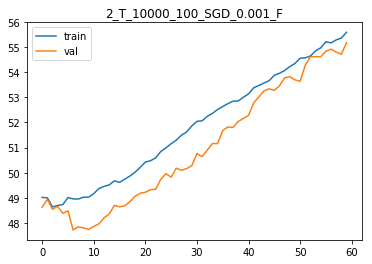

After training for 10 epochs
Train Acc 55.615
Val Acc 55.24
Test Acc 54.46
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.08
Epoch: [1/10], Step: [201/625], Validation Acc: 79.88
Epoch: [1/10], Step: [301/625], Validation Acc: 78.02
Epoch: [1/10], Step: [401/625], Validation Acc: 79.68
Epoch: [1/10], Step: [501/625], Validation Acc: 78.96
Epoch: [1/10], Step: [601/625], Validation Acc: 79.72
Epoch: [2/10], Step: [101/625], Validation Acc: 80.6
Epoch: [2/10], Step: [201/625], Validation Acc: 78.98
Epoch: [2/10], Step: [301/625], Validation Acc: 76.02
Epoch: [2/10], Step: [401/625], Validation Acc: 79.14
Epoch: [2/10], Step: [501/625], Validation Acc: 78.04
Epoch: [2/10], Step: [601/625], Validation Acc: 80.96
Epoch: [3/10], Step: [101/625], Validation Acc: 79.68
Epoch: [3/10], Step: [201/625], Validation Acc: 80.18
Epoch: [3/10], Step: [301/625], Validation 

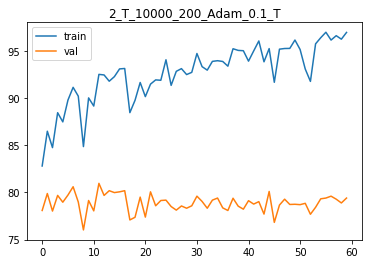

After training for 10 epochs
Train Acc 96.975
Val Acc 79.9
Test Acc 80.944
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 57.72
Epoch: [1/10], Step: [201/625], Validation Acc: 58.68
Epoch: [1/10], Step: [301/625], Validation Acc: 63.9
Epoch: [1/10], Step: [401/625], Validation Acc: 60.7
Epoch: [1/10], Step: [501/625], Validation Acc: 64.32
Epoch: [1/10], Step: [601/625], Validation Acc: 64.7
Epoch: [2/10], Step: [101/625], Validation Acc: 65.1
Epoch: [2/10], Step: [201/625], Validation Acc: 65.44
Epoch: [2/10], Step: [301/625], Validation Acc: 65.6
Epoch: [2/10], Step: [401/625], Validation Acc: 66.22
Epoch: [2/10], Step: [501/625], Validation Acc: 66.36
Epoch: [2/10], Step: [601/625], Validation Acc: 66.46
Epoch: [3/10], Step: [101/625], Validation Acc: 66.74
Epoch: [3/10], Step: [201/625], Validation Acc: 66.52
Epoch: [3/10], Step: [301/625], Validation Acc: 

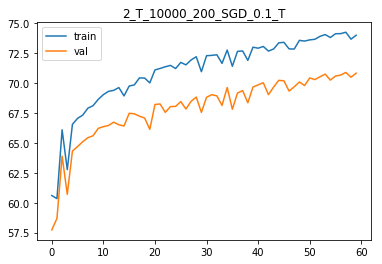

After training for 10 epochs
Train Acc 74.045
Val Acc 70.9
Test Acc 72.784
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.04
Epoch: [1/10], Step: [201/625], Validation Acc: 74.06
Epoch: [1/10], Step: [301/625], Validation Acc: 80.8
Epoch: [1/10], Step: [401/625], Validation Acc: 77.58
Epoch: [1/10], Step: [501/625], Validation Acc: 79.38
Epoch: [1/10], Step: [601/625], Validation Acc: 80.88
Epoch: [2/10], Step: [101/625], Validation Acc: 76.06
Epoch: [2/10], Step: [201/625], Validation Acc: 80.3
Epoch: [2/10], Step: [301/625], Validation Acc: 75.56
Epoch: [2/10], Step: [401/625], Validation Acc: 77.84
Epoch: [2/10], Step: [501/625], Validation Acc: 80.32
Epoch: [2/10], Step: [601/625], Validation Acc: 77.56
Epoch: [3/10], Step: [101/625], Validation Acc: 79.86
Epoch: [3/10], Step: [201/625], Validation Acc: 80.14
Epoch: [3/10], Step: [301/625], Validation A

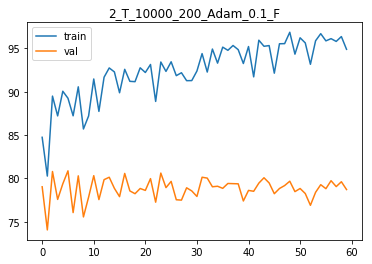

After training for 10 epochs
Train Acc 94.43
Val Acc 78.2
Test Acc 79.8
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 62.44
Epoch: [1/10], Step: [201/625], Validation Acc: 62.54
Epoch: [1/10], Step: [301/625], Validation Acc: 63.7
Epoch: [1/10], Step: [401/625], Validation Acc: 62.38
Epoch: [1/10], Step: [501/625], Validation Acc: 64.88
Epoch: [1/10], Step: [601/625], Validation Acc: 64.86
Epoch: [2/10], Step: [101/625], Validation Acc: 65.82
Epoch: [2/10], Step: [201/625], Validation Acc: 65.78
Epoch: [2/10], Step: [301/625], Validation Acc: 66.54
Epoch: [2/10], Step: [401/625], Validation Acc: 65.86
Epoch: [2/10], Step: [501/625], Validation Acc: 66.32
Epoch: [2/10], Step: [601/625], Validation Acc: 67.34
Epoch: [3/10], Step: [101/625], Validation Acc: 67.26
Epoch: [3/10], Step: [201/625], Validation Acc: 67.2
Epoch: [3/10], Step: [301/625], Validation Acc: 

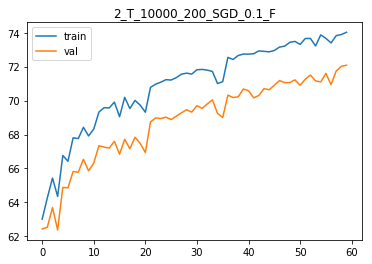

After training for 10 epochs
Train Acc 74.155
Val Acc 71.98
Test Acc 73.5
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.56
Epoch: [1/10], Step: [201/625], Validation Acc: 81.38
Epoch: [1/10], Step: [301/625], Validation Acc: 82.22
Epoch: [1/10], Step: [401/625], Validation Acc: 81.94
Epoch: [1/10], Step: [501/625], Validation Acc: 83.28
Epoch: [1/10], Step: [601/625], Validation Acc: 83.16
Epoch: [2/10], Step: [101/625], Validation Acc: 81.3
Epoch: [2/10], Step: [201/625], Validation Acc: 82.42
Epoch: [2/10], Step: [301/625], Validation Acc: 82.78
Epoch: [2/10], Step: [401/625], Validation Acc: 80.54
Epoch: [2/10], Step: [501/625], Validation Acc: 82.34
Epoch: [2/10], Step: [601/625], Validation Acc: 82.02
Epoch: [3/10], Step: [101/625], Validation Acc: 82.16
Epoch: [3/10], Step: [201/625], Validation Acc: 81.64
Epoch: [3/10], Step: [301/625], Validation 

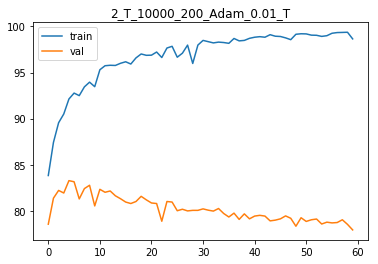

After training for 10 epochs
Train Acc 99.26
Val Acc 78.82
Test Acc 80.228
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 52.66
Epoch: [1/10], Step: [201/625], Validation Acc: 54.32
Epoch: [1/10], Step: [301/625], Validation Acc: 54.9
Epoch: [1/10], Step: [401/625], Validation Acc: 58.28
Epoch: [1/10], Step: [501/625], Validation Acc: 57.22
Epoch: [1/10], Step: [601/625], Validation Acc: 58.92
Epoch: [2/10], Step: [101/625], Validation Acc: 60.5
Epoch: [2/10], Step: [201/625], Validation Acc: 61.0
Epoch: [2/10], Step: [301/625], Validation Acc: 58.96
Epoch: [2/10], Step: [401/625], Validation Acc: 61.34
Epoch: [2/10], Step: [501/625], Validation Acc: 59.76
Epoch: [2/10], Step: [601/625], Validation Acc: 62.08
Epoch: [3/10], Step: [101/625], Validation Acc: 61.92
Epoch: [3/10], Step: [201/625], Validation Acc: 62.28
Epoch: [3/10], Step: [301/625], Validation Ac

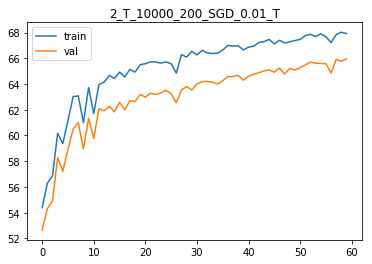

After training for 10 epochs
Train Acc 67.72
Val Acc 65.6
Test Acc 66.768
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.84
Epoch: [1/10], Step: [201/625], Validation Acc: 81.42
Epoch: [1/10], Step: [301/625], Validation Acc: 82.3
Epoch: [1/10], Step: [401/625], Validation Acc: 83.22
Epoch: [1/10], Step: [501/625], Validation Acc: 83.16
Epoch: [1/10], Step: [601/625], Validation Acc: 83.46
Epoch: [2/10], Step: [101/625], Validation Acc: 82.1
Epoch: [2/10], Step: [201/625], Validation Acc: 82.94
Epoch: [2/10], Step: [301/625], Validation Acc: 81.88
Epoch: [2/10], Step: [401/625], Validation Acc: 81.2
Epoch: [2/10], Step: [501/625], Validation Acc: 82.36
Epoch: [2/10], Step: [601/625], Validation Acc: 82.06
Epoch: [3/10], Step: [101/625], Validation Acc: 82.2
Epoch: [3/10], Step: [201/625], Validation Acc: 81.6
Epoch: [3/10], Step: [301/625], Validation Acc:

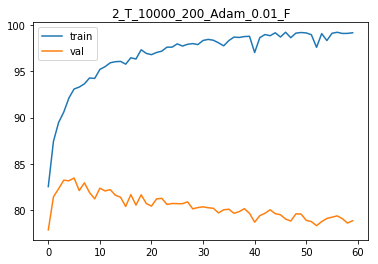

After training for 10 epochs
Train Acc 99.315
Val Acc 79.06
Test Acc 80.172
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.18
Epoch: [1/10], Step: [201/625], Validation Acc: 53.06
Epoch: [1/10], Step: [301/625], Validation Acc: 54.6
Epoch: [1/10], Step: [401/625], Validation Acc: 56.56
Epoch: [1/10], Step: [501/625], Validation Acc: 57.56
Epoch: [1/10], Step: [601/625], Validation Acc: 58.92
Epoch: [2/10], Step: [101/625], Validation Acc: 59.28
Epoch: [2/10], Step: [201/625], Validation Acc: 58.32
Epoch: [2/10], Step: [301/625], Validation Acc: 60.92
Epoch: [2/10], Step: [401/625], Validation Acc: 61.2
Epoch: [2/10], Step: [501/625], Validation Acc: 61.28
Epoch: [2/10], Step: [601/625], Validation Acc: 62.04
Epoch: [3/10], Step: [101/625], Validation Acc: 62.28
Epoch: [3/10], Step: [201/625], Validation Acc: 61.82
Epoch: [3/10], Step: [301/625], Validation 

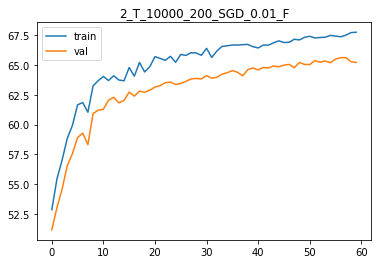

After training for 10 epochs
Train Acc 67.755
Val Acc 65.32
Test Acc 66.948
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 65.48
Epoch: [1/10], Step: [201/625], Validation Acc: 68.58
Epoch: [1/10], Step: [301/625], Validation Acc: 71.52
Epoch: [1/10], Step: [401/625], Validation Acc: 75.18
Epoch: [1/10], Step: [501/625], Validation Acc: 77.24
Epoch: [1/10], Step: [601/625], Validation Acc: 78.42
Epoch: [2/10], Step: [101/625], Validation Acc: 79.68
Epoch: [2/10], Step: [201/625], Validation Acc: 80.46
Epoch: [2/10], Step: [301/625], Validation Acc: 81.28
Epoch: [2/10], Step: [401/625], Validation Acc: 81.62
Epoch: [2/10], Step: [501/625], Validation Acc: 82.0
Epoch: [2/10], Step: [601/625], Validation Acc: 82.68
Epoch: [3/10], Step: [101/625], Validation Acc: 82.82
Epoch: [3/10], Step: [201/625], Validation Acc: 83.0
Epoch: [3/10], Step: [301/625], Validatio

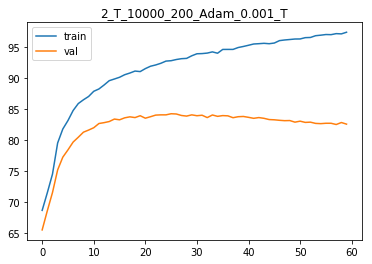

After training for 10 epochs
Train Acc 97.38
Val Acc 82.64
Test Acc 84.256
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.66
Epoch: [1/10], Step: [201/625], Validation Acc: 51.0
Epoch: [1/10], Step: [301/625], Validation Acc: 51.62
Epoch: [1/10], Step: [401/625], Validation Acc: 52.18
Epoch: [1/10], Step: [501/625], Validation Acc: 52.46
Epoch: [1/10], Step: [601/625], Validation Acc: 52.32
Epoch: [2/10], Step: [101/625], Validation Acc: 53.32
Epoch: [2/10], Step: [201/625], Validation Acc: 53.88
Epoch: [2/10], Step: [301/625], Validation Acc: 54.3
Epoch: [2/10], Step: [401/625], Validation Acc: 54.42
Epoch: [2/10], Step: [501/625], Validation Acc: 54.6
Epoch: [2/10], Step: [601/625], Validation Acc: 55.06
Epoch: [3/10], Step: [101/625], Validation Acc: 55.2
Epoch: [3/10], Step: [201/625], Validation Acc: 55.38
Epoch: [3/10], Step: [301/625], Validation Ac

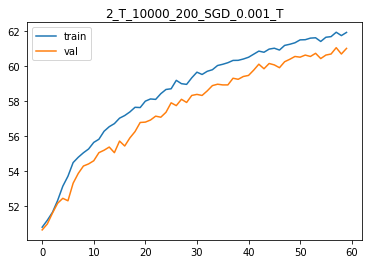

After training for 10 epochs
Train Acc 61.845
Val Acc 60.82
Test Acc 61.36
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.48
Epoch: [1/10], Step: [201/625], Validation Acc: 65.0
Epoch: [1/10], Step: [301/625], Validation Acc: 71.56
Epoch: [1/10], Step: [401/625], Validation Acc: 73.52
Epoch: [1/10], Step: [501/625], Validation Acc: 75.64
Epoch: [1/10], Step: [601/625], Validation Acc: 77.38
Epoch: [2/10], Step: [101/625], Validation Acc: 78.88
Epoch: [2/10], Step: [201/625], Validation Acc: 79.76
Epoch: [2/10], Step: [301/625], Validation Acc: 80.48
Epoch: [2/10], Step: [401/625], Validation Acc: 81.06
Epoch: [2/10], Step: [501/625], Validation Acc: 81.52
Epoch: [2/10], Step: [601/625], Validation Acc: 81.96
Epoch: [3/10], Step: [101/625], Validation Acc: 82.06
Epoch: [3/10], Step: [201/625], Validation Acc: 82.68
Epoch: [3/10], Step: [301/625], Validatio

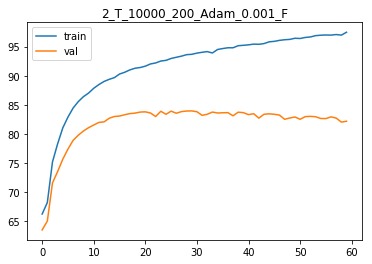

After training for 10 epochs
Train Acc 97.39
Val Acc 82.88
Test Acc 84.212
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.74
Epoch: [1/10], Step: [201/625], Validation Acc: 51.16
Epoch: [1/10], Step: [301/625], Validation Acc: 51.4
Epoch: [1/10], Step: [401/625], Validation Acc: 51.52
Epoch: [1/10], Step: [501/625], Validation Acc: 52.2
Epoch: [1/10], Step: [601/625], Validation Acc: 52.54
Epoch: [2/10], Step: [101/625], Validation Acc: 53.0
Epoch: [2/10], Step: [201/625], Validation Acc: 52.86
Epoch: [2/10], Step: [301/625], Validation Acc: 52.96
Epoch: [2/10], Step: [401/625], Validation Acc: 52.9
Epoch: [2/10], Step: [501/625], Validation Acc: 53.1
Epoch: [2/10], Step: [601/625], Validation Acc: 53.34
Epoch: [3/10], Step: [101/625], Validation Acc: 53.42
Epoch: [3/10], Step: [201/625], Validation Acc: 53.68
Epoch: [3/10], Step: [301/625], Validation Acc

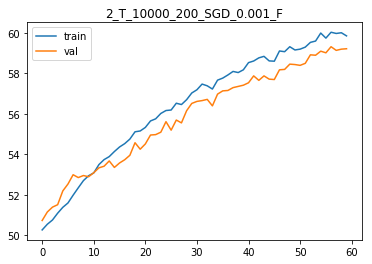

After training for 10 epochs
Train Acc 59.855
Val Acc 59.14
Test Acc 59.776
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 72.96
Epoch: [1/10], Step: [201/625], Validation Acc: 76.82
Epoch: [1/10], Step: [301/625], Validation Acc: 68.86
Epoch: [1/10], Step: [401/625], Validation Acc: 74.34
Epoch: [1/10], Step: [501/625], Validation Acc: 75.88
Epoch: [1/10], Step: [601/625], Validation Acc: 77.6
Epoch: [2/10], Step: [101/625], Validation Acc: 78.12
Epoch: [2/10], Step: [201/625], Validation Acc: 74.6
Epoch: [2/10], Step: [301/625], Validation Acc: 78.88
Epoch: [2/10], Step: [401/625], Validation Acc: 76.72
Epoch: [2/10], Step: [501/625], Validation Acc: 78.08
Epoch: [2/10], Step: [601/625], Validation Acc: 74.12
Epoch: [3/10], Step: [101/625], Validation Acc: 79.58
Epoch: [3/10], Step: [201/625], Validation Acc: 78.84
Epoch: [3/10], Step: [301/625], Validation 

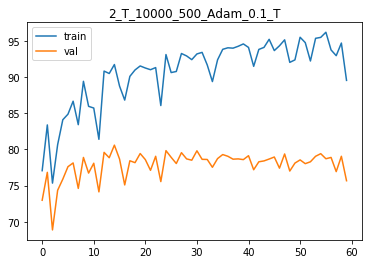

After training for 10 epochs
Train Acc 95.87
Val Acc 79.08
Test Acc 80.812
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 61.3
Epoch: [1/10], Step: [201/625], Validation Acc: 64.62
Epoch: [1/10], Step: [301/625], Validation Acc: 64.32
Epoch: [1/10], Step: [401/625], Validation Acc: 66.46
Epoch: [1/10], Step: [501/625], Validation Acc: 68.46
Epoch: [1/10], Step: [601/625], Validation Acc: 69.48
Epoch: [2/10], Step: [101/625], Validation Acc: 69.16
Epoch: [2/10], Step: [201/625], Validation Acc: 69.96
Epoch: [2/10], Step: [301/625], Validation Acc: 70.08
Epoch: [2/10], Step: [401/625], Validation Acc: 69.82
Epoch: [2/10], Step: [501/625], Validation Acc: 70.54
Epoch: [2/10], Step: [601/625], Validation Acc: 71.22
Epoch: [3/10], Step: [101/625], Validation Acc: 71.4
Epoch: [3/10], Step: [201/625], Validation Acc: 71.84
Epoch: [3/10], Step: [301/625], Validation Ac

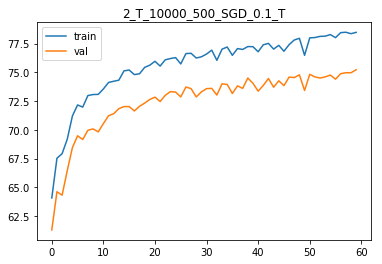

After training for 10 epochs
Train Acc 77.87
Val Acc 74.7
Test Acc 76.736
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 66.64
Epoch: [1/10], Step: [201/625], Validation Acc: 73.9
Epoch: [1/10], Step: [301/625], Validation Acc: 79.16
Epoch: [1/10], Step: [401/625], Validation Acc: 78.36
Epoch: [1/10], Step: [501/625], Validation Acc: 78.68
Epoch: [1/10], Step: [601/625], Validation Acc: 78.38
Epoch: [2/10], Step: [101/625], Validation Acc: 78.58
Epoch: [2/10], Step: [201/625], Validation Acc: 77.74
Epoch: [2/10], Step: [301/625], Validation Acc: 77.18
Epoch: [2/10], Step: [401/625], Validation Acc: 79.98
Epoch: [2/10], Step: [501/625], Validation Acc: 77.92
Epoch: [2/10], Step: [601/625], Validation Acc: 78.06
Epoch: [3/10], Step: [101/625], Validation Acc: 79.46
Epoch: [3/10], Step: [201/625], Validation Acc: 79.06
Epoch: [3/10], Step: [301/625], Validation A

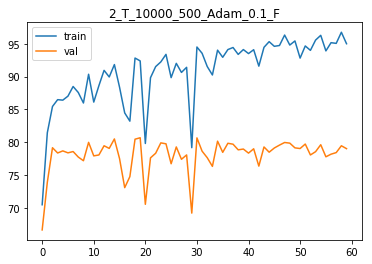

After training for 10 epochs
Train Acc 95.985
Val Acc 79.6
Test Acc 80.904
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 63.96
Epoch: [1/10], Step: [201/625], Validation Acc: 66.16
Epoch: [1/10], Step: [301/625], Validation Acc: 67.5
Epoch: [1/10], Step: [401/625], Validation Acc: 66.68
Epoch: [1/10], Step: [501/625], Validation Acc: 68.3
Epoch: [1/10], Step: [601/625], Validation Acc: 68.36
Epoch: [2/10], Step: [101/625], Validation Acc: 69.46
Epoch: [2/10], Step: [201/625], Validation Acc: 69.34
Epoch: [2/10], Step: [301/625], Validation Acc: 70.44
Epoch: [2/10], Step: [401/625], Validation Acc: 69.9
Epoch: [2/10], Step: [501/625], Validation Acc: 70.48
Epoch: [2/10], Step: [601/625], Validation Acc: 70.88
Epoch: [3/10], Step: [101/625], Validation Acc: 71.36
Epoch: [3/10], Step: [201/625], Validation Acc: 71.44
Epoch: [3/10], Step: [301/625], Validation Acc

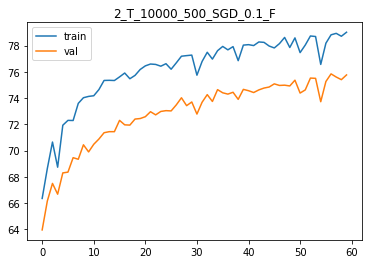

After training for 10 epochs
Train Acc 79.17
Val Acc 76.04
Test Acc 76.744
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.42
Epoch: [1/10], Step: [201/625], Validation Acc: 81.56
Epoch: [1/10], Step: [301/625], Validation Acc: 82.14
Epoch: [1/10], Step: [401/625], Validation Acc: 82.58
Epoch: [1/10], Step: [501/625], Validation Acc: 83.18
Epoch: [1/10], Step: [601/625], Validation Acc: 82.82
Epoch: [2/10], Step: [101/625], Validation Acc: 82.54
Epoch: [2/10], Step: [201/625], Validation Acc: 82.52
Epoch: [2/10], Step: [301/625], Validation Acc: 82.62
Epoch: [2/10], Step: [401/625], Validation Acc: 81.86
Epoch: [2/10], Step: [501/625], Validation Acc: 81.8
Epoch: [2/10], Step: [601/625], Validation Acc: 80.44
Epoch: [3/10], Step: [101/625], Validation Acc: 82.22
Epoch: [3/10], Step: [201/625], Validation Acc: 81.1
Epoch: [3/10], Step: [301/625], Validation 

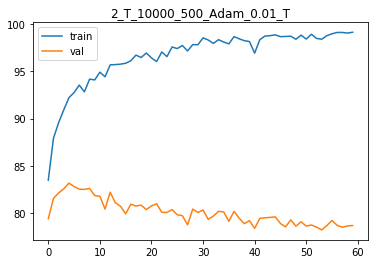

After training for 10 epochs
Train Acc 99.0
Val Acc 78.3
Test Acc 80.112
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 53.78
Epoch: [1/10], Step: [201/625], Validation Acc: 55.38
Epoch: [1/10], Step: [301/625], Validation Acc: 59.22
Epoch: [1/10], Step: [401/625], Validation Acc: 60.66
Epoch: [1/10], Step: [501/625], Validation Acc: 61.92
Epoch: [1/10], Step: [601/625], Validation Acc: 61.36
Epoch: [2/10], Step: [101/625], Validation Acc: 62.0
Epoch: [2/10], Step: [201/625], Validation Acc: 62.88
Epoch: [2/10], Step: [301/625], Validation Acc: 63.22
Epoch: [2/10], Step: [401/625], Validation Acc: 64.46
Epoch: [2/10], Step: [501/625], Validation Acc: 64.42
Epoch: [2/10], Step: [601/625], Validation Acc: 62.76
Epoch: [3/10], Step: [101/625], Validation Acc: 65.26
Epoch: [3/10], Step: [201/625], Validation Acc: 64.76
Epoch: [3/10], Step: [301/625], Validation Ac

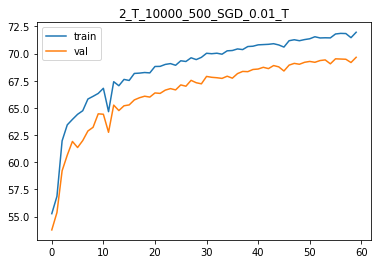

After training for 10 epochs
Train Acc 71.92
Val Acc 69.56
Test Acc 71.096
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 79.78
Epoch: [1/10], Step: [201/625], Validation Acc: 81.28
Epoch: [1/10], Step: [301/625], Validation Acc: 80.32
Epoch: [1/10], Step: [401/625], Validation Acc: 82.76
Epoch: [1/10], Step: [501/625], Validation Acc: 82.82
Epoch: [1/10], Step: [601/625], Validation Acc: 83.1
Epoch: [2/10], Step: [101/625], Validation Acc: 82.14
Epoch: [2/10], Step: [201/625], Validation Acc: 81.94
Epoch: [2/10], Step: [301/625], Validation Acc: 81.72
Epoch: [2/10], Step: [401/625], Validation Acc: 82.12
Epoch: [2/10], Step: [501/625], Validation Acc: 82.56
Epoch: [2/10], Step: [601/625], Validation Acc: 81.66
Epoch: [3/10], Step: [101/625], Validation Acc: 81.32
Epoch: [3/10], Step: [201/625], Validation Acc: 81.34
Epoch: [3/10], Step: [301/625], Validation

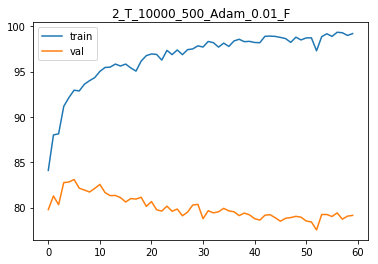

After training for 10 epochs
Train Acc 99.125
Val Acc 78.52
Test Acc 79.912
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 56.56
Epoch: [1/10], Step: [201/625], Validation Acc: 58.94
Epoch: [1/10], Step: [301/625], Validation Acc: 61.56
Epoch: [1/10], Step: [401/625], Validation Acc: 62.84
Epoch: [1/10], Step: [501/625], Validation Acc: 64.06
Epoch: [1/10], Step: [601/625], Validation Acc: 64.36
Epoch: [2/10], Step: [101/625], Validation Acc: 64.3
Epoch: [2/10], Step: [201/625], Validation Acc: 63.02
Epoch: [2/10], Step: [301/625], Validation Acc: 63.8
Epoch: [2/10], Step: [401/625], Validation Acc: 63.12
Epoch: [2/10], Step: [501/625], Validation Acc: 65.32
Epoch: [2/10], Step: [601/625], Validation Acc: 65.58
Epoch: [3/10], Step: [101/625], Validation Acc: 66.0
Epoch: [3/10], Step: [201/625], Validation Acc: 64.46
Epoch: [3/10], Step: [301/625], Validation A

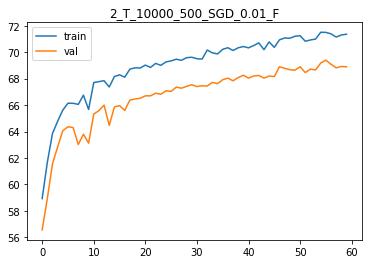

After training for 10 epochs
Train Acc 71.375
Val Acc 68.94
Test Acc 71.088
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 68.72
Epoch: [1/10], Step: [201/625], Validation Acc: 72.8
Epoch: [1/10], Step: [301/625], Validation Acc: 74.78
Epoch: [1/10], Step: [401/625], Validation Acc: 77.86
Epoch: [1/10], Step: [501/625], Validation Acc: 78.92
Epoch: [1/10], Step: [601/625], Validation Acc: 80.24
Epoch: [2/10], Step: [101/625], Validation Acc: 80.88
Epoch: [2/10], Step: [201/625], Validation Acc: 81.66
Epoch: [2/10], Step: [301/625], Validation Acc: 82.12
Epoch: [2/10], Step: [401/625], Validation Acc: 82.62
Epoch: [2/10], Step: [501/625], Validation Acc: 82.58
Epoch: [2/10], Step: [601/625], Validation Acc: 83.16
Epoch: [3/10], Step: [101/625], Validation Acc: 83.32
Epoch: [3/10], Step: [201/625], Validation Acc: 83.46
Epoch: [3/10], Step: [301/625], Validati

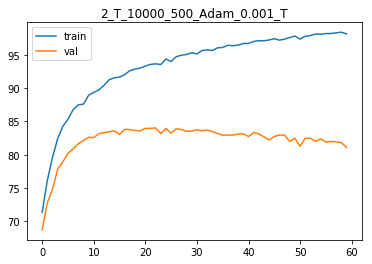

After training for 10 epochs
Train Acc 98.495
Val Acc 81.98
Test Acc 83.388
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.48
Epoch: [1/10], Step: [201/625], Validation Acc: 51.6
Epoch: [1/10], Step: [301/625], Validation Acc: 51.76
Epoch: [1/10], Step: [401/625], Validation Acc: 52.56
Epoch: [1/10], Step: [501/625], Validation Acc: 53.4
Epoch: [1/10], Step: [601/625], Validation Acc: 54.24
Epoch: [2/10], Step: [101/625], Validation Acc: 55.26
Epoch: [2/10], Step: [201/625], Validation Acc: 55.82
Epoch: [2/10], Step: [301/625], Validation Acc: 55.9
Epoch: [2/10], Step: [401/625], Validation Acc: 56.4
Epoch: [2/10], Step: [501/625], Validation Acc: 56.7
Epoch: [2/10], Step: [601/625], Validation Acc: 57.22
Epoch: [3/10], Step: [101/625], Validation Acc: 57.84
Epoch: [3/10], Step: [201/625], Validation Acc: 57.94
Epoch: [3/10], Step: [301/625], Validation Ac

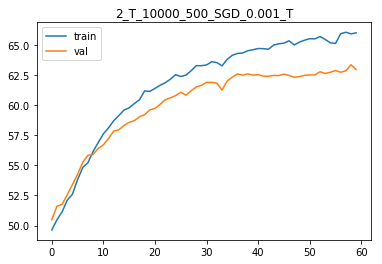

After training for 10 epochs
Train Acc 65.935
Val Acc 62.94
Test Acc 64.932
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 66.46
Epoch: [1/10], Step: [201/625], Validation Acc: 70.68
Epoch: [1/10], Step: [301/625], Validation Acc: 73.14
Epoch: [1/10], Step: [401/625], Validation Acc: 76.74
Epoch: [1/10], Step: [501/625], Validation Acc: 78.48
Epoch: [1/10], Step: [601/625], Validation Acc: 80.1
Epoch: [2/10], Step: [101/625], Validation Acc: 80.28
Epoch: [2/10], Step: [201/625], Validation Acc: 81.78
Epoch: [2/10], Step: [301/625], Validation Acc: 82.2
Epoch: [2/10], Step: [401/625], Validation Acc: 82.24
Epoch: [2/10], Step: [501/625], Validation Acc: 82.92
Epoch: [2/10], Step: [601/625], Validation Acc: 83.18
Epoch: [3/10], Step: [101/625], Validation Acc: 83.38
Epoch: [3/10], Step: [201/625], Validation Acc: 83.4
Epoch: [3/10], Step: [301/625], Validation

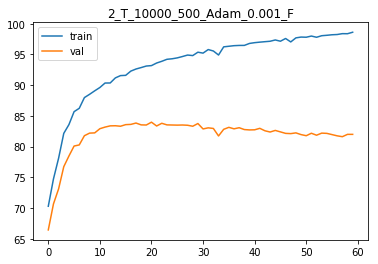

After training for 10 epochs
Train Acc 98.495
Val Acc 81.14
Test Acc 82.596
ngram:  2
use all_ngram? :  T
max_vocab_size:  10000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.8
Epoch: [1/10], Step: [201/625], Validation Acc: 52.7
Epoch: [1/10], Step: [301/625], Validation Acc: 54.34
Epoch: [1/10], Step: [401/625], Validation Acc: 54.1
Epoch: [1/10], Step: [501/625], Validation Acc: 55.28
Epoch: [1/10], Step: [601/625], Validation Acc: 55.42
Epoch: [2/10], Step: [101/625], Validation Acc: 55.96
Epoch: [2/10], Step: [201/625], Validation Acc: 56.32
Epoch: [2/10], Step: [301/625], Validation Acc: 56.54
Epoch: [2/10], Step: [401/625], Validation Acc: 56.92
Epoch: [2/10], Step: [501/625], Validation Acc: 57.04
Epoch: [2/10], Step: [601/625], Validation Acc: 57.38
Epoch: [3/10], Step: [101/625], Validation Acc: 57.98
Epoch: [3/10], Step: [201/625], Validation Acc: 58.2
Epoch: [3/10], Step: [301/625], Validation A

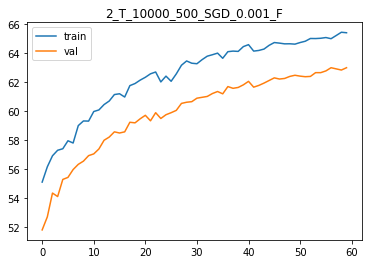

After training for 10 epochs
Train Acc 65.41
Val Acc 62.88
Test Acc 64.404
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 73.36
Epoch: [1/10], Step: [201/625], Validation Acc: 79.04
Epoch: [1/10], Step: [301/625], Validation Acc: 80.24
Epoch: [1/10], Step: [401/625], Validation Acc: 81.96
Epoch: [1/10], Step: [501/625], Validation Acc: 82.08
Epoch: [1/10], Step: [601/625], Validation Acc: 72.5
Epoch: [2/10], Step: [101/625], Validation Acc: 80.74
Epoch: [2/10], Step: [201/625], Validation Acc: 80.94
Epoch: [2/10], Step: [301/625], Validation Acc: 80.26
Epoch: [2/10], Step: [401/625], Validation Acc: 80.3
Epoch: [2/10], Step: [501/625], Validation Acc: 80.34
Epoch: [2/10], Step: [601/625], Validation Acc: 80.04
Epoch: [3/10], Step: [101/625], Validation Acc: 79.68
Epoch: [3/10], Step: [201/625], Validation Acc: 79.8
Epoch: [3/10], Step: [301/625], Validation Ac

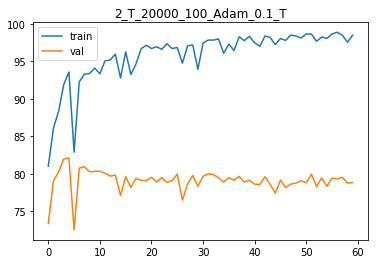

After training for 10 epochs
Train Acc 98.32
Val Acc 78.12
Test Acc 79.964
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 58.12
Epoch: [1/10], Step: [201/625], Validation Acc: 59.16
Epoch: [1/10], Step: [301/625], Validation Acc: 59.66
Epoch: [1/10], Step: [401/625], Validation Acc: 61.68
Epoch: [1/10], Step: [501/625], Validation Acc: 61.7
Epoch: [1/10], Step: [601/625], Validation Acc: 60.54
Epoch: [2/10], Step: [101/625], Validation Acc: 62.68
Epoch: [2/10], Step: [201/625], Validation Acc: 62.84
Epoch: [2/10], Step: [301/625], Validation Acc: 63.22
Epoch: [2/10], Step: [401/625], Validation Acc: 63.38
Epoch: [2/10], Step: [501/625], Validation Acc: 63.68
Epoch: [2/10], Step: [601/625], Validation Acc: 64.1
Epoch: [3/10], Step: [101/625], Validation Acc: 63.9
Epoch: [3/10], Step: [201/625], Validation Acc: 64.28
Epoch: [3/10], Step: [301/625], Validation Acc

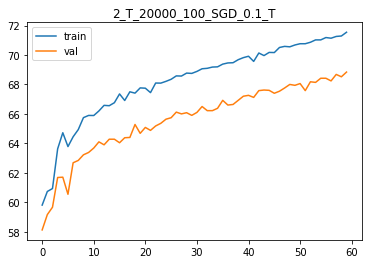

After training for 10 epochs
Train Acc 71.44
Val Acc 68.8
Test Acc 70.46
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 80.46
Epoch: [1/10], Step: [201/625], Validation Acc: 80.8
Epoch: [1/10], Step: [301/625], Validation Acc: 73.64
Epoch: [1/10], Step: [401/625], Validation Acc: 81.0
Epoch: [1/10], Step: [501/625], Validation Acc: 80.62
Epoch: [1/10], Step: [601/625], Validation Acc: 78.38
Epoch: [2/10], Step: [101/625], Validation Acc: 80.24
Epoch: [2/10], Step: [201/625], Validation Acc: 81.1
Epoch: [2/10], Step: [301/625], Validation Acc: 80.2
Epoch: [2/10], Step: [401/625], Validation Acc: 80.46
Epoch: [2/10], Step: [501/625], Validation Acc: 78.28
Epoch: [2/10], Step: [601/625], Validation Acc: 79.58
Epoch: [3/10], Step: [101/625], Validation Acc: 79.18
Epoch: [3/10], Step: [201/625], Validation Acc: 79.98
Epoch: [3/10], Step: [301/625], Validation Acc: 

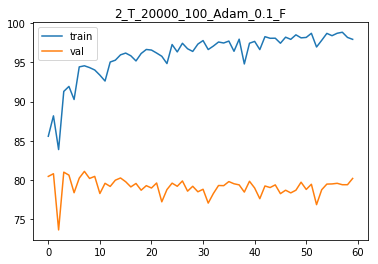

After training for 10 epochs
Train Acc 99.105
Val Acc 79.9
Test Acc 81.068
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 58.0
Epoch: [1/10], Step: [201/625], Validation Acc: 60.62
Epoch: [1/10], Step: [301/625], Validation Acc: 58.02
Epoch: [1/10], Step: [401/625], Validation Acc: 61.92
Epoch: [1/10], Step: [501/625], Validation Acc: 61.52
Epoch: [1/10], Step: [601/625], Validation Acc: 62.62
Epoch: [2/10], Step: [101/625], Validation Acc: 62.7
Epoch: [2/10], Step: [201/625], Validation Acc: 62.58
Epoch: [2/10], Step: [301/625], Validation Acc: 62.9
Epoch: [2/10], Step: [401/625], Validation Acc: 62.92
Epoch: [2/10], Step: [501/625], Validation Acc: 63.26
Epoch: [2/10], Step: [601/625], Validation Acc: 63.52
Epoch: [3/10], Step: [101/625], Validation Acc: 63.62
Epoch: [3/10], Step: [201/625], Validation Acc: 63.36
Epoch: [3/10], Step: [301/625], Validation Acc

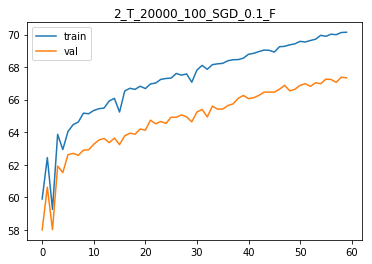

After training for 10 epochs
Train Acc 70.27
Val Acc 67.52
Test Acc 69.372
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.48
Epoch: [1/10], Step: [201/625], Validation Acc: 81.92
Epoch: [1/10], Step: [301/625], Validation Acc: 82.02
Epoch: [1/10], Step: [401/625], Validation Acc: 83.76
Epoch: [1/10], Step: [501/625], Validation Acc: 83.82
Epoch: [1/10], Step: [601/625], Validation Acc: 83.6
Epoch: [2/10], Step: [101/625], Validation Acc: 82.6
Epoch: [2/10], Step: [201/625], Validation Acc: 83.42
Epoch: [2/10], Step: [301/625], Validation Acc: 81.98
Epoch: [2/10], Step: [401/625], Validation Acc: 82.34
Epoch: [2/10], Step: [501/625], Validation Acc: 82.64
Epoch: [2/10], Step: [601/625], Validation Acc: 82.34
Epoch: [3/10], Step: [101/625], Validation Acc: 80.06
Epoch: [3/10], Step: [201/625], Validation Acc: 81.48
Epoch: [3/10], Step: [301/625], Validation 

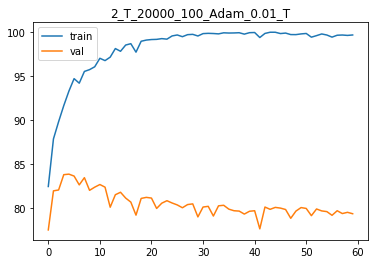

After training for 10 epochs
Train Acc 99.685
Val Acc 79.36
Test Acc 80.684
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.84
Epoch: [1/10], Step: [201/625], Validation Acc: 52.04
Epoch: [1/10], Step: [301/625], Validation Acc: 52.26
Epoch: [1/10], Step: [401/625], Validation Acc: 54.0
Epoch: [1/10], Step: [501/625], Validation Acc: 55.12
Epoch: [1/10], Step: [601/625], Validation Acc: 56.56
Epoch: [2/10], Step: [101/625], Validation Acc: 57.1
Epoch: [2/10], Step: [201/625], Validation Acc: 57.96
Epoch: [2/10], Step: [301/625], Validation Acc: 58.38
Epoch: [2/10], Step: [401/625], Validation Acc: 58.32
Epoch: [2/10], Step: [501/625], Validation Acc: 59.34
Epoch: [2/10], Step: [601/625], Validation Acc: 59.88
Epoch: [3/10], Step: [101/625], Validation Acc: 60.78
Epoch: [3/10], Step: [201/625], Validation Acc: 60.96
Epoch: [3/10], Step: [301/625], Validation 

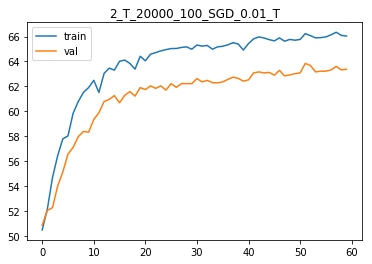

After training for 10 epochs
Train Acc 66.12
Val Acc 63.46
Test Acc 65.464
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 77.18
Epoch: [1/10], Step: [201/625], Validation Acc: 81.1
Epoch: [1/10], Step: [301/625], Validation Acc: 83.14
Epoch: [1/10], Step: [401/625], Validation Acc: 82.4
Epoch: [1/10], Step: [501/625], Validation Acc: 84.1
Epoch: [1/10], Step: [601/625], Validation Acc: 83.56
Epoch: [2/10], Step: [101/625], Validation Acc: 83.78
Epoch: [2/10], Step: [201/625], Validation Acc: 82.7
Epoch: [2/10], Step: [301/625], Validation Acc: 82.3
Epoch: [2/10], Step: [401/625], Validation Acc: 82.5
Epoch: [2/10], Step: [501/625], Validation Acc: 82.08
Epoch: [2/10], Step: [601/625], Validation Acc: 82.7
Epoch: [3/10], Step: [101/625], Validation Acc: 81.8
Epoch: [3/10], Step: [201/625], Validation Acc: 81.72
Epoch: [3/10], Step: [301/625], Validation Acc: 8

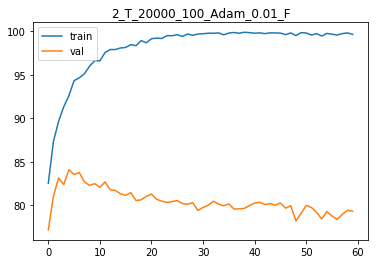

After training for 10 epochs
Train Acc 99.665
Val Acc 78.96
Test Acc 80.196
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 54.4
Epoch: [1/10], Step: [201/625], Validation Acc: 55.76
Epoch: [1/10], Step: [301/625], Validation Acc: 55.6
Epoch: [1/10], Step: [401/625], Validation Acc: 54.82
Epoch: [1/10], Step: [501/625], Validation Acc: 56.74
Epoch: [1/10], Step: [601/625], Validation Acc: 59.02
Epoch: [2/10], Step: [101/625], Validation Acc: 58.92
Epoch: [2/10], Step: [201/625], Validation Acc: 59.3
Epoch: [2/10], Step: [301/625], Validation Acc: 60.38
Epoch: [2/10], Step: [401/625], Validation Acc: 60.54
Epoch: [2/10], Step: [501/625], Validation Acc: 60.02
Epoch: [2/10], Step: [601/625], Validation Acc: 60.04
Epoch: [3/10], Step: [101/625], Validation Acc: 59.52
Epoch: [3/10], Step: [201/625], Validation Acc: 60.12
Epoch: [3/10], Step: [301/625], Validation A

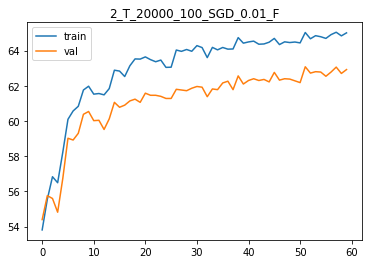

After training for 10 epochs
Train Acc 64.94
Val Acc 62.76
Test Acc 65.208
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 59.84
Epoch: [1/10], Step: [201/625], Validation Acc: 66.38
Epoch: [1/10], Step: [301/625], Validation Acc: 69.2
Epoch: [1/10], Step: [401/625], Validation Acc: 72.24
Epoch: [1/10], Step: [501/625], Validation Acc: 73.98
Epoch: [1/10], Step: [601/625], Validation Acc: 75.96
Epoch: [2/10], Step: [101/625], Validation Acc: 77.36
Epoch: [2/10], Step: [201/625], Validation Acc: 78.58
Epoch: [2/10], Step: [301/625], Validation Acc: 79.24
Epoch: [2/10], Step: [401/625], Validation Acc: 80.14
Epoch: [2/10], Step: [501/625], Validation Acc: 80.34
Epoch: [2/10], Step: [601/625], Validation Acc: 80.88
Epoch: [3/10], Step: [101/625], Validation Acc: 81.7
Epoch: [3/10], Step: [201/625], Validation Acc: 81.64
Epoch: [3/10], Step: [301/625], Validation

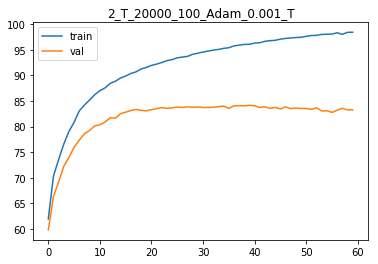

After training for 10 epochs
Train Acc 98.5
Val Acc 83.1
Test Acc 84.364
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 50.12
Epoch: [1/10], Step: [201/625], Validation Acc: 50.28
Epoch: [1/10], Step: [301/625], Validation Acc: 50.62
Epoch: [1/10], Step: [401/625], Validation Acc: 50.7
Epoch: [1/10], Step: [501/625], Validation Acc: 50.96
Epoch: [1/10], Step: [601/625], Validation Acc: 51.08
Epoch: [2/10], Step: [101/625], Validation Acc: 51.08
Epoch: [2/10], Step: [201/625], Validation Acc: 50.66
Epoch: [2/10], Step: [301/625], Validation Acc: 51.2
Epoch: [2/10], Step: [401/625], Validation Acc: 51.28
Epoch: [2/10], Step: [501/625], Validation Acc: 51.54
Epoch: [2/10], Step: [601/625], Validation Acc: 51.76
Epoch: [3/10], Step: [101/625], Validation Acc: 52.18
Epoch: [3/10], Step: [201/625], Validation Acc: 52.28
Epoch: [3/10], Step: [301/625], Validation Ac

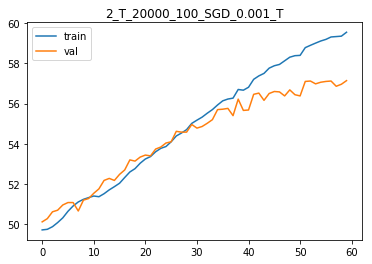

After training for 10 epochs
Train Acc 59.52
Val Acc 57.14
Test Acc 58.692
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 64.14
Epoch: [1/10], Step: [201/625], Validation Acc: 67.56
Epoch: [1/10], Step: [301/625], Validation Acc: 70.6
Epoch: [1/10], Step: [401/625], Validation Acc: 72.94
Epoch: [1/10], Step: [501/625], Validation Acc: 74.92
Epoch: [1/10], Step: [601/625], Validation Acc: 76.64
Epoch: [2/10], Step: [101/625], Validation Acc: 77.92
Epoch: [2/10], Step: [201/625], Validation Acc: 78.94
Epoch: [2/10], Step: [301/625], Validation Acc: 79.66
Epoch: [2/10], Step: [401/625], Validation Acc: 80.46
Epoch: [2/10], Step: [501/625], Validation Acc: 80.78
Epoch: [2/10], Step: [601/625], Validation Acc: 81.72
Epoch: [3/10], Step: [101/625], Validation Acc: 81.9
Epoch: [3/10], Step: [201/625], Validation Acc: 82.16
Epoch: [3/10], Step: [301/625], Validation

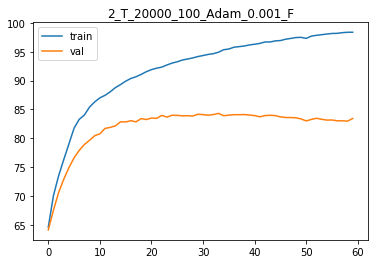

After training for 10 epochs
Train Acc 98.47
Val Acc 82.88
Test Acc 84.2
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  100
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 50.36
Epoch: [1/10], Step: [201/625], Validation Acc: 50.7
Epoch: [1/10], Step: [301/625], Validation Acc: 50.86
Epoch: [1/10], Step: [401/625], Validation Acc: 51.1
Epoch: [1/10], Step: [501/625], Validation Acc: 51.36
Epoch: [1/10], Step: [601/625], Validation Acc: 51.46
Epoch: [2/10], Step: [101/625], Validation Acc: 51.52
Epoch: [2/10], Step: [201/625], Validation Acc: 51.54
Epoch: [2/10], Step: [301/625], Validation Acc: 51.86
Epoch: [2/10], Step: [401/625], Validation Acc: 51.8
Epoch: [2/10], Step: [501/625], Validation Acc: 52.0
Epoch: [2/10], Step: [601/625], Validation Acc: 52.24
Epoch: [3/10], Step: [101/625], Validation Acc: 52.56
Epoch: [3/10], Step: [201/625], Validation Acc: 52.6
Epoch: [3/10], Step: [301/625], Validation Acc: 

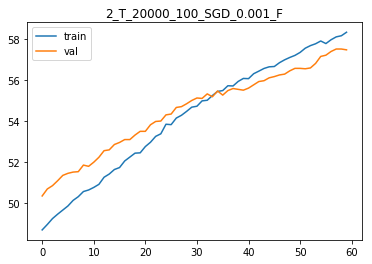

After training for 10 epochs
Train Acc 58.5
Val Acc 57.6
Test Acc 58.356
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 80.1
Epoch: [1/10], Step: [201/625], Validation Acc: 80.9
Epoch: [1/10], Step: [301/625], Validation Acc: 80.74
Epoch: [1/10], Step: [401/625], Validation Acc: 78.22
Epoch: [1/10], Step: [501/625], Validation Acc: 79.2
Epoch: [1/10], Step: [601/625], Validation Acc: 77.34
Epoch: [2/10], Step: [101/625], Validation Acc: 81.0
Epoch: [2/10], Step: [201/625], Validation Acc: 76.34
Epoch: [2/10], Step: [301/625], Validation Acc: 79.78
Epoch: [2/10], Step: [401/625], Validation Acc: 80.38
Epoch: [2/10], Step: [501/625], Validation Acc: 75.62
Epoch: [2/10], Step: [601/625], Validation Acc: 75.62
Epoch: [3/10], Step: [101/625], Validation Acc: 80.42
Epoch: [3/10], Step: [201/625], Validation Acc: 78.96
Epoch: [3/10], Step: [301/625], Validation Acc: 

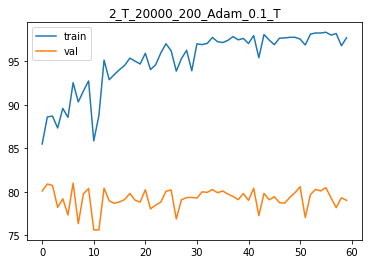

After training for 10 epochs
Train Acc 97.235
Val Acc 77.58
Test Acc 79.264
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 59.46
Epoch: [1/10], Step: [201/625], Validation Acc: 62.82
Epoch: [1/10], Step: [301/625], Validation Acc: 60.82
Epoch: [1/10], Step: [401/625], Validation Acc: 62.28
Epoch: [1/10], Step: [501/625], Validation Acc: 63.58
Epoch: [1/10], Step: [601/625], Validation Acc: 64.66
Epoch: [2/10], Step: [101/625], Validation Acc: 64.7
Epoch: [2/10], Step: [201/625], Validation Acc: 64.9
Epoch: [2/10], Step: [301/625], Validation Acc: 65.38
Epoch: [2/10], Step: [401/625], Validation Acc: 65.14
Epoch: [2/10], Step: [501/625], Validation Acc: 65.22
Epoch: [2/10], Step: [601/625], Validation Acc: 65.86
Epoch: [3/10], Step: [101/625], Validation Acc: 65.48
Epoch: [3/10], Step: [201/625], Validation Acc: 65.52
Epoch: [3/10], Step: [301/625], Validation A

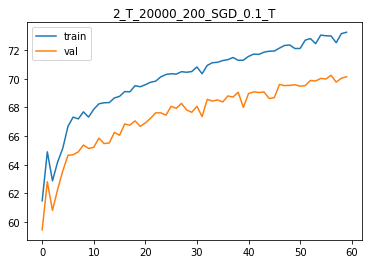

After training for 10 epochs
Train Acc 73.305
Val Acc 70.1
Test Acc 72.076
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.2
Epoch: [1/10], Step: [201/625], Validation Acc: 79.12
Epoch: [1/10], Step: [301/625], Validation Acc: 78.88
Epoch: [1/10], Step: [401/625], Validation Acc: 80.46
Epoch: [1/10], Step: [501/625], Validation Acc: 79.92
Epoch: [1/10], Step: [601/625], Validation Acc: 79.28
Epoch: [2/10], Step: [101/625], Validation Acc: 80.04
Epoch: [2/10], Step: [201/625], Validation Acc: 80.5
Epoch: [2/10], Step: [301/625], Validation Acc: 78.58
Epoch: [2/10], Step: [401/625], Validation Acc: 80.16
Epoch: [2/10], Step: [501/625], Validation Acc: 78.08
Epoch: [2/10], Step: [601/625], Validation Acc: 77.36
Epoch: [3/10], Step: [101/625], Validation Acc: 79.04
Epoch: [3/10], Step: [201/625], Validation Acc: 79.32
Epoch: [3/10], Step: [301/625], Validation A

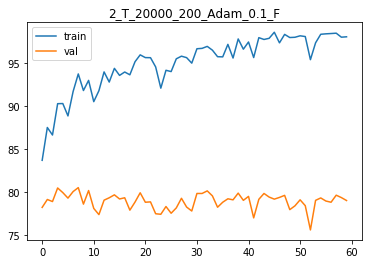

After training for 10 epochs
Train Acc 98.265
Val Acc 79.04
Test Acc 80.932
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 60.38
Epoch: [1/10], Step: [201/625], Validation Acc: 58.94
Epoch: [1/10], Step: [301/625], Validation Acc: 63.26
Epoch: [1/10], Step: [401/625], Validation Acc: 63.16
Epoch: [1/10], Step: [501/625], Validation Acc: 64.66
Epoch: [1/10], Step: [601/625], Validation Acc: 65.14
Epoch: [2/10], Step: [101/625], Validation Acc: 65.98
Epoch: [2/10], Step: [201/625], Validation Acc: 66.24
Epoch: [2/10], Step: [301/625], Validation Acc: 66.6
Epoch: [2/10], Step: [401/625], Validation Acc: 66.62
Epoch: [2/10], Step: [501/625], Validation Acc: 66.66
Epoch: [2/10], Step: [601/625], Validation Acc: 67.08
Epoch: [3/10], Step: [101/625], Validation Acc: 67.52
Epoch: [3/10], Step: [201/625], Validation Acc: 67.56
Epoch: [3/10], Step: [301/625], Validation 

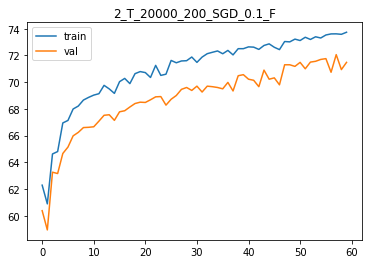

After training for 10 epochs
Train Acc 73.505
Val Acc 71.72
Test Acc 72.912
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 78.54
Epoch: [1/10], Step: [201/625], Validation Acc: 81.6
Epoch: [1/10], Step: [301/625], Validation Acc: 82.14
Epoch: [1/10], Step: [401/625], Validation Acc: 82.6
Epoch: [1/10], Step: [501/625], Validation Acc: 81.86
Epoch: [1/10], Step: [601/625], Validation Acc: 83.0
Epoch: [2/10], Step: [101/625], Validation Acc: 82.82
Epoch: [2/10], Step: [201/625], Validation Acc: 82.42
Epoch: [2/10], Step: [301/625], Validation Acc: 82.66
Epoch: [2/10], Step: [401/625], Validation Acc: 82.18
Epoch: [2/10], Step: [501/625], Validation Acc: 82.22
Epoch: [2/10], Step: [601/625], Validation Acc: 81.96
Epoch: [3/10], Step: [101/625], Validation Acc: 82.18
Epoch: [3/10], Step: [201/625], Validation Acc: 81.92
Epoch: [3/10], Step: [301/625], Validation 

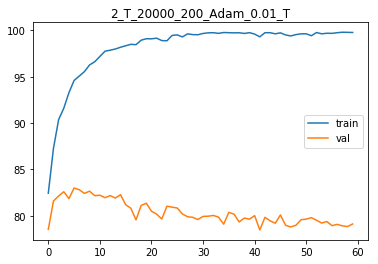

After training for 10 epochs
Train Acc 99.185
Val Acc 77.98
Test Acc 79.58
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 53.42
Epoch: [1/10], Step: [201/625], Validation Acc: 54.78
Epoch: [1/10], Step: [301/625], Validation Acc: 56.32
Epoch: [1/10], Step: [401/625], Validation Acc: 56.48
Epoch: [1/10], Step: [501/625], Validation Acc: 57.24
Epoch: [1/10], Step: [601/625], Validation Acc: 58.0
Epoch: [2/10], Step: [101/625], Validation Acc: 58.58
Epoch: [2/10], Step: [201/625], Validation Acc: 58.44
Epoch: [2/10], Step: [301/625], Validation Acc: 59.12
Epoch: [2/10], Step: [401/625], Validation Acc: 58.8
Epoch: [2/10], Step: [501/625], Validation Acc: 59.14
Epoch: [2/10], Step: [601/625], Validation Acc: 58.86
Epoch: [3/10], Step: [101/625], Validation Acc: 60.02
Epoch: [3/10], Step: [201/625], Validation Acc: 60.16
Epoch: [3/10], Step: [301/625], Validation A

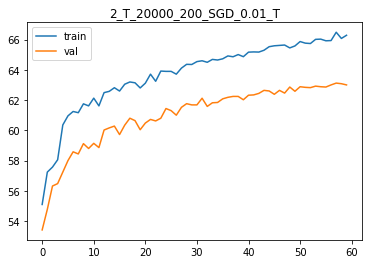

After training for 10 epochs
Train Acc 66.23
Val Acc 63.08
Test Acc 65.52
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 78.62
Epoch: [1/10], Step: [201/625], Validation Acc: 80.76
Epoch: [1/10], Step: [301/625], Validation Acc: 82.32
Epoch: [1/10], Step: [401/625], Validation Acc: 82.78
Epoch: [1/10], Step: [501/625], Validation Acc: 83.6
Epoch: [1/10], Step: [601/625], Validation Acc: 83.3
Epoch: [2/10], Step: [101/625], Validation Acc: 83.82
Epoch: [2/10], Step: [201/625], Validation Acc: 83.82
Epoch: [2/10], Step: [301/625], Validation Acc: 82.72
Epoch: [2/10], Step: [401/625], Validation Acc: 82.3
Epoch: [2/10], Step: [501/625], Validation Acc: 82.2
Epoch: [2/10], Step: [601/625], Validation Acc: 82.32
Epoch: [3/10], Step: [101/625], Validation Acc: 81.76
Epoch: [3/10], Step: [201/625], Validation Acc: 81.66
Epoch: [3/10], Step: [301/625], Validation Acc

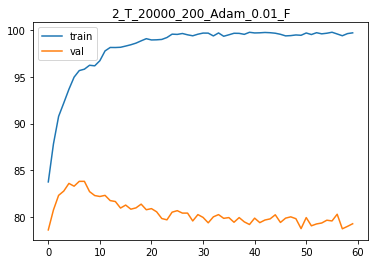

After training for 10 epochs
Train Acc 99.81
Val Acc 79.74
Test Acc 80.92
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 51.38
Epoch: [1/10], Step: [201/625], Validation Acc: 53.3
Epoch: [1/10], Step: [301/625], Validation Acc: 54.46
Epoch: [1/10], Step: [401/625], Validation Acc: 56.74
Epoch: [1/10], Step: [501/625], Validation Acc: 56.9
Epoch: [1/10], Step: [601/625], Validation Acc: 58.24
Epoch: [2/10], Step: [101/625], Validation Acc: 59.12
Epoch: [2/10], Step: [201/625], Validation Acc: 59.24
Epoch: [2/10], Step: [301/625], Validation Acc: 60.0
Epoch: [2/10], Step: [401/625], Validation Acc: 60.08
Epoch: [2/10], Step: [501/625], Validation Acc: 60.66
Epoch: [2/10], Step: [601/625], Validation Acc: 60.9
Epoch: [3/10], Step: [101/625], Validation Acc: 61.34
Epoch: [3/10], Step: [201/625], Validation Acc: 61.0
Epoch: [3/10], Step: [301/625], Validation Acc: 

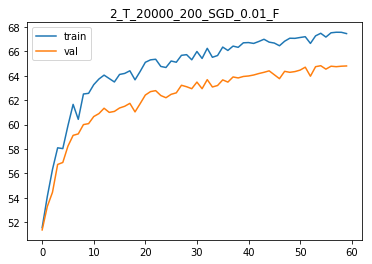

After training for 10 epochs
Train Acc 67.47
Val Acc 64.74
Test Acc 66.58
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 64.08
Epoch: [1/10], Step: [201/625], Validation Acc: 68.58
Epoch: [1/10], Step: [301/625], Validation Acc: 72.0
Epoch: [1/10], Step: [401/625], Validation Acc: 74.94
Epoch: [1/10], Step: [501/625], Validation Acc: 76.58
Epoch: [1/10], Step: [601/625], Validation Acc: 78.16
Epoch: [2/10], Step: [101/625], Validation Acc: 79.46
Epoch: [2/10], Step: [201/625], Validation Acc: 80.78
Epoch: [2/10], Step: [301/625], Validation Acc: 81.22
Epoch: [2/10], Step: [401/625], Validation Acc: 82.0
Epoch: [2/10], Step: [501/625], Validation Acc: 82.24
Epoch: [2/10], Step: [601/625], Validation Acc: 82.86
Epoch: [3/10], Step: [101/625], Validation Acc: 83.16
Epoch: [3/10], Step: [201/625], Validation Acc: 82.94
Epoch: [3/10], Step: [301/625], Validation 

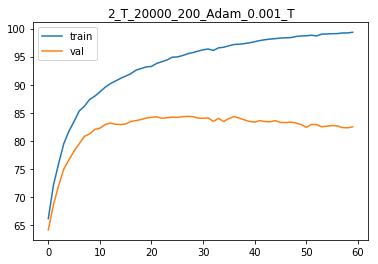

After training for 10 epochs
Train Acc 99.345
Val Acc 82.06
Test Acc 83.26
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 51.6
Epoch: [1/10], Step: [201/625], Validation Acc: 51.56
Epoch: [1/10], Step: [301/625], Validation Acc: 51.66
Epoch: [1/10], Step: [401/625], Validation Acc: 51.88
Epoch: [1/10], Step: [501/625], Validation Acc: 52.24
Epoch: [1/10], Step: [601/625], Validation Acc: 52.38
Epoch: [2/10], Step: [101/625], Validation Acc: 53.06
Epoch: [2/10], Step: [201/625], Validation Acc: 53.14
Epoch: [2/10], Step: [301/625], Validation Acc: 53.12
Epoch: [2/10], Step: [401/625], Validation Acc: 53.44
Epoch: [2/10], Step: [501/625], Validation Acc: 53.56
Epoch: [2/10], Step: [601/625], Validation Acc: 53.44
Epoch: [3/10], Step: [101/625], Validation Acc: 53.76
Epoch: [3/10], Step: [201/625], Validation Acc: 54.32
Epoch: [3/10], Step: [301/625], Validation

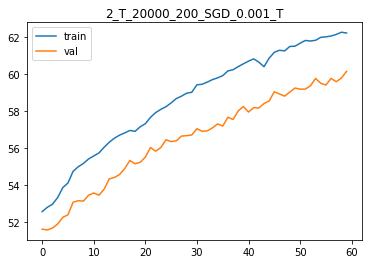

After training for 10 epochs
Train Acc 62.185
Val Acc 60.18
Test Acc 61.704
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  Adam
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 65.34
Epoch: [1/10], Step: [201/625], Validation Acc: 68.1
Epoch: [1/10], Step: [301/625], Validation Acc: 71.96
Epoch: [1/10], Step: [401/625], Validation Acc: 74.5
Epoch: [1/10], Step: [501/625], Validation Acc: 76.4
Epoch: [1/10], Step: [601/625], Validation Acc: 78.48
Epoch: [2/10], Step: [101/625], Validation Acc: 79.48
Epoch: [2/10], Step: [201/625], Validation Acc: 80.68
Epoch: [2/10], Step: [301/625], Validation Acc: 80.84
Epoch: [2/10], Step: [401/625], Validation Acc: 81.3
Epoch: [2/10], Step: [501/625], Validation Acc: 82.02
Epoch: [2/10], Step: [601/625], Validation Acc: 82.02
Epoch: [3/10], Step: [101/625], Validation Acc: 82.58
Epoch: [3/10], Step: [201/625], Validation Acc: 83.32
Epoch: [3/10], Step: [301/625], Validation 

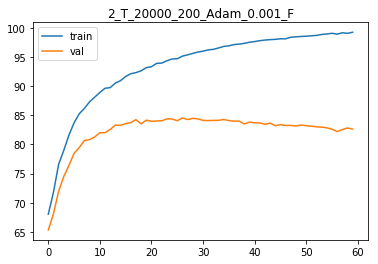

After training for 10 epochs
Train Acc 99.285
Val Acc 82.38
Test Acc 83.252
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  200
optimizer:  SGD
initial learning_rate:  0.001
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 52.08
Epoch: [1/10], Step: [201/625], Validation Acc: 52.34
Epoch: [1/10], Step: [301/625], Validation Acc: 52.48
Epoch: [1/10], Step: [401/625], Validation Acc: 52.78
Epoch: [1/10], Step: [501/625], Validation Acc: 53.1
Epoch: [1/10], Step: [601/625], Validation Acc: 53.3
Epoch: [2/10], Step: [101/625], Validation Acc: 53.76
Epoch: [2/10], Step: [201/625], Validation Acc: 54.42
Epoch: [2/10], Step: [301/625], Validation Acc: 54.46
Epoch: [2/10], Step: [401/625], Validation Acc: 54.34
Epoch: [2/10], Step: [501/625], Validation Acc: 54.82
Epoch: [2/10], Step: [601/625], Validation Acc: 55.04
Epoch: [3/10], Step: [101/625], Validation Acc: 55.32
Epoch: [3/10], Step: [201/625], Validation Acc: 55.6
Epoch: [3/10], Step: [301/625], Validation 

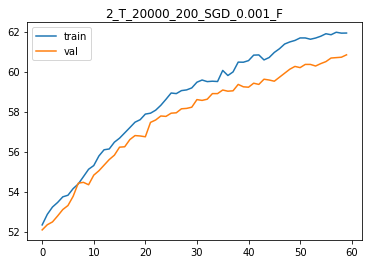

After training for 10 epochs
Train Acc 61.99
Val Acc 60.88
Test Acc 61.44
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 77.38
Epoch: [1/10], Step: [201/625], Validation Acc: 78.62
Epoch: [1/10], Step: [301/625], Validation Acc: 71.28
Epoch: [1/10], Step: [401/625], Validation Acc: 77.32
Epoch: [1/10], Step: [501/625], Validation Acc: 72.78
Epoch: [1/10], Step: [601/625], Validation Acc: 73.3
Epoch: [2/10], Step: [101/625], Validation Acc: 79.92
Epoch: [2/10], Step: [201/625], Validation Acc: 75.4
Epoch: [2/10], Step: [301/625], Validation Acc: 76.72
Epoch: [2/10], Step: [401/625], Validation Acc: 75.98
Epoch: [2/10], Step: [501/625], Validation Acc: 79.54
Epoch: [2/10], Step: [601/625], Validation Acc: 78.38
Epoch: [3/10], Step: [101/625], Validation Acc: 80.04
Epoch: [3/10], Step: [201/625], Validation Acc: 78.4
Epoch: [3/10], Step: [301/625], Validation Acc

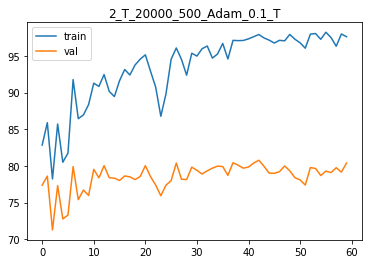

After training for 10 epochs
Train Acc 97.225
Val Acc 78.6
Test Acc 80.112
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 63.06
Epoch: [1/10], Step: [201/625], Validation Acc: 65.24
Epoch: [1/10], Step: [301/625], Validation Acc: 66.36
Epoch: [1/10], Step: [401/625], Validation Acc: 66.94
Epoch: [1/10], Step: [501/625], Validation Acc: 68.24
Epoch: [1/10], Step: [601/625], Validation Acc: 66.38
Epoch: [2/10], Step: [101/625], Validation Acc: 70.0
Epoch: [2/10], Step: [201/625], Validation Acc: 70.46
Epoch: [2/10], Step: [301/625], Validation Acc: 70.46
Epoch: [2/10], Step: [401/625], Validation Acc: 69.66
Epoch: [2/10], Step: [501/625], Validation Acc: 70.26
Epoch: [2/10], Step: [601/625], Validation Acc: 70.22
Epoch: [3/10], Step: [101/625], Validation Acc: 71.42
Epoch: [3/10], Step: [201/625], Validation Acc: 71.26
Epoch: [3/10], Step: [301/625], Validation A

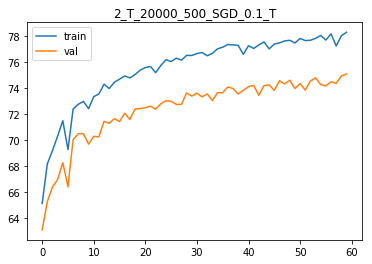

After training for 10 epochs
Train Acc 77.63
Val Acc 74.04
Test Acc 75.364
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 73.76
Epoch: [1/10], Step: [201/625], Validation Acc: 75.08
Epoch: [1/10], Step: [301/625], Validation Acc: 78.42
Epoch: [1/10], Step: [401/625], Validation Acc: 76.76
Epoch: [1/10], Step: [501/625], Validation Acc: 78.22
Epoch: [1/10], Step: [601/625], Validation Acc: 79.16
Epoch: [2/10], Step: [101/625], Validation Acc: 81.22
Epoch: [2/10], Step: [201/625], Validation Acc: 77.86
Epoch: [2/10], Step: [301/625], Validation Acc: 80.74
Epoch: [2/10], Step: [401/625], Validation Acc: 78.66
Epoch: [2/10], Step: [501/625], Validation Acc: 77.84
Epoch: [2/10], Step: [601/625], Validation Acc: 74.96
Epoch: [3/10], Step: [101/625], Validation Acc: 79.22
Epoch: [3/10], Step: [201/625], Validation Acc: 77.18
Epoch: [3/10], Step: [301/625], Validation

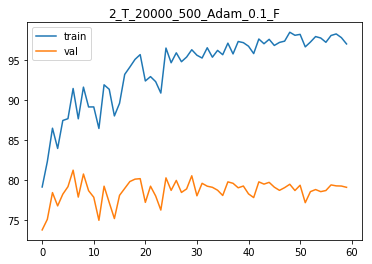

After training for 10 epochs
Train Acc 98.225
Val Acc 79.22
Test Acc 80.812
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.1
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 62.72
Epoch: [1/10], Step: [201/625], Validation Acc: 63.28
Epoch: [1/10], Step: [301/625], Validation Acc: 67.06
Epoch: [1/10], Step: [401/625], Validation Acc: 68.16
Epoch: [1/10], Step: [501/625], Validation Acc: 68.92
Epoch: [1/10], Step: [601/625], Validation Acc: 68.78
Epoch: [2/10], Step: [101/625], Validation Acc: 69.52
Epoch: [2/10], Step: [201/625], Validation Acc: 69.66
Epoch: [2/10], Step: [301/625], Validation Acc: 69.68
Epoch: [2/10], Step: [401/625], Validation Acc: 71.02
Epoch: [2/10], Step: [501/625], Validation Acc: 70.86
Epoch: [2/10], Step: [601/625], Validation Acc: 69.6
Epoch: [3/10], Step: [101/625], Validation Acc: 71.64
Epoch: [3/10], Step: [201/625], Validation Acc: 71.66
Epoch: [3/10], Step: [301/625], Validation 

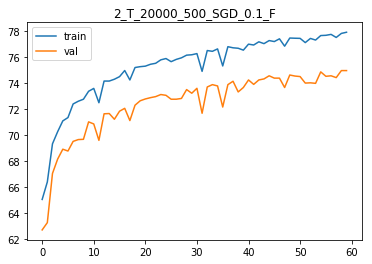

After training for 10 epochs
Train Acc 77.63
Val Acc 75.04
Test Acc 76.504
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 79.28
Epoch: [1/10], Step: [201/625], Validation Acc: 80.72
Epoch: [1/10], Step: [301/625], Validation Acc: 81.42
Epoch: [1/10], Step: [401/625], Validation Acc: 83.26
Epoch: [1/10], Step: [501/625], Validation Acc: 82.92
Epoch: [1/10], Step: [601/625], Validation Acc: 81.18
Epoch: [2/10], Step: [101/625], Validation Acc: 82.48
Epoch: [2/10], Step: [201/625], Validation Acc: 81.86
Epoch: [2/10], Step: [301/625], Validation Acc: 82.24
Epoch: [2/10], Step: [401/625], Validation Acc: 82.62
Epoch: [2/10], Step: [501/625], Validation Acc: 81.84
Epoch: [2/10], Step: [601/625], Validation Acc: 81.7
Epoch: [3/10], Step: [101/625], Validation Acc: 81.58
Epoch: [3/10], Step: [201/625], Validation Acc: 80.2
Epoch: [3/10], Step: [301/625], Validation 

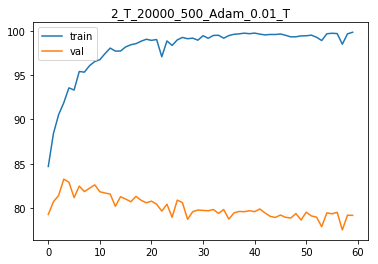

After training for 10 epochs
Train Acc 99.805
Val Acc 78.84
Test Acc 80.512
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  T
Epoch: [1/10], Step: [101/625], Validation Acc: 57.94
Epoch: [1/10], Step: [201/625], Validation Acc: 57.34
Epoch: [1/10], Step: [301/625], Validation Acc: 61.28
Epoch: [1/10], Step: [401/625], Validation Acc: 61.44
Epoch: [1/10], Step: [501/625], Validation Acc: 62.7
Epoch: [1/10], Step: [601/625], Validation Acc: 63.22
Epoch: [2/10], Step: [101/625], Validation Acc: 63.78
Epoch: [2/10], Step: [201/625], Validation Acc: 64.3
Epoch: [2/10], Step: [301/625], Validation Acc: 63.92
Epoch: [2/10], Step: [401/625], Validation Acc: 64.56
Epoch: [2/10], Step: [501/625], Validation Acc: 65.02
Epoch: [2/10], Step: [601/625], Validation Acc: 63.16
Epoch: [3/10], Step: [101/625], Validation Acc: 65.02
Epoch: [3/10], Step: [201/625], Validation Acc: 65.32
Epoch: [3/10], Step: [301/625], Validation 

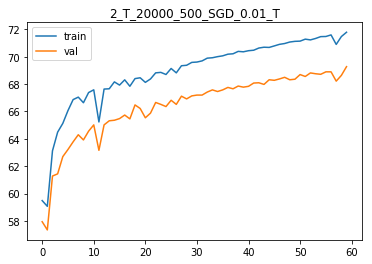

After training for 10 epochs
Train Acc 71.685
Val Acc 69.3
Test Acc 70.956
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  Adam
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 80.24
Epoch: [1/10], Step: [201/625], Validation Acc: 81.34
Epoch: [1/10], Step: [301/625], Validation Acc: 81.78
Epoch: [1/10], Step: [401/625], Validation Acc: 82.36
Epoch: [1/10], Step: [501/625], Validation Acc: 82.6
Epoch: [1/10], Step: [601/625], Validation Acc: 82.98
Epoch: [2/10], Step: [101/625], Validation Acc: 82.62
Epoch: [2/10], Step: [201/625], Validation Acc: 81.9
Epoch: [2/10], Step: [301/625], Validation Acc: 82.42
Epoch: [2/10], Step: [401/625], Validation Acc: 82.18
Epoch: [2/10], Step: [501/625], Validation Acc: 82.06
Epoch: [2/10], Step: [601/625], Validation Acc: 81.34
Epoch: [3/10], Step: [101/625], Validation Acc: 81.84
Epoch: [3/10], Step: [201/625], Validation Acc: 81.38
Epoch: [3/10], Step: [301/625], Validation 

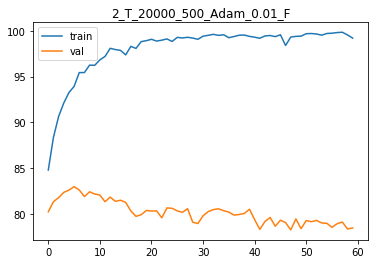

After training for 10 epochs
Train Acc 99.415
Val Acc 79.14
Test Acc 80.676
ngram:  2
use all_ngram? :  T
max_vocab_size:  20000
emd_dim:  500
optimizer:  SGD
initial learning_rate:  0.01
lr decay? :  F
Epoch: [1/10], Step: [101/625], Validation Acc: 58.32
Epoch: [1/10], Step: [201/625], Validation Acc: 59.64
Epoch: [1/10], Step: [301/625], Validation Acc: 60.58
Epoch: [1/10], Step: [401/625], Validation Acc: 62.24
Epoch: [1/10], Step: [501/625], Validation Acc: 62.04
Epoch: [1/10], Step: [601/625], Validation Acc: 62.96
Epoch: [2/10], Step: [101/625], Validation Acc: 63.7
Epoch: [2/10], Step: [201/625], Validation Acc: 64.24
Epoch: [2/10], Step: [301/625], Validation Acc: 63.78
Epoch: [2/10], Step: [401/625], Validation Acc: 64.02
Epoch: [2/10], Step: [501/625], Validation Acc: 64.9
Epoch: [2/10], Step: [601/625], Validation Acc: 64.98
Epoch: [3/10], Step: [101/625], Validation Acc: 65.06
Epoch: [3/10], Step: [201/625], Validation Acc: 65.52
Epoch: [3/10], Step: [301/625], Validation 

KeyboardInterrupt: 

In [9]:
# enumerative search
best_valid_acc = 0
ns = [1,2,3,4]
all_ngrams = ['T','F']
max_vocab_sizes = [5000, 10000, 20000]
emb_dims = [100, 200, 500]
lrs = [0.1, 0.01, 0.001]
lr_decays = ['T', 'F']
optims = ['Adam', 'SGD']
val_accs = []
for n in ns:
    for all_ngram in all_ngrams:
        for max_vocab_size in max_vocab_sizes:
            for emb_dim in emb_dims:
                for lr in lrs:
                    for lr_decay in lr_decays:
                        for optim in optims:
                            train_acc, val_acc, test_acc = train_valid(n, all_ngram, max_vocab_size, emb_dim, optim, lr, lr_decay)
                            val_accs.append(val_acc)
                            if val_acc > best_valid_acc:
                                best_n = n
                                best_all_ngram = all_ngram
                                best_max_vocab_size = max_vocab_size
                                best_emb_dim = emb_dim
                                best_optim = optim
                                best_lr = lr
                                best_lr_decay = lr_decay
                                best_valid_acc = val_acc
                                best_test_acc = test_acc
                                best_train_acc = train_acc
print('The best model selected on the validation set has')
print('best_n: ', best_n)
print('best_all_ngram: ', best_all_ngram)
print('best_max_vocab_size: ', best_max_vocab_size)
print('best_emb_dim: ', emb_dim)
print('best_optim: ', best_optim)
print('best_lr: ', lr)
print('best_lr_decay: ', lr_decay)
print('train_acc: ', best_train_acc)
print('val_acc: ', best_valid_acc)
print('test_acc: ', best_test_acc)